# Create Environment

In [28]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm

global N

N=50

global M
M=10

global T
global target
T=15
target=np.array([3,2])
global w
w=np.pi*2/23.7

global delta_t
delta_t=T/N

global beta
beta=[0.9,0.95,1,1.05,1.1]

global num_system
num_system=5

In [29]:
def Z(vecs, u, v):
    output=[]
    for i in range(num_system):
        vec=vecs[i]
        x=vec[0]
        y=vec[1]
        theta=vec[2]
        output.append([beta[i]*np.cos(theta)*u,beta[i]*np.sin(theta)*u,beta[i]*v])
    return np.array(output)

#check the correctness of Z
'''
x = np.linspace(0, 6.5, 1001)
plt.plot(x, Z(x))
plt.xlabel('Angle [rad]')
plt.ylabel('Z(theta)')
plt.grid()
plt.show()
'''

"\nx = np.linspace(0, 6.5, 1001)\nplt.plot(x, Z(x))\nplt.xlabel('Angle [rad]')\nplt.ylabel('Z(theta)')\nplt.grid()\nplt.show()\n"

In [30]:
def next_step(vecs,action):  
    u=action[0]
    v=action[1]
   
    for j in range(M):
        vecs_new=[]
        diff=Z(vecs,u,v)
        for i in range(num_system):
            w=vecs[i]+delta_t/M*diff[i]
            '''
            if w[2]>np.pi:
                w[2]-=2*np.pi
            if w[2]<-np.pi:
                w[2]+=2*np.pi
            '''
            vecs_new.append(w)
        vecs=np.array(vecs_new)
    return vecs

def observe(vecs):
    mu_x=0
    mu_y=0
    mu_theta=0
    var_x=0
    var_y=0
    for i in range(num_system):
        mu_x+=vecs[i][0]
        mu_y+=vecs[i][1]
        mu_theta+=vecs[i][2]
        var_x+=vecs[i][0]**2
        var_y+=vecs[i][1]**2
    var_x-=mu_x**2/num_system
    var_y-=mu_y**2/num_system
    return np.array([mu_x,mu_y,mu_theta,var_x,var_y])/num_system

def reward(obs):
    return -(obs[0]-target[0])**2-(obs[1]-target[1])**2-obs[3]-obs[4]

def reward_raw(position):
    r=0
    for i in range(num_system):
        r+=np.linalg.norm(position[i,[0,1]]-target)
    return r

def value_func(funcs,flags,next_state):
    result=[]
    for i in range(6):
        if flags[i]:
            result.append(-1000)
        else:
            k,_=funcs[i].predict(next_state.reshape(-1,3*num_system), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.max(result)

# Learning Settings

In [31]:
global lr
lr=0.01
global eps
eps=0.2
global max_u
max_u=2
global precision
precision=0.0002
global action_set
action_set=np.array([[1,np.pi/4],[-1,np.pi/4],[1,0],[-1,0],[1,-np.pi/4],[-1,-np.pi/4]])

def exploration():
    a=np.random.uniform()
    if a<eps:
        return True
    else:
        return False

def find_max(cand):
    return np.argmax(cand)
    
def decide_u(funcs,flags,state,init=False):
    explo=exploration()
    if init or explo:
        return np.random.randint(6)
    else:
        result=[]
        for i in range(6):
            if flags[i]:
                return i
            else:
                k,_=funcs[i].predict(state.reshape(-1,3*num_system), return_std=True)
                result.append(k[0])
    result=np.array(result)
    return np.argmax(result)
    
def decide_u_exploitation(funcs,flags,state,init=False):
    result=[]
    for i in range(6):
        if flags[i]:
            print("Err",i)
            return i
        else:
            k,_=funcs[i].predict(state.reshape(-1,3*num_system), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.argmax(result)

history_su=[[0 for i in range(6)] for j in range(N+1)]
history_r=[[0 for i in range(6)] for j in range(N+1)]
flags=[[True for i in range(6)] for j in range(N+1)]

# Simulation


In [32]:
num_iter=3000

position_result=[]
observation_result=[]
gpr_list=[[0 for i in range(6)] for j in range(N+1)]

best_r=-10000
best_obs=[]
best_pos=[[] for i in range(num_system)]

for iterr in tqdm(range(num_iter)):
    #initialize
    position=np.array([[-2,-2,0] for _ in range(num_system)])
    observation=observe(position)
    u_t=[]
    r_t=[]
    observation_t=[observation]
    position_t=[[] for i in range(num_system)]
    
    for time in range(N+1):
        if iterr==0:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags[time],position,init=True)
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            #r = reward(observation_new)
            r = -reward_raw(position_new)
            r_t.append(r)
            '''
            if flags[u_k]:
                history_su[u_k] = position.reshape(-1,3*num_system)
                history_r[u_k] = np.array([r])
                flags[u_k]=False
            else:
                history_su[u_k] = np.concatenate((history_su[u_k], position.reshape(-1,3*num_system)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            '''
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
        else:            
            u_k = decide_u(gpr_list[time],flags[time],position)
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = -reward_raw(position_new)
            r_t.append(r)
            '''
            if explo:
                history_su[u_k] = np.concatenate((history_su[u_k], position.reshape(-1,3*num_system)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            else:
                a=np.random.uniform()
                if a<0.25:
                    history_su[u_k] = np.concatenate((history_su[u_k], position.reshape(-1,3*num_system)))
                    history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            '''
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
            
            if abs(r)<0.03:
                break
            
    position_t=np.array(position_t)
    for i in range(N+1):
        if i==1:
            if flags[-i][u_t[-i]]:
                history_su[-i][u_t[-i]] = position_t[:,-i].reshape(-1,3*num_system)
                history_r[-i][u_t[-i]] = np.array([r_t[-i]])
                flags[-i][u_t[-i]]=False
            else:
                history_su[-i][u_t[-i]] = np.concatenate((history_su[-i][u_t[-i]], position_t[:,-i].reshape(-1,3*num_system)))
                history_r[-i][u_t[-i]] = np.concatenate((history_r[-i][u_t[-i]],np.array([r_t[-i]])))
            
            gpr_list[-i][u_t[-i]]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[-i][u_t[-i]], history_r[-i][u_t[-i]].reshape(-1,1))
        
        elif i>1:
            r_t[-i]=r_t[-i]+value_func(gpr_list[-i+1],flags[-i+1],position_t[:,-i+1])
            
            if flags[-i][u_t[-i]]:
                history_su[-i][u_t[-i]] = position_t[:,-i].reshape(-1,3*num_system)
                history_r[-i][u_t[-i]] = np.array([r_t[-i]])
                flags[-i][u_t[-i]]=False
            else:
                history_su[-i][u_t[-i]] = np.concatenate((history_su[-i][u_t[-i]], position_t[:,-i].reshape(-1,3*num_system)))
                history_r[-i][u_t[-i]] = np.concatenate((history_r[-i][u_t[-i]],np.array([r_t[-i]]))) 
            
            gpr_list[-i][u_t[-i]]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[-i][u_t[-i]], history_r[-i][u_t[-i]].reshape(-1,1))
    
    r_t[0]=r_t[0]+value_func(gpr_list[1],flags[1],position_t[:,1])
    if flags[0][u_t[0]]:
        history_su[0][u_t[0]] = position_t[:,0].reshape(-1,3*num_system)
        history_r[0][u_t[0]] = np.array([r_t[0]])
        flags[0][u_t[0]]=False
    else:
        history_su[0][u_t[0]] = np.concatenate((history_su[0][u_t[0]], position_t[:,0].reshape(-1,3*num_system)))
        history_r[0][u_t[0]] = np.concatenate((history_r[0][u_t[0]],np.array([r_t[0]])))
    gpr_list[0][u_t[0]]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[0][u_t[0]], history_r[0][u_t[0]].reshape(-1,1))
    
    print("observation =",observation)
    #print(observation_t)
    position_result.append(position)
    observation_result.append(observation)
    if r>best_r:
        best_r=r
        best_obs=observation_t
        best_pos=position_t
    
    #print(history_su.shape)
    #print(u_t)

  0%|                                                                                 | 2/3000 [00:00<05:39,  8.83it/s]

observation = [-4.48406803 -2.66911396  1.17809725  0.02047668  0.00917969]
observation = [-3.8702926  -0.03493606 10.36725576  0.53202232  0.87423511]


  0%|                                                                                 | 4/3000 [00:00<07:17,  6.84it/s]

observation = [-1.85062254 -2.74951593  5.41924733  0.00878995  0.00757109]
observation = [-3.47668084 -2.52161409  0.9424778   0.00968995  0.00622507]


  0%|▏                                                                                | 5/3000 [00:00<07:18,  6.83it/s]

observation = [-2.47466558 -3.39150891 -4.24115008  0.01580193  0.07668629]


  0%|▏                                                                                | 6/3000 [00:00<08:24,  5.94it/s]

observation = [-3.5006029   0.74100931 -8.48230016  0.37713619  0.6669238 ]


  0%|▏                                                                                | 7/3000 [00:01<09:12,  5.42it/s]

observation = [ 5.40904749e-01 -1.33329317e+00 -8.32667268e-18  2.52217690e-02
  7.76447929e-03]


  0%|▏                                                                                | 8/3000 [00:01<10:01,  4.97it/s]

observation = [ 0.23710686 -3.54864473 -1.17809725  0.00880327  0.04332445]


  0%|▏                                                                                | 9/3000 [00:01<10:31,  4.74it/s]

observation = [-4.78465729e+00  1.31954620e+00 -4.71238898e-01  6.54031176e-04
  1.50715328e-01]


  0%|▎                                                                               | 10/3000 [00:01<10:36,  4.70it/s]

observation = [-2.29874575e+00 -1.61437341e+00 -4.71238898e-01  3.71674685e-04
  3.36241461e-03]


  0%|▎                                                                               | 11/3000 [00:02<10:39,  4.67it/s]

observation = [-1.59847314e+00 -1.75414168e+00 -1.17809725e+00  1.73402583e-03
  9.62655153e-04]


  0%|▎                                                                               | 12/3000 [00:02<10:41,  4.66it/s]

observation = [-2.12933701e+00 -3.26580170e+00 -3.05311332e-17  4.31345244e-03
  2.63850273e-02]


  0%|▎                                                                               | 13/3000 [00:02<10:43,  4.64it/s]

observation = [-8.12820765e-01 -3.15154505e+00 -4.71238898e-01  7.21131773e-04
  1.19665514e-02]


  0%|▍                                                                               | 15/3000 [00:02<10:30,  4.74it/s]

observation = [-3.08180443e+00 -1.79935829e+00 -1.41371669e+00  2.28888314e-03
  2.55234517e-04]
observation = [-1.45506607e+00 -2.11993280e+00  4.71238898e-01  3.29741237e-05
  1.28399232e-03]


  1%|▍                                                                               | 17/3000 [00:03<10:22,  4.79it/s]

observation = [-1.790035   -1.24242614 -0.70685835  0.00569689  0.00606509]
observation = [-1.15036699 -2.52493696 -0.9424778   0.00286244  0.00517382]


  1%|▍                                                                               | 18/3000 [00:03<10:33,  4.71it/s]

observation = [-1.48671524e+00 -2.16833170e+00 -9.42477796e-01  2.02465991e-05
  4.52170480e-05]


  1%|▌                                                                               | 19/3000 [00:03<10:48,  4.60it/s]

observation = [-1.97998770e+00 -2.06761875e+00  2.35619449e-01  1.88931813e-03
  3.55364300e-04]


  1%|▌                                                                               | 20/3000 [00:03<10:47,  4.60it/s]

observation = [-1.37513294e+00 -2.63073506e+00 -2.35619449e-01  3.02071549e-05
  6.35737601e-03]


  1%|▌                                                                               | 21/3000 [00:04<10:46,  4.61it/s]

observation = [-1.90972260e+00 -2.09137009e+00 -9.42477796e-01  3.52802071e-04
  1.99059329e-06]


  1%|▌                                                                               | 23/3000 [00:04<10:29,  4.73it/s]

observation = [-9.80370494e-01 -2.95536634e+00 -1.88495559e+00  5.60484471e-05
  1.37638068e-02]
observation = [-2.16122457e+00 -2.74504304e+00  1.17809725e+00  1.08367575e-04
  1.10735464e-02]


  1%|▋                                                                               | 24/3000 [00:04<10:07,  4.90it/s]

observation = [-1.11520009e+00 -2.05392735e+00 -2.35619449e-01  3.80810914e-03
  9.93935140e-06]


  1%|▋                                                                               | 26/3000 [00:05<10:22,  4.78it/s]

observation = [-2.49123767 -2.52504357  0.4712389   0.00361963  0.00436921]
observation = [-2.19429173e+00 -1.85907720e+00 -9.42477796e-01  4.69067704e-06
  1.37513155e-04]


  1%|▋                                                                               | 27/3000 [00:05<10:28,  4.73it/s]

observation = [-1.65536805e+00 -1.60065350e+00 -7.06858347e-01  9.57239295e-04
  3.23059916e-03]


  1%|▋                                                                               | 28/3000 [00:05<10:33,  4.69it/s]

observation = [-0.26627264 -1.24534551 -1.17809725  0.02185182  0.00657256]


  1%|▊                                                                               | 30/3000 [00:06<10:31,  4.70it/s]

observation = [-3.18811959 -2.65191449  0.23561945  0.01449251  0.0061344 ]
observation = [-2.44936456e+00 -1.40281612e+00 -9.42477796e-01  7.64310684e-04
  4.49366031e-03]


  1%|▊                                                                               | 31/3000 [00:06<10:05,  4.90it/s]

observation = [-0.18325403 -2.84332341 -1.17809725  0.02880236  0.01298093]


  1%|▊                                                                               | 32/3000 [00:06<10:08,  4.88it/s]

observation = [-1.60843744e+00 -1.78800275e+00 -7.06858347e-01  1.60570257e-03
  6.94318731e-04]


  1%|▉                                                                               | 33/3000 [00:06<10:21,  4.77it/s]

observation = [-1.57910438e+00 -2.21434271e+00 -2.35619449e-01  2.14099009e-03
  8.91166573e-04]


  1%|▉                                                                               | 34/3000 [00:06<10:24,  4.75it/s]

observation = [-1.83142019e+00 -3.27136322e+00 -4.71238898e-01  3.49534066e-05
  2.96682152e-02]


  1%|▉                                                                               | 35/3000 [00:07<10:29,  4.71it/s]

observation = [-1.02953115 -2.53227843  0.23561945  0.00610713  0.00525038]


  1%|▉                                                                               | 37/3000 [00:07<10:04,  4.90it/s]

observation = [-2.31388903e+00 -1.72129851e+00 -4.71238898e-01  5.79491810e-04
  1.48172046e-03]
observation = [ 0.61815773 -0.53866384  0.70685835  0.01014776  0.02946241]


  1%|█                                                                               | 39/3000 [00:07<09:30,  5.19it/s]

observation = [-2.13240162 -3.38355903  0.9424778   0.00788993  0.02574102]
observation = [-2.17865101e+00 -2.67587958e+00  2.35619449e-01  1.45303561e-05
  8.80730236e-03]


  1%|█                                                                               | 41/3000 [00:08<08:54,  5.53it/s]

observation = [-2.08732109e+00 -1.60676879e+00 -7.06858347e-01  4.99648156e-04
  2.35797909e-03]
observation = [-1.45078892 -1.37619458 -0.70685835  0.00508009  0.00606022]


  1%|█▏                                                                              | 43/3000 [00:08<08:52,  5.55it/s]

observation = [-2.45755048e+00 -1.66130552e+00 -2.35619449e-01  2.84873057e-03
  2.19687696e-03]
observation = [-1.75633994e+00 -1.45381878e+00 -2.35619449e-01  9.10030373e-05
  5.53109087e-03]


  2%|█▏                                                                              | 45/3000 [00:08<08:59,  5.48it/s]

observation = [-3.08911938e+00 -1.03410828e+00 -7.06858347e-01  5.58914305e-04
  1.45142732e-02]
observation = [-1.38114373e+00 -2.20018791e+00 -7.06858347e-01  6.91210600e-03
  1.56763499e-03]


  2%|█▎                                                                              | 47/3000 [00:09<08:47,  5.60it/s]

observation = [-1.07807246 -0.97248411 -0.4712389   0.00465069  0.01999888]
observation = [-1.22203688e+00 -1.59278598e+00 -9.42477796e-01  1.21260356e-02
  6.74683108e-04]


  2%|█▎                                                                              | 48/3000 [00:09<09:06,  5.40it/s]

observation = [-1.65706522e+00 -7.43054636e-01 -2.35619449e-01  8.69657431e-04
  2.34373393e-02]


  2%|█▎                                                                              | 49/3000 [00:09<09:38,  5.10it/s]

observation = [-2.68339792e+00 -1.46804172e+00 -7.06858347e-01  3.83664264e-04
  4.84735953e-03]


  2%|█▎                                                                              | 50/3000 [00:09<10:07,  4.86it/s]

observation = [-2.87316101e+00 -2.02800043e+00  2.35619449e-01  3.34784156e-03
  1.19409814e-05]


  2%|█▎                                                                              | 51/3000 [00:10<10:16,  4.78it/s]

observation = [ 0.42503853 -1.03276088  0.9424778   0.01633012  0.01897163]


  2%|█▍                                                                              | 53/3000 [00:10<10:09,  4.83it/s]

observation = [ 0.52258851 -1.12665225  1.41371669  0.02372061  0.01366755]
observation = [-1.61242117e+00 -2.10229149e+00 -4.71238898e-01  1.55193473e-03
  2.47755776e-04]


  2%|█▍                                                                              | 55/3000 [00:10<09:26,  5.20it/s]

observation = [-2.13756564e+00 -1.34914514e+00 -7.06858347e-01  1.39978578e-04
  7.24394531e-03]
observation = [-3.34177654e+00 -1.83312661e+00  4.71238898e-01  5.40776402e-03
  4.06224637e-04]


  2%|█▌                                                                              | 57/3000 [00:11<09:09,  5.36it/s]

observation = [-2.74466816e-01 -2.10133399e+00 -2.35619449e-01  2.32731797e-02
  2.24325115e-04]
observation = [ 0.13688961 -1.00163625  0.9424778   0.00601791  0.01544369]


  2%|█▌                                                                              | 59/3000 [00:11<08:52,  5.53it/s]

observation = [-1.12360800e+00 -1.91294539e+00  2.35619449e-01  3.44751757e-03
  1.44261292e-04]
observation = [-1.39050204e+00 -2.35139847e+00  4.71238898e-01  5.78120748e-05
  1.11918921e-03]


  2%|█▋                                                                              | 61/3000 [00:12<08:57,  5.47it/s]

observation = [-2.08079787e+00 -1.95620470e+00 -2.35619449e-01  2.91666877e-03
  4.59686841e-04]
observation = [-2.42735301e+00 -1.58508367e+00 -1.38777878e-17  2.82570372e-04
  4.04733327e-04]


  2%|█▋                                                                              | 63/3000 [00:12<08:42,  5.62it/s]

observation = [-1.44366711e+00 -2.84493265e+00 -1.38777878e-17  3.59323773e-05
  1.10455417e-02]
observation = [-3.26728754  1.35050977  1.41371669  0.14857261  0.07270729]


  2%|█▋                                                                              | 65/3000 [00:12<08:52,  5.51it/s]

observation = [-1.43088724e+00 -2.14222314e+00 -7.06858347e-01  3.57517889e-05
  2.48888386e-04]
observation = [-2.29331560e+00 -2.03391229e+00 -8.32667268e-18  3.57650131e-04
  9.50829201e-07]


  2%|█▊                                                                              | 67/3000 [00:13<09:01,  5.42it/s]

observation = [-0.03102514 -2.5759207   0.23561945  0.01471933  0.00620076]
observation = [-1.86478393e+00 -2.30822244e+00  2.35619449e-01  1.59568589e-04
  1.48477292e-03]


  2%|█▊                                                                              | 68/3000 [00:13<09:14,  5.29it/s]

observation = [-2.04967124e+00 -2.51463919e+00 -9.42477796e-01  2.41137492e-03
  3.35015633e-03]


  2%|█▊                                                                              | 70/3000 [00:13<09:12,  5.30it/s]

observation = [-1.13891767 -2.55991258 -0.23561945  0.00309211  0.00610966]
observation = [-1.57942628e+00 -2.16746209e+00  4.71238898e-01  2.07854443e-03
  3.78185350e-04]


  2%|█▉                                                                              | 72/3000 [00:14<09:03,  5.39it/s]

observation = [-2.34343854e+00 -2.02659074e+00 -9.42477796e-01  1.14503672e-02
  4.00518601e-05]
observation = [-1.19609006e+00 -2.44424931e+00  4.71238898e-01  1.93142330e-03
  3.50894368e-03]


  2%|█▉                                                                              | 73/3000 [00:14<09:17,  5.25it/s]

observation = [-2.26301889e+00 -2.56566815e+00  4.71238898e-01  1.84259230e-04
  6.13334276e-03]


  2%|██                                                                              | 75/3000 [00:14<09:26,  5.17it/s]

observation = [-1.81488579e+00 -2.09281984e+00 -7.06858347e-01  6.87358034e-07
  2.32734691e-05]
observation = [-2.09324874e-01 -2.43762666e+00 -3.05311332e-17  2.62565503e-02
  1.53617823e-03]


  3%|██                                                                              | 77/3000 [00:15<09:06,  5.34it/s]

observation = [-1.59441038e+00 -1.98538042e+00 -4.71238898e-01  1.64171570e-03
  3.57002492e-05]
observation = [-2.57680415e+00 -1.23241297e+00 -2.35619449e-01  1.54961676e-05
  9.28259484e-03]


  3%|██                                                                              | 79/3000 [00:15<09:14,  5.27it/s]

observation = [-2.00471297e+00 -1.95392391e+00 -2.35619449e-01  1.19076897e-03
  1.57066617e-04]
observation = [-2.29477483e+00 -1.06062749e+00  7.06858347e-01  3.84530935e-04
  1.45659902e-02]


  3%|██▏                                                                             | 81/3000 [00:15<09:14,  5.26it/s]

observation = [-2.18655848e+00 -1.67018719e+00 -4.71238898e-01  6.70346187e-06
  1.93342082e-03]
observation = [-1.14398357e+00 -2.28646653e+00 -4.71238898e-01  2.96993034e-03
  1.57465388e-03]


  3%|██▏                                                                             | 82/3000 [00:16<09:39,  5.03it/s]

observation = [-1.08395473 -1.64652866 -0.4712389   0.00444506  0.00217631]


  3%|██▏                                                                             | 84/3000 [00:16<09:51,  4.93it/s]

observation = [-1.71433189e+00 -1.47666676e+00 -1.38777878e-17  3.31803370e-04
  5.24007595e-03]
observation = [-1.30423727e+00 -2.00325968e+00 -3.05311332e-17  5.10082049e-04
  7.06651931e-05]


  3%|██▎                                                                             | 85/3000 [00:16<10:04,  4.82it/s]

observation = [-1.40905104 -2.60203129  0.23561945  0.00629126  0.00869532]


  3%|██▎                                                                             | 86/3000 [00:16<10:12,  4.76it/s]

observation = [-1.78031681e+00 -2.11938375e+00 -7.06858347e-01  3.63676837e-05
  1.35655539e-04]


  3%|██▎                                                                             | 88/3000 [00:17<09:39,  5.03it/s]

observation = [-1.81055628e+00 -2.02625464e+00  4.71238898e-01  1.38395874e-04
  5.68194355e-04]
observation = [-2.39749563e+00 -2.24204847e+00 -1.17809725e+00  1.84414314e-03
  1.08720453e-03]


  3%|██▍                                                                             | 90/3000 [00:17<09:23,  5.17it/s]

observation = [-2.23275187e+00 -1.56656003e+00 -7.06858347e-01  5.56038936e-05
  3.43887473e-03]
observation = [-2.06705206e+00 -1.23182997e+00 -7.06858347e-01  6.49425460e-04
  5.20646571e-03]


  3%|██▍                                                                             | 92/3000 [00:17<09:09,  5.29it/s]

observation = [-1.97583680e+00 -2.57892758e+00  4.71238898e-01  1.14039910e-03
  4.61311965e-03]
observation = [-1.74046144e+00 -2.14902381e+00  2.35619449e-01  1.63181240e-04
  4.19091090e-04]


  3%|██▌                                                                             | 94/3000 [00:18<08:53,  5.44it/s]

observation = [-2.3237969  -0.73416893 -0.23561945  0.0277338   0.0105802 ]
observation = [-1.78197539e+00 -2.38887247e+00 -2.35619449e-01  1.89135117e-05
  2.81522771e-03]


  3%|██▌                                                                             | 95/3000 [00:18<09:16,  5.22it/s]

observation = [-1.18406609 -1.00271377  0.70685835  0.0022442   0.01856846]


  3%|██▌                                                                             | 96/3000 [00:18<09:40,  5.01it/s]

observation = [-3.17501628e+00 -1.32072494e+00 -7.06858347e-01  1.76409963e-03
  6.57414992e-03]


  3%|██▌                                                                             | 97/3000 [00:18<09:55,  4.87it/s]

observation = [-1.72175708e+00 -2.33999437e+00  3.05311332e-17  3.97159675e-04
  1.77179314e-03]


  3%|██▋                                                                             | 99/3000 [00:19<09:52,  4.90it/s]

observation = [-2.81234723e+00 -2.39860778e+00 -4.71238898e-01  2.31157749e-03
  3.73193744e-03]
observation = [-1.73796999e+00 -6.47975453e-01 -7.06858347e-01  1.73993721e-04
  3.13190777e-02]


  3%|██▋                                                                            | 100/3000 [00:19<09:23,  5.14it/s]

observation = [-2.10529907e+00 -1.57586844e+00 -2.35619449e-01  4.22487039e-04
  3.06298601e-03]


  3%|██▋                                                                            | 101/3000 [00:19<09:57,  4.85it/s]

observation = [-1.99092980e+00 -7.40838687e-01  2.35619449e-01  3.40793312e-02
  2.80153508e-04]


  3%|██▋                                                                            | 102/3000 [00:20<09:51,  4.90it/s]

observation = [-2.57370326e+00 -1.53832069e+00 -9.42477796e-01  1.07601839e-05
  2.43181274e-03]


  3%|██▋                                                                            | 103/3000 [00:20<10:02,  4.81it/s]

observation = [-2.92816974e+00 -1.86499739e+00 -4.71238898e-01  6.85047267e-05
  7.95975836e-06]


  4%|██▊                                                                            | 105/3000 [00:20<09:40,  4.99it/s]

observation = [-1.55494167e+00 -1.76881948e+00 -7.06858347e-01  2.75437370e-03
  8.40830368e-04]
observation = [-2.69253655e+00 -2.40776710e+00 -1.17809725e+00  9.52638143e-03
  1.32212011e-03]


  4%|██▊                                                                            | 107/3000 [00:20<08:59,  5.37it/s]

observation = [-2.62720477 -0.37644619  0.4712389   0.00433715  0.03497838]
observation = [-1.21576206e+00 -3.50897859e+00 -4.71238898e-01  1.58510128e-03
  2.63375833e-02]


  4%|██▊                                                                            | 109/3000 [00:21<08:50,  5.45it/s]

observation = [-2.15773329e+00 -1.50618006e+00  2.35619449e-01  6.72282550e-05
  4.31695027e-03]
observation = [-2.46913907e+00 -1.57381284e+00 -4.71238898e-01  2.92625313e-04
  1.07319012e-03]


  4%|██▉                                                                            | 111/3000 [00:21<08:42,  5.53it/s]

observation = [-2.89635021  0.04343737  0.9424778   0.01947493  0.06639864]
observation = [-4.43105549e+00 -3.08249626e+00  3.60822483e-17  1.83651897e-02
  2.10598017e-02]


  4%|██▉                                                                            | 113/3000 [00:22<08:44,  5.50it/s]

observation = [-1.70732173e+00 -2.20887172e+00 -9.42477796e-01  3.65551618e-04
  9.37322552e-04]
observation = [-2.05383893e+00 -1.77896948e+00  2.35619449e-01  7.02247780e-04
  1.72596831e-03]


  4%|███                                                                            | 115/3000 [00:22<08:35,  5.60it/s]

observation = [-3.45095554e+00 -1.70621060e+00 -1.41371669e+00  8.69789716e-03
  1.89266779e-03]
observation = [-2.61644996e+00 -1.74225520e+00 -1.17809725e+00  9.97515213e-05
  3.61643307e-04]


  4%|███                                                                            | 117/3000 [00:22<08:44,  5.50it/s]

observation = [-4.23444351 -0.60596926 -0.9424778   0.0074478   0.03701014]
observation = [-3.09323130e+00 -1.33742977e+00 -2.35619449e-01  7.50005603e-04
  5.22143061e-03]


  4%|███                                                                            | 118/3000 [00:22<09:04,  5.29it/s]

observation = [-2.42980009e+00 -1.62971553e+00  1.38777878e-17  2.27816940e-03
  2.34874200e-03]


  4%|███▏                                                                           | 120/3000 [00:23<09:13,  5.21it/s]

observation = [-3.50874808e+00 -2.00606470e+00 -4.71238898e-01  1.15720164e-02
  1.45515239e-06]
observation = [-1.36749870e+00 -1.89086700e+00 -1.41371669e+00  6.15276400e-03
  1.87827764e-04]


  4%|███▏                                                                           | 122/3000 [00:23<08:47,  5.46it/s]

observation = [-3.11822895e+00 -2.19741225e+00 -1.17809725e+00  2.37703744e-02
  1.96579394e-03]
observation = [-5.42722467e-01 -1.83082543e+00 -1.38777878e-17  8.78291714e-03
  2.94124683e-04]


  4%|███▎                                                                           | 124/3000 [00:24<08:57,  5.35it/s]

observation = [-2.24696219e+00 -1.55990408e+00 -7.06858347e-01  1.01335836e-04
  3.88883558e-03]
observation = [-1.13778809e+00 -2.19844448e+00 -9.42477796e-01  3.08101990e-03
  6.72940898e-04]


  4%|███▎                                                                           | 126/3000 [00:24<08:51,  5.40it/s]

observation = [-3.28957135 -1.30179145  0.23561945  0.00396785  0.00853645]
observation = [-2.29204961e+00 -1.72843233e+00 -9.42477796e-01  1.43913251e-04
  2.29735895e-03]


  4%|███▎                                                                           | 128/3000 [00:24<08:50,  5.41it/s]

observation = [-4.63476217e+00 -1.19242038e+00 -1.38777878e-17  3.14425473e-02
  1.22126744e-02]
observation = [-0.73002043 -2.7371268  -1.41371669  0.00356974  0.00829253]


  4%|███▍                                                                           | 130/3000 [00:25<09:04,  5.27it/s]

observation = [-4.46162268e+00 -1.62864227e+00 -1.88495559e+00  2.01133522e-02
  1.87241586e-03]
observation = [-6.67978304e-01 -2.18993489e+00 -3.60822483e-17  5.09692462e-03
  5.58482564e-04]


  4%|███▍                                                                           | 131/3000 [00:25<09:12,  5.20it/s]

observation = [-3.09744658 -1.55217002  0.23561945  0.01090369  0.00367365]


  4%|███▌                                                                           | 133/3000 [00:25<09:36,  4.98it/s]

observation = [-1.2465441  -2.14039432 -0.70685835  0.00799222  0.00458482]
observation = [-1.61236379e+00 -2.18198563e+00 -2.35619449e-01  1.54854081e-03
  7.12740515e-04]


  4%|███▌                                                                           | 135/3000 [00:26<09:02,  5.28it/s]

observation = [-4.2810705  -1.38798109  0.9424778   0.0340388   0.00592176]
observation = [-0.87499844 -2.5089315  -0.9424778   0.0116113   0.00291877]


  5%|███▌                                                                           | 137/3000 [00:26<08:46,  5.44it/s]

observation = [-7.63561261e-01 -2.47811463e+00 -8.32667268e-18  2.73097697e-03
  4.19316511e-03]
observation = [-2.93336320e+00 -2.12774545e+00  8.32667268e-18  4.98696495e-03
  2.89353454e-04]


  5%|███▋                                                                           | 139/3000 [00:26<08:39,  5.51it/s]

observation = [-3.78271712 -2.63451477  1.17809725  0.02327514  0.01401088]
observation = [-3.94085051 -1.50832161 -0.70685835  0.01341207  0.00424327]


  5%|███▋                                                                           | 141/3000 [00:27<08:43,  5.46it/s]

observation = [-1.87361589 -2.90046664 -0.23561945  0.00719714  0.00689847]
observation = [-3.04903890e+00 -1.53780315e+00 -8.32667268e-18  8.85888335e-03
  3.64574383e-03]


  5%|███▊                                                                           | 143/3000 [00:27<08:45,  5.43it/s]

observation = [-5.06394103e+00 -1.79673523e+00  7.06858347e-01  3.42227449e-02
  5.76368596e-04]
observation = [-1.99062032e+00 -2.38858169e+00 -9.42477796e-01  1.33728007e-03
  1.71893379e-03]


  5%|███▊                                                                           | 145/3000 [00:28<08:42,  5.46it/s]

observation = [-7.88888555e-01 -1.83728878e+00  4.71238898e-01  2.55549166e-03
  4.53591528e-05]
observation = [-3.15298869e+00 -1.77163853e+00 -9.42477796e-01  1.73892356e-03
  1.13329986e-04]


  5%|███▊                                                                           | 147/3000 [00:28<08:31,  5.58it/s]

observation = [-2.93120844e+00 -2.21300065e+00 -3.05311332e-17  4.42328989e-03
  1.32827286e-03]
observation = [-0.2692134  -2.55118042  0.23561945  0.00540924  0.00479408]


  5%|███▉                                                                           | 149/3000 [00:28<08:33,  5.55it/s]

observation = [-1.48808932e+00 -1.80533898e+00 -1.88495559e+00  4.04868148e-03
  2.91737432e-04]
observation = [-1.30028776e+00 -2.17689758e+00 -7.06858347e-01  5.26237296e-04
  3.48620260e-04]


  5%|███▉                                                                           | 151/3000 [00:29<08:40,  5.48it/s]

observation = [-2.69846366e+00 -2.58462579e+00 -4.71238898e-01  6.24024059e-03
  2.38934450e-03]
observation = [-6.21050926e-02 -2.08210228e+00 -7.06858347e-01  3.43514527e-02
  2.04290116e-03]


  5%|████                                                                           | 153/3000 [00:29<08:33,  5.54it/s]

observation = [-3.71960331e+00 -1.51510966e+00  4.71238898e-01  5.06048507e-03
  3.61762832e-03]
observation = [-2.17710014e+00 -2.13903012e+00 -4.71238898e-01  4.04889186e-06
  7.40044442e-04]


  5%|████                                                                           | 155/3000 [00:29<08:45,  5.42it/s]

observation = [-0.48362476 -1.71055984 -0.9424778   0.00181556  0.00613348]
observation = [-1.77561018e+00 -1.78744133e+00  4.71238898e-01  2.95546191e-04
  6.99231806e-05]


  5%|████▏                                                                          | 157/3000 [00:30<08:31,  5.56it/s]

observation = [-1.14427259e+00 -1.54555066e+00 -8.32667268e-18  2.94029489e-03
  3.73247552e-03]
observation = [-1.42139558e+00 -2.03497537e+00 -5.27355937e-17  5.08623014e-03
  1.89597522e-04]


  5%|████▏                                                                          | 159/3000 [00:30<08:38,  5.48it/s]

observation = [-4.26693280e-01 -1.99817411e+00  4.71238898e-01  1.44406253e-02
  3.74216968e-05]
observation = [-4.41168871 -1.31969638 -0.23561945  0.01731708  0.0081563 ]


  5%|████▏                                                                          | 161/3000 [00:30<08:47,  5.39it/s]

observation = [-2.33085665e+00 -2.11908844e+00 -7.06858347e-01  6.70428131e-04
  1.61194391e-04]
observation = [-1.44776883 -0.04957198 -1.64933614  0.02154895  0.0552547 ]


  5%|████▎                                                                          | 163/3000 [00:31<08:36,  5.50it/s]

observation = [-2.22027662 -1.7526989   1.17809725  0.0090205   0.02404992]
observation = [-3.87357437e+00 -3.94914360e+00 -2.35619449e-01  1.06995848e-03
  5.27390506e-02]


  5%|████▎                                                                          | 164/3000 [00:31<08:38,  5.47it/s]

observation = [-1.28477622e+00 -2.23259397e+00  7.06858347e-01  9.89426428e-03
  4.48720274e-05]
observation = [-3.02752097e+00 -1.87549951e+00  7.06858347e-01  8.15502786e-03
  1.81242235e-04]


  6%|████▎                                                                          | 166/3000 [00:31<09:38,  4.90it/s]

observation = [-4.77858946e-01 -1.54634266e+00  8.32667268e-18  1.22604176e-02
  3.59375076e-03]


  6%|████▍                                                                          | 168/3000 [00:32<09:22,  5.03it/s]

observation = [-2.56760202e+00 -2.30609661e+00 -9.42477796e-01  5.28476335e-03
  7.19162034e-04]
observation = [-2.39195946e+00 -2.68389651e+00  7.06858347e-01  1.36813389e-03
  2.69201067e-04]


  6%|████▍                                                                          | 169/3000 [00:32<09:34,  4.93it/s]

observation = [-0.18007835 -1.31531982  0.4712389   0.00857717  0.00716725]


  6%|████▌                                                                          | 171/3000 [00:32<09:26,  4.99it/s]

observation = [-2.12864540e+00 -1.55583753e+00 -4.71238898e-01  1.77680894e-04
  3.29770876e-03]
observation = [-1.11309441 -3.07571714  0.23561945  0.01866998  0.01537574]


  6%|████▌                                                                          | 173/3000 [00:33<08:48,  5.35it/s]

observation = [-3.23263178e+00 -1.82934355e+00  8.32667268e-18  1.55646583e-02
  6.58083046e-06]
observation = [-7.84548145e-01 -3.01516916e+00 -2.35619449e-01  2.26648230e-03
  1.94458425e-02]


  6%|████▌                                                                          | 175/3000 [00:33<08:44,  5.38it/s]

observation = [-3.86543123e+00 -3.87925200e+00  9.42477796e-01  7.32817519e-04
  5.17147500e-02]
observation = [-1.11473619 -1.63871367  0.23561945  0.00362268  0.00305699]


  6%|████▋                                                                          | 177/3000 [00:34<08:40,  5.42it/s]

observation = [-1.93586077e+00 -1.87272827e+00  9.42477796e-01  4.02564586e-04
  4.58197864e-06]
observation = [-5.33989695e-01 -1.92504692e+00  7.06858347e-01  9.73275501e-03
  1.32388334e-04]


  6%|████▋                                                                          | 179/3000 [00:34<08:40,  5.42it/s]

observation = [-3.90635177e+00 -3.90952688e+00 -2.35619449e-01  9.87559753e-04
  6.03552723e-02]
observation = [-2.58260824e+00 -2.81246826e+00  1.88495559e+00  2.63631829e-04
  3.44027667e-02]


  6%|████▊                                                                          | 181/3000 [00:34<08:40,  5.41it/s]

observation = [-1.07101388e+00 -2.41618597e+00  7.06858347e-01  2.73427185e-02
  2.95707275e-04]
observation = [-1.68129418 -2.84353477  0.9424778   0.0102581   0.00788165]


  6%|████▊                                                                          | 183/3000 [00:35<08:36,  5.45it/s]

observation = [-3.33047896e+00 -2.02410325e+00 -4.71238898e-01  5.06464201e-03
  3.21126068e-05]
observation = [-1.79735454 -2.78282404 -0.4712389   0.004278    0.00459155]


  6%|████▊                                                                          | 185/3000 [00:35<08:34,  5.47it/s]

observation = [-1.98747036 -2.59800716  3.29867229  0.00394754  0.01076998]
observation = [-3.65372280e-01 -1.49710889e+00 -8.32667268e-18  3.11883605e-03
  3.14910076e-03]


  6%|████▉                                                                          | 187/3000 [00:35<08:46,  5.35it/s]

observation = [-2.74282489e+00 -1.22396516e+00  2.12057504e+00  3.57625575e-02
  1.60089086e-03]
observation = [-2.89784062 -4.29003054  0.9424778   0.01885498  0.04274806]


  6%|████▉                                                                          | 189/3000 [00:36<08:37,  5.43it/s]

observation = [-4.73555026e+00 -4.64747162e+00  9.42477796e-01  1.97583167e-03
  1.06290195e-01]
observation = [-3.64874198e+00 -1.35446016e+00  4.71238898e-01  6.60787249e-02
  2.93102643e-04]


  6%|█████                                                                          | 191/3000 [00:36<08:38,  5.42it/s]

observation = [-3.56279337e+00 -4.03454137e+00  2.12057504e+00  1.65626401e-03
  5.38674394e-02]
observation = [-1.88274789 -5.38398263  2.59181394  0.1469223   0.05669069]


  6%|█████                                                                          | 193/3000 [00:36<08:47,  5.32it/s]

observation = [-2.30713841e+00 -2.26180468e+00  4.71238898e-01  2.79764086e-04
  2.01235800e-03]
observation = [-2.89350662e+00 -3.37481255e+00  1.17809725e+00  5.24541445e-04
  3.06267066e-02]


  6%|█████▏                                                                         | 195/3000 [00:37<08:41,  5.38it/s]

observation = [-1.27123283e+00 -3.84387361e+00  3.76991118e+00  7.07032111e-02
  1.12960354e-03]
observation = [-1.74526905e+00 -2.54683538e+00  1.17809725e+00  6.90912614e-03
  1.74681585e-03]


  7%|█████▏                                                                         | 197/3000 [00:37<08:28,  5.51it/s]

observation = [-3.69290882e+00 -2.39832914e+00 -1.64933614e+00  1.96481526e-02
  1.75985521e-03]
observation = [-3.59546195e+00 -1.74083854e+00 -7.06858347e-01  1.56761067e-02
  1.32847601e-03]


  7%|█████▏                                                                         | 199/3000 [00:38<08:20,  5.60it/s]

observation = [-2.85583135e+00 -3.40205376e+00  1.64933614e+00  7.71824308e-04
  3.07119527e-02]
observation = [-2.20154334e+00 -1.72961292e+00  8.32667268e-18  1.99073085e-06
  1.38109071e-03]


  7%|█████▎                                                                         | 201/3000 [00:38<08:34,  5.44it/s]

observation = [-3.39623627e+00 -3.18388962e+00 -7.06858347e-01  1.34563886e-04
  1.89093524e-02]
observation = [-1.36183358e+00 -2.49591761e+00 -1.17809725e+00  1.03395381e-03
  8.28778980e-05]


  7%|█████▎                                                                         | 203/3000 [00:38<08:46,  5.31it/s]

observation = [-3.64227597 -2.67581197  1.41371669  0.01442979  0.01500868]
observation = [-1.90846407e+00 -2.20379625e+00 -4.71238898e-01  3.32760684e-04
  2.56214172e-04]


  7%|█████▍                                                                         | 205/3000 [00:39<08:40,  5.37it/s]

observation = [-4.29992553 -5.34207632 -0.23561945  0.00896527  0.11779394]
observation = [-1.60047632e+00 -2.58249252e+00 -1.17809725e+00  1.15010348e-03
  3.17401269e-03]


  7%|█████▍                                                                         | 207/3000 [00:39<08:28,  5.49it/s]

observation = [-1.88750242e+00 -1.28088604e+00 -3.60822483e-17  2.81801301e-04
  8.64485548e-03]
observation = [-0.66573888 -1.31818677  1.41371669  0.00554394  0.00693271]


  7%|█████▌                                                                         | 209/3000 [00:39<08:26,  5.51it/s]

observation = [-1.53726297e+00 -2.12109584e+00  2.35619449e-01  2.81487211e-03
  7.01058308e-05]
observation = [-2.10762765e+00 -1.76396415e+00 -1.38777878e-17  3.45248097e-03
  1.88274154e-03]


  7%|█████▌                                                                         | 211/3000 [00:40<08:31,  5.46it/s]

observation = [-3.18940870e+00 -2.56677443e+00 -4.71238898e-01  1.98959237e-03
  4.60574396e-03]
observation = [-4.32240874 -3.44497024  1.17809725  0.01153097  0.04044744]


  7%|█████▌                                                                         | 213/3000 [00:40<08:33,  5.43it/s]

observation = [-1.16948591e+00 -2.34889043e+00 -4.71238898e-01  2.43730921e-03
  2.23938333e-03]
observation = [-5.88259339e-01 -2.37430873e+00 -1.41371669e+00  8.01815313e-03
  1.97582091e-03]


  7%|█████▋                                                                         | 215/3000 [00:41<08:26,  5.50it/s]

observation = [-3.47008928e-01 -2.01806348e+00  9.42477796e-01  1.88230306e-02
  2.91366766e-06]
observation = [-1.70469405e+00 -1.50183319e+00 -4.71238898e-01  4.12577914e-04
  4.41548029e-03]


  7%|█████▋                                                                         | 217/3000 [00:41<08:39,  5.36it/s]

observation = [-3.81058595 -2.92362068  0.70685835  0.00788405  0.01533405]
observation = [-2.62012252e-01 -2.08494521e+00 -7.06858347e-01  2.36115976e-02
  3.23106673e-04]


  7%|█████▊                                                                         | 219/3000 [00:41<08:36,  5.39it/s]

observation = [-4.27049431e-01 -1.76475447e+00  4.71238898e-01  1.42873941e-02
  1.49445642e-03]
observation = [-2.36353201e+00 -2.56639396e+00  1.41371669e+00  1.85605234e-03
  3.53772832e-03]


  7%|█████▊                                                                         | 221/3000 [00:42<08:42,  5.32it/s]

observation = [-1.72386751e+00 -2.22012694e+00 -2.35619449e-01  2.64009755e-04
  9.29812033e-04]
observation = [-3.50752678e+00 -1.69664628e+00  2.35619449e-01  1.13443690e-02
  1.98885438e-03]


  7%|█████▊                                                                         | 223/3000 [00:42<08:24,  5.50it/s]

observation = [-2.66692105 -1.4184177   0.70685835  0.00831665  0.00369151]
observation = [-8.12666998e-01 -1.85086597e+00 -4.71238898e-01  1.46635701e-02
  9.74036113e-04]


  8%|█████▉                                                                         | 225/3000 [00:42<08:28,  5.45it/s]

observation = [-1.81007824 -3.44969148  1.17809725  0.02868966  0.00476202]
observation = [ 2.80718248e-02 -2.03114788e+00 -9.42477796e-01  1.81282993e-02
  1.93707650e-05]


  8%|█████▉                                                                         | 227/3000 [00:43<08:25,  5.49it/s]

observation = [-3.98087517 -0.94591731 -0.70685835  0.01527648  0.01952546]
observation = [-1.17616414e+00 -2.54434219e+00  2.35619449e-01  2.36923077e-03
  6.16294792e-03]


  8%|██████                                                                         | 229/3000 [00:43<08:28,  5.45it/s]

observation = [-3.00238160e+00 -2.19329285e+00  1.17809725e+00  6.45794343e-03
  1.45323628e-03]
observation = [-1.56544474e+00 -1.24765111e+00  3.60822483e-17  2.33935828e-03
  9.84102156e-03]


  8%|██████                                                                         | 231/3000 [00:43<08:30,  5.43it/s]

observation = [-1.15060479 -1.64105213  0.9424778   0.00286294  0.00223195]
observation = [-0.92824987 -2.80482001  0.4712389   0.00980586  0.01183891]


  8%|██████▏                                                                        | 233/3000 [00:44<08:38,  5.34it/s]

observation = [-0.25472204 -1.7204671  -1.41371669  0.02473769  0.00235091]
observation = [-3.49878959e+00 -2.01394797e+00 -8.32667268e-18  1.11703419e-02
  8.43900423e-06]


  8%|██████▏                                                                        | 235/3000 [00:44<08:34,  5.37it/s]

observation = [ 6.97802337e-01 -2.03288851e+00  1.38777878e-17  3.61566617e-02
  3.80822391e-05]
observation = [-0.71029588  1.05854912  0.70685835  0.02200613  0.1027538 ]


  8%|██████▏                                                                        | 237/3000 [00:45<08:32,  5.39it/s]

observation = [-1.79717599e+00 -2.10519927e+00 -2.35619449e-01  2.35481146e-06
  1.73426060e-04]
observation = [-3.58793712e+00 -2.29353577e+00  4.71238898e-01  1.38858781e-02
  3.15141255e-03]


  8%|██████▎                                                                        | 239/3000 [00:45<08:25,  5.46it/s]

observation = [-4.27243657e+00 -2.54404699e+00  1.64933614e+00  1.18423081e-02
  2.83129960e-03]
observation = [-3.51226149e+00 -2.70689065e+00 -3.05311332e-17  1.03985371e-02
  1.18965694e-02]


  8%|██████▎                                                                        | 241/3000 [00:45<08:18,  5.53it/s]

observation = [-4.28040021e+00 -3.04336139e-01 -9.42477796e-01  1.41592020e-03
  3.48327496e-02]
observation = [-2.04615348e+00 -2.64366405e+00 -1.64933614e+00  2.46546428e-03
  5.85348750e-03]


  8%|██████▍                                                                        | 243/3000 [00:46<08:33,  5.37it/s]

observation = [-3.20942433e+00 -3.07329614e+00  2.35619449e+00  6.46810794e-03
  1.96781456e-03]
observation = [-0.62416572 -1.09695841  0.23561945  0.00617191  0.01643686]


  8%|██████▍                                                                        | 245/3000 [00:46<08:31,  5.39it/s]

observation = [-2.54411644e+00 -1.21671736e+00  1.38777878e-17  4.98045139e-03
  9.28640492e-03]
observation = [-3.2781581  -1.32103059  0.23561945  0.00377477  0.00761333]


  8%|██████▌                                                                        | 247/3000 [00:46<08:33,  5.36it/s]

observation = [-3.58597416e+00 -7.59979403e-01 -4.71238898e-01  2.11234110e-03
  2.39856837e-02]
observation = [-3.42626677 -0.92059818 -0.23561945  0.00821013  0.02205798]


  8%|██████▌                                                                        | 249/3000 [00:47<08:30,  5.39it/s]

observation = [-3.21368356e+00 -2.08853206e+00  4.71238898e-01  2.25664415e-03
  1.91589564e-04]
observation = [-3.01194489e+00 -1.63546450e+00  9.42477796e-01  7.28994943e-03
  1.95376485e-03]


  8%|██████▌                                                                        | 251/3000 [00:47<08:29,  5.40it/s]

observation = [-0.17708021 -2.39582268  0.4712389   0.00847878  0.0032752 ]
observation = [-3.95555917 -1.49086699  0.23561945  0.01405952  0.00475516]


  8%|██████▋                                                                        | 253/3000 [00:48<08:35,  5.32it/s]

observation = [ 7.98240756e-01 -1.63901193e+00  8.32667268e-18  4.38563945e-02
  3.36154530e-03]
observation = [-4.68778287e+00 -2.35050334e+00  8.32667268e-18  3.55162474e-02
  2.37519682e-03]


  8%|██████▋                                                                        | 255/3000 [00:48<08:21,  5.47it/s]

observation = [-1.47879839 -1.00335528  1.64933614  0.00574394  0.00567173]
observation = [-2.39313386e+00 -2.29722292e+00 -2.35619449e-01  1.58347682e-03
  1.40476685e-03]


  9%|██████▊                                                                        | 257/3000 [00:48<08:33,  5.34it/s]

observation = [-1.52747747e+00 -2.24702077e+00  4.71238898e-01  3.18732618e-03
  9.47300053e-04]
observation = [-3.03267001e+00 -1.45630081e+00 -2.12057504e+00  1.59932331e-03
  1.31755047e-03]


  9%|██████▊                                                                        | 259/3000 [00:49<08:29,  5.38it/s]

observation = [-3.80771002e+00 -1.16474269e+00 -8.32667268e-18  7.84800844e-03
  1.20069770e-02]
observation = [-2.55003108e+00 -2.73437418e+00  4.71238898e-01  6.40167561e-05
  8.38543764e-03]


  9%|██████▊                                                                        | 261/3000 [00:49<08:37,  5.29it/s]

observation = [-2.90398272e+00 -1.71597951e+00 -4.71238898e-01  4.04535178e-03
  1.82402077e-03]
observation = [-1.78195010e-01 -1.68040332e+00  1.38777878e-17  8.43515212e-03
  1.54664990e-03]


  9%|██████▉                                                                        | 263/3000 [00:49<08:45,  5.21it/s]

observation = [-2.00293422e+00 -3.19222517e+00 -2.35619449e-01  1.63115111e-03
  2.31353864e-02]
observation = [-2.83566462e-01 -3.92248211e+00 -4.71238898e-01  8.86462914e-05
  4.66962725e-02]


  9%|██████▉                                                                        | 265/3000 [00:50<08:43,  5.23it/s]

observation = [-2.89452811e-02 -1.87394051e+00  2.35619449e-01  1.50752824e-02
  1.54230262e-04]
observation = [-1.08340578e+00 -2.61154748e+00  9.42477796e-01  2.85699479e-02
  6.40365116e-04]


  9%|███████                                                                        | 267/3000 [00:50<08:27,  5.38it/s]

observation = [-3.55635182 -2.78670448  0.23561945  0.01381193  0.01107339]
observation = [ 0.41176472 -2.53448876 -0.4712389   0.01756449  0.00449506]


  9%|███████                                                                        | 269/3000 [00:51<08:25,  5.40it/s]

observation = [-5.28080870e-01 -1.85314375e+00  2.35619449e-01  1.00525109e-02
  3.95163635e-04]
observation = [-3.42729623e-01 -3.33930645e+00 -9.42477796e-01  2.10297220e-03
  6.94206201e-02]


  9%|███████▏                                                                       | 271/3000 [00:51<08:22,  5.43it/s]

observation = [-2.69306970e+00 -1.86479270e+00 -1.17809725e+00  4.23133307e-04
  3.40953418e-04]
observation = [-1.96522885  0.06426313  2.12057504  0.06523246  0.00626505]


  9%|███████▏                                                                       | 272/3000 [00:51<08:22,  5.43it/s]

observation = [-7.82123190e-01 -2.24900749e+00 -3.05311332e-17  2.87940964e-03
  1.95188859e-03]


  9%|███████▏                                                                       | 274/3000 [00:51<08:31,  5.32it/s]

observation = [-3.46861242 -1.38120561 -0.23561945  0.00989389  0.00735568]
observation = [-6.79763305e-01 -2.53334209e+00  2.35619449e-01  1.93526527e-02
  1.83761929e-03]


  9%|███████▎                                                                       | 276/3000 [00:52<08:22,  5.42it/s]

observation = [-7.91844934e-01 -2.31495077e+00 -9.42477796e-01  2.36718732e-03
  1.01949354e-03]
observation = [-2.42796287 -3.04018149 -1.17809725  0.06337191  0.00605072]


  9%|███████▎                                                                       | 277/3000 [00:52<08:22,  5.42it/s]

observation = [-1.82159813e+00 -2.79538191e+00 -9.42477796e-01  1.30802491e-05
  1.12942264e-02]


  9%|███████▎                                                                       | 279/3000 [00:52<08:18,  5.46it/s]

observation = [-1.63681815e+00 -1.63021006e+00  1.41371669e+00  1.44297379e-03
  4.18299998e-04]
observation = [-0.63098843 -2.82278305 -1.41371669  0.0045156   0.01611019]


  9%|███████▍                                                                       | 281/3000 [00:53<08:20,  5.43it/s]

observation = [-0.68647028 -2.55762376 -1.17809725  0.00453229  0.00539723]
observation = [-2.91107476e-01 -1.57027624e+00 -8.32667268e-18  2.19250601e-02
  2.56685089e-03]


  9%|███████▍                                                                       | 283/3000 [00:53<08:13,  5.50it/s]

observation = [-2.85751682e+00 -2.37306684e+00 -8.32667268e-18  2.97284288e-03
  2.51609000e-03]
observation = [ 0.69158273 -0.50056033 -1.17809725  0.03509225  0.0383241 ]


 10%|███████▌                                                                       | 285/3000 [00:54<08:13,  5.50it/s]

observation = [-1.04380518e+00 -2.18149990e+00  1.17809725e+00  4.62112670e-05
  1.07812615e-03]
observation = [ 0.80472387 -1.42292555 -0.70685835  0.0175029   0.00653895]


 10%|███████▌                                                                       | 287/3000 [00:54<08:26,  5.36it/s]

observation = [-3.27139168 -2.69925239  0.4712389   0.00354831  0.00834336]
observation = [-3.98098512 -2.70308182  1.17809725  0.01536759  0.00933513]


 10%|███████▌                                                                       | 289/3000 [00:54<08:31,  5.30it/s]

observation = [-3.87489055 -1.30927255 -0.23561945  0.01046945  0.00833261]
observation = [-3.06867904e+00 -2.14910312e+00  1.17809725e+00  8.22802905e-03
  1.44738056e-03]


 10%|███████▋                                                                       | 291/3000 [00:55<08:25,  5.36it/s]

observation = [-3.67799949e+00 -2.12595528e+00  2.12057504e+00  2.03210409e-02
  1.15729608e-03]
observation = [-4.74893690e+00 -2.45394857e+00 -2.35619449e-01  4.03439779e-02
  3.77149057e-03]


 10%|███████▋                                                                       | 293/3000 [00:55<08:27,  5.34it/s]

observation = [-0.45406764 -1.71747151 -0.4712389   0.01273528  0.0021737 ]
observation = [-5.83002744 -3.04840898  0.4712389   0.0650908   0.02489583]


 10%|███████▊                                                                       | 295/3000 [00:55<08:29,  5.31it/s]

observation = [-4.09847992e+00 -1.74713886e+00  3.05311332e-17  5.37513725e-03
  2.06590755e-04]
observation = [-4.77357433e+00 -1.93316613e+00  1.38777878e-17  4.24005026e-02
  3.63134716e-05]


 10%|███████▊                                                                       | 297/3000 [00:56<08:31,  5.28it/s]

observation = [-1.40593121 -1.99899753  0.9424778   0.00953752  0.01040231]
observation = [-4.04703227 -2.64843479  0.4712389   0.01805634  0.00930817]


 10%|███████▊                                                                       | 299/3000 [00:56<08:25,  5.35it/s]

observation = [-2.36314060e+00 -2.19629440e+00 -9.42477796e-01  1.22671127e-03
  8.43996582e-04]
observation = [-3.57917268e+00 -2.06348190e+00 -2.35619449e-01  1.44905188e-02
  9.92347343e-07]


 10%|███████▉                                                                       | 301/3000 [00:57<08:18,  5.42it/s]

observation = [-3.43325991 -2.43689013  0.70685835  0.00849703  0.00366587]
observation = [-4.17746925 -3.32387867  0.4712389   0.00753572  0.02739785]


 10%|███████▉                                                                       | 303/3000 [00:57<08:27,  5.32it/s]

observation = [-3.30157639e+00 -1.68192985e+00  7.06858347e-01  4.54785866e-03
  1.25308277e-03]
observation = [-3.68820999 -3.01266434  1.88495559  0.00433658  0.01585503]


 10%|████████                                                                       | 305/3000 [00:57<08:16,  5.42it/s]

observation = [-3.56530632e+00 -2.21271603e+00  4.71238898e-01  1.42451991e-02
  1.01021951e-03]
observation = [-1.3877216  -2.21369116 -1.88495559  0.01766312  0.0118325 ]


 10%|████████                                                                       | 307/3000 [00:58<08:23,  5.35it/s]

observation = [ 0.42995592 -1.03197329  0.23561945  0.04608792  0.01375578]
observation = [-3.48380985e+00 -2.00479372e+00 -2.35619449e-01  1.03668445e-02
  8.21591114e-06]


 10%|████████▏                                                                      | 309/3000 [00:58<08:21,  5.36it/s]

observation = [-5.96870892e-01 -2.58052229e+00 -7.06858347e-01  7.70299261e-04
  1.00633696e-03]
observation = [-3.94350885e+00 -2.69742360e+00  1.38777878e-17  2.21877370e-02
  2.80072988e-02]


 10%|████████▏                                                                      | 311/3000 [00:58<08:28,  5.29it/s]

observation = [-3.73814966 -3.09987544  1.17809725  0.00517981  0.02140691]
observation = [-4.32022289 -1.31892278 -0.9424778   0.01281499  0.00744061]


 10%|████████▏                                                                      | 313/3000 [00:59<08:34,  5.22it/s]

observation = [-2.41790758e+00 -2.50886194e+00 -1.17809725e+00  1.52257649e-03
  3.19789610e-03]
observation = [-2.58840207e+00 -1.64807894e+00 -9.42477796e-01  6.29510441e-03
  1.81515509e-03]


 10%|████████▎                                                                      | 315/3000 [00:59<08:30,  5.26it/s]

observation = [ 1.22681230e+00 -2.21386833e+00  2.35619449e-01  4.70469380e-02
  1.45232119e-03]
observation = [-2.55901853 -1.13938725  1.64933614  0.01811083  0.00420615]


 11%|████████▎                                                                      | 317/3000 [01:00<08:31,  5.24it/s]

observation = [-3.44862712 -1.22486926  0.23561945  0.00910695  0.0104179 ]
observation = [-3.73062256 -1.23110268 -0.23561945  0.00543732  0.01010103]


 11%|████████▍                                                                      | 319/3000 [01:00<08:32,  5.24it/s]

observation = [-2.80377882e+00 -3.01812109e+00  2.12057504e+00  1.60047653e-03
  1.18549364e-02]
observation = [-4.03486396e+00 -1.99123472e+00 -7.06858347e-01  1.82477606e-02
  2.04682188e-08]


 11%|████████▍                                                                      | 321/3000 [01:00<08:23,  5.32it/s]

observation = [-3.01337495 -3.97571158  1.17809725  0.0140612   0.02822748]
observation = [-3.68431286e+00 -1.38734226e+00 -2.35619449e-01  4.45161619e-02
  1.48607606e-03]


 11%|████████▌                                                                      | 323/3000 [01:01<08:26,  5.29it/s]

observation = [-5.10446940e+00 -1.75637129e+00  7.06858347e-01  7.28260832e-02
  1.75527714e-04]
observation = [-4.06560408 -3.28366778  0.70685835  0.01215639  0.04560983]


 11%|████████▌                                                                      | 325/3000 [01:01<08:24,  5.30it/s]

observation = [-4.8804928  -2.69074179  1.17809725  0.04639942  0.01525222]
observation = [-2.07139846 -1.21693506 -2.12057504  0.00504472  0.00990316]


 11%|████████▌                                                                      | 327/3000 [01:01<08:15,  5.39it/s]

observation = [-1.98351226 -3.32414763 -1.41371669  0.02524393  0.00652728]
observation = [-3.28526465 -2.48348247  0.9424778   0.00825729  0.01695021]


 11%|████████▋                                                                      | 329/3000 [01:02<08:14,  5.40it/s]

observation = [-3.39312861e+00 -3.50101048e+00  1.41371669e+00  1.09107696e-03
  1.32977076e-02]
observation = [-1.83386346e+00 -2.39959104e+00 -9.42477796e-01  1.90004401e-04
  1.22989032e-02]


 11%|████████▋                                                                      | 331/3000 [01:02<08:18,  5.35it/s]

observation = [-5.15996285 -3.0474827   0.4712389   0.04084185  0.02226709]
observation = [-6.37295275e-01 -2.13831521e+00  1.38777878e-17  6.07641468e-03
  2.60630931e-04]


 11%|████████▊                                                                      | 333/3000 [01:03<08:24,  5.29it/s]

observation = [-1.21600140e+00 -3.17392714e+00  1.88495559e+00  6.18121011e-04
  1.68998715e-02]
observation = [-3.72542166 -1.32728489 -0.70685835  0.00535628  0.00654376]


 11%|████████▊                                                                      | 335/3000 [01:03<08:27,  5.26it/s]

observation = [-3.61668585e+00 -3.65581353e+00  9.42477796e-01  1.29761298e-04
  2.79771138e-02]
observation = [-3.36923144 -3.46519625  0.9424778   0.00495774  0.0419943 ]


 11%|████████▊                                                                      | 337/3000 [01:03<08:19,  5.33it/s]

observation = [-1.86637690e+00 -2.62461453e+00 -2.35619449e+00  2.56470897e-03
  9.60701610e-03]
observation = [-3.40932630e+00 -2.21966457e+00  2.35619449e-01  7.65739260e-03
  8.11295407e-04]


 11%|████████▉                                                                      | 339/3000 [01:04<08:24,  5.28it/s]

observation = [-3.89282519 -0.90129506 -0.4712389   0.00861576  0.02626004]
observation = [-1.72973976e+00 -1.70361939e+00  4.71238898e-01  1.33333619e-04
  2.09103041e-03]


 11%|████████▉                                                                      | 341/3000 [01:04<08:22,  5.29it/s]

observation = [-3.87369888 -3.5506265   1.17809725  0.01072209  0.04243097]
observation = [-1.74580093 -0.97691526 -0.4712389   0.02150618  0.00422876]


 11%|█████████                                                                      | 343/3000 [01:04<08:29,  5.22it/s]

observation = [-2.84385434e+00 -1.46860181e+00  1.38777878e-17  2.17359252e-02
  1.21471171e-03]
observation = [-4.04062780e+00 -6.67284921e-01 -9.42477796e-01  3.53354019e-03
  2.60038503e-02]


 11%|█████████                                                                      | 344/3000 [01:05<08:23,  5.27it/s]

observation = [-3.66072236e+00 -2.18847213e+00  1.17809725e+00  1.78329225e-02
  1.69864487e-03]


 12%|█████████                                                                      | 346/3000 [01:05<08:26,  5.24it/s]

observation = [-9.60320933e-01 -4.88023001e+00 -7.06858347e-01  3.27133746e-03
  1.10091624e-01]
observation = [-3.16566221 -4.55582947  1.41371669  0.02289363  0.04820337]


 12%|█████████▏                                                                     | 347/3000 [01:05<08:32,  5.17it/s]

observation = [-3.69785462e+00 -1.88859386e+00  9.42477796e-01  3.81543369e-02
  3.06075916e-03]


 12%|█████████▏                                                                     | 349/3000 [01:06<08:29,  5.20it/s]

observation = [ 0.20061715 -3.32468613  0.23561945  0.00807051  0.02874825]
observation = [-1.76346775e+00 -1.84275142e+00  2.35619449e-01  7.64574304e-05
  3.62439660e-04]


 12%|█████████▏                                                                     | 351/3000 [01:06<08:28,  5.21it/s]

observation = [-2.50393386 -1.96896487 -1.64933614  0.00558227  0.00302949]
observation = [-4.09912704 -1.20997891  0.4712389   0.02172919  0.01077624]


 12%|█████████▎                                                                     | 353/3000 [01:06<08:22,  5.26it/s]

observation = [ 1.55093966 -2.71027211 -0.9424778   0.0429472   0.00697387]
observation = [-8.78344710e-01 -1.97582755e+00 -1.41371669e+00  1.04169966e-02
  2.30368371e-04]


 12%|█████████▎                                                                     | 354/3000 [01:07<08:18,  5.31it/s]

observation = [-1.71600847 -3.59304366  1.88495559  0.02179735  0.02085557]


 12%|█████████▎                                                                     | 356/3000 [01:07<08:22,  5.27it/s]

observation = [-2.49704486e+00 -2.11297452e+00 -1.17809725e+00  2.18663566e-04
  1.31723537e-03]
observation = [-2.61908040e+00 -2.52145261e+00 -1.17809725e+00  2.50583893e-02
  7.04583342e-04]


 12%|█████████▍                                                                     | 357/3000 [01:07<08:30,  5.18it/s]

observation = [-4.24123387e+00 -2.43807077e+00 -8.32667268e-18  3.13580402e-02
  2.99233905e-03]


 12%|█████████▍                                                                     | 358/3000 [01:07<08:35,  5.12it/s]

observation = [-2.21655928e+00 -1.99826579e+00 -1.17809725e+00  3.36554787e-03
  2.20845522e-03]


 12%|█████████▍                                                                     | 360/3000 [01:08<08:29,  5.18it/s]

observation = [-4.17998071e+00 -2.54158231e+00 -2.35619449e-01  4.72900470e-02
  1.71732955e-04]
observation = [-5.13208960e+00 -2.10498892e+00 -4.71238898e-01  4.03841690e-02
  4.69473702e-04]


 12%|█████████▌                                                                     | 362/3000 [01:08<08:27,  5.20it/s]

observation = [-4.38043282e+00 -6.99328205e-01 -2.35619449e-01  2.78050658e-03
  2.09473725e-02]
observation = [-5.58882650e-01 -5.26902944e-01  1.17809725e+00  3.32801774e-04
  3.25421627e-02]


 12%|█████████▌                                                                     | 363/3000 [01:08<08:33,  5.14it/s]

observation = [-2.73438519e+00 -1.98203076e+00 -1.88495559e+00  6.97461016e-03
  2.67191288e-03]


 12%|█████████▌                                                                     | 364/3000 [01:09<08:37,  5.09it/s]

observation = [-3.19617346e+00 -2.20984148e+00 -4.71238898e-01  1.87148419e-03
  8.39908548e-04]


 12%|█████████▋                                                                     | 366/3000 [01:09<08:30,  5.16it/s]

observation = [-1.87484491e+00 -1.83545659e+00  2.35619449e-01  2.11721989e-04
  3.28865424e-04]
observation = [-4.2458881  -2.92993747 -0.70685835  0.03187516  0.01600404]


 12%|█████████▋                                                                     | 368/3000 [01:09<08:26,  5.19it/s]

observation = [ 4.65611802e-01 -1.98740790e+00  1.38777878e-17  2.03894509e-02
  2.43442529e-06]
observation = [-3.36377107e+00 -2.24180509e+00 -2.35619449e-01  6.05742044e-03
  1.12862859e-03]


 12%|█████████▋                                                                     | 370/3000 [01:10<08:30,  5.16it/s]

observation = [-4.04460379e+00 -2.30376483e+00  2.35619449e-01  1.88189054e-02
  1.84728030e-03]
observation = [-3.57159504e+00 -3.06798531e+00  1.41371669e+00  2.76225736e-03
  1.47124276e-02]


 12%|█████████▊                                                                     | 371/3000 [01:10<08:33,  5.12it/s]

observation = [-3.72044688 -2.72449095 -0.9424778   0.0220485   0.00762383]
observation = [-3.73297169e+00 -2.26157275e+00 -2.35619449e-01  2.27506723e-02
  2.48260111e-03]


 12%|█████████▊                                                                     | 374/3000 [01:10<08:31,  5.13it/s]

observation = [-2.34548056e+00 -2.42871077e+00 -7.06858347e-01  9.20946144e-04
  3.07416306e-03]
observation = [-3.14697473e+00 -1.87171086e+00  9.42477796e-01  1.19928569e-02
  4.75404380e-06]


 13%|█████████▉                                                                     | 376/3000 [01:11<08:27,  5.17it/s]

observation = [-0.06477286 -3.36714085  0.23561945  0.03749365  0.03015265]
observation = [-5.22234246e+00 -1.96104971e+00  8.32667268e-18  4.68967787e-02
  6.02418686e-05]


 13%|█████████▉                                                                     | 378/3000 [01:11<08:23,  5.21it/s]

observation = [-3.49903076e+00 -2.25951906e+00 -2.35619449e-01  1.15295622e-02
  1.52092399e-03]
observation = [-4.18386663e+00 -2.09235260e+00 -2.35619449e-01  2.71710406e-02
  7.81278321e-05]


 13%|██████████                                                                     | 380/3000 [01:12<08:26,  5.17it/s]

observation = [-3.22582533 -2.47556446  1.17809725  0.01003661  0.01293778]
observation = [-4.44067485e+00 -2.30528305e+00 -7.06858347e-01  1.86408745e-02
  1.23433296e-03]


 13%|██████████                                                                     | 382/3000 [01:12<08:30,  5.13it/s]

observation = [-3.05350541e+00 -2.69685709e+00  7.06858347e-01  5.69604732e-04
  4.90672654e-03]
observation = [-3.59241828e+00 -3.45283695e+00  1.41371669e+00  2.10526513e-04
  1.76578474e-02]


 13%|██████████                                                                     | 384/3000 [01:12<08:32,  5.11it/s]

observation = [-3.2942742  -3.19895154  1.17809725  0.00425665  0.02375327]
observation = [-1.94336493 -3.10357232 -1.41371669  0.00962513  0.01173311]


 13%|██████████▏                                                                    | 386/3000 [01:13<08:30,  5.12it/s]

observation = [-3.74643306 -1.91759498  1.41371669  0.04074556  0.00449531]
observation = [-5.81336118e+00 -2.04557280e+00  2.35619449e-01  6.63914801e-02
  4.01137289e-05]


 13%|██████████▏                                                                    | 388/3000 [01:13<08:29,  5.12it/s]

observation = [-3.94406509e+00 -2.32923095e+00 -2.35619449e-01  1.34843519e-02
  1.96065457e-03]
observation = [-4.58407784e+00 -1.70196244e+00  4.71238898e-01  2.78266254e-02
  1.67687614e-03]


 13%|██████████▎                                                                    | 390/3000 [01:14<08:23,  5.18it/s]

observation = [-3.72852794e+00 -5.25566818e-01 -9.42477796e-01  8.75191210e-05
  2.61133746e-02]
observation = [-7.30367217 -1.24530211  0.70685835  0.1035877   0.00898032]


 13%|██████████▎                                                                    | 392/3000 [01:14<08:32,  5.09it/s]

observation = [-1.86072554e+00 -2.42908285e+00 -7.06858347e-01  1.24223493e-04
  2.89378464e-03]
observation = [-6.18622167 -3.28715145  0.23561945  0.06413668  0.03236635]


 13%|██████████▍                                                                    | 394/3000 [01:14<08:25,  5.16it/s]

observation = [-4.09901448 -1.27349791 -0.70685835  0.00502154  0.00637001]
observation = [-4.09417175e+00 -1.41080255e+00  5.82867088e-17  4.48659612e-02
  1.63594266e-03]


 13%|██████████▍                                                                    | 396/3000 [01:15<08:32,  5.08it/s]

observation = [-4.67052244e+00 -2.19452550e+00 -7.06858347e-01  3.40753839e-02
  6.92460545e-04]
observation = [-5.01553757e+00 -1.48198809e+00 -1.17809725e+00  3.01088185e-02
  4.76054724e-03]


 13%|██████████▍                                                                    | 398/3000 [01:15<08:30,  5.09it/s]

observation = [-5.42890601e+00 -2.18528405e+00  4.71238898e-01  6.53813774e-02
  1.67767459e-04]
observation = [-9.94278650e-01 -2.90555218e+00  3.05311332e-17  1.91521307e-04
  9.88937603e-03]


 13%|██████████▌                                                                    | 400/3000 [01:16<08:29,  5.11it/s]

observation = [-2.32382827e+00 -1.81529922e+00  1.64933614e+00  2.36090438e-04
  9.32249564e-03]
observation = [-7.53932234e-01 -4.46808173e+00  3.05311332e-17  5.37790300e-04
  9.60921588e-02]


 13%|██████████▌                                                                    | 402/3000 [01:16<08:22,  5.17it/s]

observation = [-6.31604885e+00 -1.89399350e+00  2.35619449e-01  7.80584776e-02
  2.61004781e-04]
observation = [-3.97904427 -1.10877033 -1.88495559  0.00505098  0.02705278]


 13%|██████████▋                                                                    | 404/3000 [01:16<08:18,  5.21it/s]

observation = [-0.37250061 -3.93380609 -0.9424778   0.00439905  0.02428213]
observation = [ 2.34872379 -3.90074847 -1.41371669  0.04488583  0.05484864]


 14%|██████████▋                                                                    | 406/3000 [01:17<08:21,  5.17it/s]

observation = [-5.00212242e-01 -1.96956251e+00  2.35619449e-01  1.11846197e-02
  9.92648356e-06]
observation = [-7.36844765e-01 -3.35495522e+00 -7.06858347e-01  2.40424226e-04
  2.15069764e-02]


 14%|██████████▋                                                                    | 408/3000 [01:17<08:24,  5.14it/s]

observation = [-3.85182643 -1.32587568 -0.23561945  0.0096758   0.00736738]
observation = [-2.85811608e+00 -2.19736335e+00  7.06858347e-01  3.04990056e-03
  6.85170943e-04]


 14%|██████████▊                                                                    | 410/3000 [01:17<08:33,  5.04it/s]

observation = [-2.93003741e+00 -2.18183273e+00  1.41371669e+00  4.54854934e-03
  8.99256644e-04]
observation = [-5.25797982e+00 -1.07634260e+00  3.60822483e-17  5.03186568e-02
  1.47581991e-02]


 14%|██████████▊                                                                    | 412/3000 [01:18<08:26,  5.11it/s]

observation = [-5.47642826e+00 -2.24810474e+00 -1.17809725e+00  3.63385863e-02
  2.70267181e-03]
observation = [-3.90123907e+00 -1.44978071e+00  2.35619449e-01  1.49738125e-02
  3.85544536e-03]


 14%|██████████▉                                                                    | 413/3000 [01:18<08:28,  5.09it/s]

observation = [-4.97033958e+00 -2.19976084e+00  1.41371669e+00  5.61751119e-02
  2.71498473e-03]
observation = [-4.26572806e+00 -2.30283454e+00 -1.17809725e+00  3.28536431e-02
  1.32286799e-03]


 14%|██████████▉                                                                    | 416/3000 [01:19<08:24,  5.12it/s]

observation = [-4.29709057e+00 -1.14760204e+00 -8.32667268e-18  1.16773143e-02
  1.26336516e-02]
observation = [-4.13371694e+00 -2.00029825e+00 -4.71238898e-01  2.41656753e-02
  4.40287877e-09]


 14%|███████████                                                                    | 418/3000 [01:19<08:31,  5.05it/s]

observation = [-3.16968656e+00 -1.79884469e+00  1.64933614e+00  2.02561266e-03
  1.69847671e-03]
observation = [-2.79605089 -4.93882144 -1.41371669  0.15174155  0.0188507 ]


 14%|███████████                                                                    | 420/3000 [01:19<08:26,  5.09it/s]

observation = [-5.17811069e+00 -1.61492095e+00  2.35619449e-01  4.32912281e-02
  2.70447538e-03]
observation = [-1.05570573 -2.5800604  -0.23561945  0.00529461  0.00622884]


 14%|███████████                                                                    | 422/3000 [01:20<08:30,  5.05it/s]

observation = [-5.4969674  -0.05993628 -0.23561945  0.01541315  0.05043541]
observation = [-5.56306407 -0.9339801  -1.17809725  0.04238569  0.02040079]


 14%|███████████▏                                                                   | 424/3000 [01:20<08:29,  5.06it/s]

observation = [-0.70472165 -2.79569258 -0.4712389   0.00472411  0.0094236 ]
observation = [-4.28066582 -2.3482977  -1.64933614  0.06999017  0.00764005]


 14%|███████████▏                                                                   | 426/3000 [01:21<08:24,  5.10it/s]

observation = [-2.68864921e+00 -2.39033062e+00  9.42477796e-01  6.99612102e-04
  1.70541186e-03]
observation = [-2.87603405e+00 -2.32879825e+00  1.41371669e+00  2.57155312e-04
  6.98880079e-04]


 14%|███████████▎                                                                   | 428/3000 [01:21<08:30,  5.04it/s]

observation = [-3.26179058 -0.20718916 -1.41371669  0.00680217  0.02877775]
observation = [-4.86846234 -1.34447379 -0.4712389   0.03894642  0.01673655]


 14%|███████████▎                                                                   | 430/3000 [01:21<08:25,  5.09it/s]

observation = [-4.17462157 -0.93227689 -0.23561945  0.00771325  0.01600255]
observation = [ 5.78915015e-01 -1.89121227e+00 -7.06858347e-01  2.75159651e-02
  2.58739493e-04]


 14%|███████████▍                                                                   | 432/3000 [01:22<08:30,  5.03it/s]

observation = [-4.77887326e+00  2.27972197e-01 -7.06858347e-01  2.91140833e-03
  7.11709963e-02]
observation = [-2.15269489 -3.0754423  -0.9424778   0.00441186  0.01654171]


 14%|███████████▍                                                                   | 434/3000 [01:22<08:26,  5.06it/s]

observation = [-2.15426116e+00 -3.19938617e+00  1.41371669e+00  2.72117644e-02
  2.44554947e-04]
observation = [-3.96712713e+00 -3.59437725e+00  1.41371669e+00  2.78964607e-03
  3.35150089e-02]


 15%|███████████▍                                                                   | 436/3000 [01:23<08:30,  5.02it/s]

observation = [-4.11663271 -3.05411042 -0.23561945  0.05222015  0.01427676]
observation = [-2.31776350e+00 -2.38210720e+00 -1.88495559e+00  2.52072284e-04
  1.44904641e-02]


 15%|███████████▌                                                                   | 438/3000 [01:23<08:37,  4.95it/s]

observation = [-4.02724707e+00 -2.33162021e+00  9.42477796e-01  1.83679419e-02
  1.79779466e-03]
observation = [-1.67385692e+00 -2.59793919e+00 -3.06305284e+00  9.69992542e-04
  1.32115084e-01]


 15%|███████████▌                                                                   | 440/3000 [01:23<08:33,  4.98it/s]

observation = [-2.70290559 -0.80842944 -1.17809725  0.00970984  0.00471709]
observation = [-2.87712928 -3.72087338 -1.64933614  0.04356495  0.00983336]


 15%|███████████▋                                                                   | 442/3000 [01:24<08:27,  5.04it/s]

observation = [-2.50303794e+00 -2.73159804e+00 -1.88495559e+00  8.21196997e-03
  6.64969246e-04]
observation = [-1.56683120e+00 -2.59526514e+00  1.41371669e+00  1.37177227e-03
  3.48907502e-03]


 15%|███████████▋                                                                   | 444/3000 [01:24<08:25,  5.05it/s]

observation = [ 0.12889069 -3.60202791 -0.23561945  0.00580443  0.04208614]
observation = [-3.60161446e+00 -3.03672406e+00  9.42477796e-01  2.44111546e-03
  1.55063944e-02]


 15%|███████████▋                                                                   | 446/3000 [01:25<08:29,  5.01it/s]

observation = [-4.90080982 -2.72077194  0.9424778   0.05379367  0.00840251]
observation = [-4.37504517e+00 -3.76249584e+00  2.35619449e-01  3.15708625e-03
  3.86293157e-02]


 15%|███████████▊                                                                   | 447/3000 [01:25<08:37,  4.93it/s]

observation = [-3.35169040e+00 -1.06350955e+00 -1.64933614e+00  6.77088528e-05
  8.50051265e-03]


 15%|███████████▊                                                                   | 449/3000 [01:25<08:34,  4.96it/s]

observation = [-3.63377389e+00 -2.97316885e+00 -1.64933614e+00  6.02289511e-02
  8.03461493e-04]
observation = [-4.55096428e+00 -1.38109860e+00 -2.77555756e-18  2.56006467e-02
  7.27966887e-03]


 15%|███████████▊                                                                   | 450/3000 [01:25<08:41,  4.89it/s]

observation = [-5.94146540e-01 -2.83683083e-01  7.06858347e-01  1.21865079e-04
  4.67997340e-02]


 15%|███████████▉                                                                   | 452/3000 [01:26<08:41,  4.89it/s]

observation = [-3.67979179e+00 -2.08088626e+00  3.05311332e-17  2.04708840e-02
  1.86423463e-04]
observation = [-2.4775634  -1.57520883 -2.35619449  0.00608848  0.03287404]


 15%|███████████▉                                                                   | 454/3000 [01:26<08:28,  5.01it/s]

observation = [-2.68164620e+00 -2.05369656e+00 -1.64933614e+00  7.26639655e-04
  6.71591682e-04]
observation = [-5.75986138 -0.53461839  0.23561945  0.02851637  0.03234494]


 15%|███████████▉                                                                   | 455/3000 [01:26<08:28,  5.00it/s]

observation = [ 0.57301683 -3.04082326 -0.9424778   0.00861233  0.01167081]


 15%|████████████                                                                   | 456/3000 [01:27<08:36,  4.92it/s]

observation = [-1.64081193e+00 -7.02527864e-01  1.41371669e+00  1.00259615e-03
  3.22903265e-02]
observation = [-2.52437323e+00 -2.15761679e+00 -1.17809725e+00  3.64077803e-03
  1.18998328e-05]


 15%|████████████                                                                   | 459/3000 [01:27<08:38,  4.90it/s]

observation = [-4.41635748e+00 -2.67857951e+00  1.17809725e+00  4.00143457e-03
  3.13100463e-03]
observation = [-4.03752217e+00 -1.66323834e+00 -7.06858347e-01  1.74964046e-02
  2.70908926e-03]


 15%|████████████▏                                                                  | 461/3000 [01:28<08:31,  4.96it/s]

observation = [-3.88458904 -1.10420604 -0.9424778   0.01053527  0.01508847]
observation = [-3.28426024e+00 -3.46489069e+00  1.41371669e+00  1.58346446e-04
  2.75519140e-02]


 15%|████████████▏                                                                  | 463/3000 [01:28<08:30,  4.97it/s]

observation = [-3.01757112e+00 -1.65455430e+00 -1.17809725e+00  1.89514510e-04
  5.53889781e-04]
observation = [-4.86581017e+00 -1.45415354e+00  2.35619449e-01  5.01630744e-02
  4.72441659e-03]


 16%|████████████▏                                                                  | 465/3000 [01:28<08:34,  4.93it/s]

observation = [-2.21324636e+00 -2.61235325e+00 -1.64933614e+00  1.00801005e-03
  1.26741617e-02]
observation = [-4.45880602 -2.68193334  0.70685835  0.02009028  0.00966461]


 16%|████████████▎                                                                  | 466/3000 [01:29<08:32,  4.94it/s]

observation = [-4.70151745 -2.33399475 -0.70685835  0.03002787  0.00520108]


 16%|████████████▎                                                                  | 467/3000 [01:29<08:37,  4.90it/s]

observation = [-3.08575173e+00 -6.92438409e-01 -1.88495559e+00  1.97253169e-03
  1.78248991e-02]
observation = [-2.32960430e+00 -2.65923941e+00 -2.82743339e+00  2.05018048e-03
  6.81576002e-02]


 16%|████████████▎                                                                  | 469/3000 [01:29<08:26,  5.00it/s]

observation = [-4.7230178  -3.63311186  0.4712389   0.01409538  0.04117467]


 16%|████████████▍                                                                  | 471/3000 [01:30<08:32,  4.94it/s]

observation = [-3.86943799 -2.85259757  0.9424778   0.01075406  0.01312269]
observation = [-3.05155216e+00 -2.39380953e+00 -2.35619449e-01  8.69628470e-03
  2.12650872e-03]


 16%|████████████▍                                                                  | 473/3000 [01:30<08:29,  4.96it/s]

observation = [-3.71327309 -1.47029734  2.35619449  0.05475343  0.01992851]
observation = [-4.25507427e+00 -3.58370559e+00  8.32667268e-18  1.01160069e-02
  4.36202531e-02]


 16%|████████████▌                                                                  | 475/3000 [01:30<08:28,  4.97it/s]

observation = [-2.54260335e+00 -3.04893737e+00  7.06858347e-01  8.58719827e-05
  1.75739931e-02]
observation = [-4.17285526e-01 -2.53521915e+00  1.41371669e+00  3.75095111e-02
  1.19235735e-03]


 16%|████████████▌                                                                  | 477/3000 [01:31<08:32,  4.93it/s]

observation = [-3.53800304e+00 -4.87182596e-01 -1.41371669e+00  2.54695289e-05
  1.09413243e-02]
observation = [-5.38987730e+00 -1.79888631e+00  2.35619449e-01  2.96433883e-02
  6.42865696e-04]


 16%|████████████▌                                                                  | 479/3000 [01:31<08:34,  4.90it/s]

observation = [-3.35421081e+00 -2.36264606e+00  1.38777878e-17  6.33541143e-03
  1.74603484e-03]
observation = [-5.2639915  -3.11147997  2.12057504  0.05766951  0.05988034]


 16%|████████████▋                                                                  | 481/3000 [01:32<08:35,  4.89it/s]

observation = [-4.32734492e+00 -8.45950549e-01  3.05311332e-17  1.33583449e-02
  2.18537260e-02]
observation = [-4.14481883 -0.61294089 -0.70685835  0.00661791  0.02832912]


 16%|████████████▋                                                                  | 483/3000 [01:32<08:35,  4.89it/s]

observation = [-1.42359865 -3.26973355 -1.88495559  0.00497426  0.01608863]
observation = [-3.99492663 -1.545516    0.23561945  0.01445469  0.00530718]


 16%|████████████▊                                                                  | 485/3000 [01:33<08:29,  4.94it/s]

observation = [-3.20216392e+00 -1.57408334e+00 -1.41371669e+00  2.97205716e-03
  1.41598981e-03]
observation = [-0.30177469 -2.94753607 -0.9424778   0.00467387  0.01371088]


 16%|████████████▊                                                                  | 487/3000 [01:33<08:32,  4.90it/s]

observation = [-2.01664846e+00 -2.30179703e+00 -1.88495559e+00  2.16661879e-03
  6.37100985e-04]
observation = [-5.46817227e+00 -2.52480289e+00  4.71238898e-01  7.04724806e-02
  3.69342066e-03]


 16%|████████████▊                                                                  | 488/3000 [01:33<08:31,  4.91it/s]

observation = [-5.55230714e+00 -1.92486434e+00 -2.35619449e-01  4.35538352e-02
  8.30997444e-04]


 16%|████████████▉                                                                  | 490/3000 [01:34<08:32,  4.90it/s]

observation = [-4.69885231 -2.53286146  0.9424778   0.03589899  0.00618937]
observation = [-2.02831006 -3.31175726  0.9424778   0.01151927  0.01998712]


 16%|████████████▉                                                                  | 492/3000 [01:34<08:31,  4.90it/s]

observation = [1.99789473e+00 1.63438870e+00 1.64933614e+00 4.26231068e-04
 1.50404114e-01]
observation = [-4.52404921e+00 -4.52195251e-01 -9.42477796e-01  2.54397019e-04
  2.25712806e-02]


 16%|█████████████                                                                  | 494/3000 [01:34<08:28,  4.93it/s]

observation = [-3.87058912e+00  3.40785732e-02  7.06858347e-01  1.77180308e-03
  4.20169112e-02]
observation = [-1.68403462e+00 -1.12763722e+00  2.35619449e-01  6.00070188e-04
  1.35514806e-02]


 16%|█████████████                                                                  | 495/3000 [01:35<08:26,  4.95it/s]

observation = [-2.60592184e+00 -1.21667264e+00  2.35619449e-01  3.41716569e-02
  4.28633269e-04]


 17%|█████████████                                                                  | 497/3000 [01:35<08:34,  4.86it/s]

observation = [-2.21268208e+00 -2.10152494e+00  1.17809725e+00  8.15480967e-05
  7.04082575e-05]
observation = [ 6.20936021e-01 -2.27110279e+00 -7.06858347e-01  3.05412889e-02
  1.29253308e-03]


 17%|█████████████                                                                  | 498/3000 [01:35<08:30,  4.90it/s]

observation = [-5.33923851e+00 -2.27154838e+00  2.35619449e-01  2.61224120e-02
  6.18323360e-04]


 17%|█████████████▏                                                                 | 500/3000 [01:36<08:39,  4.81it/s]

observation = [-4.07843392e+00 -1.67456774e+00  4.71238898e-01  2.02569944e-02
  1.54606773e-03]
observation = [-5.09068643e-01 -2.25211114e+00 -2.35619449e-01  1.07936776e-02
  1.32548650e-03]


 17%|█████████████▏                                                                 | 502/3000 [01:36<08:35,  4.85it/s]

observation = [ 1.0471213  -2.48148051  0.23561945  0.03298394  0.00377682]
observation = [-2.88603257e+00 -2.79442881e+00  2.59181394e+00  4.94719772e-04
  4.54647528e-03]


 17%|█████████████▎                                                                 | 504/3000 [01:36<08:35,  4.84it/s]

observation = [-3.60828639e+00 -1.96242394e+00  9.42477796e-01  1.63580662e-02
  9.79721685e-07]
observation = [-2.85646825e+00 -8.83685401e-01  7.06858347e-01  5.98066328e-02
  6.52071883e-04]


 17%|█████████████▎                                                                 | 505/3000 [01:37<08:36,  4.83it/s]

observation = [-3.97635734 -2.67195676  0.4712389   0.01508554  0.00869365]
observation = [-2.83001116 -3.59563547  1.17809725  0.00548883  0.01918514]


 17%|█████████████▍                                                                 | 508/3000 [01:37<08:24,  4.93it/s]

observation = [-1.41200843 -2.42840656  2.82743339  0.01778589  0.01133457]
observation = [-3.20726497e+00 -2.63770812e+00  4.71238898e-01  2.48574587e-03
  5.53060313e-03]


 17%|█████████████▍                                                                 | 509/3000 [01:37<08:23,  4.95it/s]

observation = [-2.07423204 -3.36456315 -1.64933614  0.03273911  0.00776569]


 17%|█████████████▍                                                                 | 510/3000 [01:38<08:32,  4.86it/s]

observation = [-2.03864490e-02 -3.37126683e+00 -7.06858347e-01  2.38213639e-03
  2.56804063e-02]


 17%|█████████████▍                                                                 | 511/3000 [01:38<08:36,  4.82it/s]

observation = [-2.93443675 -3.31734419 -1.41371669  0.04290626  0.01101475]


 17%|█████████████▌                                                                 | 513/3000 [01:38<08:33,  4.84it/s]

observation = [-3.37901466 -1.94185385 -2.12057504  0.03290341  0.0129018 ]
observation = [-1.79776447e+00 -2.44011177e+00 -1.17809725e+00  3.81237606e-06
  3.26223516e-03]


 17%|█████████████▌                                                                 | 515/3000 [01:39<08:31,  4.86it/s]

observation = [ 3.76174988e-01 -2.10225709e+00  2.35619449e-01  1.58529229e-02
  5.99118084e-04]
observation = [-1.35870541e+00 -2.29893200e+00  4.71238898e-01  7.30785113e-03
  4.35511329e-04]


 17%|█████████████▌                                                                 | 517/3000 [01:39<08:29,  4.87it/s]

observation = [-5.61511563 -0.89304315 -0.70685835  0.047136    0.02205476]
observation = [-2.65512815e+00 -2.58114376e+00  8.32667268e-18  1.92813968e-04
  5.48298171e-03]


 17%|█████████████▋                                                                 | 518/3000 [01:39<08:26,  4.90it/s]

observation = [-2.40884593e+00 -2.28782777e+00 -9.42477796e-01  1.68202343e-03
  1.11216100e-03]


 17%|█████████████▋                                                                 | 520/3000 [01:40<08:34,  4.82it/s]

observation = [-1.59341091e+00 -1.30124802e+00  5.82867088e-17  6.13043163e-03
  1.51620826e-04]
observation = [-2.24916794e-01 -1.65409749e+00  7.49400542e-17  4.08572322e-02
  7.33146139e-04]


 17%|█████████████▋                                                                 | 522/3000 [01:40<08:36,  4.80it/s]

observation = [-1.42109829 -1.68588672  1.17809725  0.00583859  0.00280343]
observation = [-3.31845777e+00 -1.35470590e+00 -1.64933614e+00  4.48511112e-05
  1.88562326e-03]


 17%|█████████████▊                                                                 | 523/3000 [01:40<08:32,  4.84it/s]

observation = [-0.69655963 -1.71076597 -2.82743339  0.0404626   0.00364096]


 18%|█████████████▊                                                                 | 525/3000 [01:41<08:36,  4.79it/s]

observation = [-2.62063566e-01 -1.18563312e+00  8.32667268e-18  6.32025318e-03
  8.99326233e-03]
observation = [-2.97622844e+00 -2.18059788e+00  7.06858347e-01  6.21718472e-03
  8.48554753e-04]


 18%|█████████████▉                                                                 | 527/3000 [01:41<08:26,  4.89it/s]

observation = [-3.42939899e+00 -2.37883402e+00 -2.77555756e-18  8.35459586e-03
  2.57705238e-03]
observation = [-3.02772635e+00 -2.57078993e+00  1.17809725e+00  3.16543322e-04
  2.60400292e-03]


 18%|█████████████▉                                                                 | 529/3000 [01:42<08:33,  4.81it/s]

observation = [-4.20172672 -2.96592971  1.17809725  0.00904062  0.01222416]
observation = [ 0.71684905 -2.68733913 -0.23561945  0.0360865   0.01108462]


 18%|█████████████▉                                                                 | 530/3000 [01:42<08:27,  4.86it/s]

observation = [ 1.7256717  -3.29050659 -0.70685835  0.05745805  0.03099788]


 18%|██████████████                                                                 | 532/3000 [01:42<08:32,  4.82it/s]

observation = [-0.66448084 -1.46473421  0.4712389   0.00525257  0.00503729]
observation = [-0.36141759 -1.17346925 -0.70685835  0.01758147  0.01433981]


 18%|██████████████                                                                 | 533/3000 [01:42<08:34,  4.79it/s]

observation = [-1.99246940e+00 -2.58779657e+00  1.17809725e+00  1.68201371e-03
  5.00127555e-03]


 18%|██████████████                                                                 | 535/3000 [01:43<08:32,  4.81it/s]

observation = [-2.12413095e+00 -1.68736320e+00  4.71238898e-01  3.70754981e-03
  4.17850711e-04]
observation = [-3.41480627 -1.48454076  1.41371669  0.06861453  0.0061006 ]


 18%|██████████████▏                                                                | 537/3000 [01:43<08:35,  4.78it/s]

observation = [-2.80850504e+00 -3.26339309e+00  1.64933614e+00  5.88101311e-04
  1.88775873e-02]
observation = [-0.27302044 -1.81400764  0.70685835  0.0219835   0.00186096]


 18%|██████████████▏                                                                | 539/3000 [01:44<08:35,  4.77it/s]

observation = [-4.10862734e+00 -1.52822498e+00  1.38777878e-17  2.24876266e-02
  3.96779617e-03]
observation = [-5.51610670e-01 -3.37477311e+00 -1.41371669e+00  5.45754567e-04
  2.63472490e-02]


 18%|██████████████▏                                                                | 540/3000 [01:44<08:36,  4.76it/s]

observation = [-1.82153419 -2.80931165  2.82743339  0.01104259  0.02437436]


 18%|██████████████▏                                                                | 541/3000 [01:44<08:38,  4.75it/s]

observation = [-3.4386723  -2.4477867   0.23561945  0.00870999  0.00379701]


 18%|██████████████▎                                                                | 543/3000 [01:45<08:37,  4.75it/s]

observation = [-0.369027   -1.18734206  1.17809725  0.00226791  0.01066502]
observation = [-0.2837953  -3.78450111 -0.9424778   0.00505284  0.05551281]


 18%|██████████████▎                                                                | 544/3000 [01:45<08:45,  4.68it/s]

observation = [-2.89467010e+00 -3.38196451e+00  1.41371669e+00  1.39677795e-04
  2.78739043e-02]


 18%|██████████████▍                                                                | 546/3000 [01:45<08:40,  4.71it/s]

observation = [ 1.76242552e+00 -2.04698993e+00  2.35619449e-01  6.15637626e-02
  5.10328590e-05]
observation = [-4.73872919 -0.87450641 -0.70685835  0.0160287   0.01656196]


 18%|██████████████▍                                                                | 548/3000 [01:46<08:39,  4.72it/s]

observation = [-4.78609427 -2.45860373 -0.70685835  0.01960452  0.00784531]
observation = [-5.07787195 -0.86534344 -0.4712389   0.01529981  0.01139748]


 18%|██████████████▍                                                                | 550/3000 [01:46<08:37,  4.73it/s]

observation = [-4.84903633 -3.67233357 -0.23561945  0.02016904  0.04677317]
observation = [-2.07417372e+00 -2.79585045e+00 -7.06858347e-01  9.11882512e-03
  9.43513174e-04]


 18%|██████████████▌                                                                | 551/3000 [01:46<08:42,  4.68it/s]

observation = [ 4.27892825e-01 -3.44105101e+00 -1.17809725e+00  3.89876894e-04
  2.02915795e-02]


 18%|██████████████▌                                                                | 552/3000 [01:46<08:34,  4.76it/s]

observation = [-1.17660034e+00 -3.63405812e+00 -9.42477796e-01  2.05755254e-02
  4.24353456e-04]


 18%|██████████████▌                                                                | 553/3000 [01:47<08:40,  4.70it/s]

observation = [-4.17026336e+00 -2.01555586e+00 -1.88495559e+00  4.85953580e-02
  2.90551889e-03]


 18%|██████████████▌                                                                | 555/3000 [01:47<08:31,  4.78it/s]

observation = [-5.0077564  -3.58784389  1.88495559  0.00840718  0.03866118]
observation = [-1.91385474e+00 -3.07891703e+00 -1.88495559e+00  1.14402816e-02
  8.40043777e-04]


 19%|██████████████▋                                                                | 556/3000 [01:47<08:32,  4.77it/s]

observation = [ 0.27896266 -0.76331589  0.70685835  0.01095933  0.02633292]


 19%|██████████████▋                                                                | 557/3000 [01:48<08:33,  4.76it/s]

observation = [-3.28115164 -2.89943102  0.70685835  0.00375537  0.01441614]


 19%|██████████████▋                                                                | 558/3000 [01:48<08:30,  4.78it/s]

observation = [-3.70346827 -0.88058032 -1.41371669  0.00449749  0.02115227]


 19%|██████████████▋                                                                | 560/3000 [01:48<08:37,  4.72it/s]

observation = [-3.04544714e+00 -1.94815246e+00  2.35619449e-01  2.68722211e-04
  2.90706758e-04]
observation = [-4.63550878e+00 -1.42820444e+00 -3.60822483e-17  3.11101025e-02
  6.83453091e-03]


 19%|██████████████▊                                                                | 562/3000 [01:49<08:35,  4.73it/s]

observation = [-4.14584418 -1.4245228  -0.70685835  0.02134279  0.01005324]
observation = [-5.18047299e+00 -2.12234567e+00  8.32667268e-18  4.35771125e-02
  2.12651017e-04]


 19%|██████████████▊                                                                | 563/3000 [01:49<08:27,  4.80it/s]

observation = [-1.51358374e+00 -1.41662987e+00 -3.60822483e-17  3.53217351e-03
  5.85782715e-03]


 19%|██████████████▊                                                                | 564/3000 [01:49<08:28,  4.79it/s]

observation = [-2.58091091 -2.39774031 -0.23561945  0.0057674   0.00349679]


 19%|██████████████▉                                                                | 566/3000 [01:49<08:36,  4.71it/s]

observation = [-2.10607515 -3.19278139  1.17809725  0.00800111  0.01602354]
observation = [-6.75885322e-01 -4.07440338e+00 -1.17809725e+00  5.16164053e-04
  7.62553875e-02]


 19%|██████████████▉                                                                | 567/3000 [01:50<08:35,  4.72it/s]

observation = [-1.7761166  -0.3541726   0.70685835  0.01618278  0.02276299]


 19%|██████████████▉                                                                | 569/3000 [01:50<08:31,  4.75it/s]

observation = [ 2.33286208 -1.25046584  0.4712389   0.08029947  0.01043759]
observation = [ 0.9645107  -2.62461651 -0.23561945  0.0272643   0.00608372]


 19%|███████████████                                                                | 571/3000 [01:50<08:31,  4.75it/s]

observation = [ 0.81930786 -2.86237946 -0.4712389   0.01872052  0.01082317]
observation = [-3.24622057e+00 -1.86868893e+00  7.06858347e-01  2.97031288e-03
  8.22241110e-05]


 19%|███████████████                                                                | 573/3000 [01:51<08:31,  4.75it/s]

observation = [-3.51072678e+00 -9.21525056e-01 -9.42477796e-01  1.43559911e-03
  1.43930773e-02]
observation = [-6.59908789 -3.57576989  0.70685835  0.06586402  0.04425239]


 19%|███████████████                                                                | 574/3000 [01:51<08:31,  4.75it/s]

observation = [-5.1746444  -2.8905179   0.9424778   0.04229758  0.01592548]


 19%|███████████████▏                                                               | 576/3000 [01:52<08:35,  4.70it/s]

observation = [-3.36797459e+00 -2.33610712e+00 -3.05311332e-17  6.17926522e-03
  1.90414070e-03]
observation = [-1.12119181e+00 -2.88641922e+00  8.32667268e-18  6.08580374e-03
  3.10179655e-03]


 19%|███████████████▏                                                               | 577/3000 [01:52<08:34,  4.71it/s]

observation = [ 6.91518138e-02 -1.51663732e+00  1.17809725e+00  5.01470347e-03
  1.22685778e-03]


 19%|███████████████▏                                                               | 578/3000 [01:52<08:40,  4.66it/s]

observation = [ 4.80773472e-02 -1.88323346e+00 -7.06858347e-01  1.89226856e-02
  3.33519733e-04]


 19%|███████████████▎                                                               | 580/3000 [01:52<08:35,  4.70it/s]

observation = [-2.43605661 -2.05752355  1.17809725  0.00774323  0.00690845]
observation = [ 0.32905209 -2.28379345 -1.41371669  0.05051211  0.01694599]


 19%|███████████████▎                                                               | 581/3000 [01:53<08:39,  4.66it/s]

observation = [-3.18828011e+00 -3.32695944e-01 -1.41371669e+00  8.44828737e-04
  3.40626432e-02]


 19%|███████████████▎                                                               | 582/3000 [01:53<08:36,  4.68it/s]

observation = [-3.30880992 -1.64007761 -1.41371669  0.01488146  0.00979538]


 19%|███████████████▎                                                               | 583/3000 [01:53<08:35,  4.69it/s]

observation = [-5.37376241 -2.63130334 -0.4712389   0.06091322  0.00615976]


 19%|███████████████▍                                                               | 584/3000 [01:53<08:40,  4.64it/s]

observation = [-2.76218991e+00 -2.00900668e+00  2.35619449e-01  1.23490248e-03
  1.50998544e-05]


 20%|███████████████▍                                                               | 585/3000 [01:53<08:42,  4.62it/s]

observation = [ 1.5763669  -0.60223783 -0.23561945  0.08091825  0.02843067]


 20%|███████████████▍                                                               | 587/3000 [01:54<08:36,  4.67it/s]

observation = [-1.31609156e+00 -3.20836089e+00  9.42477796e-01  3.74584472e-02
  1.53262421e-03]
observation = [-4.02501362e+00  2.74294392e-01 -7.06858347e-01  2.83881392e-04
  6.50429875e-02]


 20%|███████████████▍                                                               | 588/3000 [01:54<08:41,  4.63it/s]

observation = [ 1.85249560e+00 -1.73831693e+00  2.35619449e-01  7.07259370e-02
  1.31026634e-03]


 20%|███████████████▌                                                               | 589/3000 [01:54<08:37,  4.66it/s]

observation = [-4.69468355e-01 -1.45711525e+00 -1.88495559e+00  4.55498853e-02
  1.26354378e-03]


 20%|███████████████▌                                                               | 590/3000 [01:55<08:39,  4.64it/s]

observation = [ 0.34669201 -0.93983751  1.41371669  0.01370907  0.01997753]


 20%|███████████████▌                                                               | 591/3000 [01:55<08:37,  4.65it/s]

observation = [-0.52283483 -2.26204313 -1.41371669  0.00541389  0.00322315]


 20%|███████████████▌                                                               | 592/3000 [01:55<08:41,  4.62it/s]

observation = [-5.44536479 -3.9289546   1.88495559  0.0274821   0.07400508]


 20%|███████████████▋                                                               | 594/3000 [01:55<08:34,  4.68it/s]

observation = [ 0.05082109 -1.27608708  0.9424778   0.01896523  0.01054263]
observation = [-0.51538105 -1.58176442  0.23561945  0.0106366   0.00307182]


 20%|███████████████▋                                                               | 595/3000 [01:56<08:31,  4.70it/s]

observation = [-1.10329458 -1.47213297 -0.4712389   0.00388806  0.00450146]


 20%|███████████████▋                                                               | 596/3000 [01:56<08:43,  4.60it/s]

observation = [-4.97214553 -1.65896544 -0.23561945  0.05756873  0.00501384]


 20%|███████████████▋                                                               | 597/3000 [01:56<08:45,  4.58it/s]

observation = [-2.9508102  -3.36305245 -2.12057504  0.063488    0.01349526]


 20%|███████████████▋                                                               | 598/3000 [01:56<08:46,  4.56it/s]

observation = [-3.50306521e+00 -1.63951887e+00 -1.64933614e+00  1.16986066e-02
  2.72661739e-03]


 20%|███████████████▊                                                               | 600/3000 [01:57<08:36,  4.64it/s]

observation = [-3.43142878 -1.29503505 -0.4712389   0.00653585  0.01266396]
observation = [-2.24787536e+00 -2.48268004e+00 -1.41371669e+00  5.91338253e-03
  1.08217033e-03]


 20%|███████████████▊                                                               | 601/3000 [01:57<08:40,  4.61it/s]

observation = [-1.09594234  0.27508747 -1.17809725  0.04220136  0.05966444]


 20%|███████████████▉                                                               | 603/3000 [01:57<08:35,  4.65it/s]

observation = [-3.54742434e+00 -1.54526778e+00  4.71238898e-01  1.29315539e-02
  2.81731454e-03]
observation = [-3.87981113e+00 -6.65042716e-01 -7.06858347e-01  1.10430680e-03
  2.10633627e-02]


 20%|███████████████▉                                                               | 604/3000 [01:58<08:45,  4.56it/s]

observation = [-0.58875686 -1.42541796  0.23561945  0.00770104  0.00599252]


 20%|███████████████▉                                                               | 605/3000 [01:58<08:37,  4.63it/s]

observation = [-2.7047133   0.06378963 -0.70685835  0.01460937  0.04621955]


 20%|███████████████▉                                                               | 606/3000 [01:58<08:40,  4.60it/s]

observation = [-4.16470037 -0.97112344  0.70685835  0.00697295  0.01625255]


 20%|███████████████▉                                                               | 607/3000 [01:58<08:42,  4.58it/s]

observation = [ 2.11606671 -0.74671179  0.70685835  0.05748336  0.0275572 ]


 20%|████████████████                                                               | 608/3000 [01:58<08:44,  4.56it/s]

observation = [-0.19187172 -0.26379341 -0.23561945  0.09239553  0.02324769]


 20%|████████████████                                                               | 609/3000 [01:59<08:45,  4.55it/s]

observation = [ 0.59209559 -1.49400417  0.4712389   0.02896262  0.00451751]


 20%|████████████████                                                               | 611/3000 [01:59<08:44,  4.56it/s]

observation = [-2.80289803e+00 -3.52174220e+00 -1.64933614e+00  5.85571766e-02
  4.35967247e-04]
observation = [-1.72634115e+00 -8.71993870e-01 -9.42477796e-01  2.58393304e-04
  1.76250778e-02]


 20%|████████████████                                                               | 612/3000 [01:59<08:50,  4.50it/s]

observation = [ 1.13295251 -2.90446259 -0.23561945  0.0392997   0.01565696]


 20%|████████████████▏                                                              | 613/3000 [02:00<08:43,  4.56it/s]

observation = [-7.26175503e-01 -1.80515812e+00  7.06858347e-01  3.52338519e-03
  5.11361246e-04]


 20%|████████████████▏                                                              | 614/3000 [02:00<08:44,  4.55it/s]

observation = [-3.69575993e-01 -1.86863157e+00 -2.35619449e-01  1.75761411e-02
  1.89178237e-04]


 20%|████████████████▏                                                              | 615/3000 [02:00<08:44,  4.54it/s]

observation = [-3.88113000e+00 -6.60616121e-01 -9.42477796e-01  1.07664275e-03
  2.18052614e-02]


 21%|████████████████▏                                                              | 616/3000 [02:00<08:43,  4.55it/s]

observation = [ 1.39440181 -2.32331785 -0.23561945  0.06290398  0.002896  ]


 21%|████████████████▏                                                              | 617/3000 [02:00<08:38,  4.60it/s]

observation = [-4.43017185 -3.61746793 -0.9424778   0.11004922  0.01195523]


 21%|████████████████▎                                                              | 619/3000 [02:01<08:34,  4.62it/s]

observation = [-4.44348571e-01 -1.96434859e+00 -1.41371669e+00  1.34456137e-02
  7.82487093e-07]
observation = [-1.70787610e+00 -2.12765918e+00 -3.05311332e-17  3.70194408e-04
  2.90976739e-04]


 21%|████████████████▎                                                              | 620/3000 [02:01<08:37,  4.59it/s]

observation = [-7.44859104e-01 -2.67020776e+00 -1.64933614e+00  1.30422182e-03
  8.24353105e-03]


 21%|████████████████▎                                                              | 621/3000 [02:01<08:40,  4.57it/s]

observation = [-5.56718192e-01 -2.21827357e+00  1.38777878e-17  8.87633716e-03
  9.87266204e-04]


 21%|████████████████▍                                                              | 622/3000 [02:02<08:34,  4.62it/s]

observation = [-1.51186051 -2.45305189 -1.88495559  0.00276178  0.00649938]


 21%|████████████████▍                                                              | 623/3000 [02:02<08:37,  4.60it/s]

observation = [-3.12407484e+00 -3.29690827e+00  1.41371669e+00  1.04436133e-03
  1.40385127e-02]


 21%|████████████████▍                                                              | 624/3000 [02:02<08:39,  4.57it/s]

observation = [-2.04873455e+00 -2.54854006e+00 -1.17809725e+00  2.26695807e-03
  3.49780460e-03]


 21%|████████████████▍                                                              | 626/3000 [02:02<08:34,  4.61it/s]

observation = [-0.35536013 -0.6239104   0.70685835  0.00298656  0.0328362 ]
observation = [-4.96306203e+00 -8.89500700e-01 -8.32667268e-18  2.77074949e-02
  2.04394031e-02]


 21%|████████████████▌                                                              | 628/3000 [02:03<08:26,  4.68it/s]

observation = [-1.65617201e-01 -3.17638646e+00 -4.71238898e-01  5.93766434e-04
  4.25990374e-03]
observation = [-3.89637271 -3.10696774  0.9424778   0.01136102  0.02277774]


 21%|████████████████▌                                                              | 629/3000 [02:03<08:37,  4.58it/s]

observation = [-1.57962852e-01 -3.55364866e+00 -1.88495559e+00  1.78740334e-03
  3.38900160e-03]


 21%|████████████████▌                                                              | 631/3000 [02:03<08:34,  4.61it/s]

observation = [ 2.53747218e-01  6.79984612e-02 -7.06858347e-01  6.43874016e-04
  6.71774425e-02]
observation = [ 1.06092333 -2.61182324 -1.88495559  0.05171913  0.01975385]


 21%|████████████████▋                                                              | 632/3000 [02:04<08:43,  4.52it/s]

observation = [-2.04087911e+00 -1.31973959e+00 -7.06858347e-01  5.38326326e-03
  6.30829187e-04]


 21%|████████████████▋                                                              | 634/3000 [02:04<08:35,  4.59it/s]

observation = [ 2.48868997 -1.6592932  -1.17809725  0.05745846  0.0047994 ]
observation = [-2.92054826 -3.54466589  1.64933614  0.00471196  0.02103245]


 21%|████████████████▋                                                              | 635/3000 [02:04<08:30,  4.63it/s]

observation = [ 1.79144273 -0.81603463 -0.70685835  0.06332976  0.02900149]


 21%|████████████████▋                                                              | 636/3000 [02:05<08:33,  4.60it/s]

observation = [-5.320878   -4.20710646  1.17809725  0.00772393  0.06479071]


 21%|████████████████▊                                                              | 638/3000 [02:05<08:30,  4.63it/s]

observation = [-2.54701361e+00 -2.62249743e+00  9.42477796e-01  4.48852498e-05
  5.01478449e-03]
observation = [-1.08548211e+00 -1.47775359e+00 -1.94289029e-17  4.42990104e-03
  5.19752139e-03]


 21%|████████████████▊                                                              | 639/3000 [02:05<08:40,  4.53it/s]

observation = [-2.74220321 -0.13427779 -1.88495559  0.02403364  0.01231997]


 21%|████████████████▊                                                              | 640/3000 [02:05<08:40,  4.53it/s]

observation = [-4.80223393e-01 -1.17310515e+00  2.35619449e-01  9.53823037e-04
  8.23285642e-03]


 21%|████████████████▉                                                              | 641/3000 [02:06<08:40,  4.53it/s]

observation = [ 2.4582096  -0.93971693 -0.23561945  0.05408562  0.0158978 ]


 21%|████████████████▉                                                              | 642/3000 [02:06<08:40,  4.53it/s]

observation = [-2.16796037e+00 -1.83398253e+00  1.64933614e+00  4.82145825e-03
  9.90968679e-06]


 21%|████████████████▉                                                              | 643/3000 [02:06<08:40,  4.53it/s]

observation = [-1.19324311e+00 -2.40067261e+00 -9.42477796e-01  2.36925193e-03
  2.67396170e-03]


 22%|████████████████▉                                                              | 645/3000 [02:07<08:32,  4.59it/s]

observation = [-2.35390496e-01 -3.35129812e+00  1.17809725e+00  4.39599640e-02
  1.88643394e-03]
observation = [ 6.92715039e-01 -1.99662812e+00 -4.71238898e-01  3.50606842e-02
  3.83732948e-05]


 22%|█████████████████                                                              | 646/3000 [02:07<08:34,  4.57it/s]

observation = [ 0.61137169 -2.36171558 -0.23561945  0.02931382  0.00269472]


 22%|█████████████████                                                              | 647/3000 [02:07<08:41,  4.51it/s]

observation = [-0.67055718 -1.21158286 -0.23561945  0.02149792  0.00755449]


 22%|█████████████████                                                              | 648/3000 [02:07<08:42,  4.50it/s]

observation = [-2.41049913 -3.94091962 -1.88495559  0.07216825  0.00537858]


 22%|█████████████████                                                              | 649/3000 [02:07<08:41,  4.51it/s]

observation = [-2.35811144e+00 -1.67970698e+00 -4.71238898e-01  4.19739938e-04
  5.71673243e-05]


 22%|█████████████████                                                              | 650/3000 [02:08<08:40,  4.52it/s]

observation = [-6.13090153e-01 -4.01054644e+00 -1.41371669e+00  1.83203139e-03
  7.53484999e-02]


 22%|█████████████████▏                                                             | 651/3000 [02:08<08:41,  4.50it/s]

observation = [ 1.93282528 -1.12338967  0.9424778   0.07807166  0.01407164]


 22%|█████████████████▏                                                             | 652/3000 [02:08<08:31,  4.59it/s]

observation = [ 2.10044581 -0.9489063   0.4712389   0.05573609  0.01815238]


 22%|█████████████████▏                                                             | 653/3000 [02:08<08:35,  4.55it/s]

observation = [-8.98198560e-01 -3.40057313e+00 -1.41371669e+00  1.71482846e-03
  1.96109893e-02]


 22%|█████████████████▏                                                             | 654/3000 [02:09<08:32,  4.57it/s]

observation = [-5.5404109  -3.1199052   1.88495559  0.04366279  0.01939932]


 22%|█████████████████▏                                                             | 655/3000 [02:09<08:36,  4.54it/s]

observation = [-2.71923252e+00 -9.38309220e-01 -1.17809725e+00  1.63663108e-03
  1.04730930e-02]


 22%|█████████████████▎                                                             | 656/3000 [02:09<08:38,  4.52it/s]

observation = [-4.65789401e+00 -7.13231615e-01  3.05311332e-17  3.27920045e-02
  3.14167787e-02]


 22%|█████████████████▎                                                             | 657/3000 [02:09<08:38,  4.52it/s]

observation = [ 1.22244997 -1.22109656  0.70685835  0.0472301   0.011434  ]


 22%|█████████████████▎                                                             | 658/3000 [02:09<08:37,  4.52it/s]

observation = [ 1.37835104 -0.39138901  1.17809725  0.03028491  0.04129332]


 22%|█████████████████▎                                                             | 659/3000 [02:10<08:43,  4.47it/s]

observation = [-4.04589370e+00 -2.34087681e+00 -1.41371669e+00  7.63406485e-02
  4.79685615e-05]


 22%|█████████████████▍                                                             | 660/3000 [02:10<08:41,  4.49it/s]

observation = [-4.30686662e+00 -1.63727809e-01 -9.42477796e-01  1.60695551e-03
  4.59527100e-02]


 22%|█████████████████▍                                                             | 661/3000 [02:10<08:47,  4.43it/s]

observation = [-1.52099623e+00 -2.69428363e+00 -9.42477796e-01  1.28363784e-03
  5.83686874e-05]


 22%|█████████████████▍                                                             | 662/3000 [02:10<08:51,  4.40it/s]

observation = [-0.50752243 -1.37041557 -1.88495559  0.05014891  0.00783542]


 22%|█████████████████▍                                                             | 663/3000 [02:11<08:46,  4.44it/s]

observation = [ 0.92478831 -0.96705361  0.9424778   0.0250364   0.01675747]


 22%|█████████████████▍                                                             | 664/3000 [02:11<08:48,  4.42it/s]

observation = [-2.18450891 -0.00713986 -1.64933614  0.02232458  0.04544529]


 22%|█████████████████▌                                                             | 665/3000 [02:11<08:55,  4.36it/s]

observation = [-4.31832664e-01 -2.88825413e+00 -3.06305284e+00  1.77071297e-03
  2.41900203e-02]


 22%|█████████████████▌                                                             | 666/3000 [02:11<08:52,  4.38it/s]

observation = [ 1.11426762e+00 -1.79616161e+00 -4.71238898e-01  3.80770097e-02
  7.03217456e-04]


 22%|█████████████████▌                                                             | 667/3000 [02:11<08:55,  4.35it/s]

observation = [-9.92487532e-01 -2.54167146e+00 -4.71238898e-01  7.73863565e-04
  1.27759504e-03]


 22%|█████████████████▌                                                             | 668/3000 [02:12<08:49,  4.41it/s]

observation = [-1.72707645e+00 -1.93591544e+00 -9.42477796e-01  4.08117163e-04
  3.37416827e-04]


 22%|█████████████████▌                                                             | 669/3000 [02:12<08:51,  4.38it/s]

observation = [-8.57265448e-01 -1.41855243e+00 -1.41371669e+00  2.80240552e-02
  3.73845189e-04]


 22%|█████████████████▋                                                             | 670/3000 [02:12<08:46,  4.43it/s]

observation = [-4.29019233e+00 -2.36900033e+00  4.71238898e-01  1.30951964e-02
  6.99858564e-04]


 22%|█████████████████▋                                                             | 671/3000 [02:12<08:49,  4.40it/s]

observation = [-2.54395322e+00 -8.74323865e-01 -3.06305284e+00  6.57481219e-03
  5.53973464e-04]


 22%|█████████████████▋                                                             | 672/3000 [02:13<08:51,  4.38it/s]

observation = [-1.49219109e+00 -2.60052106e+00 -1.41371669e+00  1.51548290e-04
  3.84459675e-03]


 22%|█████████████████▋                                                             | 673/3000 [02:13<08:53,  4.36it/s]

observation = [-1.73171397 -3.90368481 -1.41371669  0.0308519   0.01893739]


 22%|█████████████████▋                                                             | 674/3000 [02:13<08:54,  4.35it/s]

observation = [-3.51403862e+00 -1.64726139e+00  2.35619449e-01  1.18145789e-02
  2.20432045e-03]


 22%|█████████████████▊                                                             | 675/3000 [02:13<08:47,  4.40it/s]

observation = [-2.29359279e+00 -2.05126211e+00 -4.71238898e-01  4.02935894e-04
  8.72632447e-05]


 23%|█████████████████▊                                                             | 676/3000 [02:14<08:50,  4.38it/s]

observation = [-3.40399361e+00 -3.48562293e+00 -1.41371669e+00  8.96142817e-02
  3.73855377e-04]


 23%|█████████████████▊                                                             | 677/3000 [02:14<08:44,  4.42it/s]

observation = [-2.56325816 -0.46948852 -2.12057504  0.01098805  0.03193842]


 23%|█████████████████▊                                                             | 678/3000 [02:14<08:41,  4.46it/s]

observation = [-2.33826618e+00 -2.54831220e+00 -1.88495559e+00  1.74025028e-02
  1.24598612e-03]


 23%|█████████████████▉                                                             | 679/3000 [02:14<08:45,  4.42it/s]

observation = [-2.32186970e+00 -2.32706418e+00 -4.71238898e-01  6.08213179e-04
  1.49510041e-03]


 23%|█████████████████▉                                                             | 680/3000 [02:14<08:41,  4.45it/s]

observation = [-1.42520158 -3.77339968 -1.41371669  0.01623903  0.02199967]


 23%|█████████████████▉                                                             | 681/3000 [02:15<08:45,  4.41it/s]

observation = [-7.14611503e-01 -3.08415455e+00 -1.64933614e+00  2.16935431e-03
  5.70739307e-02]


 23%|█████████████████▉                                                             | 682/3000 [02:15<08:48,  4.39it/s]

observation = [ 0.38950093 -1.03241702  0.4712389   0.04119952  0.01209356]


 23%|█████████████████▉                                                             | 683/3000 [02:15<08:43,  4.43it/s]

observation = [-2.39000797e+00 -7.65739501e-01 -2.35619449e+00  1.30284756e-02
  1.19942183e-03]


 23%|██████████████████                                                             | 684/3000 [02:15<08:46,  4.40it/s]

observation = [-4.10402603 -3.10081115 -0.23561945  0.00511559  0.01825075]


 23%|██████████████████                                                             | 685/3000 [02:16<08:48,  4.38it/s]

observation = [-4.63103918 -1.04646455 -1.41371669  0.0296267   0.02012313]


 23%|██████████████████                                                             | 686/3000 [02:16<08:43,  4.42it/s]

observation = [-2.06349017 -1.02943198 -1.41371669  0.00560652  0.00522678]


 23%|██████████████████                                                             | 687/3000 [02:16<08:46,  4.40it/s]

observation = [-1.64869534  0.30416598 -1.17809725  0.08847204  0.02476353]


 23%|██████████████████                                                             | 688/3000 [02:16<08:53,  4.33it/s]

observation = [-2.00059196 -0.6129631  -1.17809725  0.03170167  0.00855054]


 23%|██████████████████▏                                                            | 689/3000 [02:16<08:55,  4.32it/s]

observation = [-2.45612236e+00 -2.54232139e+00 -1.64933614e+00  1.05174759e-02
  2.29786987e-04]


 23%|██████████████████▏                                                            | 690/3000 [02:17<08:47,  4.38it/s]

observation = [-2.11542987e+00 -3.30072299e+00 -1.41371669e+00  2.58554195e-02
  2.81859912e-03]


 23%|██████████████████▏                                                            | 691/3000 [02:17<08:48,  4.37it/s]

observation = [-3.19288724 -0.09326292 -1.64933614  0.00707637  0.02942243]


 23%|██████████████████▏                                                            | 692/3000 [02:17<09:04,  4.24it/s]

observation = [-1.33908136e+00 -1.95126743e+00 -7.06858347e-01  7.62213823e-03
  3.79200412e-04]


 23%|██████████████████▏                                                            | 693/3000 [02:17<09:00,  4.27it/s]

observation = [-2.59004484 -0.82379985 -1.17809725  0.00438025  0.01249885]


 23%|██████████████████▎                                                            | 694/3000 [02:18<09:03,  4.24it/s]

observation = [-2.36413454 -1.43111141 -1.64933614  0.00440813  0.01243606]


 23%|██████████████████▎                                                            | 695/3000 [02:18<08:59,  4.27it/s]

observation = [-2.39613875e-01 -1.87958235e+00 -9.42477796e-01  2.43889095e-02
  6.36985237e-06]


 23%|██████████████████▎                                                            | 696/3000 [02:18<08:51,  4.33it/s]

observation = [-0.12115626 -2.30257295 -1.64933614  0.01940002  0.00831037]


 23%|██████████████████▎                                                            | 697/3000 [02:18<08:51,  4.33it/s]

observation = [-4.4743956  -2.95936246  0.9424778   0.02098144  0.01623622]


 23%|██████████████████▍                                                            | 698/3000 [02:19<08:51,  4.33it/s]

observation = [-1.10295695e+00 -2.01238627e+00 -1.38777878e-17  3.99776751e-03
  1.14967081e-05]


 23%|██████████████████▍                                                            | 699/3000 [02:19<08:51,  4.33it/s]

observation = [-2.1379052  -1.899737   -0.70685835  0.00395878  0.00281666]


 23%|██████████████████▍                                                            | 700/3000 [02:19<08:49,  4.34it/s]

observation = [-2.75407320e+00 -2.54825188e+00  9.42477796e-01  1.51395770e-03
  1.41673498e-03]


 23%|██████████████████▍                                                            | 701/3000 [02:19<08:56,  4.28it/s]

observation = [-3.07847306e+00 -1.09980671e+00 -1.88495559e+00  1.22570027e-04
  1.27242832e-03]


 23%|██████████████████▍                                                            | 702/3000 [02:19<08:49,  4.34it/s]

observation = [-4.22396993 -1.17325559  1.17809725  0.02908879  0.00733709]


 23%|██████████████████▌                                                            | 703/3000 [02:20<08:49,  4.34it/s]

observation = [-0.24690078 -3.30286519 -1.41371669  0.00560904  0.03137147]


 23%|██████████████████▌                                                            | 704/3000 [02:20<08:49,  4.34it/s]

observation = [-2.25437872 -0.9857054  -2.35619449  0.00731189  0.01440873]


 24%|██████████████████▌                                                            | 705/3000 [02:20<08:56,  4.28it/s]

observation = [-2.02354042e+00 -2.29006379e+00 -1.64933614e+00  9.90459786e-04
  1.73283849e-04]


 24%|██████████████████▌                                                            | 706/3000 [02:20<08:54,  4.29it/s]

observation = [-5.31781381 -0.64458227 -0.23561945  0.02537668  0.02854755]


 24%|██████████████████▌                                                            | 707/3000 [02:21<08:52,  4.30it/s]

observation = [-2.22329173 -3.42952122 -2.35619449  0.02866663  0.00413867]


 24%|██████████████████▋                                                            | 708/3000 [02:21<08:51,  4.31it/s]

observation = [-5.10023331 -0.55167104 -0.9424778   0.03741419  0.03561602]


 24%|██████████████████▋                                                            | 709/3000 [02:21<08:56,  4.27it/s]

observation = [-1.84571104e+00 -2.61359546e+00 -7.06858347e-01  3.71811942e-03
  6.22503887e-04]


 24%|██████████████████▋                                                            | 710/3000 [02:21<08:48,  4.33it/s]

observation = [-3.28977396 -1.09629668 -0.4712389   0.00358596  0.01572087]


 24%|██████████████████▋                                                            | 711/3000 [02:22<08:48,  4.33it/s]

observation = [-1.83642422 -0.619337   -1.88495559  0.05948104  0.00228811]


 24%|██████████████████▋                                                            | 712/3000 [02:22<08:48,  4.33it/s]

observation = [-4.61448276 -1.44961823 -0.23561945  0.03000447  0.00570613]


 24%|██████████████████▊                                                            | 713/3000 [02:22<08:54,  4.28it/s]

observation = [-1.36010514 -3.87384326 -0.9424778   0.01486207  0.02960276]


 24%|██████████████████▊                                                            | 714/3000 [02:22<08:59,  4.24it/s]

observation = [-0.86393369 -2.22486198 -1.41371669  0.01088892  0.0028065 ]


 24%|██████████████████▊                                                            | 715/3000 [02:23<08:55,  4.27it/s]

observation = [-1.75233910e+00 -2.22731486e+00 -4.71238898e-01  1.07118785e-04
  9.63090702e-04]


 24%|██████████████████▊                                                            | 716/3000 [02:23<08:58,  4.24it/s]

observation = [-1.75505060e+00 -2.84407340e+00  1.64933614e+00  1.61816721e-02
  9.03956167e-04]


 24%|██████████████████▉                                                            | 717/3000 [02:23<08:56,  4.26it/s]

observation = [-3.37300206 -2.95425773  1.64933614  0.00436111  0.02082845]


 24%|██████████████████▉                                                            | 718/3000 [02:23<08:59,  4.23it/s]

observation = [-3.20111792e+00 -2.25207165e+00 -1.64933614e+00  1.69006754e-02
  6.56640561e-04]


 24%|██████████████████▉                                                            | 719/3000 [02:23<08:56,  4.25it/s]

observation = [-3.71986580e+00 -6.61869363e-01 -1.17809725e+00  3.61187491e-04
  1.43587599e-02]


 24%|██████████████████▉                                                            | 720/3000 [02:24<09:00,  4.22it/s]

observation = [-4.52806925e+00 -2.35648093e+00 -9.42477796e-01  8.73945489e-02
  5.59279039e-04]


 24%|██████████████████▉                                                            | 721/3000 [02:24<09:01,  4.21it/s]

observation = [-2.21388926e+00 -1.29435043e+00 -7.06858347e-01  1.22361234e-05
  8.38849794e-03]


 24%|███████████████████                                                            | 722/3000 [02:24<08:57,  4.24it/s]

observation = [-0.89471028 -2.25138044 -2.59181394  0.01656518  0.01637608]


 24%|███████████████████                                                            | 723/3000 [02:24<08:52,  4.27it/s]

observation = [-4.25066214 -0.65298692 -1.17809725  0.00998047  0.0305266 ]


 24%|███████████████████                                                            | 724/3000 [02:25<08:44,  4.34it/s]

observation = [-2.31688788 -4.36682132  0.9424778   0.01560266  0.0742726 ]


 24%|███████████████████                                                            | 725/3000 [02:25<08:44,  4.34it/s]

observation = [-3.24326653e+00 -6.40038099e-01 -4.71238898e-01  4.75548795e-04
  4.53266932e-02]


 24%|███████████████████                                                            | 726/3000 [02:25<08:44,  4.33it/s]

observation = [-5.54544985 -3.48997311  0.23561945  0.0405386   0.04201255]


 24%|███████████████████▏                                                           | 727/3000 [02:25<08:51,  4.28it/s]

observation = [-1.01506977e+00 -1.38958635e+00 -1.38777878e-17  1.94784464e-02
  1.10450300e-03]


 24%|███████████████████▏                                                           | 728/3000 [02:26<08:49,  4.29it/s]

observation = [-1.59020641 -0.25314457  0.23561945  0.02792734  0.02048397]


 24%|███████████████████▏                                                           | 729/3000 [02:26<08:54,  4.25it/s]

observation = [ 2.48566006e-02 -1.93398476e+00 -4.71238898e-01  1.76600162e-02
  9.17097312e-05]


 24%|███████████████████▏                                                           | 730/3000 [02:26<08:49,  4.28it/s]

observation = [-2.21350563 -3.81325209 -1.64933614  0.01643359  0.02515271]


 24%|███████████████████▏                                                           | 731/3000 [02:26<08:49,  4.29it/s]

observation = [-3.49830783e+00 -2.25462342e+00 -4.71238898e-01  1.11355129e-02
  1.01672196e-03]


 24%|███████████████████▎                                                           | 732/3000 [02:26<08:47,  4.30it/s]

observation = [ 0.58304423 -1.08040991  0.70685835  0.02641873  0.01822064]


 24%|███████████████████▎                                                           | 733/3000 [02:27<08:52,  4.25it/s]

observation = [-0.24951291 -2.66648462  0.23561945  0.0058743   0.00832901]


 24%|███████████████████▎                                                           | 734/3000 [02:27<08:49,  4.28it/s]

observation = [-4.13322858e+00 -2.39929276e-01 -3.60822483e-17  5.89910845e-03
  5.10881547e-02]


 24%|███████████████████▎                                                           | 735/3000 [02:27<08:47,  4.29it/s]

observation = [ 0.54819823 -0.92367302  0.4712389   0.0248983   0.02329753]


 25%|███████████████████▍                                                           | 736/3000 [02:27<08:45,  4.30it/s]

observation = [-0.97095551 -3.92074764 -2.59181394  0.14578735  0.31578557]


 25%|███████████████████▍                                                           | 737/3000 [02:28<08:50,  4.27it/s]

observation = [-5.38308145e+00 -1.71281784e+00  2.35619449e-01  6.22699554e-02
  1.20810007e-03]


 25%|███████████████████▍                                                           | 738/3000 [02:28<08:49,  4.27it/s]

observation = [-2.77457497e+00 -1.87294309e+00  4.71238898e-01  1.43326786e-03
  4.26054461e-04]


 25%|███████████████████▍                                                           | 739/3000 [02:28<08:46,  4.29it/s]

observation = [-4.50128187 -1.09700822 -0.4712389   0.02252089  0.01475605]


 25%|███████████████████▍                                                           | 740/3000 [02:28<08:51,  4.25it/s]

observation = [-3.59831424e+00 -2.05809114e+00  1.64933614e+00  4.99009309e-03
  9.92616252e-04]


 25%|███████████████████▌                                                           | 741/3000 [02:29<08:48,  4.27it/s]

observation = [-3.74388888 -3.47155606 -1.88495559  0.16320874  0.05778842]


 25%|███████████████████▌                                                           | 742/3000 [02:29<08:53,  4.24it/s]

observation = [-1.46337983 -3.32075032 -0.9424778   0.00480627  0.01607025]


 25%|███████████████████▌                                                           | 743/3000 [02:29<08:54,  4.22it/s]

observation = [-2.82883641e+00 -2.45228401e+00  1.41371669e+00  1.06050573e-04
  2.07174669e-04]


 25%|███████████████████▌                                                           | 744/3000 [02:29<08:58,  4.19it/s]

observation = [-3.29110029 -1.83675318 -1.88495559  0.0193023   0.00456164]


 25%|███████████████████▌                                                           | 745/3000 [02:30<08:59,  4.18it/s]

observation = [-4.4304446  -0.95684404 -0.4712389   0.01834334  0.01960335]


 25%|███████████████████▋                                                           | 746/3000 [02:30<09:00,  4.17it/s]

observation = [-0.02793549 -1.24374419  0.4712389   0.01490145  0.0104255 ]


 25%|███████████████████▋                                                           | 747/3000 [02:30<08:54,  4.22it/s]

observation = [-1.56701003e+00 -1.17946443e+00  1.64933614e+00  2.66782336e-04
  6.79366368e-03]


 25%|███████████████████▋                                                           | 748/3000 [02:30<08:55,  4.21it/s]

observation = [-0.2986795  -1.5976891  -0.23561945  0.02134491  0.00207246]


 25%|███████████████████▋                                                           | 749/3000 [02:31<08:51,  4.23it/s]

observation = [-2.59792067e+00 -1.24851059e+00 -2.35619449e-01  1.80808332e-05
  8.80824088e-03]


 25%|███████████████████▊                                                           | 750/3000 [02:31<08:54,  4.21it/s]

observation = [-3.42975189 -0.80786    -0.4712389   0.00824643  0.02773995]


 25%|███████████████████▊                                                           | 751/3000 [02:31<08:56,  4.19it/s]

observation = [-1.02746022 -4.54656052 -1.88495559  0.01929332  0.0688818 ]


 25%|███████████████████▊                                                           | 752/3000 [02:31<08:51,  4.23it/s]

observation = [-1.83621020e+00 -1.83362641e+00  2.35619449e-01  5.28517858e-04
  3.52874126e-03]


 25%|███████████████████▊                                                           | 753/3000 [02:31<08:54,  4.21it/s]

observation = [-2.22127827 -3.60157799 -1.88495559  0.03750381  0.00998613]


 25%|███████████████████▊                                                           | 754/3000 [02:32<08:56,  4.19it/s]

observation = [-3.3645344  -2.76291452  0.23561945  0.0065335   0.01161579]


 25%|███████████████████▉                                                           | 755/3000 [02:32<09:56,  3.76it/s]

observation = [-1.54552633e+00 -2.30687884e+00  9.42477796e-01  2.69630809e-03
  1.37079693e-03]


 25%|███████████████████▉                                                           | 756/3000 [02:32<09:34,  3.91it/s]

observation = [-1.53570587 -3.84344914 -1.17809725  0.01530003  0.02044274]


 25%|███████████████████▉                                                           | 757/3000 [02:33<09:30,  3.93it/s]

observation = [-4.15628853e-02 -2.39339612e+00 -7.06858347e-01  1.49931833e-02
  2.28300215e-03]


 25%|███████████████████▉                                                           | 758/3000 [02:33<09:21,  3.99it/s]

observation = [-1.32750367 -1.49505923 -1.41371669  0.00816488  0.00206458]


 25%|███████████████████▉                                                           | 759/3000 [02:33<09:21,  3.99it/s]

observation = [-1.3386253  -1.80222619  1.41371669  0.00852048  0.04919308]


 25%|████████████████████                                                           | 760/3000 [02:33<09:27,  3.95it/s]

observation = [-3.81224681 -3.37490027  0.23561945  0.08608247  0.00811073]


 25%|████████████████████                                                           | 761/3000 [02:34<09:33,  3.90it/s]

observation = [-3.94749526 -2.54401411 -0.23561945  0.01376088  0.00503509]


 25%|████████████████████                                                           | 762/3000 [02:34<09:23,  3.97it/s]

observation = [-2.63800487e+00 -1.42191866e+00 -1.64933614e+00  3.18017007e-04
  4.02458938e-03]


 25%|████████████████████                                                           | 763/3000 [02:34<09:15,  4.03it/s]

observation = [-1.45959995 -2.18918583 -1.64933614  0.00312775  0.00302603]


 25%|████████████████████                                                           | 764/3000 [02:34<09:10,  4.06it/s]

observation = [ 1.15485704 -1.54895803  0.70685835  0.04131574  0.00367196]


 26%|████████████████████▏                                                          | 765/3000 [02:35<09:06,  4.09it/s]

observation = [-0.05103844 -1.54564407  0.70685835  0.01379481  0.00367323]


 26%|████████████████████▏                                                          | 766/3000 [02:35<09:03,  4.11it/s]

observation = [-1.47613978e+00 -2.56760562e+00 -9.42477796e-01  5.65247341e-04
  2.20703544e-03]


 26%|████████████████████▏                                                          | 767/3000 [02:35<08:55,  4.17it/s]

observation = [ 4.14749504e-01 -3.88995995e+00 -1.64933614e+00  1.23069338e-04
  2.99752805e-02]


 26%|████████████████████▏                                                          | 768/3000 [02:35<08:55,  4.16it/s]

observation = [-1.55820522 -3.9184356  -1.41371669  0.02413222  0.02644576]


 26%|████████████████████▎                                                          | 769/3000 [02:35<08:56,  4.16it/s]

observation = [-0.07168733 -2.43884779 -0.23561945  0.01276346  0.00338802]


 26%|████████████████████▎                                                          | 770/3000 [02:36<08:56,  4.16it/s]

observation = [ 0.80562949 -3.37870318 -0.9424778   0.01784544  0.03148957]


 26%|████████████████████▎                                                          | 771/3000 [02:36<09:03,  4.10it/s]

observation = [-1.39739253e+00 -1.70247416e+00 -1.41371669e+00  1.55058825e-02
  1.55197701e-03]


 26%|████████████████████▎                                                          | 772/3000 [02:36<09:01,  4.12it/s]

observation = [-3.87486543 -1.77971878 -0.4712389   0.02920892  0.00405261]


 26%|████████████████████▎                                                          | 773/3000 [02:36<09:04,  4.09it/s]

observation = [-3.55717405e+00 -7.64420769e-01 -4.71238898e-01  1.70296427e-03
  2.16471875e-02]


 26%|████████████████████▍                                                          | 774/3000 [02:37<08:56,  4.15it/s]

observation = [-1.47921871e+00 -4.17613031e+00 -1.38777878e-17  3.84387884e-02
  2.24421438e-02]


 26%|████████████████████▍                                                          | 775/3000 [02:37<09:01,  4.11it/s]

observation = [-1.92650656 -0.81396005 -2.12057504  0.01522586  0.01175412]


 26%|████████████████████▍                                                          | 776/3000 [02:37<09:01,  4.11it/s]

observation = [-3.76956867  0.58324002 -0.9424778   0.00457187  0.08334779]


 26%|████████████████████▍                                                          | 777/3000 [02:37<08:59,  4.12it/s]

observation = [-0.39120149 -0.03018475 -2.59181394  0.19948849  0.01706582]


 26%|████████████████████▍                                                          | 778/3000 [02:38<08:58,  4.13it/s]

observation = [-3.30309367 -2.61998314  0.9424778   0.01860919  0.01266603]


 26%|████████████████████▌                                                          | 779/3000 [02:38<08:50,  4.19it/s]

observation = [-2.55705946e+00 -1.74173833e+00  9.42477796e-01  2.09671470e-03
  6.81138889e-05]


 26%|████████████████████▌                                                          | 780/3000 [02:38<08:56,  4.13it/s]

observation = [-2.3389701  -0.38231216 -1.64933614  0.01557525  0.02830397]


 26%|████████████████████▌                                                          | 781/3000 [02:38<09:17,  3.98it/s]

observation = [-2.37417267e+00 -2.64453303e+00 -1.64933614e+00  1.02121196e-02
  2.02901523e-03]


 26%|████████████████████▌                                                          | 782/3000 [02:39<09:10,  4.03it/s]

observation = [-3.49399279e+00 -1.30923285e-01 -4.71238898e-01  1.88344457e-03
  3.97147859e-02]


 26%|████████████████████▌                                                          | 783/3000 [02:39<09:05,  4.07it/s]

observation = [-3.56718887e+00 -1.66658798e+00  7.06858347e-01  1.44022108e-02
  2.15105049e-03]


 26%|████████████████████▋                                                          | 784/3000 [02:39<09:01,  4.09it/s]

observation = [-1.59367665e-03 -1.97234665e+00  2.77555756e-18  1.62154780e-02
  1.43866771e-05]


 26%|████████████████████▋                                                          | 785/3000 [02:39<09:06,  4.06it/s]

observation = [-2.76132949e+00 -2.66604910e+00 -4.71238898e-01  5.25397817e-05
  8.74372948e-04]


 26%|████████████████████▋                                                          | 786/3000 [02:40<09:02,  4.08it/s]

observation = [-7.87961565e-01 -3.67032716e+00 -1.17809725e+00  2.36730550e-03
  4.87494547e-02]


 26%|████████████████████▋                                                          | 787/3000 [02:40<09:05,  4.05it/s]

observation = [-4.3910136  -0.91680485 -0.70685835  0.01654925  0.02025866]


 26%|████████████████████▊                                                          | 788/3000 [02:40<09:13,  4.00it/s]

observation = [-3.91836178e+00 -2.85412497e+00  1.88495559e+00  2.46920986e-03
  5.07878636e-03]


 26%|████████████████████▊                                                          | 789/3000 [02:40<10:02,  3.67it/s]

observation = [-0.00680732 -0.70241586  0.70685835  0.00243848  0.02677442]


 26%|████████████████████▊                                                          | 790/3000 [02:41<10:15,  3.59it/s]

observation = [-0.03476003 -2.54790148 -0.9424778   0.02957115  0.01708768]


 26%|████████████████████▊                                                          | 791/3000 [02:41<10:17,  3.58it/s]

observation = [-2.07371608 -3.36934638 -1.64933614  0.00448338  0.03427281]


 26%|████████████████████▊                                                          | 792/3000 [02:41<10:43,  3.43it/s]

observation = [-2.80094059e+00 -2.93266986e+00 -2.35619449e-01  1.87874009e-03
  1.59542601e-02]


 26%|████████████████████▉                                                          | 793/3000 [02:42<10:34,  3.48it/s]

observation = [-2.98378740e+00 -1.69974630e+00  2.35619449e-01  6.50144891e-03
  1.53821055e-03]


 26%|████████████████████▉                                                          | 794/3000 [02:42<10:36,  3.47it/s]

observation = [-2.83453758 -1.71425083 -2.82743339  0.00667716  0.00865766]


 26%|████████████████████▉                                                          | 795/3000 [02:42<10:53,  3.37it/s]

observation = [-0.00603508 -0.54377195  0.4712389   0.00281108  0.02976321]


 27%|████████████████████▉                                                          | 796/3000 [02:43<11:14,  3.27it/s]

observation = [-2.97017571e+00 -2.95601530e+00 -2.12057504e+00  3.25665658e-02
  1.32565295e-03]


 27%|████████████████████▉                                                          | 797/3000 [02:43<10:31,  3.49it/s]

observation = [ 3.98227600e-01 -2.98078509e+00 -1.38777878e-17  1.67578704e-02
  1.65610347e-02]


 27%|█████████████████████                                                          | 798/3000 [02:43<10:01,  3.66it/s]

observation = [-1.77967636e+00 -7.32200227e-01 -7.06858347e-01  2.87108503e-02
  1.41922566e-03]


 27%|█████████████████████                                                          | 799/3000 [02:43<10:19,  3.55it/s]

observation = [-2.27557822e+00 -6.36366273e-01 -1.88495559e+00  2.12287398e-02
  1.93356064e-03]


 27%|█████████████████████                                                          | 800/3000 [02:44<10:00,  3.66it/s]

observation = [-2.78193583e+00 -2.20141151e+00  1.17809725e+00  1.67945552e-03
  6.82833885e-04]


 27%|█████████████████████                                                          | 801/3000 [02:44<09:32,  3.84it/s]

observation = [ 3.11018981e-01 -2.97600817e+00 -1.38777878e-17  1.32588433e-02
  1.41113324e-02]


 27%|█████████████████████                                                          | 802/3000 [02:44<09:32,  3.84it/s]

observation = [-3.48791368 -2.85336281 -2.82743339  0.05946833  0.0122317 ]


 27%|█████████████████████▏                                                         | 803/3000 [02:44<09:19,  3.93it/s]

observation = [-2.87399146e+00 -1.43391743e+00  1.41371669e+00  1.13263252e-02
  4.83168598e-04]


 27%|█████████████████████▏                                                         | 804/3000 [02:45<09:43,  3.76it/s]

observation = [-3.0463184  -1.35057042  0.23561945  0.00879759  0.00766032]


 27%|█████████████████████▏                                                         | 805/3000 [02:45<09:56,  3.68it/s]

observation = [-3.13157767e+00 -1.15047909e+00 -9.42477796e-01  1.08246006e-03
  1.09182169e-02]


 27%|█████████████████████▏                                                         | 806/3000 [02:45<09:52,  3.70it/s]

observation = [-3.09740059e+00 -1.87687997e+00  2.59181394e+00  2.72382661e-03
  3.26133637e-03]


 27%|█████████████████████▎                                                         | 807/3000 [02:45<09:59,  3.66it/s]

observation = [-1.34258448e+00 -3.32919086e+00 -1.64933614e+00  2.52519341e-02
  1.31875536e-03]


 27%|█████████████████████▎                                                         | 808/3000 [02:46<10:05,  3.62it/s]

observation = [-2.8079245  -0.25435587  0.23561945  0.01965229  0.01132072]


 27%|█████████████████████▎                                                         | 809/3000 [02:46<10:11,  3.58it/s]

observation = [-3.39130217 -2.65126121 -2.59181394  0.04135548  0.00595448]


 27%|█████████████████████▎                                                         | 810/3000 [02:46<10:06,  3.61it/s]

observation = [-6.01037096 -3.81784195  0.70685835  0.02189916  0.04325613]


 27%|█████████████████████▎                                                         | 811/3000 [02:47<09:53,  3.69it/s]

observation = [-2.84311789e+00 -9.00899600e-01 -2.12057504e+00  7.20139491e-04
  3.25552252e-02]


 27%|█████████████████████▍                                                         | 812/3000 [02:47<09:52,  3.69it/s]

observation = [-2.58325746e+00 -1.74473111e+00  1.17809725e+00  5.78916984e-03
  3.98583801e-04]


 27%|█████████████████████▍                                                         | 813/3000 [02:47<10:17,  3.54it/s]

observation = [-2.04055194e+00 -2.50403672e+00 -7.06858347e-01  2.25869476e-03
  3.28171447e-03]


 27%|█████████████████████▍                                                         | 814/3000 [02:47<10:13,  3.56it/s]

observation = [ 1.47510679 -1.47619023 -0.9424778   0.03559663  0.00413397]


 27%|█████████████████████▍                                                         | 815/3000 [02:48<09:48,  3.71it/s]

observation = [ 0.20130185 -4.29424238 -1.17809725  0.00858763  0.08410191]


 27%|█████████████████████▍                                                         | 816/3000 [02:48<10:08,  3.59it/s]

observation = [ 0.59698954 -2.93878889 -0.4712389   0.02660241  0.02013521]


 27%|█████████████████████▌                                                         | 817/3000 [02:48<09:47,  3.71it/s]

observation = [-2.63648766e+00 -1.76931194e+00 -1.17809725e+00  2.35382856e-04
  1.96346944e-04]


 27%|█████████████████████▌                                                         | 818/3000 [02:48<09:45,  3.73it/s]

observation = [-4.43763476 -1.02196955 -0.4712389   0.01877893  0.01708548]


 27%|█████████████████████▌                                                         | 819/3000 [02:49<09:44,  3.73it/s]

observation = [-0.69213659 -2.47246716  0.23561945  0.00441106  0.0039314 ]


 27%|█████████████████████▌                                                         | 820/3000 [02:49<09:56,  3.66it/s]

observation = [-0.93784477 -2.32309228 -1.41371669  0.00262331  0.00941037]


 27%|█████████████████████▌                                                         | 821/3000 [02:49<09:55,  3.66it/s]

observation = [-2.79610838e+00 -2.74575582e+00 -1.64933614e+00  2.63836079e-02
  3.83718008e-04]


 27%|█████████████████████▋                                                         | 822/3000 [02:50<09:56,  3.65it/s]

observation = [-2.92071428e+00 -2.17292918e+00  9.42477796e-01  1.47324938e-04
  1.00698059e-04]


 27%|█████████████████████▋                                                         | 823/3000 [02:50<12:06,  2.99it/s]

observation = [ 9.48442611e-03 -3.92572058e+00 -1.64933614e+00  3.04040339e-03
  1.62825497e-01]


 27%|█████████████████████▋                                                         | 824/3000 [02:50<12:04,  3.00it/s]

observation = [-3.18500035e+00 -2.05644943e+00 -2.59181394e+00  1.79802736e-02
  8.85745590e-05]


 28%|█████████████████████▋                                                         | 825/3000 [02:51<12:47,  2.83it/s]

observation = [-2.01102931 -0.09107854 -0.23561945  0.0134433   0.0553416 ]


 28%|█████████████████████▊                                                         | 826/3000 [02:51<12:56,  2.80it/s]

observation = [-9.75589665e-01 -6.01054556e-01 -2.59181394e+00  8.38927626e-02
  9.63214054e-04]


 28%|█████████████████████▊                                                         | 827/3000 [02:52<14:18,  2.53it/s]

observation = [-2.82541621e+00 -1.84280245e+00  1.64933614e+00  2.13650044e-03
  1.23967902e-04]


 28%|█████████████████████▊                                                         | 828/3000 [02:52<13:18,  2.72it/s]

observation = [-2.49302975 -1.40877947  1.17809725  0.00491026  0.00741048]


 28%|█████████████████████▊                                                         | 829/3000 [02:52<12:44,  2.84it/s]

observation = [-3.79842519e+00  4.77903814e-01 -1.41371669e+00  3.45243980e-03
  7.36860972e-02]


 28%|█████████████████████▊                                                         | 830/3000 [02:53<13:18,  2.72it/s]

observation = [-0.59138462 -1.20801398 -1.88495559  0.00538238  0.00654411]


 28%|█████████████████████▉                                                         | 831/3000 [02:53<13:01,  2.78it/s]

observation = [-3.80345572 -1.30445612 -0.9424778   0.007957    0.00734732]


 28%|█████████████████████▉                                                         | 832/3000 [02:53<12:53,  2.80it/s]

observation = [-2.77174500e+00 -1.00410462e+00 -9.42477796e-01  9.13127929e-04
  6.34118225e-03]


 28%|█████████████████████▉                                                         | 833/3000 [02:54<19:39,  1.84it/s]

observation = [-2.65533260e+00 -2.61439196e+00  1.64933614e+00  9.27386021e-05
  7.15380298e-03]


 28%|█████████████████████▉                                                         | 834/3000 [02:55<16:28,  2.19it/s]

observation = [-3.69315542 -0.83378036 -0.23561945  0.00427682  0.02325213]


 28%|█████████████████████▉                                                         | 835/3000 [02:55<14:42,  2.45it/s]

observation = [-3.57873886e+00 -1.74653223e+00  2.35619449e-01  1.49184951e-02
  1.28344153e-03]


 28%|██████████████████████                                                         | 836/3000 [02:55<12:59,  2.78it/s]

observation = [-2.83772291 -0.19986913 -0.4712389   0.0079206   0.03240303]


 28%|██████████████████████                                                         | 837/3000 [02:55<12:14,  2.95it/s]

observation = [ 5.01221688e-01 -2.73497023e+00 -3.05311332e-17  2.25420462e-02
  9.64370574e-03]


 28%|██████████████████████                                                         | 838/3000 [02:56<11:09,  3.23it/s]

observation = [-3.55138081e+00 -1.58294862e+00  7.06858347e-01  1.33800331e-02
  2.74158887e-03]


 28%|██████████████████████                                                         | 839/3000 [02:56<10:44,  3.35it/s]

observation = [-2.31564945e+00 -2.48567432e+00 -4.71238898e-01  5.81828525e-04
  3.85962919e-03]


 28%|██████████████████████                                                         | 840/3000 [02:56<10:13,  3.52it/s]

observation = [-1.76288154 -2.86812121  1.88495559  0.00587998  0.0065514 ]


 28%|██████████████████████▏                                                        | 841/3000 [02:56<09:51,  3.65it/s]

observation = [-3.82588439 -2.56440966 -0.23561945  0.02977039  0.0048942 ]


 28%|██████████████████████▏                                                        | 842/3000 [02:57<09:41,  3.71it/s]

observation = [-2.70922159e+00 -1.74877290e+00 -4.71238898e-01  5.92668475e-04
  1.07995599e-03]


 28%|██████████████████████▏                                                        | 843/3000 [02:57<09:24,  3.82it/s]

observation = [-2.88203509e+00 -1.75467318e+00  9.42477796e-01  2.93229611e-03
  9.25129753e-04]


 28%|██████████████████████▏                                                        | 844/3000 [02:57<09:17,  3.87it/s]

observation = [-2.88599238e+00 -2.23769808e+00  9.42477796e-01  3.61769253e-03
  1.20745659e-03]


 28%|██████████████████████▎                                                        | 845/3000 [02:57<09:12,  3.90it/s]

observation = [-1.79983176e+00 -4.31037613e-01 -1.41371669e+00  4.29410179e-02
  9.97359804e-04]


 28%|██████████████████████▎                                                        | 846/3000 [02:58<09:14,  3.89it/s]

observation = [ 0.29450922 -3.19198834 -0.4712389   0.01180535  0.02385511]


 28%|██████████████████████▎                                                        | 847/3000 [02:58<08:58,  4.00it/s]

observation = [-0.51311498 -2.73052113  0.70685835  0.01067747  0.00950246]


 28%|██████████████████████▎                                                        | 848/3000 [02:58<08:58,  4.00it/s]

observation = [-4.55908194e+00 -1.09770440e+00 -8.32667268e-18  2.62152022e-02
  1.49463947e-02]


 28%|██████████████████████▎                                                        | 849/3000 [02:58<09:05,  3.95it/s]

observation = [ 0.68902994 -2.81286933 -0.4712389   0.05090276  0.03523627]


 28%|██████████████████████▍                                                        | 850/3000 [02:59<09:03,  3.96it/s]

observation = [-3.65667974e+00  1.18836890e-01  1.17809725e+00  1.78443853e-01
  1.95563781e-03]


 28%|██████████████████████▍                                                        | 851/3000 [02:59<09:08,  3.92it/s]

observation = [-2.95192885e+00 -1.78800253e+00 -1.88495559e+00  5.31804354e-04
  2.95935558e-02]


 28%|██████████████████████▍                                                        | 852/3000 [02:59<09:10,  3.90it/s]

observation = [-3.11813326e+00 -2.30715467e+00  1.88495559e+00  1.68607237e-03
  1.04891241e-02]


 28%|██████████████████████▍                                                        | 853/3000 [02:59<09:08,  3.91it/s]

observation = [-3.66222943e+00 -1.98116750e-01 -9.42477796e-01  1.05440908e-04
  3.87695906e-02]


 28%|██████████████████████▍                                                        | 854/3000 [03:00<09:04,  3.94it/s]

observation = [-3.21847822e+00 -6.67160384e-01 -7.06858347e-01  1.14148078e-03
  3.80176617e-02]


 28%|██████████████████████▌                                                        | 855/3000 [03:00<09:02,  3.96it/s]

observation = [-2.49967528 -3.50343221 -1.17809725  0.03841161  0.01529576]


 29%|██████████████████████▌                                                        | 856/3000 [03:00<09:02,  3.96it/s]

observation = [-1.58213745e+00 -1.95518958e+00  2.35619449e-01  2.06061473e-03
  6.40868304e-05]


 29%|██████████████████████▌                                                        | 857/3000 [03:00<09:00,  3.96it/s]

observation = [-4.05451828e+00 -1.81685786e+00 -2.35619449e+00  6.69297013e-04
  1.19799195e-02]


 29%|██████████████████████▌                                                        | 858/3000 [03:01<09:05,  3.92it/s]

observation = [-1.1576197  -1.02265489 -1.64933614  0.05282981  0.00781327]


 29%|██████████████████████▌                                                        | 859/3000 [03:01<09:09,  3.90it/s]

observation = [ 0.33536686 -3.34882138 -1.88495559  0.00369028  0.01620168]


 29%|██████████████████████▋                                                        | 860/3000 [03:01<08:59,  3.97it/s]

observation = [-3.10267902 -2.38470048 -3.06305284  0.01218209  0.02169448]


 29%|██████████████████████▋                                                        | 861/3000 [03:01<09:04,  3.93it/s]

observation = [-4.49632068 -2.55123074 -0.4712389   0.02228506  0.0046093 ]


 29%|██████████████████████▋                                                        | 862/3000 [03:02<09:02,  3.94it/s]

observation = [ 5.44593781e-01 -2.42786097e-01  8.32667268e-18  2.48585522e-02
  5.45361760e-02]


 29%|██████████████████████▋                                                        | 863/3000 [03:02<09:00,  3.96it/s]

observation = [-2.0653951  -0.05050964 -2.12057504  0.0234193   0.03218553]


 29%|██████████████████████▊                                                        | 864/3000 [03:02<09:11,  3.87it/s]

observation = [-1.90464035 -3.17603235 -1.17809725  0.00936392  0.0190728 ]


 29%|██████████████████████▊                                                        | 865/3000 [03:03<09:13,  3.86it/s]

observation = [-0.90706428 -4.87219134 -2.35619449  0.02420304  0.06818468]


 29%|██████████████████████▊                                                        | 866/3000 [03:03<09:37,  3.70it/s]

observation = [ 1.35223247e+00 -2.18349845e+00 -4.71238898e-01  2.66222937e-02
  4.71811095e-04]


 29%|██████████████████████▊                                                        | 867/3000 [03:03<10:00,  3.55it/s]

observation = [-1.59356576e+00 -9.46945794e-01  1.41371669e+00  8.38523639e-04
  1.17678724e-02]


 29%|██████████████████████▊                                                        | 868/3000 [03:03<10:14,  3.47it/s]

observation = [-4.26259831 -2.6604241  -0.4712389   0.01119682  0.00537881]


 29%|██████████████████████▉                                                        | 869/3000 [03:04<12:35,  2.82it/s]

observation = [ 0.59948462 -2.42035746 -0.23561945  0.0289652   0.00324435]


 29%|██████████████████████▉                                                        | 870/3000 [03:04<11:32,  3.08it/s]

observation = [-2.86299000e+00 -1.68355831e+00  4.71238898e-01  2.77469188e-03
  1.48157799e-03]


 29%|██████████████████████▉                                                        | 871/3000 [03:04<11:23,  3.11it/s]

observation = [-1.35956200e-01 -1.36128894e+00 -3.05311332e-17  1.02068340e-02
  6.81290241e-03]


 29%|██████████████████████▉                                                        | 872/3000 [03:05<11:17,  3.14it/s]

observation = [ 0.38680395 -2.74072274  0.23561945  0.01593693  0.00966024]


 29%|██████████████████████▉                                                        | 873/3000 [03:05<10:46,  3.29it/s]

observation = [-3.52493104e+00 -1.33412349e-02 -1.17809725e+00  1.62450258e-03
  4.90800581e-02]


 29%|███████████████████████                                                        | 874/3000 [03:05<10:50,  3.27it/s]

observation = [-2.14796713 -0.37884469 -1.88495559  0.0206445   0.02062092]


 29%|███████████████████████                                                        | 875/3000 [03:06<10:50,  3.27it/s]

observation = [-3.19403274e+00 -8.97590966e-01  2.35619449e+00  5.20819214e-02
  1.98940685e-03]


 29%|███████████████████████                                                        | 876/3000 [03:06<10:27,  3.39it/s]

observation = [-4.82699774e+00 -1.68857094e+00 -1.38777878e-17  4.68748113e-02
  1.66663751e-03]


 29%|███████████████████████                                                        | 877/3000 [03:06<10:08,  3.49it/s]

observation = [-2.26681901e+00 -2.60543647e+00 -1.41371669e+00  1.35283857e-02
  5.91648456e-04]


 29%|███████████████████████                                                        | 878/3000 [03:07<10:08,  3.49it/s]

observation = [-2.93560527 -2.00344398  1.41371669  0.01145307  0.02173931]


 29%|███████████████████████▏                                                       | 879/3000 [03:07<09:58,  3.54it/s]

observation = [-3.55246150e+00 -2.03365250e+00 -4.71238898e-01  1.34080123e-02
  3.18233705e-07]


 29%|███████████████████████▏                                                       | 880/3000 [03:07<09:50,  3.59it/s]

observation = [-1.53733748e+00 -2.18145590e+00 -2.35619449e-01  2.22346525e-03
  1.89171207e-03]


 29%|███████████████████████▏                                                       | 881/3000 [03:07<09:45,  3.62it/s]

observation = [-3.32427224 -1.49702592 -1.88495559  0.0041013   0.041973  ]


 29%|███████████████████████▏                                                       | 882/3000 [03:08<09:43,  3.63it/s]

observation = [-1.90237176e+00 -3.30057768e+00 -1.64933614e+00  2.92038637e-02
  3.35024991e-04]


 29%|███████████████████████▎                                                       | 883/3000 [03:08<09:39,  3.65it/s]

observation = [-5.07176153 -0.86309874 -0.23561945  0.03408752  0.0247237 ]


 29%|███████████████████████▎                                                       | 884/3000 [03:08<09:38,  3.66it/s]

observation = [-3.32468901 -2.68592985  0.23561945  0.0049002   0.00843375]


 30%|███████████████████████▎                                                       | 885/3000 [03:08<09:31,  3.70it/s]

observation = [-3.93336885e+00 -1.80593867e+00 -7.06858347e-01  1.31266702e-02
  7.35799763e-04]


 30%|███████████████████████▎                                                       | 886/3000 [03:09<09:38,  3.66it/s]

observation = [-4.94080190e+00 -1.79844178e+00  7.06858347e-01  5.45589428e-02
  3.82091356e-03]


 30%|███████████████████████▎                                                       | 887/3000 [03:09<10:28,  3.36it/s]

observation = [-4.13468672 -2.47483792  1.64933614  0.02238044  0.00619605]


 30%|███████████████████████▍                                                       | 888/3000 [03:09<10:57,  3.21it/s]

observation = [-1.96995028e+00 -2.20728984e+00 -1.41371669e+00  4.49245608e-04
  3.04504527e-05]


 30%|███████████████████████▍                                                       | 889/3000 [03:10<10:54,  3.23it/s]

observation = [-3.05391338e+00 -3.60748275e+00 -2.12057504e+00  9.46059648e-02
  4.64822673e-04]


 30%|███████████████████████▍                                                       | 890/3000 [03:10<10:59,  3.20it/s]

observation = [-4.83408363e+00 -2.16642939e+00 -7.06858347e-01  1.94049756e-02
  2.97418343e-04]


 30%|███████████████████████▍                                                       | 891/3000 [03:10<11:30,  3.05it/s]

observation = [-3.23193483 -2.72721748  0.23561945  0.01709871  0.0081073 ]


 30%|███████████████████████▍                                                       | 892/3000 [03:11<11:01,  3.19it/s]

observation = [-1.07028030e+00 -3.78418970e+00 -1.41371669e+00  5.93485229e-05
  4.80784987e-02]


 30%|███████████████████████▌                                                       | 893/3000 [03:11<10:42,  3.28it/s]

observation = [-2.1284515  -1.07130891 -1.88495559  0.00614389  0.00660235]


 30%|███████████████████████▌                                                       | 894/3000 [03:11<10:26,  3.36it/s]

observation = [-3.42202950e+00 -8.12436169e-01 -1.38777878e-17  3.59855720e-04
  1.73138924e-02]


 30%|███████████████████████▌                                                       | 895/3000 [03:12<10:25,  3.36it/s]

observation = [ 1.48096020e+00 -1.90726842e+00 -7.06858347e-01  7.26109325e-02
  8.02737727e-05]


 30%|███████████████████████▌                                                       | 896/3000 [03:12<10:27,  3.35it/s]

observation = [-0.01820042 -0.9398615   0.4712389   0.01503967  0.01983957]


 30%|███████████████████████▌                                                       | 897/3000 [03:12<10:19,  3.40it/s]

observation = [-3.48072808e+00 -1.70603610e+00  2.35619449e-01  1.01277081e-02
  1.47123448e-03]


 30%|███████████████████████▋                                                       | 898/3000 [03:12<10:16,  3.41it/s]

observation = [-3.50618984e+00 -8.93701280e-02 -1.41371669e+00  1.43091207e-03
  4.15603096e-02]


 30%|███████████████████████▋                                                       | 899/3000 [03:13<10:54,  3.21it/s]

observation = [-2.62231661e+00 -2.04520589e+00  9.42477796e-01  7.31282115e-03
  1.93816047e-04]


 30%|███████████████████████▋                                                       | 900/3000 [03:13<10:28,  3.34it/s]

observation = [ 0.04829142 -0.60372394  2.12057504  0.01434448  0.03437981]


 30%|███████████████████████▋                                                       | 901/3000 [03:13<10:54,  3.21it/s]

observation = [-2.79470022 -3.78217237 -3.29867229  0.08296927  0.005069  ]


 30%|███████████████████████▊                                                       | 902/3000 [03:14<10:40,  3.28it/s]

observation = [-7.45233153e-01 -2.96898216e+00 -1.41371669e+00  2.81336977e-03
  1.79494640e-02]


 30%|███████████████████████▊                                                       | 903/3000 [03:14<10:28,  3.34it/s]

observation = [-8.41074858e-01 -3.32970309e+00 -9.42477796e-01  1.10377441e-03
  7.42071503e-02]


 30%|███████████████████████▊                                                       | 904/3000 [03:14<10:22,  3.37it/s]

observation = [-1.59220486e+00 -2.15239778e+00 -9.42477796e-01  1.55894803e-03
  1.04890639e-03]


 30%|███████████████████████▊                                                       | 905/3000 [03:15<10:40,  3.27it/s]

observation = [-3.63138472 -2.69523861  1.41371669  0.00476055  0.0038885 ]


 30%|███████████████████████▊                                                       | 906/3000 [03:15<10:27,  3.34it/s]

observation = [-5.10110804 -3.53305388 -1.17809725  0.11452656  0.02355338]


 30%|███████████████████████▉                                                       | 907/3000 [03:15<10:09,  3.44it/s]

observation = [-3.45941234e+00 -7.32306135e-01 -9.42477796e-01  4.86154561e-04
  2.24954378e-02]


 30%|███████████████████████▉                                                       | 908/3000 [03:15<10:02,  3.47it/s]

observation = [ 0.67225738 -3.30382238 -0.70685835  0.02882997  0.04282158]


 30%|███████████████████████▉                                                       | 909/3000 [03:16<09:57,  3.50it/s]

observation = [-1.93448025 -3.58065369 -1.88495559  0.01961631  0.01541353]


 30%|███████████████████████▉                                                       | 910/3000 [03:16<10:56,  3.18it/s]

observation = [ 0.56102847 -3.83057679 -0.9424778   0.00759336  0.05171835]


 30%|███████████████████████▉                                                       | 911/3000 [03:16<11:58,  2.91it/s]

observation = [-2.76405973 -3.50396256 -2.12057504  0.04285545  0.0282763 ]


 30%|████████████████████████                                                       | 912/3000 [03:17<11:37,  2.99it/s]

observation = [-1.56200791e+00 -2.17816112e+00  2.35619449e-01  2.38040873e-03
  3.64871488e-04]


 30%|████████████████████████                                                       | 913/3000 [03:18<16:08,  2.15it/s]

observation = [-1.73667484e+00 -8.34397450e-01 -1.38777878e-17  1.82382688e-04
  2.24832715e-02]


 30%|████████████████████████                                                       | 914/3000 [03:18<15:38,  2.22it/s]

observation = [-4.858337   -0.62107901 -0.4712389   0.02071093  0.03211728]


 30%|████████████████████████                                                       | 915/3000 [03:18<14:16,  2.43it/s]

observation = [-1.26898066e+00  1.79962881e-01 -1.88495559e+00  1.06309010e-01
  6.79630238e-04]


 31%|████████████████████████                                                       | 916/3000 [03:19<13:51,  2.51it/s]

observation = [ 0.19322992 -1.04674103  0.9424778   0.02666381  0.01536256]


 31%|████████████████████████▏                                                      | 917/3000 [03:19<12:50,  2.70it/s]

observation = [-5.7159162   1.08172452 -1.17809725  0.00742511  0.14136248]


 31%|████████████████████████▏                                                      | 918/3000 [03:19<11:48,  2.94it/s]

observation = [-3.75512183e+00 -2.50126627e+00  7.06858347e-01  2.29402620e-02
  3.41772303e-03]


 31%|████████████████████████▏                                                      | 919/3000 [03:19<11:03,  3.14it/s]

observation = [ 0.24403658 -3.31760747 -0.70685835  0.00909834  0.03066861]


 31%|████████████████████████▏                                                      | 920/3000 [03:20<10:28,  3.31it/s]

observation = [-2.45935845 -0.222859   -2.82743339  0.0240085   0.04463621]


 31%|████████████████████████▎                                                      | 921/3000 [03:20<10:15,  3.38it/s]

observation = [-3.14779314e+00 -2.19997717e+00 -2.12057504e+00  2.14571877e-02
  2.40354488e-03]


 31%|████████████████████████▎                                                      | 922/3000 [03:20<09:53,  3.50it/s]

observation = [-4.01593624e+00 -4.34617378e-01 -7.06858347e-01  2.88817199e-03
  3.76540945e-02]


 31%|████████████████████████▎                                                      | 923/3000 [03:21<09:43,  3.56it/s]

observation = [-2.21791406 -1.05917468 -0.9424778   0.00503724  0.00969625]


 31%|████████████████████████▎                                                      | 924/3000 [03:21<09:37,  3.60it/s]

observation = [-2.33226361e+00 -1.53804993e+00  1.41371669e+00  7.51179946e-04
  3.21381519e-03]


 31%|████████████████████████▎                                                      | 925/3000 [03:21<09:26,  3.66it/s]

observation = [ 0.30414712 -0.70278335  0.4712389   0.00254072  0.01408085]


 31%|████████████████████████▍                                                      | 926/3000 [03:21<09:31,  3.63it/s]

observation = [-2.98139414 -2.76661534 -2.82743339  0.03120128  0.00534087]


 31%|████████████████████████▍                                                      | 927/3000 [03:22<09:28,  3.65it/s]

observation = [-5.28404441 -1.38399187 -0.4712389   0.04893734  0.0101198 ]


 31%|████████████████████████▍                                                      | 928/3000 [03:22<09:26,  3.66it/s]

observation = [-0.42934885  0.09344824  0.9424778   0.00121888  0.05985111]


 31%|████████████████████████▍                                                      | 929/3000 [03:22<09:29,  3.64it/s]

observation = [-3.24971639e+00 -4.59133933e-01 -1.41371669e+00  7.20205748e-04
  3.24024095e-02]


 31%|████████████████████████▍                                                      | 930/3000 [03:22<09:15,  3.73it/s]

observation = [-4.05547257 -2.52521746  0.70685835  0.01939214  0.00552076]


 31%|████████████████████████▌                                                      | 931/3000 [03:23<09:17,  3.71it/s]

observation = [-2.08149746 -0.62402012 -0.4712389   0.00937088  0.0244799 ]


 31%|████████████████████████▌                                                      | 932/3000 [03:23<09:16,  3.71it/s]

observation = [-2.79989069 -3.04683497 -1.17809725  0.01418026  0.01455059]


 31%|████████████████████████▌                                                      | 933/3000 [03:23<09:12,  3.74it/s]

observation = [-5.13759591e+00 -3.55828007e-01 -4.00553063e+00  4.18954993e-03
  4.04593319e-01]


 31%|████████████████████████▌                                                      | 934/3000 [03:24<09:20,  3.68it/s]

observation = [-1.25007984 -1.09680945 -2.59181394  0.03521639  0.02573824]


 31%|████████████████████████▌                                                      | 935/3000 [03:24<09:37,  3.57it/s]

observation = [-3.99760944 -1.2378521  -0.23561945  0.01558985  0.0121748 ]


 31%|████████████████████████▋                                                      | 936/3000 [03:24<09:39,  3.56it/s]

observation = [-3.59135435e+00  2.40563688e-01 -9.42477796e-01  1.19598415e-03
  7.36798769e-02]


 31%|████████████████████████▋                                                      | 937/3000 [03:24<09:33,  3.60it/s]

observation = [ 0.55792591 -2.99147801 -0.70685835  0.0256123   0.01968976]


 31%|████████████████████████▋                                                      | 938/3000 [03:25<09:22,  3.67it/s]

observation = [-0.55405757 -1.83097093  2.12057504  0.02298046  0.00282654]


 31%|████████████████████████▋                                                      | 939/3000 [03:25<09:21,  3.67it/s]

observation = [-6.84785626e-03 -2.18889316e+00 -2.35619449e-01  1.60098007e-02
  6.13927216e-04]


 31%|████████████████████████▊                                                      | 940/3000 [03:25<09:20,  3.68it/s]

observation = [-4.79142877e+00 -2.22499781e+00  4.71238898e-01  4.31756883e-02
  1.57097194e-03]


 31%|████████████████████████▊                                                      | 941/3000 [03:25<09:25,  3.64it/s]

observation = [-3.00637997 -3.71297938  1.64933614  0.01278194  0.01388382]


 31%|████████████████████████▊                                                      | 942/3000 [03:26<09:29,  3.61it/s]

observation = [-3.24098875 -0.95980036  1.88495559  0.03387295  0.0051323 ]


 31%|████████████████████████▊                                                      | 943/3000 [03:26<09:25,  3.64it/s]

observation = [-3.83664703 -3.94647178 -2.59181394  0.16634256  0.02673478]


 31%|████████████████████████▊                                                      | 944/3000 [03:26<09:22,  3.65it/s]

observation = [-0.2493542  -0.83575653  0.23561945  0.00612512  0.02286382]


 32%|████████████████████████▉                                                      | 945/3000 [03:27<09:20,  3.66it/s]

observation = [-2.71976404e+00 -2.69005368e-01 -2.12057504e+00  2.27944533e-02
  6.09797321e-04]


 32%|████████████████████████▉                                                      | 946/3000 [03:27<09:13,  3.71it/s]

observation = [-2.67255399 -4.25515496  1.17809725  0.01513913  0.05692502]


 32%|████████████████████████▉                                                      | 947/3000 [03:27<09:06,  3.75it/s]

observation = [-3.23962586 -1.73219733  2.12057504  0.02670572  0.06428929]


 32%|████████████████████████▉                                                      | 948/3000 [03:27<08:58,  3.81it/s]

observation = [-2.08175499e+00 -1.90951523e+00  1.88495559e+00  1.47625343e-03
  6.70233310e-04]


 32%|████████████████████████▉                                                      | 949/3000 [03:28<09:09,  3.73it/s]

observation = [-2.12580743e+00 -2.89541316e+00 -1.17809725e+00  1.23083068e-02
  2.16537327e-03]


 32%|█████████████████████████                                                      | 950/3000 [03:28<09:17,  3.68it/s]

observation = [-2.49008842 -0.85017766 -1.64933614  0.00601343  0.00913704]


 32%|█████████████████████████                                                      | 951/3000 [03:28<09:22,  3.64it/s]

observation = [-1.4068538  -3.66567147 -1.88495559  0.00666278  0.03946711]


 32%|█████████████████████████                                                      | 952/3000 [03:28<09:20,  3.66it/s]

observation = [-1.67802233e+00 -3.05852850e+00 -3.05311332e-17  1.03414560e-02
  1.45551637e-02]


 32%|█████████████████████████                                                      | 953/3000 [03:29<09:18,  3.66it/s]

observation = [-3.44009002 -0.17292707  1.41371669  0.02846893  0.04955074]


 32%|█████████████████████████                                                      | 954/3000 [03:29<09:25,  3.62it/s]

observation = [ 1.26250414e+00 -1.42710707e+00  1.41371669e+00  8.48302671e-03
  1.55482268e-04]


 32%|█████████████████████████▏                                                     | 955/3000 [03:29<09:26,  3.61it/s]

observation = [-2.87038997 -1.53054997  0.4712389   0.00334011  0.00388839]


 32%|█████████████████████████▏                                                     | 956/3000 [03:30<09:16,  3.68it/s]

observation = [-0.71067854 -1.14871185  1.88495559  0.00306282  0.01564107]


 32%|█████████████████████████▏                                                     | 957/3000 [03:30<09:15,  3.68it/s]

observation = [-3.45939264e+00 -1.12241881e+00 -1.64933614e+00  8.00894452e-04
  7.33940446e-03]


 32%|█████████████████████████▏                                                     | 958/3000 [03:30<09:14,  3.68it/s]

observation = [-9.13264035e-01 -3.19054258e+00 -7.06858347e-01  5.07144528e-04
  2.35700711e-02]


 32%|█████████████████████████▎                                                     | 959/3000 [03:30<09:19,  3.65it/s]

observation = [-4.647323   -0.92817006 -0.23561945  0.03213712  0.02085585]


 32%|█████████████████████████▎                                                     | 960/3000 [03:31<09:23,  3.62it/s]

observation = [-0.71197076 -3.35433059 -2.12057504  0.00512669  0.00911654]


 32%|█████████████████████████▎                                                     | 961/3000 [03:31<09:21,  3.63it/s]

observation = [-2.14280041 -0.47322384 -1.17809725  0.05976549  0.03321853]


 32%|█████████████████████████▎                                                     | 962/3000 [03:31<09:18,  3.65it/s]

observation = [-2.43444082 -0.74537926 -1.88495559  0.00887229  0.01233235]


 32%|█████████████████████████▎                                                     | 963/3000 [03:31<09:16,  3.66it/s]

observation = [-2.78862932e-01 -3.70234882e+00 -1.88495559e+00  1.51868831e-03
  6.55976413e-02]


 32%|█████████████████████████▍                                                     | 964/3000 [03:32<09:08,  3.71it/s]

observation = [-2.89012541e+00 -1.94356411e+00  4.71238898e-01  3.77210188e-03
  6.19028464e-05]


 32%|█████████████████████████▍                                                     | 965/3000 [03:32<09:09,  3.70it/s]

observation = [-4.58986198e+00  7.12850819e-01 -7.06858347e-01  3.73436845e-04
  1.06978465e-01]


 32%|█████████████████████████▍                                                     | 966/3000 [03:32<09:15,  3.66it/s]

observation = [-3.72671826e+00  2.85208731e-01 -2.12057504e+00  2.62476813e-03
  9.26015247e-02]


 32%|█████████████████████████▍                                                     | 967/3000 [03:33<09:26,  3.59it/s]

observation = [-2.65659583 -0.06854851 -1.41371669  0.02451358  0.01376683]


 32%|█████████████████████████▍                                                     | 968/3000 [03:33<09:33,  3.54it/s]

observation = [-3.40370720e-01 -1.42397881e-01  1.17809725e+00  6.15343788e-05
  3.27624567e-02]


 32%|█████████████████████████▌                                                     | 969/3000 [03:33<09:26,  3.58it/s]

observation = [-0.04377594 -1.408812   -0.4712389   0.01424712  0.00620537]


 32%|█████████████████████████▌                                                     | 970/3000 [03:33<09:21,  3.61it/s]

observation = [-2.32342119e+00 -2.00725711e+00  1.41371669e+00  2.69172090e-04
  1.76496045e-04]


 32%|█████████████████████████▌                                                     | 971/3000 [03:34<09:30,  3.56it/s]

observation = [-3.68576050e+00 -7.10929812e-02 -9.42477796e-01  2.49462242e-03
  2.50805226e-02]


 32%|█████████████████████████▌                                                     | 972/3000 [03:34<09:23,  3.60it/s]

observation = [-2.56307553e+00 -1.61949703e+00  4.71238898e-01  1.25693654e-05
  1.29015320e-03]


 32%|█████████████████████████▌                                                     | 973/3000 [03:34<09:30,  3.55it/s]

observation = [-3.83254754e+00 -1.43210973e-01 -7.06858347e-01  3.67933328e-04
  5.14225627e-02]


 32%|█████████████████████████▋                                                     | 974/3000 [03:35<09:25,  3.59it/s]

observation = [-3.37325056e+00  1.52988247e+00 -8.32667268e-18  1.73950920e-02
  1.50165355e-01]


 32%|█████████████████████████▋                                                     | 975/3000 [03:35<09:32,  3.54it/s]

observation = [-5.07108331e+00 -1.60792424e+00  4.71238898e-01  4.68645866e-04
  1.67439704e-02]


 33%|█████████████████████████▋                                                     | 976/3000 [03:35<09:29,  3.55it/s]

observation = [-9.69390945e-01 -3.96070236e+00 -1.88495559e+00  3.92736880e-03
  5.16073412e-02]


 33%|█████████████████████████▋                                                     | 977/3000 [03:35<09:24,  3.58it/s]

observation = [-1.80098163e-01 -2.69898253e+00  7.06858347e-01  4.63958459e-04
  2.99221844e-03]


 33%|█████████████████████████▊                                                     | 978/3000 [03:36<09:19,  3.61it/s]

observation = [-2.33534011e-01 -3.94833551e+00 -4.71238898e-01  1.13865454e-04
  5.50188935e-02]


 33%|█████████████████████████▊                                                     | 979/3000 [03:36<09:21,  3.60it/s]

observation = [-3.08884982e+00 -2.28562221e+00 -1.88495559e+00  2.26737729e-02
  1.01184362e-03]


 33%|█████████████████████████▊                                                     | 980/3000 [03:36<09:23,  3.59it/s]

observation = [-0.22409948 -0.8873649  -0.23561945  0.00681766  0.02215517]


 33%|█████████████████████████▊                                                     | 981/3000 [03:36<09:24,  3.58it/s]

observation = [-3.41890391 -1.51799114 -1.64933614  0.00879428  0.00414181]


 33%|█████████████████████████▊                                                     | 982/3000 [03:37<09:25,  3.57it/s]

observation = [ 1.40782488e-01 -4.16646191e+00 -7.06858347e-01  1.46900273e-04
  6.58057298e-02]


 33%|█████████████████████████▉                                                     | 983/3000 [03:37<09:36,  3.50it/s]

observation = [-3.72925220e+00  2.88912738e-01 -1.41371669e+00  3.33541319e-03
  5.17258555e-02]


 33%|█████████████████████████▉                                                     | 984/3000 [03:37<09:34,  3.51it/s]

observation = [-3.81200842e+00 -9.06767266e-01 -4.00553063e+00  3.62836340e-03
  9.48613648e-02]


 33%|█████████████████████████▉                                                     | 985/3000 [03:38<09:31,  3.53it/s]

observation = [-2.25596432 -0.67729321 -1.88495559  0.01627384  0.01148828]


 33%|█████████████████████████▉                                                     | 986/3000 [03:38<09:35,  3.50it/s]

observation = [-1.69076381e+00 -1.39980569e+00 -2.82743339e+00  1.69455116e-02
  7.72543353e-04]


 33%|█████████████████████████▉                                                     | 987/3000 [03:38<09:39,  3.47it/s]

observation = [-2.191958   -1.97272707  1.17809725  0.00578393  0.00409824]


 33%|██████████████████████████                                                     | 988/3000 [03:39<09:41,  3.46it/s]

observation = [-3.52432256e+00 -1.75303586e+00 -2.35619449e-01  1.22918610e-02
  1.29280063e-03]


 33%|██████████████████████████                                                     | 989/3000 [03:39<09:42,  3.45it/s]

observation = [-1.96674018e+00 -1.79336394e-01 -1.64933614e+00  4.80478217e-02
  8.26767565e-04]


 33%|██████████████████████████                                                     | 990/3000 [03:39<09:41,  3.45it/s]

observation = [-3.16055498e+00 -2.87808249e+00 -3.05311332e-17  1.34819925e-03
  1.42585867e-02]


 33%|██████████████████████████                                                     | 991/3000 [03:39<09:37,  3.48it/s]

observation = [-6.17980912e-01 -3.23673550e-02  7.06858347e-01  8.21685099e-05
  6.04744885e-02]


 33%|██████████████████████████                                                     | 992/3000 [03:40<09:45,  3.43it/s]

observation = [-2.79869343e+00 -1.62750964e+00 -1.64933614e+00  1.79885628e-03
  2.52997383e-03]


 33%|██████████████████████████▏                                                    | 993/3000 [03:40<09:39,  3.47it/s]

observation = [-2.13398678e+00 -1.36954124e+00 -1.41371669e+00  5.07853904e-03
  1.01011387e-03]


 33%|██████████████████████████▏                                                    | 994/3000 [03:40<09:34,  3.49it/s]

observation = [-1.25836036e+00 -1.65584725e+00  2.35619449e-01  9.92440552e-04
  1.75394386e-03]


 33%|██████████████████████████▏                                                    | 995/3000 [03:41<09:30,  3.51it/s]

observation = [-3.74937419e-01 -3.35127254e+00 -1.17809725e+00  2.65181441e-03
  3.08303792e-02]


 33%|██████████████████████████▏                                                    | 996/3000 [03:41<09:33,  3.50it/s]

observation = [-2.54977437e+00 -3.49905073e+00 -2.59181394e+00  5.21140856e-02
  1.89634983e-03]


 33%|██████████████████████████▎                                                    | 997/3000 [03:41<09:31,  3.51it/s]

observation = [-2.94695955 -3.82961255  1.17809725  0.00572584  0.03881074]


 33%|██████████████████████████▎                                                    | 998/3000 [03:41<09:34,  3.48it/s]

observation = [-1.37261503 -6.81006152 -1.88495559  0.1942145   0.20066508]


 33%|██████████████████████████▎                                                    | 999/3000 [03:42<09:36,  3.47it/s]

observation = [-4.95832075 -3.18821374  0.9424778   0.00865652  0.01476785]


 33%|██████████████████████████                                                    | 1000/3000 [03:42<09:26,  3.53it/s]

observation = [-3.66962846e+00 -3.27964405e+00  1.41371669e+00  3.39866952e-04
  6.90462879e-03]


 33%|██████████████████████████                                                    | 1001/3000 [03:42<09:36,  3.47it/s]

observation = [-2.28927909e+00 -2.95886250e+00 -2.59181394e+00  1.57536878e-02
  1.59816123e-03]


 33%|██████████████████████████                                                    | 1002/3000 [03:43<09:38,  3.46it/s]

observation = [-3.61080346 -1.54382072 -2.82743339  0.00573406  0.13588119]


 33%|██████████████████████████                                                    | 1003/3000 [03:43<09:44,  3.41it/s]

observation = [-8.38034250e-01 -3.23445856e+00 -1.17809725e+00  8.65614885e-04
  3.02492466e-02]


 33%|██████████████████████████                                                    | 1004/3000 [03:43<09:55,  3.35it/s]

observation = [-2.60820451 -3.4256445   1.41371669  0.00447086  0.02391789]


 34%|██████████████████████████▏                                                   | 1005/3000 [03:43<09:51,  3.38it/s]

observation = [-9.71144764e-01 -3.52699340e+00 -1.64933614e+00  2.76455880e-04
  4.76548122e-02]


 34%|██████████████████████████▏                                                   | 1006/3000 [03:44<09:58,  3.33it/s]

observation = [-1.66393878e+00 -7.05462220e-01 -2.35619449e+00  2.44243523e-02
  6.22883574e-04]


 34%|██████████████████████████▏                                                   | 1007/3000 [03:44<09:54,  3.36it/s]

observation = [-2.32852511e+00 -3.00411593e+00  9.42477796e-01  2.11599014e-03
  1.15301357e-02]


 34%|██████████████████████████▏                                                   | 1008/3000 [03:44<09:49,  3.38it/s]

observation = [-4.54593822 -2.68262655  0.4712389   0.02560225  0.00803525]


 34%|██████████████████████████▏                                                   | 1009/3000 [03:45<09:52,  3.36it/s]

observation = [-1.74572667e+00 -1.53011937e+00 -1.17809725e+00  6.91359414e-03
  9.76972597e-04]


 34%|██████████████████████████▎                                                   | 1010/3000 [03:45<09:36,  3.45it/s]

observation = [-5.89931612 -0.79671299  0.70685835  0.07573647  0.02644324]


 34%|██████████████████████████▎                                                   | 1011/3000 [03:45<09:31,  3.48it/s]

observation = [-5.16141881e+00 -2.24425953e+00  9.42477796e-01  4.11798294e-02
  1.06692184e-03]


 34%|██████████████████████████▎                                                   | 1012/3000 [03:45<09:32,  3.48it/s]

observation = [-2.6931063  -3.18651473  1.88495559  0.01249153  0.00606948]


 34%|██████████████████████████▎                                                   | 1013/3000 [03:46<09:34,  3.46it/s]

observation = [-5.26336490e+00 -1.87872786e+00  2.35619449e-01  5.09211322e-02
  3.10547346e-04]


 34%|██████████████████████████▎                                                   | 1014/3000 [03:46<09:28,  3.49it/s]

observation = [ 0.952648   -4.00850357 -0.9424778   0.00723624  0.06082074]


 34%|██████████████████████████▍                                                   | 1015/3000 [03:46<09:20,  3.54it/s]

observation = [-2.59051362 -1.91728132  1.17809725  0.00418464  0.02777218]


 34%|██████████████████████████▍                                                   | 1016/3000 [03:47<09:36,  3.44it/s]

observation = [-4.99983665 -2.87204615  1.41371669  0.01042313  0.0067312 ]


 34%|██████████████████████████▍                                                   | 1017/3000 [03:47<09:25,  3.51it/s]

observation = [-3.32272808e+00 -8.92343496e-01 -2.59181394e+00  8.16774905e-05
  1.11691567e-02]


 34%|██████████████████████████▍                                                   | 1018/3000 [03:47<09:27,  3.49it/s]

observation = [-2.83280995e+00 -2.20175196e+00  2.35619449e-01  2.47910179e-03
  8.00495173e-04]


 34%|██████████████████████████▍                                                   | 1019/3000 [03:47<09:24,  3.51it/s]

observation = [-3.32928834e+00 -2.75951562e+00  2.35619449e-01  3.58794359e-03
  4.48174709e-04]


 34%|██████████████████████████▌                                                   | 1020/3000 [03:48<09:23,  3.52it/s]

observation = [-3.14931063e+00 -3.13457988e+00  9.42477796e-01  7.53816876e-04
  9.84705400e-03]


 34%|██████████████████████████▌                                                   | 1021/3000 [03:48<09:19,  3.54it/s]

observation = [-5.50477207 -1.08187129 -0.4712389   0.03806469  0.01396619]


 34%|██████████████████████████▌                                                   | 1022/3000 [03:48<09:19,  3.54it/s]

observation = [-3.29075224e+00 -1.78860183e+00  7.06858347e-01  4.55437998e-03
  1.77872260e-03]


 34%|██████████████████████████▌                                                   | 1023/3000 [03:49<09:30,  3.47it/s]

observation = [-4.54185663 -3.14381756  0.9424778   0.00721226  0.01549693]


 34%|██████████████████████████▌                                                   | 1024/3000 [03:49<09:31,  3.46it/s]

observation = [-5.04911543e+00 -2.48395570e+00  9.42477796e-01  3.35457871e-02
  3.71804095e-03]


 34%|██████████████████████████▋                                                   | 1025/3000 [03:49<09:32,  3.45it/s]

observation = [-4.14676575e+00 -1.67894271e+00 -7.06858347e-01  2.74520495e-02
  2.77703427e-03]


 34%|██████████████████████████▋                                                   | 1026/3000 [03:49<09:21,  3.52it/s]

observation = [-4.80267362 -3.65262494  0.4712389   0.01723507  0.04793625]


 34%|██████████████████████████▋                                                   | 1027/3000 [03:50<09:18,  3.53it/s]

observation = [-4.26176778 -0.78744736 -0.9424778   0.01066576  0.02365366]


 34%|██████████████████████████▋                                                   | 1028/3000 [03:50<09:17,  3.54it/s]

observation = [-2.60903302e+00 -2.31178775e+00 -2.82743339e+00  1.25339315e-02
  1.80356528e-03]


 34%|██████████████████████████▊                                                   | 1029/3000 [03:50<09:14,  3.55it/s]

observation = [-0.76552707 -1.87213027  1.17809725  0.0132918   0.00301754]


 34%|██████████████████████████▊                                                   | 1030/3000 [03:51<09:21,  3.51it/s]

observation = [ 0.24209019 -0.8914627   0.70685835  0.03121584  0.0247509 ]


 34%|██████████████████████████▊                                                   | 1031/3000 [03:51<09:13,  3.56it/s]

observation = [-3.13607102 -3.71188012  1.41371669  0.00950346  0.02003038]


 34%|██████████████████████████▊                                                   | 1032/3000 [03:51<09:13,  3.55it/s]

observation = [-2.54061399 -3.89984493  1.41371669  0.01947831  0.02855333]


 34%|██████████████████████████▊                                                   | 1033/3000 [03:51<09:18,  3.52it/s]

observation = [-5.03331844e+00 -3.85534188e+00  1.41371669e+00  1.19685275e-03
  3.71062830e-02]


 34%|██████████████████████████▉                                                   | 1034/3000 [03:52<09:22,  3.49it/s]

observation = [-5.79697523e+00 -1.67311364e+00 -1.41371669e+00  6.09054351e-02
  3.06990990e-03]


 34%|██████████████████████████▉                                                   | 1035/3000 [03:52<09:31,  3.44it/s]

observation = [-2.42852915  0.91517461 -1.41371669  0.08023696  0.04520478]


 35%|██████████████████████████▉                                                   | 1036/3000 [03:52<09:35,  3.41it/s]

observation = [-1.92630519 -2.88703391  0.4712389   0.01243391  0.00300071]


 35%|██████████████████████████▉                                                   | 1037/3000 [03:53<09:29,  3.45it/s]

observation = [-5.02196366 -2.71081591  0.23561945  0.03075477  0.00934937]


 35%|██████████████████████████▉                                                   | 1038/3000 [03:53<09:34,  3.41it/s]

observation = [-4.29896431e+00 -2.41756386e+00 -8.32667268e-18  1.19460167e-02
  2.42295824e-03]


 35%|███████████████████████████                                                   | 1039/3000 [03:53<09:22,  3.48it/s]

observation = [ 1.21557135e+00 -2.62431131e+00  3.60822483e-17  4.62812331e-02
  7.85573166e-03]


 35%|███████████████████████████                                                   | 1040/3000 [03:54<09:30,  3.43it/s]

observation = [-5.03522873 -2.50156041  0.70685835  0.0293492   0.0058187 ]


 35%|███████████████████████████                                                   | 1041/3000 [03:54<09:30,  3.43it/s]

observation = [-3.27058628e+00 -3.19168492e+00  1.64933614e+00  1.37693404e-02
  5.77935902e-04]


 35%|███████████████████████████                                                   | 1042/3000 [03:54<09:30,  3.43it/s]

observation = [-3.97539447e+00 -3.22604534e+00  1.64933614e+00  5.34780499e-04
  1.04755329e-02]


 35%|███████████████████████████                                                   | 1043/3000 [03:54<09:41,  3.36it/s]

observation = [-4.41193487e+00 -3.72108020e+00  1.41371669e+00  2.60482786e-03
  1.00586479e-02]


 35%|███████████████████████████▏                                                  | 1044/3000 [03:55<09:37,  3.38it/s]

observation = [ 1.20938299e-01 -4.37282477e+00 -9.42477796e-01  1.35959627e-04
  7.89666370e-02]


 35%|███████████████████████████▏                                                  | 1045/3000 [03:55<09:29,  3.43it/s]

observation = [-3.66083756e+00 -2.31119255e+00  1.64933614e+00  2.22266436e-03
  1.99314606e-03]


 35%|███████████████████████████▏                                                  | 1046/3000 [03:55<09:34,  3.40it/s]

observation = [-4.82924344e+00 -1.66333406e+00  1.41371669e+00  4.41501712e-02
  7.96009784e-04]


 35%|███████████████████████████▏                                                  | 1047/3000 [03:56<09:38,  3.37it/s]

observation = [-3.22719192 -0.28125463  1.88495559  0.03715297  0.03253139]


 35%|███████████████████████████▏                                                  | 1048/3000 [03:56<09:41,  3.36it/s]

observation = [-5.37483332e+00 -4.15385702e+00  7.06858347e-01  1.24408538e-03
  4.52428183e-02]


 35%|███████████████████████████▎                                                  | 1049/3000 [03:56<09:42,  3.35it/s]

observation = [-3.53922950e+00 -3.17218806e+00  1.41371669e+00  1.61879133e-03
  1.80486376e-02]


 35%|███████████████████████████▎                                                  | 1050/3000 [03:56<09:38,  3.37it/s]

observation = [-4.16801898e+00 -2.08361052e+00  9.42477796e-01  9.23319855e-03
  3.89125466e-04]


 35%|███████████████████████████▎                                                  | 1051/3000 [03:57<09:34,  3.39it/s]

observation = [-5.56156328 -1.05611597 -0.4712389   0.0194665   0.00711348]


 35%|███████████████████████████▎                                                  | 1052/3000 [03:57<09:38,  3.37it/s]

observation = [ 0.13777464 -2.64753594 -0.70685835  0.02256802  0.01091904]


 35%|███████████████████████████▍                                                  | 1053/3000 [03:57<09:28,  3.42it/s]

observation = [-2.89622178 -0.35492215 -0.4712389   0.03574877  0.01983653]


 35%|███████████████████████████▍                                                  | 1054/3000 [03:58<09:27,  3.43it/s]

observation = [-4.29091469e+00 -1.68883255e+00  1.17809725e+00  2.89261109e-02
  2.27688225e-04]


 35%|███████████████████████████▍                                                  | 1055/3000 [03:58<09:33,  3.39it/s]

observation = [-2.03198269  0.01043903  2.59181394  0.01730005  0.02700865]


 35%|███████████████████████████▍                                                  | 1056/3000 [03:58<09:36,  3.37it/s]

observation = [-2.60188486 -3.088583    1.88495559  0.01667793  0.00393712]


 35%|███████████████████████████▍                                                  | 1057/3000 [03:59<09:39,  3.36it/s]

observation = [-5.61690295 -2.85751031  0.4712389   0.04745394  0.01273495]


 35%|███████████████████████████▌                                                  | 1058/3000 [03:59<09:40,  3.34it/s]

observation = [-3.03569097e+00 -8.68229584e-01 -1.88495559e+00  1.02289939e-04
  2.20632960e-02]


 35%|███████████████████████████▌                                                  | 1059/3000 [03:59<09:41,  3.34it/s]

observation = [-2.07057668e+00 -2.06061335e+00  1.41371669e+00  6.13569854e-04
  7.34742745e-06]


 35%|███████████████████████████▌                                                  | 1060/3000 [03:59<09:30,  3.40it/s]

observation = [-3.02431041e+00 -1.32192993e+00  2.59181394e+00  3.25199368e-02
  5.28333505e-04]


 35%|███████████████████████████▌                                                  | 1061/3000 [04:00<09:27,  3.42it/s]

observation = [-3.44754088e+00 -2.23487487e+00 -1.17809725e+00  9.05586275e-04
  5.92075163e-03]


 35%|███████████████████████████▌                                                  | 1062/3000 [04:00<09:27,  3.42it/s]

observation = [-1.01772703e+00 -2.24697344e+00 -3.29867229e+00  3.00672710e-02
  3.08423095e-04]


 35%|███████████████████████████▋                                                  | 1063/3000 [04:00<09:26,  3.42it/s]

observation = [-3.36318356 -1.06127452  0.23561945  0.00618921  0.01476225]


 35%|███████████████████████████▋                                                  | 1064/3000 [04:01<09:35,  3.36it/s]

observation = [-5.78381778 -1.18148868 -1.17809725  0.06295783  0.01317924]


 36%|███████████████████████████▋                                                  | 1065/3000 [04:01<09:38,  3.34it/s]

observation = [-4.26856447e+00 -2.88677749e+00  1.64933614e+00  3.77637027e-03
  2.62615889e-03]


 36%|███████████████████████████▋                                                  | 1066/3000 [04:01<09:39,  3.34it/s]

observation = [-5.80879604e+00 -2.37290925e+00 -8.32667268e-18  1.06911552e-01
  2.60248548e-04]


 36%|███████████████████████████▋                                                  | 1067/3000 [04:01<09:34,  3.36it/s]

observation = [-4.87423650e+00 -2.12008396e+00 -3.05311332e-17  2.14029806e-02
  9.42192742e-04]


 36%|███████████████████████████▊                                                  | 1068/3000 [04:02<09:42,  3.32it/s]

observation = [-3.39957009 -1.20746733 -2.12057504  0.00585565  0.01547411]


 36%|███████████████████████████▊                                                  | 1069/3000 [04:02<09:41,  3.32it/s]

observation = [-3.15000157 -4.58648864  1.64933614  0.05465991  0.03717535]


 36%|███████████████████████████▊                                                  | 1070/3000 [04:02<09:35,  3.35it/s]

observation = [-5.3720508  -3.20103207  0.4712389   0.02801542  0.02396934]


 36%|███████████████████████████▊                                                  | 1071/3000 [04:03<09:31,  3.38it/s]

observation = [-0.65703999 -1.04769886  1.17809725  0.00521587  0.01722528]


 36%|███████████████████████████▊                                                  | 1072/3000 [04:03<09:33,  3.36it/s]

observation = [-5.89637774e+00 -2.40417335e+00  2.35619449e-01  7.50567763e-02
  3.60004349e-03]


 36%|███████████████████████████▉                                                  | 1073/3000 [04:03<09:35,  3.35it/s]

observation = [-5.24383447e+00 -2.13297493e+00  4.71238898e-01  4.90298469e-02
  3.06602633e-04]


 36%|███████████████████████████▉                                                  | 1074/3000 [04:04<09:41,  3.31it/s]

observation = [-4.28481403e+00  7.63412179e-01 -1.41371669e+00  1.51974601e-03
  9.35379987e-02]


 36%|███████████████████████████▉                                                  | 1075/3000 [04:04<09:24,  3.41it/s]

observation = [-2.45022529 -1.28727275  0.70685835  0.01405377  0.00269278]


 36%|███████████████████████████▉                                                  | 1076/3000 [04:04<09:34,  3.35it/s]

observation = [-3.56232191e+00 -2.74061067e+00  1.41371669e+00  1.89649506e-03
  6.26522660e-03]


 36%|████████████████████████████                                                  | 1077/3000 [04:04<09:24,  3.41it/s]

observation = [-3.90131508 -1.06988756 -0.4712389   0.01097624  0.01716908]


 36%|████████████████████████████                                                  | 1078/3000 [04:05<09:34,  3.35it/s]

observation = [-4.8858043   0.23573031 -0.4712389   0.00549722  0.0744435 ]


 36%|████████████████████████████                                                  | 1079/3000 [04:05<09:41,  3.31it/s]

observation = [-7.48113700e+00 -2.23627654e+00 -2.35619449e-01  1.27808690e-01
  1.09079940e-03]


 36%|████████████████████████████                                                  | 1080/3000 [04:05<09:45,  3.28it/s]

observation = [-3.82069864 -1.33789735 -0.4712389   0.0089471   0.00608116]


 36%|████████████████████████████                                                  | 1081/3000 [04:06<09:54,  3.23it/s]

observation = [-1.23322017 -2.31882463  2.59181394  0.04943581  0.05999695]


 36%|████████████████████████████▏                                                 | 1082/3000 [04:06<09:49,  3.25it/s]

observation = [-4.69973878e+00 -2.42005425e+00  9.42477796e-01  1.12563879e-02
  2.52104708e-03]


 36%|████████████████████████████▏                                                 | 1083/3000 [04:06<09:39,  3.31it/s]

observation = [-1.54432146e+00 -2.15124985e+00 -1.64933614e+00  1.98125009e-03
  2.30572106e-03]


 36%|████████████████████████████▏                                                 | 1084/3000 [04:07<09:44,  3.28it/s]

observation = [-4.95155467 -1.07922324  0.23561945  0.05817638  0.01381814]


 36%|████████████████████████████▏                                                 | 1085/3000 [04:07<09:53,  3.23it/s]

observation = [-3.16035538e+00 -1.51510106e+00 -9.42477796e-01  1.71355906e-03
  2.38468660e-03]


 36%|████████████████████████████▏                                                 | 1086/3000 [04:07<09:48,  3.25it/s]

observation = [-2.38373999e+00  4.06379796e-01 -1.41371669e+00  7.14664630e-02
  1.51314544e-03]


 36%|████████████████████████████▎                                                 | 1087/3000 [04:08<09:44,  3.27it/s]

observation = [-5.70440215e+00 -1.02230737e+00 -1.38777878e-17  5.51943536e-02
  1.83126164e-02]


 36%|████████████████████████████▎                                                 | 1088/3000 [04:08<09:41,  3.29it/s]

observation = [-3.3903168   0.77554141 -0.23561945  0.02904227  0.04661182]


 36%|████████████████████████████▎                                                 | 1089/3000 [04:08<09:45,  3.26it/s]

observation = [-5.21274885e+00 -1.78362782e+00 -2.35619449e-01  4.61206852e-02
  9.19682574e-04]


 36%|████████████████████████████▎                                                 | 1090/3000 [04:08<09:48,  3.25it/s]

observation = [-2.63606474e+00 -2.32496927e+00 -2.35619449e-01  7.59640301e-03
  8.14043118e-04]


 36%|████████████████████████████▎                                                 | 1091/3000 [04:09<09:49,  3.24it/s]

observation = [-4.40939014 -0.85482957 -0.4712389   0.01719731  0.02143643]


 36%|████████████████████████████▍                                                 | 1092/3000 [04:09<09:44,  3.27it/s]

observation = [-1.56646047 -3.40318262 -2.35619449  0.01697864  0.03863186]


 36%|████████████████████████████▍                                                 | 1093/3000 [04:09<09:47,  3.24it/s]

observation = [-3.56631322e+00 -1.89938044e+00 -1.17809725e+00  1.40704871e-02
  4.15874071e-04]


 36%|████████████████████████████▍                                                 | 1094/3000 [04:10<09:43,  3.27it/s]

observation = [-2.99145517  0.39499282 -1.64933614  0.03097398  0.02981468]


 36%|████████████████████████████▍                                                 | 1095/3000 [04:10<09:50,  3.22it/s]

observation = [-3.17380019  1.21802187 -0.9424778   0.05084266  0.07678552]


 37%|████████████████████████████▍                                                 | 1096/3000 [04:10<09:56,  3.19it/s]

observation = [-3.64581591e+00 -7.48243331e-01 -3.53429174e+00  1.61107263e-03
  2.62485942e-02]


 37%|████████████████████████████▌                                                 | 1097/3000 [04:11<09:50,  3.22it/s]

observation = [-2.41531349e+00 -1.97630822e+00  9.42477796e-01  1.95152779e-03
  4.16519695e-06]


 37%|████████████████████████████▌                                                 | 1098/3000 [04:11<09:55,  3.19it/s]

observation = [-1.52723165  0.40607166 -2.12057504  0.05679134  0.06738666]


 37%|████████████████████████████▌                                                 | 1099/3000 [04:11<09:49,  3.22it/s]

observation = [-7.8847755  -1.16086371 -0.4712389   0.1291241   0.01330902]


 37%|████████████████████████████▌                                                 | 1100/3000 [04:12<09:49,  3.22it/s]

observation = [-2.9201701   1.6133265  -2.59181394  0.08941709  0.06356316]


 37%|████████████████████████████▋                                                 | 1101/3000 [04:12<09:44,  3.25it/s]

observation = [-3.50324094 -1.30639656 -0.23561945  0.01135548  0.00847695]


 37%|████████████████████████████▋                                                 | 1102/3000 [04:12<09:40,  3.27it/s]

observation = [-2.90347278  0.6503667  -0.70685835  0.0247715   0.07723354]


 37%|████████████████████████████▋                                                 | 1103/3000 [04:13<09:48,  3.22it/s]

observation = [-4.51271439e+00 -1.22350999e+00  8.32667268e-18  2.30766504e-02
  1.13756138e-02]


 37%|████████████████████████████▋                                                 | 1104/3000 [04:13<09:49,  3.22it/s]

observation = [-1.49423002e+00 -2.76565699e+00 -1.88495559e+00  1.11830125e-03
  5.55775350e-02]


 37%|████████████████████████████▋                                                 | 1105/3000 [04:13<09:49,  3.22it/s]

observation = [-4.66053362 -0.27870205 -0.9424778   0.01102837  0.04771548]


 37%|████████████████████████████▊                                                 | 1106/3000 [04:13<09:54,  3.18it/s]

observation = [-3.76828332 -1.2768867  -2.59181394  0.01516884  0.05149861]


 37%|████████████████████████████▊                                                 | 1107/3000 [04:14<09:41,  3.26it/s]

observation = [-3.64045841e+00 -9.48213318e-01 -2.35619449e+00  2.29410643e-04
  4.02296411e-03]


 37%|████████████████████████████▊                                                 | 1108/3000 [04:14<09:37,  3.27it/s]

observation = [ 7.34462383e-01 -2.15917620e+00 -3.60822483e-17  3.86865268e-02
  7.49683134e-04]


 37%|████████████████████████████▊                                                 | 1109/3000 [04:14<09:46,  3.22it/s]

observation = [-5.49015028e+00 -2.37236312e+00 -7.06858347e-01  7.31936221e-02
  1.61964934e-03]


 37%|████████████████████████████▊                                                 | 1110/3000 [04:15<09:51,  3.20it/s]

observation = [-2.05552794e+00 -3.35386294e+00  1.88495559e+00  3.41483167e-02
  5.89908624e-04]


 37%|████████████████████████████▉                                                 | 1111/3000 [04:15<09:39,  3.26it/s]

observation = [-2.13819531 -0.73996013 -1.88495559  0.02989181  0.00419525]


 37%|████████████████████████████▉                                                 | 1112/3000 [04:15<09:42,  3.24it/s]

observation = [-4.30107362e+00 -1.58017907e+00  7.06858347e-01  8.83617687e-02
  3.45505584e-03]


 37%|████████████████████████████▉                                                 | 1113/3000 [04:16<09:36,  3.27it/s]

observation = [-2.81306622e+00 -8.32467194e-01  1.64933614e+00  4.92606750e-02
  7.91562610e-04]


 37%|████████████████████████████▉                                                 | 1114/3000 [04:16<09:40,  3.25it/s]

observation = [-1.96833858e+00 -2.61517949e+00  1.17809725e+00  1.85961448e-03
  4.69844008e-03]


 37%|████████████████████████████▉                                                 | 1115/3000 [04:16<09:42,  3.24it/s]

observation = [-2.81730912e+00 -2.85955158e+00  4.71238898e-01  2.14462131e-03
  1.30768351e-02]


 37%|█████████████████████████████                                                 | 1116/3000 [04:16<09:31,  3.29it/s]

observation = [-2.74214241e+00 -8.73242317e-01  1.88495559e+00  4.46109332e-02
  7.94786494e-04]


 37%|█████████████████████████████                                                 | 1117/3000 [04:17<09:41,  3.24it/s]

observation = [-2.95631696e+00 -2.05602462e+00  1.64933614e+00  8.96690511e-03
  8.31879099e-05]


 37%|█████████████████████████████                                                 | 1118/3000 [04:17<09:54,  3.17it/s]

observation = [-1.8106568  -1.23507614  0.23561945  0.00420099  0.00374435]


 37%|█████████████████████████████                                                 | 1119/3000 [04:17<10:08,  3.09it/s]

observation = [-4.51177106e+00 -1.67692994e+00 -7.06858347e-01  2.62630219e-02
  1.11664959e-03]


 37%|█████████████████████████████                                                 | 1120/3000 [04:18<10:05,  3.10it/s]

observation = [-3.38391877  0.00776117 -0.9424778   0.00343049  0.04275803]


 37%|█████████████████████████████▏                                                | 1121/3000 [04:18<09:53,  3.17it/s]

observation = [-3.34797208 -2.63912896  1.17809725  0.00513847  0.00814509]


 37%|█████████████████████████████▏                                                | 1122/3000 [04:18<09:50,  3.18it/s]

observation = [-3.62729745e+00 -1.68841170e+00  2.35619449e-01  1.57916541e-02
  3.54222238e-03]


 37%|█████████████████████████████▏                                                | 1123/3000 [04:19<09:44,  3.21it/s]

observation = [-6.35610082 -0.98901165 -0.9424778   0.08304523  0.01980228]


 37%|█████████████████████████████▏                                                | 1124/3000 [04:19<09:49,  3.18it/s]

observation = [-3.29282411 -1.2961267   1.41371669  0.00385948  0.00813549]


 38%|█████████████████████████████▎                                                | 1125/3000 [04:19<09:53,  3.16it/s]

observation = [-2.83325494 -3.09932549 -0.70685835  0.01668683  0.01830076]


 38%|█████████████████████████████▎                                                | 1126/3000 [04:20<09:54,  3.15it/s]

observation = [-4.65902801 -0.33884026 -0.4712389   0.0107222   0.04497001]


 38%|█████████████████████████████▎                                                | 1127/3000 [04:20<10:03,  3.10it/s]

observation = [-4.49042851 -2.75529453  0.70685835  0.02178127  0.01028344]


 38%|█████████████████████████████▎                                                | 1128/3000 [04:20<10:02,  3.11it/s]

observation = [-4.8602145  -0.46943085 -0.4712389   0.0205961   0.04107032]


 38%|█████████████████████████████▎                                                | 1129/3000 [04:21<10:07,  3.08it/s]

observation = [-4.24393005 -1.22370867 -2.35619449  0.03406222  0.02100056]


 38%|█████████████████████████████▍                                                | 1130/3000 [04:21<09:52,  3.15it/s]

observation = [-2.08228291e+00 -1.36538829e+00 -4.71238898e-01  5.31798411e-04
  7.53245888e-03]


 38%|█████████████████████████████▍                                                | 1131/3000 [04:21<10:00,  3.11it/s]

observation = [ 5.02421956e-01 -1.79628846e+00 -3.05311332e-17  2.24603783e-02
  7.51428089e-04]


 38%|█████████████████████████████▍                                                | 1132/3000 [04:22<09:44,  3.20it/s]

observation = [-2.28754370e+00 -1.90995365e+00  1.17809725e+00  6.20354798e-03
  1.34656044e-03]


 38%|█████████████████████████████▍                                                | 1133/3000 [04:22<09:48,  3.17it/s]

observation = [-5.33080654 -0.74396055 -0.9424778   0.02676127  0.02280955]


 38%|█████████████████████████████▍                                                | 1134/3000 [04:22<09:51,  3.15it/s]

observation = [-3.30041098e+00 -6.28650032e-01 -3.06305284e+00  6.29726866e-05
  7.00991235e-03]


 38%|█████████████████████████████▌                                                | 1135/3000 [04:23<09:53,  3.14it/s]

observation = [-4.23728441 -3.01065454  0.9424778   0.00942145  0.01625338]


 38%|█████████████████████████████▌                                                | 1136/3000 [04:23<09:55,  3.13it/s]

observation = [-2.52293813e+00 -1.99993357e+00  7.06858347e-01  3.79537355e-03
  2.00290619e-04]


 38%|█████████████████████████████▌                                                | 1137/3000 [04:23<10:01,  3.10it/s]

observation = [-3.81226092e+00 -2.67175758e-01 -7.06858347e-01  3.28803741e-04
  4.12547676e-02]


 38%|█████████████████████████████▌                                                | 1138/3000 [04:24<09:54,  3.13it/s]

observation = [-4.09285040e+00 -3.17896902e+00  1.41371669e+00  1.70157293e-04
  8.30560540e-03]


 38%|█████████████████████████████▌                                                | 1139/3000 [04:24<10:01,  3.10it/s]

observation = [-2.43152436e+00 -1.93203706e+00  1.17809725e+00  9.32642150e-05
  3.03949148e-03]


 38%|█████████████████████████████▋                                                | 1140/3000 [04:24<09:54,  3.13it/s]

observation = [-4.32337899e+00 -2.22497102e+00  1.64933614e+00  1.82366996e-03
  2.53826866e-05]


 38%|█████████████████████████████▋                                                | 1141/3000 [04:24<09:49,  3.15it/s]

observation = [ 1.49854069e+00 -2.06326180e+00 -3.60822483e-17  3.72194595e-02
  3.58330310e-05]


 38%|█████████████████████████████▋                                                | 1142/3000 [04:25<09:51,  3.14it/s]

observation = [-5.24526498  0.10324497 -0.9424778   0.01946103  0.07847729]


 38%|█████████████████████████████▋                                                | 1143/3000 [04:25<09:58,  3.10it/s]

observation = [-5.49191998 -3.31258576  0.70685835  0.03639137  0.03102917]


 38%|█████████████████████████████▋                                                | 1144/3000 [04:25<09:40,  3.20it/s]

observation = [-0.68884188 -4.21124511 -1.64933614  0.00568541  0.05627415]


 38%|█████████████████████████████▊                                                | 1145/3000 [04:26<09:56,  3.11it/s]

observation = [-2.87696663e+00 -2.44258960e+00 -2.35619449e+00  1.72151894e-02
  6.91131885e-04]


 38%|█████████████████████████████▊                                                | 1146/3000 [04:26<09:55,  3.11it/s]

observation = [-2.53257789 -0.49810598 -2.12057504  0.00710503  0.02682641]


 38%|█████████████████████████████▊                                                | 1147/3000 [04:26<10:01,  3.08it/s]

observation = [-2.28120813e+00 -1.61867661e+00  7.06858347e-01  2.81152651e-04
  2.41507195e-03]


 38%|█████████████████████████████▊                                                | 1148/3000 [04:27<10:10,  3.03it/s]

observation = [-4.29209578  1.41855185 -1.88495559  0.01015281  0.19137343]


 38%|█████████████████████████████▊                                                | 1149/3000 [04:27<10:22,  2.98it/s]

observation = [ 1.24667345e+00 -2.23186723e+00 -2.35619449e-01  4.92846291e-02
  9.53406926e-04]


 38%|█████████████████████████████▉                                                | 1150/3000 [04:27<10:07,  3.04it/s]

observation = [-9.10025979e-01 -1.86621427e+00 -3.60822483e-17  1.03193944e-02
  1.06045259e-04]


 38%|█████████████████████████████▉                                                | 1151/3000 [04:28<10:09,  3.03it/s]

observation = [-7.14840552e+00 -1.49414203e+00  7.06858347e-01  8.40152170e-02
  4.38157823e-03]


 38%|█████████████████████████████▉                                                | 1152/3000 [04:28<10:04,  3.06it/s]

observation = [-3.24969473 -2.49323745 -2.12057504  0.04761555  0.05251681]


 38%|█████████████████████████████▉                                                | 1153/3000 [04:28<10:00,  3.07it/s]

observation = [-3.04241843e+00 -2.22393049e+00 -4.71238898e-01  8.31854747e-03
  6.25580432e-04]


 38%|██████████████████████████████                                                | 1154/3000 [04:29<09:58,  3.08it/s]

observation = [-3.31732289e+00 -4.32975293e-01 -2.35619449e-01  1.19048142e-04
  3.51127578e-02]


 38%|██████████████████████████████                                                | 1155/3000 [04:29<09:56,  3.09it/s]

observation = [-3.62541499e+00 -4.04911878e-01 -1.88495559e+00  9.01486890e-05
  2.40907517e-02]


 39%|██████████████████████████████                                                | 1156/3000 [04:29<09:59,  3.08it/s]

observation = [-1.61850081e+00 -1.71434929e+00  4.71238898e-01  1.43372728e-03
  1.78968307e-03]


 39%|██████████████████████████████                                                | 1157/3000 [04:30<09:58,  3.08it/s]

observation = [-4.34405449 -0.56720556 -1.17809725  0.0126111   0.03997354]


 39%|██████████████████████████████                                                | 1158/3000 [04:30<09:56,  3.09it/s]

observation = [-3.08844399e+00 -2.97873035e+00  9.42477796e-01  9.76099787e-04
  1.91607944e-02]


 39%|██████████████████████████████▏                                               | 1159/3000 [04:30<10:05,  3.04it/s]

observation = [-5.18317079 -0.98970634 -0.23561945  0.0436083   0.01986985]


 39%|██████████████████████████████▏                                               | 1160/3000 [04:31<10:00,  3.07it/s]

observation = [-2.04213841 -0.17221774  2.12057504  0.02580207  0.01858693]


 39%|██████████████████████████████▏                                               | 1161/3000 [04:31<09:52,  3.10it/s]

observation = [-2.58416974e+00 -2.31706635e+00 -2.35619449e-01  6.16185172e-03
  1.12330926e-03]


 39%|██████████████████████████████▏                                               | 1162/3000 [04:31<09:46,  3.13it/s]

observation = [-6.35344221e-01 -1.81798141e+00 -1.64933614e+00  9.53483817e-05
  3.47327267e-03]


 39%|██████████████████████████████▏                                               | 1163/3000 [04:32<09:47,  3.13it/s]

observation = [-4.16076536e+00 -3.42639529e+00  1.88495559e+00  2.78765645e-03
  9.58855941e-03]


 39%|██████████████████████████████▎                                               | 1164/3000 [04:32<09:47,  3.12it/s]

observation = [-8.02576889 -0.77605074  0.4712389   0.05558503  0.02672321]


 39%|██████████████████████████████▎                                               | 1165/3000 [04:32<09:37,  3.18it/s]

observation = [ 2.91045974e+00 -1.85669213e+00  2.35619449e-01  1.03203606e-01
  3.57332730e-04]


 39%|██████████████████████████████▎                                               | 1166/3000 [04:33<09:46,  3.13it/s]

observation = [-1.88323846 -1.49331473 -0.4712389   0.00355657  0.00223294]


 39%|██████████████████████████████▎                                               | 1167/3000 [04:33<09:46,  3.12it/s]

observation = [-4.36248248e+00  2.14688031e-01 -2.35619449e+00  2.49357344e-03
  7.55215687e-02]


 39%|██████████████████████████████▎                                               | 1168/3000 [04:33<09:57,  3.07it/s]

observation = [-5.13239007 -1.11263638 -0.70685835  0.03907159  0.015416  ]


 39%|██████████████████████████████▍                                               | 1169/3000 [04:34<10:06,  3.02it/s]

observation = [-5.12285021e+00 -1.48708957e+00  7.06858347e-01  3.87384486e-02
  4.89768428e-03]


 39%|██████████████████████████████▍                                               | 1170/3000 [04:34<09:55,  3.07it/s]

observation = [-4.69428112 -0.64936523 -0.70685835  0.0125836   0.02777341]


 39%|██████████████████████████████▍                                               | 1171/3000 [04:34<09:58,  3.06it/s]

observation = [-5.01380547 -0.77436616 -0.70685835  0.03046421  0.02689161]


 39%|██████████████████████████████▍                                               | 1172/3000 [04:35<09:49,  3.10it/s]

observation = [-1.82706020e+00 -4.08532153e+00 -2.59181394e+00  5.09257295e-02
  1.11036718e-03]


 39%|██████████████████████████████▍                                               | 1173/3000 [04:35<09:53,  3.08it/s]

observation = [-4.09461022e+00  4.32852206e-02 -1.41371669e+00  1.60414544e-04
  4.81018717e-02]


 39%|██████████████████████████████▌                                               | 1174/3000 [04:35<09:35,  3.18it/s]

observation = [-1.07960094 -2.42678251 -0.4712389   0.00461447  0.00350306]


 39%|██████████████████████████████▌                                               | 1175/3000 [04:36<09:49,  3.10it/s]

observation = [-5.34051928  0.66584628 -0.70685835  0.00768268  0.10755756]


 39%|██████████████████████████████▌                                               | 1176/3000 [04:36<09:48,  3.10it/s]

observation = [-0.85097083 -0.95029497  0.23561945  0.00121442  0.01869215]


 39%|██████████████████████████████▌                                               | 1177/3000 [04:36<09:52,  3.08it/s]

observation = [-3.76940312e+00 -1.45068382e+00  2.12057504e+00  4.90932094e-03
  3.56944293e-03]


 39%|██████████████████████████████▋                                               | 1178/3000 [04:37<10:06,  3.00it/s]

observation = [-3.52403765e+00 -3.91366395e-01 -9.42477796e-01  1.46466773e-04
  4.93952589e-02]


 39%|██████████████████████████████▋                                               | 1179/3000 [04:37<10:16,  2.95it/s]

observation = [-5.04237488 -1.17052798 -0.23561945  0.03242191  0.01238174]


 39%|██████████████████████████████▋                                               | 1180/3000 [04:37<10:23,  2.92it/s]

observation = [-3.23099904e+00 -6.64062597e-01  4.71238898e-01  2.55715149e-03
  3.29133096e-02]


 39%|██████████████████████████████▋                                               | 1181/3000 [04:37<09:55,  3.06it/s]

observation = [-2.01635457 -3.82686619  0.23561945  0.01209481  0.04534526]


 39%|██████████████████████████████▋                                               | 1182/3000 [04:38<09:57,  3.04it/s]

observation = [-4.28540053e+00 -1.64800357e+00 -7.06858347e-01  3.34773948e-02
  4.12783441e-03]


 39%|██████████████████████████████▊                                               | 1183/3000 [04:38<09:58,  3.04it/s]

observation = [-4.44439846e+00 -2.25244944e+00  9.42477796e-01  3.43188165e-03
  6.07760789e-04]


 39%|██████████████████████████████▊                                               | 1184/3000 [04:39<10:15,  2.95it/s]

observation = [-3.57190781e+00 -3.39157565e-01 -3.60822483e-17  1.63588040e-03
  4.80954051e-02]


 40%|██████████████████████████████▊                                               | 1185/3000 [04:39<10:04,  3.00it/s]

observation = [-4.73243433e-03 -2.28674046e+00  2.35619449e-01  1.61891542e-02
  1.84684641e-03]


 40%|██████████████████████████████▊                                               | 1186/3000 [04:39<09:57,  3.03it/s]

observation = [-1.13281943e+00 -1.98770136e+00 -3.60822483e-17  3.33088713e-03
  1.72722177e-05]


 40%|██████████████████████████████▊                                               | 1187/3000 [04:40<10:04,  3.00it/s]

observation = [-2.21697242e-01 -8.76766805e-02  1.17809725e+00  1.89338222e-04
  5.16151393e-02]


 40%|██████████████████████████████▉                                               | 1188/3000 [04:40<09:57,  3.03it/s]

observation = [-2.85707692e+00 -3.32093744e+00  1.17809725e+00  4.81496868e-04
  2.50282739e-02]


 40%|██████████████████████████████▉                                               | 1189/3000 [04:40<10:04,  3.00it/s]

observation = [-1.27732153 -0.93208122  1.41371669  0.0018124   0.0112662 ]


 40%|██████████████████████████████▉                                               | 1190/3000 [04:40<10:01,  3.01it/s]

observation = [ 0.52985157 -2.49990841 -0.23561945  0.02444733  0.00454183]


 40%|██████████████████████████████▉                                               | 1191/3000 [04:41<10:01,  3.01it/s]

observation = [-4.60747578e+00  4.18729071e-01 -1.17809725e+00  5.67206752e-04
  7.98522758e-02]


 40%|██████████████████████████████▉                                               | 1192/3000 [04:41<10:00,  3.01it/s]

observation = [-4.94193516 -0.9332904   0.23561945  0.02551388  0.02187334]


 40%|███████████████████████████████                                               | 1193/3000 [04:41<10:00,  3.01it/s]

observation = [-2.29464905e+00 -1.96981227e+00  7.06858347e-01  3.62817961e-04
  5.86006454e-06]


 40%|███████████████████████████████                                               | 1194/3000 [04:42<09:53,  3.04it/s]

observation = [-2.39189168e+00 -1.40891333e+00  1.41371669e+00  2.11328566e-03
  7.93814129e-03]


 40%|███████████████████████████████                                               | 1195/3000 [04:42<10:05,  2.98it/s]

observation = [-3.78215819 -0.9560171  -0.4712389   0.00690152  0.02047316]


 40%|███████████████████████████████                                               | 1196/3000 [04:43<10:14,  2.94it/s]

observation = [-5.84127069 -0.49380871 -0.70685835  0.06170249  0.05527033]


 40%|███████████████████████████████                                               | 1197/3000 [04:43<10:03,  2.99it/s]

observation = [ 0.5109026  -2.49655188 -0.23561945  0.02336184  0.00519292]


 40%|███████████████████████████████▏                                              | 1198/3000 [04:43<10:23,  2.89it/s]

observation = [-3.68680960e+00 -2.70425589e+00  2.12057504e+00  7.21747941e-03
  6.98325053e-04]


 40%|███████████████████████████████▏                                              | 1199/3000 [04:44<10:36,  2.83it/s]

observation = [-4.46318153e+00  1.11125406e+00 -1.64933614e+00  3.55880229e-03
  1.00742084e-01]


 40%|███████████████████████████████▏                                              | 1200/3000 [04:44<10:28,  2.86it/s]

observation = [-0.25753992 -3.5486833  -0.70685835  0.00565995  0.0432783 ]


 40%|███████████████████████████████▏                                              | 1201/3000 [04:44<09:58,  3.01it/s]

observation = [-0.27663107 -2.09925739 -2.35619449  0.04098946  0.03300642]


 40%|███████████████████████████████▎                                              | 1202/3000 [04:45<10:02,  2.98it/s]

observation = [ 0.48171475 -2.99695046  0.23561945  0.0212557   0.01833144]


 40%|███████████████████████████████▎                                              | 1203/3000 [04:45<09:49,  3.05it/s]

observation = [-4.44912445e+00 -2.31261637e+00  1.17809725e+00  1.90195042e-02
  2.29899412e-03]


 40%|███████████████████████████████▎                                              | 1204/3000 [04:45<09:56,  3.01it/s]

observation = [-5.09809909 -0.57547644 -0.9424778   0.03262328  0.04460169]


 40%|███████████████████████████████▎                                              | 1205/3000 [04:46<10:11,  2.93it/s]

observation = [-0.00199402 -1.61618364  0.70685835  0.01637239  0.0023881 ]


 40%|███████████████████████████████▎                                              | 1206/3000 [04:46<10:17,  2.91it/s]

observation = [-3.78101209e+00 -2.42586868e-01 -9.42477796e-01  2.47280992e-04
  4.12432899e-02]


 40%|███████████████████████████████▍                                              | 1207/3000 [04:46<10:15,  2.91it/s]

observation = [-3.95664847e+00 -2.33853568e-01 -2.12057504e+00  8.73057077e-04
  5.13380870e-02]


 40%|███████████████████████████████▍                                              | 1208/3000 [04:47<10:03,  2.97it/s]

observation = [-1.51309346e+00 -7.86394847e-01 -8.32667268e-18  4.43602805e-04
  2.47898199e-02]


 40%|███████████████████████████████▍                                              | 1209/3000 [04:47<10:00,  2.98it/s]

observation = [-4.49040303 -0.3391398  -0.70685835  0.01373259  0.06859433]


 40%|███████████████████████████████▍                                              | 1210/3000 [04:47<09:57,  2.99it/s]

observation = [-2.88615939e-02 -2.09343739e+00  2.35619449e-01  1.48095925e-02
  1.64159649e-04]


 40%|███████████████████████████████▍                                              | 1211/3000 [04:48<09:50,  3.03it/s]

observation = [-1.69130197e+00 -1.95120547e+00 -1.38777878e-17  5.25519586e-04
  5.93345018e-05]


 40%|███████████████████████████████▌                                              | 1212/3000 [04:48<10:07,  2.94it/s]

observation = [ 1.49656874e-01 -1.99348320e+00 -4.71238898e-01  2.51981530e-02
  3.24353516e-06]


 40%|███████████████████████████████▌                                              | 1213/3000 [04:48<10:08,  2.94it/s]

observation = [-6.7503508   0.59030925 -0.9424778   0.04379335  0.11280917]


 40%|███████████████████████████████▌                                              | 1214/3000 [04:49<10:13,  2.91it/s]

observation = [-3.82025138e+00 -1.14192922e+00 -1.17809725e+00  1.47292975e-02
  1.05472945e-04]


 40%|███████████████████████████████▌                                              | 1215/3000 [04:49<10:12,  2.92it/s]

observation = [-5.16066605 -0.68486867 -1.64933614  0.01646937  0.02469372]


 41%|███████████████████████████████▌                                              | 1216/3000 [04:49<10:11,  2.92it/s]

observation = [-5.41302396 -0.52790599 -0.9424778   0.01164364  0.0235709 ]


 41%|███████████████████████████████▋                                              | 1217/3000 [04:50<10:15,  2.90it/s]

observation = [-6.03434257e+00  1.08009108e+00 -2.35619449e+00  5.11320271e-04
  1.05010491e-01]


 41%|███████████████████████████████▋                                              | 1218/3000 [04:50<10:12,  2.91it/s]

observation = [-3.88866484e+00 -3.18620472e+00  1.64933614e+00  1.31776291e-03
  1.75547547e-02]


 41%|███████████████████████████████▋                                              | 1219/3000 [04:50<10:06,  2.94it/s]

observation = [-1.07094804 -4.55434291 -2.35619449  0.02806632  0.11402984]


 41%|███████████████████████████████▋                                              | 1220/3000 [04:51<10:00,  2.97it/s]

observation = [-5.38810343 -4.20534626  1.17809725  0.00973203  0.06852417]


 41%|███████████████████████████████▋                                              | 1221/3000 [04:51<10:04,  2.94it/s]

observation = [-4.74372088 -5.18666834 -0.9424778   0.37081551  0.01326736]


 41%|███████████████████████████████▊                                              | 1222/3000 [04:51<10:08,  2.92it/s]

observation = [-3.29521944 -1.90620474 -4.47676953  0.13401834  0.00909775]


 41%|███████████████████████████████▊                                              | 1223/3000 [04:52<10:07,  2.93it/s]

observation = [-5.77199779e+00 -2.10326649e+00  4.71238898e-01  6.18207340e-02
  5.83200787e-05]


 41%|███████████████████████████████▊                                              | 1224/3000 [04:52<09:57,  2.97it/s]

observation = [-4.82878325e+00 -3.34609281e+00  8.32667268e-18  4.72887028e-02
  3.42916899e-02]


 41%|███████████████████████████████▊                                              | 1225/3000 [04:52<09:54,  2.99it/s]

observation = [-2.2783996  -3.32874213 -0.9424778   0.00784115  0.02389282]


 41%|███████████████████████████████▉                                              | 1226/3000 [04:53<10:13,  2.89it/s]

observation = [-4.23306285e+00 -4.29545137e+00  1.88495559e+00  1.65013761e-03
  2.34011125e-02]


 41%|███████████████████████████████▉                                              | 1227/3000 [04:53<10:16,  2.88it/s]

observation = [-4.54696801 -2.95911719  1.17809725  0.02327516  0.02044135]


 41%|███████████████████████████████▉                                              | 1228/3000 [04:53<10:18,  2.87it/s]

observation = [-3.11316101e+00 -2.53154707e+00 -2.35619449e+00  1.63806642e-03
  9.18822817e-03]


 41%|███████████████████████████████▉                                              | 1229/3000 [04:54<10:13,  2.89it/s]

observation = [-2.71801072 -0.46066928  2.59181394  0.03903925  0.00807345]


 41%|███████████████████████████████▉                                              | 1230/3000 [04:54<10:16,  2.87it/s]

observation = [-4.38832142e+00 -3.51939293e+00  7.06858347e-01  3.39040986e-03
  2.78927544e-02]


 41%|████████████████████████████████                                              | 1231/3000 [04:54<10:06,  2.91it/s]

observation = [-1.76987776 -3.38038634  2.12057504  0.03976208  0.00483123]


 41%|████████████████████████████████                                              | 1232/3000 [04:55<10:04,  2.92it/s]

observation = [-5.74547690e+00 -2.37951407e+00 -2.35619449e-01  5.94630229e-02
  2.45375655e-03]


 41%|████████████████████████████████                                              | 1233/3000 [04:55<10:05,  2.92it/s]

observation = [-6.23246096e+00 -1.44130915e+00 -8.32667268e-18  6.91255299e-02
  6.27875252e-03]


 41%|████████████████████████████████                                              | 1234/3000 [04:55<10:09,  2.90it/s]

observation = [-5.33388639 -2.79533256  0.4712389   0.07297588  0.04028166]


 41%|████████████████████████████████                                              | 1235/3000 [04:56<10:28,  2.81it/s]

observation = [-5.79901852e+00 -1.64226185e+00  9.42477796e-01  6.49787173e-02
  2.56796475e-03]


 41%|████████████████████████████████▏                                             | 1236/3000 [04:56<10:25,  2.82it/s]

observation = [-4.63529041 -1.83026374  1.64933614  0.10798504  0.02180782]


 41%|████████████████████████████████▏                                             | 1237/3000 [04:57<10:27,  2.81it/s]

observation = [-2.78615476e+00 -8.54563801e-01 -3.06305284e+00  6.76859147e-04
  1.69771623e-02]


 41%|████████████████████████████████▏                                             | 1238/3000 [04:57<10:26,  2.81it/s]

observation = [-3.34842789 -2.49839505  0.4712389   0.0055386   0.00453692]


 41%|████████████████████████████████▏                                             | 1239/3000 [04:57<10:23,  2.82it/s]

observation = [-1.43534160e+00 -1.88404467e+00 -1.64933614e+00  2.44303121e-03
  8.42146403e-04]


 41%|████████████████████████████████▏                                             | 1240/3000 [04:58<10:11,  2.88it/s]

observation = [-4.89357542e+00 -2.13474995e+00  1.64933614e+00  5.51944501e-02
  7.76807448e-04]


 41%|████████████████████████████████▎                                             | 1241/3000 [04:58<10:29,  2.80it/s]

observation = [-1.32599724 -2.3442665   2.12057504  0.03600696  0.00909696]


 41%|████████████████████████████████▎                                             | 1242/3000 [04:58<10:15,  2.86it/s]

observation = [-3.48410910e+00 -1.79658652e+00  4.71238898e-01  1.05454854e-02
  8.55191093e-04]


 41%|████████████████████████████████▎                                             | 1243/3000 [04:59<10:26,  2.81it/s]

observation = [-2.14984853e+00 -2.75804254e+00 -2.12057504e+00  1.44106150e-02
  1.05467056e-03]


 41%|████████████████████████████████▎                                             | 1244/3000 [04:59<10:17,  2.85it/s]

observation = [-1.68411783e+00 -2.01537000e+00 -1.64933614e+00  6.25044862e-04
  4.23977118e-06]


 42%|████████████████████████████████▎                                             | 1245/3000 [04:59<10:17,  2.84it/s]

observation = [-3.7546927  -1.21395245 -0.70685835  0.0068658   0.00853614]


 42%|████████████████████████████████▍                                             | 1246/3000 [05:00<10:11,  2.87it/s]

observation = [-4.7825874  -2.88948709  0.4712389   0.01698218  0.0108582 ]


 42%|████████████████████████████████▍                                             | 1247/3000 [05:00<10:23,  2.81it/s]

observation = [-4.26944363e+00 -2.43062500e-02 -2.82743339e+00  1.17586957e-03
  9.19845847e-02]


 42%|████████████████████████████████▍                                             | 1248/3000 [05:00<10:15,  2.85it/s]

observation = [-4.84332280e+00 -2.21218524e+00  7.06858347e-01  1.97818664e-02
  1.27807511e-03]


 42%|████████████████████████████████▍                                             | 1249/3000 [05:01<10:30,  2.78it/s]

observation = [-5.68644775e+00 -1.81216427e+00  9.42477796e-01  9.70580499e-02
  2.16712916e-04]


 42%|████████████████████████████████▌                                             | 1250/3000 [05:01<10:21,  2.82it/s]

observation = [-1.94874666 -2.99187374 -1.41371669  0.00719368  0.00643594]


 42%|████████████████████████████████▌                                             | 1251/3000 [05:02<10:34,  2.75it/s]

observation = [-6.23920289 -0.87111794 -0.23561945  0.06980843  0.02358039]


 42%|████████████████████████████████▌                                             | 1252/3000 [05:02<10:23,  2.80it/s]

observation = [-5.77275315e+00 -1.53450758e+00 -1.17809725e+00  6.14638594e-02
  4.36528242e-03]


 42%|████████████████████████████████▌                                             | 1253/3000 [05:02<10:20,  2.82it/s]

observation = [-1.47629767e+00 -1.96705674e+00  2.35619449e-01  4.31898605e-03
  1.33058654e-05]


 42%|████████████████████████████████▌                                             | 1254/3000 [05:03<10:12,  2.85it/s]

observation = [-6.61454665 -2.94427556  0.70685835  0.06858829  0.01399835]


 42%|████████████████████████████████▋                                             | 1255/3000 [05:03<10:12,  2.85it/s]

observation = [-4.86877964e+00 -3.98657494e+00 -2.35619449e-01  4.85603243e-03
  5.79814499e-02]


 42%|████████████████████████████████▋                                             | 1256/3000 [05:03<10:16,  2.83it/s]

observation = [-1.13219281e+00 -2.28428957e+00  2.35619449e-01  3.23055233e-03
  1.49074970e-03]


 42%|████████████████████████████████▋                                             | 1257/3000 [05:04<10:16,  2.83it/s]

observation = [-4.40793593e+00 -2.12956477e+00  9.42477796e-01  1.75542814e-02
  5.54322499e-05]


 42%|████████████████████████████████▋                                             | 1258/3000 [05:04<10:14,  2.83it/s]

observation = [-3.53438512e+00 -1.26839907e+00 -8.32667268e-18  1.12341311e-02
  1.32055100e-02]


 42%|████████████████████████████████▋                                             | 1259/3000 [05:04<10:18,  2.81it/s]

observation = [-4.34838796 -2.62688151  0.23561945  0.01451592  0.00547889]


 42%|████████████████████████████████▊                                             | 1260/3000 [05:05<10:26,  2.78it/s]

observation = [-4.85160833e+00 -9.55936669e-01  1.64933614e+00  1.23915696e-01
  2.81312077e-03]


 42%|████████████████████████████████▊                                             | 1261/3000 [05:05<10:32,  2.75it/s]

observation = [-6.42226169e+00 -1.81673544e+00 -7.06858347e-01  9.15195368e-02
  6.74239914e-04]


 42%|████████████████████████████████▊                                             | 1262/3000 [05:05<09:59,  2.90it/s]

observation = [-5.41061525e+00 -3.52145371e+00  1.38777878e-17  3.08807051e-02
  3.96326529e-02]


 42%|████████████████████████████████▊                                             | 1263/3000 [05:06<10:07,  2.86it/s]

observation = [-1.95670286 -0.50083567  1.17809725  0.01081236  0.02888193]


 42%|████████████████████████████████▊                                             | 1264/3000 [05:06<09:57,  2.90it/s]

observation = [-2.61926532 -2.62065637  1.64933614  0.0044732   0.01499654]


 42%|████████████████████████████████▉                                             | 1265/3000 [05:06<10:06,  2.86it/s]

observation = [-3.50780638e+00 -1.48474608e+00 -2.12057504e+00  1.73107806e-03
  8.16655393e-04]


 42%|████████████████████████████████▉                                             | 1266/3000 [05:07<09:56,  2.91it/s]

observation = [-6.0478107  -4.53976467  0.23561945  0.0229229   0.09874465]


 42%|████████████████████████████████▉                                             | 1267/3000 [05:07<09:44,  2.96it/s]

observation = [-9.08690053e-01 -3.02374394e+00 -2.12057504e+00  4.78275364e-04
  4.41225954e-02]


 42%|████████████████████████████████▉                                             | 1268/3000 [05:07<09:51,  2.93it/s]

observation = [-3.14988569e+00 -2.88927262e+00  1.88495559e+00  6.67983682e-04
  5.38287848e-03]


 42%|████████████████████████████████▉                                             | 1269/3000 [05:08<10:01,  2.88it/s]

observation = [-4.04789742e+00 -2.16765163e+00 -2.49800181e-17  1.89680996e-02
  5.84334721e-04]


 42%|█████████████████████████████████                                             | 1270/3000 [05:08<10:13,  2.82it/s]

observation = [-7.44281615 -2.73387097 -0.23561945  0.12221936  0.00965317]


 42%|█████████████████████████████████                                             | 1271/3000 [05:09<10:15,  2.81it/s]

observation = [-7.14387629  0.12349688 -0.23561945  0.08319355  0.0812018 ]


 42%|█████████████████████████████████                                             | 1272/3000 [05:09<10:07,  2.84it/s]

observation = [-3.76061770e+00 -1.67369511e-01 -1.17809725e+00  1.17114940e-04
  4.64357019e-02]


 42%|█████████████████████████████████                                             | 1273/3000 [05:09<10:08,  2.84it/s]

observation = [-6.11077440e+00 -2.16572773e+00 -1.17809725e+00  9.95263323e-02
  7.81217089e-05]


 42%|█████████████████████████████████                                             | 1274/3000 [05:10<10:07,  2.84it/s]

observation = [-5.27650007e+00 -1.57622426e+00  1.38777878e-17  5.21957876e-02
  3.51863437e-03]


 42%|█████████████████████████████████▏                                            | 1275/3000 [05:10<10:06,  2.84it/s]

observation = [ 9.84842111e-01 -2.13592720e+00 -4.71238898e-01  2.85434096e-02
  2.39990213e-04]


 43%|█████████████████████████████████▏                                            | 1276/3000 [05:10<10:06,  2.84it/s]

observation = [-7.03303429  0.51441718 -0.70685835  0.07113729  0.11189838]


 43%|█████████████████████████████████▏                                            | 1277/3000 [05:11<10:00,  2.87it/s]

observation = [-3.25928793e+00 -2.82970778e+00 -2.35619449e-01  6.97783907e-05
  1.72591418e-03]


 43%|█████████████████████████████████▏                                            | 1278/3000 [05:11<10:12,  2.81it/s]

observation = [-4.77058725e+00  3.17326741e-01 -9.42477796e-01  2.78722211e-03
  7.57937905e-02]


 43%|█████████████████████████████████▎                                            | 1279/3000 [05:11<10:15,  2.80it/s]

observation = [-3.60590524 -1.68828007 -2.59181394  0.01234678  0.00372341]


 43%|█████████████████████████████████▎                                            | 1280/3000 [05:12<10:11,  2.81it/s]

observation = [-2.59062747e+00 -1.76370204e+00  1.17809725e+00  5.76059823e-03
  3.68050248e-04]


 43%|█████████████████████████████████▎                                            | 1281/3000 [05:12<10:14,  2.80it/s]

observation = [-4.33214447e+00 -1.59382973e+00  1.41371669e+00  5.86787194e-02
  4.02322133e-04]


 43%|█████████████████████████████████▎                                            | 1282/3000 [05:12<10:16,  2.79it/s]

observation = [-4.83477254e+00 -2.00308088e+00  1.41371669e+00  3.58310023e-02
  1.04654720e-03]


 43%|█████████████████████████████████▎                                            | 1283/3000 [05:13<10:05,  2.83it/s]

observation = [-5.479001   -2.66542689  1.17809725  0.06374497  0.01546114]


 43%|█████████████████████████████████▍                                            | 1284/3000 [05:13<10:11,  2.81it/s]

observation = [-2.12849401 -1.13756297  1.17809725  0.00398263  0.01003806]


 43%|█████████████████████████████████▍                                            | 1285/3000 [05:14<10:03,  2.84it/s]

observation = [-1.59838501e+00 -1.98452093e+00  1.41371669e+00  1.30462131e-03
  1.82906561e-04]


 43%|█████████████████████████████████▍                                            | 1286/3000 [05:14<10:13,  2.80it/s]

observation = [-2.86184537  0.17548305 -1.41371669  0.03140415  0.01406683]


 43%|█████████████████████████████████▍                                            | 1287/3000 [05:14<10:14,  2.79it/s]

observation = [-2.25789217e+00 -1.23753943e+00 -1.38777878e-17  3.09445673e-03
  4.16844998e-03]


 43%|█████████████████████████████████▍                                            | 1288/3000 [05:15<10:05,  2.83it/s]

observation = [-3.27033543 -1.06318676 -2.35619449  0.00331879  0.04392816]


 43%|█████████████████████████████████▌                                            | 1289/3000 [05:15<10:09,  2.81it/s]

observation = [-5.54933807 -2.1480993   2.35619449  0.05671159  0.00702426]


 43%|█████████████████████████████████▌                                            | 1290/3000 [05:15<10:16,  2.77it/s]

observation = [-3.37666151e+00 -1.98162335e+00 -1.41371669e+00  7.54655477e-03
  1.29428394e-04]


 43%|█████████████████████████████████▌                                            | 1291/3000 [05:16<10:31,  2.71it/s]

observation = [-3.62596626 -1.25473686 -2.59181394  0.0046671   0.02188885]


 43%|█████████████████████████████████▌                                            | 1292/3000 [05:16<10:33,  2.70it/s]

observation = [-4.98547067e+00  5.42965353e-01 -1.17809725e+00  8.81537150e-04
  7.91154246e-02]


 43%|█████████████████████████████████▌                                            | 1293/3000 [05:16<10:16,  2.77it/s]

observation = [-5.88799492 -2.67973836  0.70685835  0.07378407  0.00986555]


 43%|█████████████████████████████████▋                                            | 1294/3000 [05:17<09:51,  2.88it/s]

observation = [-1.63407481e+00 -1.97294285e+00  2.35619449e-01  1.20882055e-03
  1.00330058e-05]


 43%|█████████████████████████████████▋                                            | 1295/3000 [05:17<09:47,  2.90it/s]

observation = [-2.53501044 -0.96218279 -2.35619449  0.00326493  0.00485176]


 43%|█████████████████████████████████▋                                            | 1296/3000 [05:17<09:51,  2.88it/s]

observation = [-3.08257147 -2.57592307 -2.35619449  0.01612253  0.02844257]


 43%|█████████████████████████████████▋                                            | 1297/3000 [05:18<10:14,  2.77it/s]

observation = [-7.03827171e+00 -2.46850016e+00  2.35619449e-01  1.20714069e-01
  4.40087413e-03]


 43%|█████████████████████████████████▋                                            | 1298/3000 [05:18<10:19,  2.75it/s]

observation = [-3.72331215e+00 -1.61027262e+00 -2.35619449e+00  1.25104257e-03
  6.44479763e-04]


 43%|█████████████████████████████████▊                                            | 1299/3000 [05:19<10:23,  2.73it/s]

observation = [-4.56565755 -3.44599424  0.9424778   0.00624331  0.03304256]


 43%|█████████████████████████████████▊                                            | 1300/3000 [05:19<10:10,  2.79it/s]

observation = [-9.61255009e-02 -2.71157818e+00 -9.42477796e-01  1.55325427e-03
  3.20621281e-03]


 43%|█████████████████████████████████▊                                            | 1301/3000 [05:19<10:05,  2.80it/s]

observation = [-2.57007135e+00 -3.06283520e+00 -3.05311332e-17  4.93045174e-03
  8.86773399e-03]


 43%|█████████████████████████████████▊                                            | 1302/3000 [05:20<10:13,  2.77it/s]

observation = [-3.92989106e+00 -1.53150634e+00 -1.38777878e-17  1.25259362e-02
  3.87303647e-03]


 43%|█████████████████████████████████▉                                            | 1303/3000 [05:20<10:28,  2.70it/s]

observation = [-4.04954937 -3.61184258 -0.4712389   0.04725263  0.04288423]


 43%|█████████████████████████████████▉                                            | 1304/3000 [05:20<10:38,  2.65it/s]

observation = [-5.1387487  -2.81296525 -0.4712389   0.07673129  0.00785956]


 44%|█████████████████████████████████▉                                            | 1305/3000 [05:21<10:41,  2.64it/s]

observation = [-3.60201239e+00 -2.35829221e+00 -2.12057504e+00  1.68996617e-02
  1.56427444e-03]


 44%|█████████████████████████████████▉                                            | 1306/3000 [05:21<10:31,  2.68it/s]

observation = [-6.18176295 -0.86806829 -0.9424778   0.06387644  0.02342347]


 44%|█████████████████████████████████▉                                            | 1307/3000 [05:21<10:11,  2.77it/s]

observation = [-1.25362522e+00 -3.19866302e+00 -1.41371669e+00  1.57666861e-02
  2.46711435e-04]


 44%|██████████████████████████████████                                            | 1308/3000 [05:22<10:05,  2.79it/s]

observation = [-3.23191901 -1.03420038 -2.12057504  0.00560593  0.07402174]


 44%|██████████████████████████████████                                            | 1309/3000 [05:22<10:16,  2.74it/s]

observation = [-5.34906349e+00 -1.54718471e+00 -4.71238898e-01  5.87796106e-02
  3.35315303e-03]


 44%|██████████████████████████████████                                            | 1310/3000 [05:23<10:35,  2.66it/s]

observation = [-4.07468588e+00 -2.13179907e+00 -1.17809725e+00  3.96861251e-02
  1.40870164e-03]


 44%|██████████████████████████████████                                            | 1311/3000 [05:23<10:28,  2.69it/s]

observation = [-5.25897968 -1.21135605  0.23561945  0.05051785  0.01201024]


 44%|██████████████████████████████████                                            | 1312/3000 [05:23<10:17,  2.73it/s]

observation = [-4.96935811  0.07355144 -1.64933614  0.01070946  0.0573527 ]


 44%|██████████████████████████████████▏                                           | 1313/3000 [05:24<10:20,  2.72it/s]

observation = [-3.34653580e+00 -1.81058762e-01 -9.42477796e-01  8.63578140e-05
  4.48737238e-02]


 44%|██████████████████████████████████▏                                           | 1314/3000 [05:24<10:26,  2.69it/s]

observation = [-5.01173958e+00 -9.23800300e-01 -3.60822483e-17  3.02758829e-02
  2.08334547e-02]


 44%|██████████████████████████████████▏                                           | 1315/3000 [05:24<10:36,  2.65it/s]

observation = [-5.49272412 -3.43426546  0.70685835  0.01553913  0.0220683 ]


 44%|██████████████████████████████████▏                                           | 1316/3000 [05:25<10:33,  2.66it/s]

observation = [-2.70737747e+00 -1.94644482e+00  9.42477796e-01  6.35124368e-04
  1.84007615e-04]


 44%|██████████████████████████████████▏                                           | 1317/3000 [05:25<10:40,  2.63it/s]

observation = [-1.14139737 -4.08787928 -2.82743339  0.03260357  0.19102135]


 44%|██████████████████████████████████▎                                           | 1318/3000 [05:26<10:54,  2.57it/s]

observation = [ 3.65401912e-01 -2.40193493e+00 -1.88495559e+00  4.17522781e-03
  6.15443574e-05]


 44%|██████████████████████████████████▎                                           | 1319/3000 [05:26<10:41,  2.62it/s]

observation = [-5.24775146e+00 -1.57640445e+00 -2.35619449e-01  4.93471537e-02
  2.73556676e-03]


 44%|██████████████████████████████████▎                                           | 1320/3000 [05:26<10:36,  2.64it/s]

observation = [-6.73586599 -1.079592   -0.4712389   0.08105235  0.01515549]


 44%|██████████████████████████████████▎                                           | 1321/3000 [05:27<10:37,  2.64it/s]

observation = [-2.07665303 -3.53817984 -2.59181394  0.03088602  0.0102212 ]


 44%|██████████████████████████████████▎                                           | 1322/3000 [05:27<10:47,  2.59it/s]

observation = [-2.05671209 -0.73425283 -3.53429174  0.02899089  0.01628819]


 44%|██████████████████████████████████▍                                           | 1323/3000 [05:28<10:35,  2.64it/s]

observation = [-4.10366568e+00 -1.54882216e+00 -8.32667268e-18  2.22928489e-02
  3.51201685e-03]


 44%|██████████████████████████████████▍                                           | 1324/3000 [05:28<10:26,  2.68it/s]

observation = [-3.71108234e+00 -5.29712973e-01 -9.42477796e-01  1.17526154e-04
  2.12350080e-02]


 44%|██████████████████████████████████▍                                           | 1325/3000 [05:28<10:24,  2.68it/s]

observation = [-4.63108139e+00  4.93402386e-01 -1.41371669e+00  5.23462639e-04
  8.86032372e-02]


 44%|██████████████████████████████████▍                                           | 1326/3000 [05:29<10:18,  2.71it/s]

observation = [-3.53244182 -4.62239096  1.41371669  0.02031152  0.04066569]


 44%|██████████████████████████████████▌                                           | 1327/3000 [05:29<10:30,  2.65it/s]

observation = [-2.17137690e+00 -1.98709606e+00  1.17809725e+00  2.61223629e-05
  6.72732166e-05]


 44%|██████████████████████████████████▌                                           | 1328/3000 [05:29<10:31,  2.65it/s]

observation = [-2.99023827  0.54776104 -2.35619449  0.0538921   0.11503632]


 44%|██████████████████████████████████▌                                           | 1329/3000 [05:30<10:48,  2.58it/s]

observation = [-2.78957603e+00 -1.87542356e+00 -1.17809725e+00  1.88491155e-03
  9.36812011e-05]


 44%|██████████████████████████████████▌                                           | 1330/3000 [05:30<10:39,  2.61it/s]

observation = [-4.85434192 -0.44567684 -1.41371669  0.02188311  0.04213068]


 44%|██████████████████████████████████▌                                           | 1331/3000 [05:31<10:42,  2.60it/s]

observation = [-9.98706955e-01 -2.38415618e+00 -1.38777878e-17  6.58900025e-03
  4.22422614e-03]


 44%|██████████████████████████████████▋                                           | 1332/3000 [05:31<10:10,  2.73it/s]

observation = [-1.78992567 -4.03279821 -1.41371669  0.01700426  0.03907457]


 44%|██████████████████████████████████▋                                           | 1333/3000 [05:31<10:13,  2.72it/s]

observation = [-3.74486291e+00 -1.89762045e+00 -7.06858347e-01  6.92918879e-03
  3.42422578e-05]


 44%|██████████████████████████████████▋                                           | 1334/3000 [05:32<10:00,  2.78it/s]

observation = [-3.07161625e+00 -2.90775002e+00  9.42477796e-01  4.38622645e-04
  1.23177470e-02]


 44%|██████████████████████████████████▋                                           | 1335/3000 [05:32<10:15,  2.71it/s]

observation = [-1.27244266e+00 -7.97646599e-01  2.35619449e-01  7.56566514e-04
  2.48729606e-02]


 45%|██████████████████████████████████▋                                           | 1336/3000 [05:32<10:21,  2.68it/s]

observation = [-5.40472649 -1.3769996  -0.9424778   0.03019694  0.00575651]


 45%|██████████████████████████████████▊                                           | 1337/3000 [05:33<10:19,  2.68it/s]

observation = [-5.60738742e+00 -1.90633481e+00  2.35619449e-01  4.69931845e-02
  2.16566243e-05]


 45%|██████████████████████████████████▊                                           | 1338/3000 [05:33<10:09,  2.73it/s]

observation = [-1.65860878e+00 -2.18642599e+00 -2.12057504e+00  1.49134598e-03
  3.14356728e-02]


 45%|██████████████████████████████████▊                                           | 1339/3000 [05:33<10:20,  2.68it/s]

observation = [-1.92499919 -0.5813945  -2.12057504  0.0398016   0.00359499]


 45%|██████████████████████████████████▊                                           | 1340/3000 [05:34<10:24,  2.66it/s]

observation = [-3.34610153  0.05036044 -1.17809725  0.00516592  0.04745225]


 45%|██████████████████████████████████▊                                           | 1341/3000 [05:34<10:32,  2.62it/s]

observation = [-1.17474509 -0.44903844 -2.35619449  0.07379845  0.03490805]


 45%|██████████████████████████████████▉                                           | 1342/3000 [05:35<10:27,  2.64it/s]

observation = [-2.09344694 -0.27143317 -1.88495559  0.04493586  0.00971058]


 45%|██████████████████████████████████▉                                           | 1343/3000 [05:35<10:25,  2.65it/s]

observation = [-3.67400142e+00 -2.09912442e+00 -1.88495559e+00  2.46731280e-02
  1.43167840e-04]


 45%|██████████████████████████████████▉                                           | 1344/3000 [05:35<10:33,  2.61it/s]

observation = [-5.24622497 -0.95201327 -1.88495559  0.00664193  0.00568938]


 45%|██████████████████████████████████▉                                           | 1345/3000 [05:36<10:23,  2.65it/s]

observation = [-1.47454485e+00 -1.20131277e+00  2.35619449e-01  7.25627525e-05
  8.46423244e-03]


 45%|██████████████████████████████████▉                                           | 1346/3000 [05:36<10:20,  2.66it/s]

observation = [ 0.08268762 -1.25110467  0.9424778   0.02110811  0.00748214]


 45%|███████████████████████████████████                                           | 1347/3000 [05:37<10:28,  2.63it/s]

observation = [-1.94284563  0.04222384 -2.59181394  0.06381059  0.00394836]


 45%|███████████████████████████████████                                           | 1348/3000 [05:37<10:37,  2.59it/s]

observation = [-5.88687531e+00 -1.76351812e+00 -2.49800181e-17  7.45204701e-02
  1.12685290e-03]


 45%|███████████████████████████████████                                           | 1349/3000 [05:37<10:50,  2.54it/s]

observation = [-6.62543411 -2.90568872  0.23561945  0.06970269  0.01285593]


 45%|███████████████████████████████████                                           | 1350/3000 [05:38<11:03,  2.49it/s]

observation = [-6.42223254e+00 -2.06633556e+00  9.42477796e-01  9.09600289e-02
  9.14119049e-05]


 45%|███████████████████████████████████▏                                          | 1351/3000 [05:38<10:58,  2.51it/s]

observation = [-2.72694554e+00 -1.83544507e+00 -1.17809725e+00  1.12055572e-02
  1.39607450e-03]


 45%|███████████████████████████████████▏                                          | 1352/3000 [05:39<10:45,  2.55it/s]

observation = [-1.59709532e+00 -1.90178640e+00 -1.38777878e-17  9.98018111e-03
  2.03688696e-03]


 45%|███████████████████████████████████▏                                          | 1353/3000 [05:39<10:54,  2.52it/s]

observation = [-6.08216025e+00 -2.68957155e+00  1.17809725e+00  5.66809722e-02
  5.51060495e-03]


 45%|███████████████████████████████████▏                                          | 1354/3000 [05:39<10:56,  2.51it/s]

observation = [-2.07096246 -3.43540183 -1.41371669  0.0152458   0.02256932]


 45%|███████████████████████████████████▏                                          | 1355/3000 [05:40<11:07,  2.46it/s]

observation = [-5.98289472e+00 -1.64637298e+00  2.35619449e-01  8.56127854e-02
  2.13871345e-03]


 45%|███████████████████████████████████▎                                          | 1356/3000 [05:40<11:13,  2.44it/s]

observation = [-6.3933884  -0.0888303  -1.88495559  0.04695126  0.06001663]


 45%|███████████████████████████████████▎                                          | 1357/3000 [05:41<10:40,  2.56it/s]

observation = [-3.16774270e+00 -1.85662379e+00  4.71238898e-01  1.32886585e-02
  2.66648702e-05]


 45%|███████████████████████████████████▎                                          | 1358/3000 [05:41<10:16,  2.66it/s]

observation = [-4.80582843 -3.40111434  0.4712389   0.01817456  0.031756  ]


 45%|███████████████████████████████████▎                                          | 1359/3000 [05:41<10:04,  2.72it/s]

observation = [-1.66108053e+00 -1.91839402e+00 -1.38777878e-17  6.94624100e-04
  1.01412291e-05]


 45%|███████████████████████████████████▎                                          | 1360/3000 [05:42<10:05,  2.71it/s]

observation = [-4.63524321e+00 -2.56922870e+00  2.35619449e-01  3.25407063e-02
  4.52223730e-03]


 45%|███████████████████████████████████▍                                          | 1361/3000 [05:42<10:16,  2.66it/s]

observation = [-6.89225895e+00 -2.19347698e+00  2.35619449e-01  1.01107138e-01
  4.95629805e-04]


 45%|███████████████████████████████████▍                                          | 1362/3000 [05:42<10:03,  2.71it/s]

observation = [-1.45058547 -2.05352693  1.88495559  0.00844796  0.00673136]


 45%|███████████████████████████████████▍                                          | 1363/3000 [05:43<10:14,  2.66it/s]

observation = [-6.46874721  0.36083541 -0.4712389   0.0550236   0.0900491 ]


 45%|███████████████████████████████████▍                                          | 1364/3000 [05:43<10:41,  2.55it/s]

observation = [-3.85695412e+00 -1.59707749e+00 -1.41371669e+00  1.28491709e-02
  9.55587999e-04]


 46%|███████████████████████████████████▍                                          | 1365/3000 [05:44<10:41,  2.55it/s]

observation = [-2.23505924 -0.27706891  1.88495559  0.02558263  0.03985764]


 46%|███████████████████████████████████▌                                          | 1366/3000 [05:44<10:55,  2.49it/s]

observation = [-5.23146868e+00 -1.57342911e+00 -4.71238898e-01  4.80037074e-02
  3.49738297e-03]


 46%|███████████████████████████████████▌                                          | 1367/3000 [05:44<10:45,  2.53it/s]

observation = [-1.23697887e+00 -2.44973044e+00 -2.35619449e-01  1.19539503e-03
  3.71096601e-03]


 46%|███████████████████████████████████▌                                          | 1368/3000 [05:45<10:38,  2.56it/s]

observation = [-4.53590932e+00 -2.49453589e+00  2.35619449e-01  2.46989637e-02
  4.34694232e-03]


 46%|███████████████████████████████████▌                                          | 1369/3000 [05:45<10:43,  2.54it/s]

observation = [-4.55555250e+00 -3.74095823e+00  1.17809725e+00  6.78227263e-04
  2.81855285e-02]


 46%|███████████████████████████████████▌                                          | 1370/3000 [05:46<10:46,  2.52it/s]

observation = [-2.69089298 -1.38068775 -0.9424778   0.00978866  0.00805709]


 46%|███████████████████████████████████▋                                          | 1371/3000 [05:46<10:48,  2.51it/s]

observation = [-4.04991881 -1.77288805 -2.59181394  0.02866043  0.00897965]


 46%|███████████████████████████████████▋                                          | 1372/3000 [05:46<10:39,  2.55it/s]

observation = [-7.01139106  1.26305718 -0.9424778   0.03622578  0.16564332]


 46%|███████████████████████████████████▋                                          | 1373/3000 [05:47<10:38,  2.55it/s]

observation = [-3.01174163e+00 -1.17861961e+00 -2.12057504e+00  2.33098530e-04
  8.37532271e-03]


 46%|███████████████████████████████████▋                                          | 1374/3000 [05:47<10:33,  2.57it/s]

observation = [-3.58220612e+00 -1.85936028e+00  1.64933614e+00  1.55749590e-02
  3.70087249e-04]


 46%|███████████████████████████████████▊                                          | 1375/3000 [05:48<10:44,  2.52it/s]

observation = [-3.87775496e+00 -1.06625096e+00 -3.05311332e-17  3.25941941e-02
  1.26570761e-02]


 46%|███████████████████████████████████▊                                          | 1376/3000 [05:48<10:38,  2.54it/s]

observation = [-1.33747198 -3.72279715 -1.41371669  0.00446044  0.04496215]


 46%|███████████████████████████████████▊                                          | 1377/3000 [05:48<10:37,  2.54it/s]

observation = [-1.36704429e+00 -3.06806425e-01 -1.41371669e+00  9.37245035e-02
  6.02581842e-04]


 46%|███████████████████████████████████▊                                          | 1378/3000 [05:49<10:25,  2.59it/s]

observation = [-3.02464872 -3.90447119  2.12057504  0.00880364  0.02343442]


 46%|███████████████████████████████████▊                                          | 1379/3000 [05:49<10:14,  2.64it/s]

observation = [-2.17919938  0.13022092 -0.9424778   0.00684282  0.07423228]


 46%|███████████████████████████████████▉                                          | 1380/3000 [05:49<10:20,  2.61it/s]

observation = [-2.57653436e+00 -2.19657143e+00 -2.35619449e-01  4.97663007e-03
  5.75653254e-05]


 46%|███████████████████████████████████▉                                          | 1381/3000 [05:50<10:19,  2.61it/s]

observation = [-3.86719184e+00  5.92839609e-01 -4.71238898e-01  2.62837524e-03
  8.93916570e-02]


 46%|███████████████████████████████████▉                                          | 1382/3000 [05:50<09:58,  2.70it/s]

observation = [-3.07697316e+00 -3.39610546e+00  9.42477796e-01  1.66082785e-03
  1.76415827e-02]


 46%|███████████████████████████████████▉                                          | 1383/3000 [05:51<09:59,  2.70it/s]

observation = [-1.46600336e+00 -2.11444481e+00 -9.42477796e-01  7.92520878e-05
  5.12154798e-06]


 46%|███████████████████████████████████▉                                          | 1384/3000 [05:51<10:13,  2.63it/s]

observation = [-4.38999186 -0.03246315 -2.35619449  0.00480282  0.10031629]


 46%|████████████████████████████████████                                          | 1385/3000 [05:51<10:14,  2.63it/s]

observation = [-4.72555063e+00 -2.22309405e+00  2.35619449e-01  3.84582204e-02
  9.19926851e-04]


 46%|████████████████████████████████████                                          | 1386/3000 [05:52<10:09,  2.65it/s]

observation = [-5.25738848 -0.12905132 -0.4712389   0.02134267  0.05827896]


 46%|████████████████████████████████████                                          | 1387/3000 [05:52<10:30,  2.56it/s]

observation = [-2.03935687e+00 -2.28208002e+00  1.41371669e+00  3.79160642e-04
  2.25028012e-04]


 46%|████████████████████████████████████                                          | 1388/3000 [05:52<10:40,  2.52it/s]

observation = [-3.74621004 -1.70333886 -1.41371669  0.02445558  0.00431167]


 46%|████████████████████████████████████                                          | 1389/3000 [05:53<10:41,  2.51it/s]

observation = [ 0.43392775 -2.41803758 -0.23561945  0.01847976  0.00306422]


 46%|████████████████████████████████████▏                                         | 1390/3000 [05:53<10:14,  2.62it/s]

observation = [-2.26600326e+00 -1.77734758e+00 -1.17809725e+00  1.83158339e-04
  1.02320329e-03]


 46%|████████████████████████████████████▏                                         | 1391/3000 [05:54<10:32,  2.54it/s]

observation = [ 0.37563363 -2.55188855 -0.23561945  0.01586525  0.00461003]


 46%|████████████████████████████████████▏                                         | 1392/3000 [05:54<10:17,  2.60it/s]

observation = [-0.32340781 -3.03256455 -1.17809725  0.00409134  0.01653446]


 46%|████████████████████████████████████▏                                         | 1393/3000 [05:54<10:21,  2.59it/s]

observation = [-4.1549421  -2.10816805  2.12057504  0.05331496  0.02430276]


 46%|████████████████████████████████████▏                                         | 1394/3000 [05:55<10:31,  2.54it/s]

observation = [-1.17746655e+00 -3.35853003e+00 -7.06858347e-01  8.35229276e-04
  2.54683943e-02]


 46%|████████████████████████████████████▎                                         | 1395/3000 [05:55<10:36,  2.52it/s]

observation = [-2.91351775 -1.59995128  0.23561945  0.00439586  0.00314886]


 47%|████████████████████████████████████▎                                         | 1396/3000 [05:56<10:32,  2.53it/s]

observation = [-3.51961338 -2.59069464  0.4712389   0.01207349  0.00631603]


 47%|████████████████████████████████████▎                                         | 1397/3000 [05:56<10:36,  2.52it/s]

observation = [-1.54270436e+00 -2.20676537e+00 -4.71238898e-01  2.31972684e-03
  2.20068764e-03]


 47%|████████████████████████████████████▎                                         | 1398/3000 [05:56<10:28,  2.55it/s]

observation = [-3.11013805 -2.63560391  2.12057504  0.00904947  0.01113082]


 47%|████████████████████████████████████▎                                         | 1399/3000 [05:57<10:27,  2.55it/s]

observation = [-7.37583322 -2.77647041  0.70685835  0.11289074  0.01089774]


 47%|████████████████████████████████████▍                                         | 1400/3000 [05:57<10:08,  2.63it/s]

observation = [-1.06958662 -1.35849815 -0.4712389   0.01921718  0.00253181]


 47%|████████████████████████████████████▍                                         | 1401/3000 [05:58<09:59,  2.67it/s]

observation = [-2.94827823e+00 -3.34244970e+00  9.42477796e-01  1.54668226e-04
  3.01755695e-02]


 47%|████████████████████████████████████▍                                         | 1402/3000 [05:58<10:02,  2.65it/s]

observation = [ 0.32112099 -0.48349773  0.23561945  0.01280923  0.04159141]


 47%|████████████████████████████████████▍                                         | 1403/3000 [05:58<10:07,  2.63it/s]

observation = [-0.44721257 -0.34578994  0.23561945  0.00143583  0.04596436]


 47%|████████████████████████████████████▌                                         | 1404/3000 [05:59<10:18,  2.58it/s]

observation = [-1.4047878  -2.42695395  2.35619449  0.01925598  0.02442997]


 47%|████████████████████████████████████▌                                         | 1405/3000 [05:59<10:19,  2.58it/s]

observation = [-2.29998076e+00 -1.79251863e+00 -4.71238898e-01  4.71633243e-04
  7.60542256e-04]


 47%|████████████████████████████████████▌                                         | 1406/3000 [05:59<10:21,  2.56it/s]

observation = [-1.66935607 -0.60292776  0.9424778   0.00279376  0.03143019]


 47%|████████████████████████████████████▌                                         | 1407/3000 [06:00<10:12,  2.60it/s]

observation = [-2.82721128  0.218396   -0.4712389   0.02156863  0.03529386]


 47%|████████████████████████████████████▌                                         | 1408/3000 [06:00<10:05,  2.63it/s]

observation = [-3.99560417e+00 -2.02989139e+00 -2.35619449e-01  1.61560559e-02
  4.27502362e-06]


 47%|████████████████████████████████████▋                                         | 1409/3000 [06:01<10:10,  2.60it/s]

observation = [-1.71410877 -2.06407479  1.64933614  0.01804434  0.00813039]


 47%|████████████████████████████████████▋                                         | 1410/3000 [06:01<10:23,  2.55it/s]

observation = [-9.97420093e-01 -3.30818489e+00 -1.38777878e-17  5.68273447e-05
  2.92971883e-02]


 47%|████████████████████████████████████▋                                         | 1411/3000 [06:01<10:13,  2.59it/s]

observation = [-2.64784934e+00 -1.57373235e+00 -4.71238898e-01  1.86336221e-04
  2.58037270e-03]


 47%|████████████████████████████████████▋                                         | 1412/3000 [06:02<10:15,  2.58it/s]

observation = [-2.82905206e+00 -1.96055903e+00  4.71238898e-01  2.36937535e-03
  1.04768780e-05]


 47%|████████████████████████████████████▋                                         | 1413/3000 [06:02<10:16,  2.57it/s]

observation = [-3.72073988e+00 -3.24855828e+00  1.41371669e+00  1.87185055e-04
  1.28763061e-02]


 47%|████████████████████████████████████▊                                         | 1414/3000 [06:03<10:27,  2.53it/s]

observation = [-0.39793563 -2.81968154 -0.4712389   0.01516136  0.00935025]


 47%|████████████████████████████████████▊                                         | 1415/3000 [06:03<10:29,  2.52it/s]

observation = [-2.70021747e+00 -4.76142796e+00 -2.12057504e+00  1.87846070e-01
  1.33521844e-03]


 47%|████████████████████████████████████▊                                         | 1416/3000 [06:03<10:46,  2.45it/s]

observation = [-7.07844794e-01 -2.98218656e+00 -1.41371669e+00  5.92168720e-05
  8.25014908e-03]


 47%|████████████████████████████████████▊                                         | 1417/3000 [06:04<10:33,  2.50it/s]

observation = [-0.30143019 -0.77461791  0.4712389   0.00446286  0.02551871]


 47%|████████████████████████████████████▊                                         | 1418/3000 [06:04<10:38,  2.48it/s]

observation = [-1.53306684 -1.87197173  1.88495559  0.00757266  0.01016114]


 47%|████████████████████████████████████▉                                         | 1419/3000 [06:05<10:13,  2.58it/s]

observation = [ 1.6377842  -0.30693226  0.4712389   0.04889805  0.0511945 ]


 47%|████████████████████████████████████▉                                         | 1420/3000 [06:05<10:19,  2.55it/s]

observation = [-2.35540105 -2.59668947 -2.12057504  0.02226158  0.00702475]


 47%|████████████████████████████████████▉                                         | 1421/3000 [06:05<10:23,  2.53it/s]

observation = [-3.38198286e+00 -5.01863442e-01 -4.71238898e-01  3.22992477e-03
  1.69135086e-02]


 47%|████████████████████████████████████▉                                         | 1422/3000 [06:06<10:40,  2.46it/s]

observation = [-2.12942828 -2.4557059   2.59181394  0.00267039  0.0059669 ]


 47%|████████████████████████████████████▉                                         | 1423/3000 [06:06<10:43,  2.45it/s]

observation = [-0.31801934 -0.8933283   1.41371669  0.00478206  0.01790275]


 47%|█████████████████████████████████████                                         | 1424/3000 [06:07<10:44,  2.44it/s]

observation = [-2.74202804e+00 -2.73816811e+00 -2.12057504e+00  2.51522953e-02
  2.64872770e-03]


 48%|█████████████████████████████████████                                         | 1425/3000 [06:07<10:50,  2.42it/s]

observation = [-3.19646254  1.55049741 -1.64933614  0.08910129  0.04183512]


 48%|█████████████████████████████████████                                         | 1426/3000 [06:07<11:02,  2.38it/s]

observation = [-4.5240144  -3.98220253  1.41371669  0.00520739  0.06635033]


 48%|█████████████████████████████████████                                         | 1427/3000 [06:08<11:03,  2.37it/s]

observation = [-1.14000659 -1.13979395  0.4712389   0.00308712  0.01467687]


 48%|█████████████████████████████████████▏                                        | 1428/3000 [06:08<10:57,  2.39it/s]

observation = [-2.14455865e+00 -2.15926472e+00 -7.06858347e-01  1.86977788e-05
  1.49936609e-03]


 48%|█████████████████████████████████████▏                                        | 1429/3000 [06:09<10:40,  2.45it/s]

observation = [-2.81222495e+00 -1.49226426e+00  1.41371669e+00  9.71305538e-03
  4.08694667e-04]


 48%|█████████████████████████████████████▏                                        | 1430/3000 [06:09<10:46,  2.43it/s]

observation = [-1.00997762e+00 -1.81437886e+00 -4.71238898e-01  6.71875087e-03
  3.99903612e-04]


 48%|█████████████████████████████████████▏                                        | 1431/3000 [06:10<10:45,  2.43it/s]

observation = [-2.44174344e+00 -6.87230987e-01  7.06858347e-01  8.65282173e-04
  3.05135499e-02]


 48%|█████████████████████████████████████▏                                        | 1432/3000 [06:10<10:46,  2.43it/s]

observation = [-2.59644957e+00 -1.45786636e+00 -4.71238898e-01  1.56600725e-05
  4.91146221e-03]


 48%|█████████████████████████████████████▎                                        | 1433/3000 [06:10<10:58,  2.38it/s]

observation = [-3.49748995e+00 -1.65299192e+00 -2.35619449e-01  1.11218069e-02
  2.41866693e-03]


 48%|█████████████████████████████████████▎                                        | 1434/3000 [06:11<10:41,  2.44it/s]

observation = [-3.43099689 -2.87202211  1.41371669  0.00521383  0.02133606]


 48%|█████████████████████████████████████▎                                        | 1435/3000 [06:11<10:42,  2.44it/s]

observation = [-5.76387803e+00 -2.66144127e+00  9.42477796e-01  2.97125735e-02
  4.09957305e-03]


 48%|█████████████████████████████████████▎                                        | 1436/3000 [06:12<10:50,  2.40it/s]

observation = [-0.95068467 -2.43724199  4.00553063  0.06964338  0.02736805]


 48%|█████████████████████████████████████▎                                        | 1437/3000 [06:12<10:53,  2.39it/s]

observation = [-4.12069578 -0.76420659 -1.41371669  0.00633     0.02029945]


 48%|█████████████████████████████████████▍                                        | 1438/3000 [06:13<11:18,  2.30it/s]

observation = [-5.70297429 -4.03955415  0.9424778   0.02490913  0.06675483]


 48%|█████████████████████████████████████▍                                        | 1439/3000 [06:13<11:22,  2.29it/s]

observation = [-2.7792624  -4.03524242  0.9424778   0.02655088  0.02621666]


 48%|█████████████████████████████████████▍                                        | 1440/3000 [06:13<11:05,  2.34it/s]

observation = [-4.90011716 -3.7781527   0.70685835  0.0231468   0.05303143]


 48%|█████████████████████████████████████▍                                        | 1441/3000 [06:14<10:24,  2.50it/s]

observation = [-1.48062917 -2.27055821 -0.70685835  0.00343324  0.00291548]


 48%|█████████████████████████████████████▍                                        | 1442/3000 [06:14<10:34,  2.45it/s]

observation = [-4.48048806e+00 -1.64141430e+00  1.17809725e+00  4.91449890e-02
  7.70915817e-04]


 48%|█████████████████████████████████████▌                                        | 1443/3000 [06:14<10:22,  2.50it/s]

observation = [-2.767585    0.93747798 -1.88495559  0.07773404  0.01435295]


 48%|█████████████████████████████████████▌                                        | 1444/3000 [06:15<10:36,  2.44it/s]

observation = [-1.56428271e+00 -6.32256006e-01 -1.88495559e+00  3.83202439e-02
  1.72580401e-03]


 48%|█████████████████████████████████████▌                                        | 1445/3000 [06:15<10:23,  2.49it/s]

observation = [-5.11036475 -0.79842145 -0.9424778   0.03472189  0.03140669]


 48%|█████████████████████████████████████▌                                        | 1446/3000 [06:16<10:36,  2.44it/s]

observation = [-3.54738329e+00 -3.60951687e+00  1.64933614e+00  6.18740507e-04
  2.50294691e-02]


 48%|█████████████████████████████████████▌                                        | 1447/3000 [06:16<10:33,  2.45it/s]

observation = [-3.11579867e+00 -2.63344958e+00  1.64933614e+00  1.12420857e-03
  4.79231328e-03]


 48%|█████████████████████████████████████▋                                        | 1448/3000 [06:17<10:58,  2.36it/s]

observation = [-2.30661934  0.85970235 -2.12057504  0.08646179  0.03479844]


 48%|█████████████████████████████████████▋                                        | 1449/3000 [06:17<10:24,  2.49it/s]

observation = [-0.86272493  1.80906321  1.17809725  0.084795    0.0938881 ]


 48%|█████████████████████████████████████▋                                        | 1450/3000 [06:17<10:51,  2.38it/s]

observation = [-6.49699761 -0.86810992  0.70685835  0.09838824  0.0193562 ]


 48%|█████████████████████████████████████▋                                        | 1451/3000 [06:18<11:05,  2.33it/s]

observation = [-5.30845672 -0.10253201 -1.17809725  0.02417161  0.06196274]


 48%|█████████████████████████████████████▊                                        | 1452/3000 [06:18<10:47,  2.39it/s]

observation = [-5.1711758  -0.31136478 -0.4712389   0.01708185  0.04322674]


 48%|█████████████████████████████████████▊                                        | 1453/3000 [06:19<10:57,  2.35it/s]

observation = [-2.39691411e+00 -2.52350063e+00 -7.06858347e-01  2.49831895e-03
  6.49506618e-03]


 48%|█████████████████████████████████████▊                                        | 1454/3000 [06:19<10:42,  2.41it/s]

observation = [-2.17884732 -0.86642101  1.64933614  0.01189936  0.00616025]


 48%|█████████████████████████████████████▊                                        | 1455/3000 [06:19<10:16,  2.50it/s]

observation = [-4.12958573e+00 -2.07175100e+00 -1.41371669e+00  5.30748584e-03
  1.66135341e-04]


 49%|█████████████████████████████████████▊                                        | 1456/3000 [06:20<10:16,  2.50it/s]

observation = [-2.87438198e+00 -3.79821427e-01 -5.27355937e-17  5.20145981e-03
  2.14536708e-02]


 49%|█████████████████████████████████████▉                                        | 1457/3000 [06:20<10:18,  2.50it/s]

observation = [-3.34532995 -2.9590343   0.23561945  0.02318847  0.01278775]


 49%|█████████████████████████████████████▉                                        | 1458/3000 [06:21<10:31,  2.44it/s]

observation = [-4.07698842e+00 -2.52737817e+00 -2.12057504e+00  4.45757515e-02
  9.65744212e-04]


 49%|█████████████████████████████████████▉                                        | 1459/3000 [06:21<10:51,  2.36it/s]

observation = [-2.79098978  0.8416095  -1.41371669  0.07278511  0.03176397]


 49%|█████████████████████████████████████▉                                        | 1460/3000 [06:22<11:00,  2.33it/s]

observation = [-4.26131012 -3.15317651  1.41371669  0.00679615  0.02581213]


 49%|█████████████████████████████████████▉                                        | 1461/3000 [06:22<10:55,  2.35it/s]

observation = [-3.33295501 -2.19849917  2.35619449  0.00632701  0.00824029]


 49%|██████████████████████████████████████                                        | 1462/3000 [06:22<10:35,  2.42it/s]

observation = [-1.3012739  -2.41666753 -1.41371669  0.00582125  0.0124707 ]


 49%|██████████████████████████████████████                                        | 1463/3000 [06:23<10:48,  2.37it/s]

observation = [-4.57203496 -3.7275874   1.64933614  0.00921786  0.08770032]


 49%|██████████████████████████████████████                                        | 1464/3000 [06:23<10:43,  2.39it/s]

observation = [ 1.34602309e+00 -2.85961555e+00  1.88495559e+00  1.53385679e-01
  1.86886531e-03]


 49%|██████████████████████████████████████                                        | 1465/3000 [06:24<10:39,  2.40it/s]

observation = [-2.42605336e+00 -2.09189812e+00  9.42477796e-01  2.08924936e-03
  3.36070764e-04]


 49%|██████████████████████████████████████                                        | 1466/3000 [06:24<10:36,  2.41it/s]

observation = [-4.07217856 -4.55723769  2.59181394  0.00681875  0.03057592]


 49%|██████████████████████████████████████▏                                       | 1467/3000 [06:25<10:44,  2.38it/s]

observation = [-4.17212467e+00 -5.36511739e+00  4.71238898e-01  4.65388233e-03
  1.56195852e-01]


 49%|██████████████████████████████████████▏                                       | 1468/3000 [06:25<10:48,  2.36it/s]

observation = [-3.28165822 -4.22412322  1.41371669  0.01594414  0.03064581]


 49%|██████████████████████████████████████▏                                       | 1469/3000 [06:25<10:43,  2.38it/s]

observation = [-3.62640055 -5.170955    0.70685835  0.02607857  0.10375049]


 49%|██████████████████████████████████████▏                                       | 1470/3000 [06:26<11:02,  2.31it/s]

observation = [-4.89048997 -3.45383234  0.70685835  0.02075828  0.03989521]


 49%|██████████████████████████████████████▏                                       | 1471/3000 [06:26<10:52,  2.34it/s]

observation = [-1.30643490e+00 -2.37191226e+00 -1.17809725e+00  9.92370603e-03
  2.15509590e-03]


 49%|██████████████████████████████████████▎                                       | 1472/3000 [06:27<10:58,  2.32it/s]

observation = [-1.37747917 -0.81336999  1.64933614  0.00217851  0.01086274]


 49%|██████████████████████████████████████▎                                       | 1473/3000 [06:27<10:54,  2.33it/s]

observation = [-3.01349074 -2.40694383  0.23561945  0.00568372  0.00606404]


 49%|██████████████████████████████████████▎                                       | 1474/3000 [06:28<10:49,  2.35it/s]

observation = [-3.96908698e+00 -2.88028543e+00 -1.17809725e+00  7.40751541e-02
  7.77734396e-04]


 49%|██████████████████████████████████████▎                                       | 1475/3000 [06:28<10:52,  2.34it/s]

observation = [-4.56724826e+00 -4.49018465e+00  7.06858347e-01  3.05591764e-04
  8.55477499e-02]


 49%|██████████████████████████████████████▍                                       | 1476/3000 [06:28<10:49,  2.34it/s]

observation = [-3.10983125e+00 -1.53589217e+00  2.12057504e+00  2.78527856e-02
  5.34584211e-05]


 49%|██████████████████████████████████████▍                                       | 1477/3000 [06:29<10:47,  2.35it/s]

observation = [-5.43445782e+00 -4.78238877e+00  2.59181394e+00  8.52639249e-04
  4.91638252e-02]


 49%|██████████████████████████████████████▍                                       | 1478/3000 [06:29<10:31,  2.41it/s]

observation = [-3.80571194  1.09063499 -1.41371669  0.02301453  0.06014674]


 49%|██████████████████████████████████████▍                                       | 1479/3000 [06:30<10:06,  2.51it/s]

observation = [-3.44696861 -6.0326437   1.64933614  0.09117747  0.10159349]


 49%|██████████████████████████████████████▍                                       | 1480/3000 [06:30<10:21,  2.45it/s]

observation = [-5.47333079 -0.36534935 -1.17809725  0.03421843  0.04967553]


 49%|██████████████████████████████████████▌                                       | 1481/3000 [06:30<10:31,  2.40it/s]

observation = [-2.94683155e+00 -2.88911263e+00  1.17809725e+00  2.81124868e-05
  9.00428741e-03]


 49%|██████████████████████████████████████▌                                       | 1482/3000 [06:31<10:46,  2.35it/s]

observation = [-5.04320955e+00  9.77117469e-01 -9.42477796e-01  1.00748097e-03
  1.27580138e-01]


 49%|██████████████████████████████████████▌                                       | 1483/3000 [06:31<10:22,  2.44it/s]

observation = [-4.93138781e+00 -2.77189044e+00 -1.64933614e+00  1.16931690e-01
  2.74552845e-04]


 49%|██████████████████████████████████████▌                                       | 1484/3000 [06:32<10:27,  2.42it/s]

observation = [ 0.28046923 -0.8993198  -0.23561945  0.01112486  0.02075253]


 50%|██████████████████████████████████████▌                                       | 1485/3000 [06:32<10:12,  2.47it/s]

observation = [-0.73988718 -2.66793193 -2.12057504  0.00353095  0.00837567]


 50%|██████████████████████████████████████▋                                       | 1486/3000 [06:32<10:38,  2.37it/s]

observation = [-3.57704902 -1.06803317 -1.64933614  0.00456455  0.02981191]


 50%|██████████████████████████████████████▋                                       | 1487/3000 [06:33<11:05,  2.27it/s]

observation = [-3.12231578e+00 -9.56086558e-01 -2.82743339e+00  2.49139321e-03
  9.93297718e-04]


 50%|██████████████████████████████████████▋                                       | 1488/3000 [06:33<11:09,  2.26it/s]

observation = [-6.80904539 -1.19630863 -0.23561945  0.09025302  0.0116657 ]


 50%|██████████████████████████████████████▋                                       | 1489/3000 [06:34<10:42,  2.35it/s]

observation = [-3.97495772e+00 -1.93004776e+00  1.17809725e+00  1.52427925e-02
  2.21013362e-04]


 50%|██████████████████████████████████████▋                                       | 1490/3000 [06:34<10:35,  2.37it/s]

observation = [-5.21053668 -0.84459524  0.23561945  0.0185547   0.01995849]


 50%|██████████████████████████████████████▊                                       | 1491/3000 [06:35<10:17,  2.44it/s]

observation = [-8.74240119e-01 -7.72340509e-01  1.17809725e+00  9.03907690e-04
  2.58458179e-02]


 50%|██████████████████████████████████████▊                                       | 1492/3000 [06:35<10:26,  2.41it/s]

observation = [-2.69544038e+00 -3.48901313e+00  1.88495559e+00  1.42441112e-02
  1.77432729e-03]


 50%|██████████████████████████████████████▊                                       | 1493/3000 [06:35<10:43,  2.34it/s]

observation = [-3.85906535  0.90185745 -2.12057504  0.01347649  0.08610546]


 50%|██████████████████████████████████████▊                                       | 1494/3000 [06:36<10:39,  2.35it/s]

observation = [-3.7697433  -0.98957128  0.23561945  0.02550758  0.01637286]


 50%|██████████████████████████████████████▊                                       | 1495/3000 [06:36<10:38,  2.36it/s]

observation = [-2.24010461 -1.18404016  1.64933614  0.00574423  0.00630983]


 50%|██████████████████████████████████████▉                                       | 1496/3000 [06:37<10:49,  2.31it/s]

observation = [-3.16254961 -2.94076556  0.23561945  0.0134124   0.01378514]


 50%|██████████████████████████████████████▉                                       | 1497/3000 [06:37<10:45,  2.33it/s]

observation = [-5.13310756 -0.14455861 -0.9424778   0.01437062  0.05502725]


 50%|██████████████████████████████████████▉                                       | 1498/3000 [06:38<10:23,  2.41it/s]

observation = [-2.03230226e+00 -1.35627398e+00 -9.42477796e-01  1.08530331e-03
  6.54695402e-03]


 50%|██████████████████████████████████████▉                                       | 1499/3000 [06:38<10:30,  2.38it/s]

observation = [-3.35007085e+00 -4.33407629e-01 -7.06858347e-01  7.31326902e-05
  3.65787564e-02]


 50%|███████████████████████████████████████                                       | 1500/3000 [06:39<11:03,  2.26it/s]

observation = [-9.77813919e-01 -2.13918558e+00  9.42477796e-01  8.13944541e-03
  2.73497007e-04]


 50%|███████████████████████████████████████                                       | 1501/3000 [06:39<10:35,  2.36it/s]

observation = [-2.95729826e+00 -2.06847825e+00  2.35619449e-01  5.70027323e-03
  1.15218700e-04]


 50%|███████████████████████████████████████                                       | 1502/3000 [06:39<10:07,  2.47it/s]

observation = [-4.70170402 -1.65815223 -0.70685835  0.05934648  0.01302797]


 50%|███████████████████████████████████████                                       | 1503/3000 [06:40<10:22,  2.41it/s]

observation = [-2.83823159 -3.25381969 -1.41371669  0.03928284  0.0127303 ]


 50%|███████████████████████████████████████                                       | 1504/3000 [06:40<10:07,  2.46it/s]

observation = [-2.74289934e+00 -2.93638562e+00 -2.59181394e+00  8.56994112e-07
  4.38816003e-02]


 50%|███████████████████████████████████████▏                                      | 1505/3000 [06:41<10:17,  2.42it/s]

observation = [-3.24109203  1.82532784 -1.64933614  0.07953435  0.1088888 ]


 50%|███████████████████████████████████████▏                                      | 1506/3000 [06:41<10:34,  2.35it/s]

observation = [-3.34697856 -3.92168671 -0.70685835  0.00572674  0.05873768]


 50%|███████████████████████████████████████▏                                      | 1507/3000 [06:41<10:51,  2.29it/s]

observation = [ 1.03124354 -3.36191798  0.4712389   0.03191913  0.02948394]


 50%|███████████████████████████████████████▏                                      | 1508/3000 [06:42<10:43,  2.32it/s]

observation = [-3.35180755e+00 -1.95750576e+00 -1.64933614e+00  6.59287219e-03
  3.61679902e-05]


 50%|███████████████████████████████████████▏                                      | 1509/3000 [06:42<10:57,  2.27it/s]

observation = [-1.97934694e+00 -2.39658508e+00  1.64933614e+00  6.45824541e-04
  9.98662081e-04]


 50%|███████████████████████████████████████▎                                      | 1510/3000 [06:43<11:02,  2.25it/s]

observation = [-2.43352282e+00 -1.84626150e+00 -2.12057504e+00  1.40864670e-03
  1.63100440e-03]


 50%|███████████████████████████████████████▎                                      | 1511/3000 [06:43<11:09,  2.22it/s]

observation = [ 1.52443076 -1.5867165   1.17809725  0.04003951  0.00210246]


 50%|███████████████████████████████████████▎                                      | 1512/3000 [06:44<11:22,  2.18it/s]

observation = [-4.08668645 -0.78450347 -0.4712389   0.00483362  0.02088604]


 50%|███████████████████████████████████████▎                                      | 1513/3000 [06:44<11:02,  2.25it/s]

observation = [-2.79204647e+00 -2.90609716e+00 -2.35619449e+00  2.31100943e-02
  1.99470729e-03]


 50%|███████████████████████████████████████▎                                      | 1514/3000 [06:45<11:03,  2.24it/s]

observation = [-5.07538775e+00 -2.02247589e+00  9.42477796e-01  3.49682492e-02
  1.80734533e-05]


 50%|███████████████████████████████████████▍                                      | 1515/3000 [06:45<11:06,  2.23it/s]

observation = [-4.11382690e+00 -2.33315332e+00 -2.35619449e-01  2.26903324e-02
  2.40677140e-03]


 51%|███████████████████████████████████████▍                                      | 1516/3000 [06:45<11:12,  2.21it/s]

observation = [-2.17072518e+00 -1.34871793e+00  1.17809725e+00  1.12818599e-04
  1.38043300e-02]


 51%|███████████████████████████████████████▍                                      | 1517/3000 [06:46<11:15,  2.19it/s]

observation = [-1.89991869e+00 -1.90955170e+00  1.17809725e+00  1.79826215e-03
  2.58532010e-03]


 51%|███████████████████████████████████████▍                                      | 1518/3000 [06:46<11:09,  2.21it/s]

observation = [-5.15698397e+00 -4.05288000e+00  1.88495559e+00  3.79935814e-03
  4.76080000e-02]


 51%|███████████████████████████████████████▍                                      | 1519/3000 [06:47<11:13,  2.20it/s]

observation = [-4.4519096  -3.14738017  0.70685835  0.0195369   0.02427961]


 51%|███████████████████████████████████████▌                                      | 1520/3000 [06:47<11:06,  2.22it/s]

observation = [-2.98951307 -0.78518446 -0.4712389   0.00659343  0.0264315 ]


 51%|███████████████████████████████████████▌                                      | 1521/3000 [06:48<11:11,  2.20it/s]

observation = [-2.65751068  0.97768868  1.41371669  0.13294149  0.02423635]


 51%|███████████████████████████████████████▌                                      | 1522/3000 [06:48<11:01,  2.23it/s]

observation = [-3.60317204e+00 -2.35990598e+00  4.71238898e-01  1.52508947e-02
  3.58440124e-03]


 51%|███████████████████████████████████████▌                                      | 1523/3000 [06:49<11:07,  2.21it/s]

observation = [-5.06831195 -3.75380117  0.4712389   0.01247269  0.04468389]


 51%|███████████████████████████████████████▌                                      | 1524/3000 [06:49<11:16,  2.18it/s]

observation = [-4.28636278e+00 -4.56208164e+00 -4.71238898e-01  1.05626199e-03
  1.00280928e-01]


 51%|███████████████████████████████████████▋                                      | 1525/3000 [06:50<11:15,  2.18it/s]

observation = [-5.45835980e+00 -1.54374454e+00 -7.06858347e-01  6.94630291e-02
  2.41535930e-03]


 51%|███████████████████████████████████████▋                                      | 1526/3000 [06:50<11:09,  2.20it/s]

observation = [-3.05153263 -2.72244872  0.23561945  0.00942818  0.00985287]


 51%|███████████████████████████████████████▋                                      | 1527/3000 [06:50<11:12,  2.19it/s]

observation = [-4.55480398e+00  6.98132504e-01 -7.06858347e-01  2.42160740e-04
  1.04481596e-01]


 51%|███████████████████████████████████████▋                                      | 1528/3000 [06:51<11:05,  2.21it/s]

observation = [-3.52906631  0.34791623 -0.70685835  0.00973298  0.04984206]


 51%|███████████████████████████████████████▊                                      | 1529/3000 [06:51<10:56,  2.24it/s]

observation = [-1.67876876e+00 -1.24666546e+00  7.06858347e-01  6.65899543e-04
  1.13335109e-02]


 51%|███████████████████████████████████████▊                                      | 1530/3000 [06:52<10:58,  2.23it/s]

observation = [-4.95465445e-01 -3.27336183e+00 -4.71238898e-01  8.79542504e-04
  2.44118772e-02]


 51%|███████████████████████████████████████▊                                      | 1531/3000 [06:52<10:54,  2.24it/s]

observation = [-4.22692401 -2.43027213  1.64933614  0.02509222  0.00737001]


 51%|███████████████████████████████████████▊                                      | 1532/3000 [06:53<11:01,  2.22it/s]

observation = [ 1.38600322 -1.55584731 -0.70685835  0.0290317   0.00439485]


 51%|███████████████████████████████████████▊                                      | 1533/3000 [06:53<11:02,  2.21it/s]

observation = [-1.90369820e+00 -2.12455568e+00 -1.41371669e+00  2.43848070e-04
  1.42859902e-05]


 51%|███████████████████████████████████████▉                                      | 1534/3000 [06:54<10:57,  2.23it/s]

observation = [-5.8443711  -0.42372233 -0.4712389   0.03445312  0.0397209 ]


 51%|███████████████████████████████████████▉                                      | 1535/3000 [06:54<11:07,  2.19it/s]

observation = [-4.11675397e+00 -1.69032939e+00 -2.35619449e-01  2.30269487e-02
  1.74553355e-03]


 51%|███████████████████████████████████████▉                                      | 1536/3000 [06:54<10:46,  2.26it/s]

observation = [-4.43105900e+00  5.57764739e-01 -1.88495559e+00  2.19077743e-03
  5.36600131e-02]


 51%|███████████████████████████████████████▉                                      | 1537/3000 [06:55<11:05,  2.20it/s]

observation = [-3.71748866e+00 -3.24496512e+00  1.17809725e+00  1.03937855e-04
  1.35120982e-02]


 51%|███████████████████████████████████████▉                                      | 1538/3000 [06:55<10:59,  2.22it/s]

observation = [-1.20761281 -1.63028255 -0.4712389   0.00166904  0.00218113]


 51%|████████████████████████████████████████                                      | 1539/3000 [06:56<11:03,  2.20it/s]

observation = [-3.92302988 -2.95938494 -1.41371669  0.03427783  0.01075078]


 51%|████████████████████████████████████████                                      | 1540/3000 [06:56<11:02,  2.21it/s]

observation = [ 0.67815129 -0.82220807  2.35619449  0.013723    0.01686211]


 51%|████████████████████████████████████████                                      | 1541/3000 [06:57<10:30,  2.32it/s]

observation = [-1.13831944e+00 -2.30010470e+00 -1.41371669e+00  2.87795988e-03
  1.99622225e-03]


 51%|████████████████████████████████████████                                      | 1542/3000 [06:57<10:46,  2.26it/s]

observation = [ 3.44333854e-01 -1.77689545e+00 -1.64933614e+00  1.33092319e-02
  7.08723850e-04]


 51%|████████████████████████████████████████                                      | 1543/3000 [06:58<11:08,  2.18it/s]

observation = [ 1.05135040e+00 -2.74594668e+00 -3.60822483e-17  3.31039764e-02
  1.02417089e-02]


 51%|████████████████████████████████████████▏                                     | 1544/3000 [06:58<11:08,  2.18it/s]

observation = [-6.23469815e+00 -2.63844027e+00  9.42477796e-01  7.30905003e-02
  5.31956263e-03]


 52%|████████████████████████████████████████▏                                     | 1545/3000 [06:59<11:13,  2.16it/s]

observation = [ 1.36112646e+00 -2.02745931e+00 -4.71238898e-01  6.03819396e-02
  3.17755960e-05]


 52%|████████████████████████████████████████▏                                     | 1546/3000 [06:59<11:05,  2.19it/s]

observation = [-3.99123451 -0.74550229 -0.70685835  0.01597225  0.02763617]


 52%|████████████████████████████████████████▏                                     | 1547/3000 [07:00<11:06,  2.18it/s]

observation = [-3.73976292e+00 -3.35395356e+00  7.06858347e-01  3.73321800e-06
  3.32577695e-03]


 52%|████████████████████████████████████████▏                                     | 1548/3000 [07:00<11:07,  2.18it/s]

observation = [-0.50016074 -0.20054448  0.23561945  0.00077988  0.05371306]


 52%|████████████████████████████████████████▎                                     | 1549/3000 [07:00<10:37,  2.28it/s]

observation = [-1.41445853 -0.18754761  1.17809725  0.00530236  0.04431917]


 52%|████████████████████████████████████████▎                                     | 1550/3000 [07:01<10:55,  2.21it/s]

observation = [-1.18739379e+00 -1.73542259e+00 -9.42477796e-01  2.38955252e-03
  7.59085717e-04]


 52%|████████████████████████████████████████▎                                     | 1551/3000 [07:01<10:50,  2.23it/s]

observation = [-1.09010141 -2.38650226 -1.64933614  0.00377872  0.00377758]


 52%|████████████████████████████████████████▎                                     | 1552/3000 [07:02<11:00,  2.19it/s]

observation = [ 0.4864561  -0.69988192  0.70685835  0.01953921  0.03608966]


 52%|████████████████████████████████████████▍                                     | 1553/3000 [07:02<11:15,  2.14it/s]

observation = [-3.90853588 -1.37759005 -0.70685835  0.01363358  0.00401279]


 52%|████████████████████████████████████████▍                                     | 1554/3000 [07:03<10:51,  2.22it/s]

observation = [-4.51732417 -3.41781743  0.9424778   0.02288433  0.03864472]


 52%|████████████████████████████████████████▍                                     | 1555/3000 [07:03<10:33,  2.28it/s]

observation = [ 0.88422159 -2.96647996  0.70685835  0.02140726  0.01440274]


 52%|████████████████████████████████████████▍                                     | 1556/3000 [07:04<10:48,  2.23it/s]

observation = [-1.95774309e+00 -1.80510645e+00  2.12057504e+00  1.04872246e-03
  7.84450030e-05]


 52%|████████████████████████████████████████▍                                     | 1557/3000 [07:04<10:23,  2.32it/s]

observation = [-0.94945185 -0.69615016  2.35619449  0.01994456  0.09757076]


 52%|████████████████████████████████████████▌                                     | 1558/3000 [07:04<10:09,  2.37it/s]

observation = [-9.82530029e-01 -2.56777368e+00  1.64933614e+00  2.43035779e-02
  1.26782832e-03]


 52%|████████████████████████████████████████▌                                     | 1559/3000 [07:05<09:55,  2.42it/s]

observation = [-2.27036650e+00 -3.04994251e+00 -1.38777878e-17  2.33971307e-04
  2.14937094e-02]


 52%|████████████████████████████████████████▌                                     | 1560/3000 [07:05<09:49,  2.44it/s]

observation = [ 3.77472146e-01 -4.60408092e-01  1.17809725e+00  4.57018629e-04
  1.89807962e-02]


 52%|████████████████████████████████████████▌                                     | 1561/3000 [07:06<09:51,  2.43it/s]

observation = [-2.54975792 -1.44957176  1.64933614  0.02324017  0.00329954]


 52%|████████████████████████████████████████▌                                     | 1562/3000 [07:06<09:51,  2.43it/s]

observation = [-1.73919539e+00 -2.01888038e+00  4.71238898e-01  3.07416765e-03
  1.41708497e-03]


 52%|████████████████████████████████████████▋                                     | 1563/3000 [07:06<09:46,  2.45it/s]

observation = [-1.49678483 -5.34998598  0.23561945  0.09996813  0.0828431 ]


 52%|████████████████████████████████████████▋                                     | 1564/3000 [07:07<09:52,  2.43it/s]

observation = [-0.17508099 -4.34446173 -2.82743339  0.00469951  0.0303324 ]


 52%|████████████████████████████████████████▋                                     | 1565/3000 [07:07<09:50,  2.43it/s]

observation = [-4.16336437e-01 -2.81840418e+00 -7.06858347e-01  2.09991879e-03
  1.31465097e-02]


 52%|████████████████████████████████████████▋                                     | 1566/3000 [07:08<09:46,  2.45it/s]

observation = [-0.61498411 -2.80961976  2.12057504  0.07154061  0.03081528]


 52%|████████████████████████████████████████▋                                     | 1567/3000 [07:08<09:43,  2.46it/s]

observation = [-2.94247200e+00 -3.76537628e+00  1.41371669e+00  2.16796349e-04
  5.53531875e-02]


 52%|████████████████████████████████████████▊                                     | 1568/3000 [07:08<09:36,  2.48it/s]

observation = [ 0.09837352 -1.1634886   0.9424778   0.00556932  0.00757398]


 52%|████████████████████████████████████████▊                                     | 1569/3000 [07:09<09:53,  2.41it/s]

observation = [ 1.03139241 -2.47448435 -0.4712389   0.03200193  0.00338775]


 52%|████████████████████████████████████████▊                                     | 1570/3000 [07:09<10:08,  2.35it/s]

observation = [-5.73249122e-01 -2.19732987e+00  2.35619449e-01  8.22999866e-03
  7.34397212e-04]


 52%|████████████████████████████████████████▊                                     | 1571/3000 [07:10<10:02,  2.37it/s]

observation = [-0.94341451 -3.69362103  1.17809725  0.02947598  0.04207922]


 52%|████████████████████████████████████████▊                                     | 1572/3000 [07:10<09:52,  2.41it/s]

observation = [-4.04470879e+00  4.94163831e-01 -4.71238898e-01  3.92341188e-04
  8.77439575e-02]


 52%|████████████████████████████████████████▉                                     | 1573/3000 [07:11<10:00,  2.38it/s]

observation = [ 0.10900894 -0.73664355  0.9424778   0.00534756  0.02360593]


 52%|████████████████████████████████████████▉                                     | 1574/3000 [07:11<10:03,  2.36it/s]

observation = [ 2.69993449 -3.57343806  0.9424778   0.07753412  0.04712689]


 52%|████████████████████████████████████████▉                                     | 1575/3000 [07:11<10:02,  2.36it/s]

observation = [-2.58099660e+00 -3.02638911e+00  2.35619449e+00  3.79095127e-05
  1.79538799e-02]


 53%|████████████████████████████████████████▉                                     | 1576/3000 [07:12<09:58,  2.38it/s]

observation = [-3.80209249 -1.20611846 -0.4712389   0.00786021  0.010283  ]


 53%|█████████████████████████████████████████                                     | 1577/3000 [07:12<09:54,  2.39it/s]

observation = [-1.60170988e+00 -1.97658339e+00  1.41371669e+00  1.50475445e-03
  1.35303059e-04]


 53%|█████████████████████████████████████████                                     | 1578/3000 [07:13<09:42,  2.44it/s]

observation = [-2.02168280e+00 -2.17053956e+00 -1.17809725e+00  1.05383894e-03
  1.97764659e-05]


 53%|█████████████████████████████████████████                                     | 1579/3000 [07:13<09:46,  2.42it/s]

observation = [-0.27544466 -3.03409526 -0.70685835  0.00534978  0.01735289]


 53%|█████████████████████████████████████████                                     | 1580/3000 [07:13<09:59,  2.37it/s]

observation = [ 1.17450479e+00 -2.13033240e+00  2.77555756e-18  4.29718597e-02
  3.48955851e-04]


 53%|█████████████████████████████████████████                                     | 1581/3000 [07:14<10:02,  2.36it/s]

observation = [ 0.56871598 -2.55049959 -0.23561945  0.02691718  0.00543163]


 53%|█████████████████████████████████████████▏                                    | 1582/3000 [07:14<10:09,  2.33it/s]

observation = [-1.61541607e+00 -2.46433391e+00  1.88495559e+00  1.03520262e-02
  2.85005385e-04]


 53%|█████████████████████████████████████████▏                                    | 1583/3000 [07:15<09:52,  2.39it/s]

observation = [ 1.02536567 -1.22394061  1.17809725  0.02746149  0.01393088]


 53%|█████████████████████████████████████████▏                                    | 1584/3000 [07:15<09:54,  2.38it/s]

observation = [-0.9033959  -2.94153915  0.9424778   0.0107517   0.01574502]


 53%|█████████████████████████████████████████▏                                    | 1585/3000 [07:16<09:50,  2.39it/s]

observation = [-2.25377538e+00 -2.00844348e+00  1.17809725e+00  2.31435304e-04
  1.56197514e-05]


 53%|█████████████████████████████████████████▏                                    | 1586/3000 [07:16<09:34,  2.46it/s]

observation = [-0.48625202 -1.16521332  1.41371669  0.01213003  0.01295783]


 53%|█████████████████████████████████████████▎                                    | 1587/3000 [07:16<09:40,  2.43it/s]

observation = [ 1.09754122 -1.24962216  0.23561945  0.03665952  0.01019247]


 53%|█████████████████████████████████████████▎                                    | 1588/3000 [07:17<09:37,  2.45it/s]

observation = [-0.87380884 -0.83538818  0.9424778   0.00101406  0.02197228]


 53%|█████████████████████████████████████████▎                                    | 1589/3000 [07:17<09:41,  2.43it/s]

observation = [-0.58023267 -1.53830845  0.23561945  0.00795939  0.00415875]


 53%|█████████████████████████████████████████▎                                    | 1590/3000 [07:18<09:46,  2.41it/s]

observation = [-2.31553083 -0.80735099  0.9424778   0.00874142  0.01771136]


 53%|█████████████████████████████████████████▎                                    | 1591/3000 [07:18<10:01,  2.34it/s]

observation = [-1.21435828e+00 -2.45508700e+00 -1.17809725e+00  1.66281751e-03
  3.60407511e-03]


 53%|█████████████████████████████████████████▍                                    | 1592/3000 [07:19<10:15,  2.29it/s]

observation = [-2.24957189e+00 -1.57444414e+00  1.41371669e+00  5.00451313e-04
  6.02140945e-03]


 53%|█████████████████████████████████████████▍                                    | 1593/3000 [07:19<10:00,  2.34it/s]

observation = [-0.32414503 -1.02293892  1.41371669  0.00410114  0.01425181]


 53%|█████████████████████████████████████████▍                                    | 1594/3000 [07:19<10:52,  2.15it/s]

observation = [-2.05730994e+00 -3.30353982e+00 -2.82743339e+00  3.40427022e-02
  3.07879747e-04]


 53%|█████████████████████████████████████████▍                                    | 1595/3000 [07:20<10:59,  2.13it/s]

observation = [-2.40229280e+00 -1.06684850e+00 -1.88495559e+00  1.21043761e-03
  1.94491219e-02]


 53%|█████████████████████████████████████████▍                                    | 1596/3000 [07:20<10:38,  2.20it/s]

observation = [-4.29676988 -0.75388127 -0.4712389   0.0118572   0.02644069]


 53%|█████████████████████████████████████████▌                                    | 1597/3000 [07:21<10:16,  2.28it/s]

observation = [-4.71673375e-01 -8.97286226e-01  9.42477796e-01  5.63697815e-04
  5.70934540e-03]


 53%|█████████████████████████████████████████▌                                    | 1598/3000 [07:21<09:55,  2.35it/s]

observation = [-2.44014509 -3.28239699  2.82743339  0.02085571  0.12962197]


 53%|█████████████████████████████████████████▌                                    | 1599/3000 [07:22<09:37,  2.43it/s]

observation = [ 2.14745549 -1.68189974  2.35619449  0.09760906  0.05911347]


 53%|█████████████████████████████████████████▌                                    | 1600/3000 [07:22<09:41,  2.41it/s]

observation = [-3.02268268e+00 -2.27615470e+00 -2.35619449e-01  7.71168275e-03
  2.00394442e-03]


 53%|█████████████████████████████████████████▋                                    | 1601/3000 [07:22<09:43,  2.40it/s]

observation = [ 0.81212722 -2.40779419 -0.23561945  0.04469609  0.00454024]


 53%|█████████████████████████████████████████▋                                    | 1602/3000 [07:23<09:40,  2.41it/s]

observation = [ 5.28692217e-01 -2.14684912e+00 -2.35619449e-01  6.00113665e-03
  2.35629330e-04]


 53%|█████████████████████████████████████████▋                                    | 1603/3000 [07:23<09:47,  2.38it/s]

observation = [ 5.91865426e-01 -1.58120018e+00 -4.71238898e-01  5.64513851e-02
  5.07781245e-04]


 53%|█████████████████████████████████████████▋                                    | 1604/3000 [07:24<09:43,  2.39it/s]

observation = [-0.29819771 -1.08168106  1.88495559  0.00385508  0.01401132]


 54%|█████████████████████████████████████████▋                                    | 1605/3000 [07:24<10:05,  2.30it/s]

observation = [-3.82022919e+00 -2.84159081e+00  1.38777878e-17  2.82530905e-02
  9.93803739e-03]


 54%|█████████████████████████████████████████▊                                    | 1606/3000 [07:25<09:51,  2.36it/s]

observation = [ 1.61758621 -2.612555    0.70685835  0.08616668  0.00374259]


 54%|█████████████████████████████████████████▊                                    | 1607/3000 [07:25<09:50,  2.36it/s]

observation = [ 0.02916213 -2.43483233 -0.23561945  0.01789592  0.00359682]


 54%|█████████████████████████████████████████▊                                    | 1608/3000 [07:25<09:44,  2.38it/s]

observation = [-1.84217325e+00 -1.94052182e+00  1.17809725e+00  4.77701996e-05
  1.28206138e-06]


 54%|█████████████████████████████████████████▊                                    | 1609/3000 [07:26<09:48,  2.36it/s]

observation = [-0.11544703 -2.42370483  0.70685835  0.06248143  0.01041945]


 54%|█████████████████████████████████████████▊                                    | 1610/3000 [07:26<09:48,  2.36it/s]

observation = [-1.00537581 -1.28230161 -0.23561945  0.02302942  0.00314834]


 54%|█████████████████████████████████████████▉                                    | 1611/3000 [07:27<09:43,  2.38it/s]

observation = [-3.63262346e+00 -3.02870427e+00  1.88495559e+00  2.52732335e-03
  6.61120048e-04]


 54%|█████████████████████████████████████████▉                                    | 1612/3000 [07:27<09:51,  2.34it/s]

observation = [-1.50148589e+00 -1.75850892e+00  9.42477796e-01  1.25762453e-04
  5.06257132e-05]


 54%|█████████████████████████████████████████▉                                    | 1613/3000 [07:28<09:53,  2.34it/s]

observation = [-4.12575451e-01 -6.51198923e-01  2.12057504e+00  2.10824199e-04
  1.40045181e-02]


 54%|█████████████████████████████████████████▉                                    | 1614/3000 [07:28<09:59,  2.31it/s]

observation = [-6.49397852e-01 -2.04877088e+00  9.42477796e-01  1.91967193e-02
  1.43144936e-03]


 54%|█████████████████████████████████████████▉                                    | 1615/3000 [07:28<10:06,  2.28it/s]

observation = [-7.78163842e-01 -3.11045109e+00 -4.71238898e-01  2.38760010e-03
  2.13807428e-02]


 54%|██████████████████████████████████████████                                    | 1616/3000 [07:29<09:55,  2.32it/s]

observation = [ 1.17369461e+00 -1.72731137e+00  4.71238898e-01  4.29216675e-02
  1.28781275e-03]


 54%|██████████████████████████████████████████                                    | 1617/3000 [07:29<10:07,  2.28it/s]

observation = [ 1.22151184 -3.15868321 -1.41371669  0.05463766  0.06382878]


 54%|██████████████████████████████████████████                                    | 1618/3000 [07:30<09:56,  2.32it/s]

observation = [ 0.50116533 -2.95299978 -0.4712389   0.02238564  0.01701646]


 54%|██████████████████████████████████████████                                    | 1619/3000 [07:30<09:47,  2.35it/s]

observation = [-2.20808207 -2.01594616 -2.12057504  0.00240625  0.00265111]


 54%|██████████████████████████████████████████                                    | 1620/3000 [07:31<09:40,  2.38it/s]

observation = [-0.31399373 -0.8902207   0.70685835  0.00425274  0.0196097 ]


 54%|██████████████████████████████████████████▏                                   | 1621/3000 [07:31<09:37,  2.39it/s]

observation = [-3.23775798e+00 -1.79383645e+00  1.41371669e+00  3.87380812e-03
  1.98198577e-03]


 54%|██████████████████████████████████████████▏                                   | 1622/3000 [07:31<09:50,  2.34it/s]

observation = [-2.40943809e+00 -2.74106865e+00 -9.42477796e-01  2.06244697e-03
  1.04492533e-02]


 54%|██████████████████████████████████████████▏                                   | 1623/3000 [07:32<09:39,  2.38it/s]

observation = [-1.39113939e+00 -2.48219969e+00 -7.06858347e-01  1.65222444e-03
  1.84177538e-04]


 54%|██████████████████████████████████████████▏                                   | 1624/3000 [07:32<09:39,  2.37it/s]

observation = [ 2.41343254 -2.9474717  -0.4712389   0.09013159  0.01662855]


 54%|██████████████████████████████████████████▎                                   | 1625/3000 [07:33<09:38,  2.38it/s]

observation = [-1.62428943e+00 -2.21364475e+00 -1.41371669e+00  2.50483946e-05
  8.92662112e-04]


 54%|██████████████████████████████████████████▎                                   | 1626/3000 [07:33<09:51,  2.32it/s]

observation = [-0.08126264 -2.5854758   0.23561945  0.03605283  0.00481103]


 54%|██████████████████████████████████████████▎                                   | 1627/3000 [07:33<09:42,  2.36it/s]

observation = [ 2.75976828 -3.28600415  0.4712389   0.08412631  0.03072759]


 54%|██████████████████████████████████████████▎                                   | 1628/3000 [07:34<09:37,  2.37it/s]

observation = [ 1.68712083 -3.32179068  0.70685835  0.02418384  0.02436196]


 54%|██████████████████████████████████████████▎                                   | 1629/3000 [07:34<09:41,  2.36it/s]

observation = [ 0.87631538 -3.05232263 -0.9424778   0.02286785  0.016315  ]


 54%|██████████████████████████████████████████▍                                   | 1630/3000 [07:35<09:36,  2.38it/s]

observation = [ 0.60642212 -1.96937986 -0.23561945  0.0608978   0.03005159]


 54%|██████████████████████████████████████████▍                                   | 1631/3000 [07:35<09:48,  2.33it/s]

observation = [-8.52538378e-02 -4.13053311e+00 -4.71238898e-01  1.15432278e-03
  4.97220206e-02]


 54%|██████████████████████████████████████████▍                                   | 1632/3000 [07:36<09:48,  2.32it/s]

observation = [-1.21574738 -3.87823411  1.64933614  0.05863304  0.02315838]


 54%|██████████████████████████████████████████▍                                   | 1633/3000 [07:36<09:32,  2.39it/s]

observation = [ 0.2207822  -3.34098576 -0.70685835  0.00785233  0.03141593]


 54%|██████████████████████████████████████████▍                                   | 1634/3000 [07:36<09:53,  2.30it/s]

observation = [ 1.91216463 -3.94474606 -0.70685835  0.03930523  0.06555925]


 55%|██████████████████████████████████████████▌                                   | 1635/3000 [07:37<10:24,  2.19it/s]

observation = [-1.39343028e+00 -1.69947281e+00  1.88495559e+00  9.53446671e-05
  3.54677034e-04]


 55%|██████████████████████████████████████████▌                                   | 1636/3000 [07:37<10:13,  2.22it/s]

observation = [ 1.66369912e+00 -1.40069400e+00  7.06858347e-01  3.00624395e-02
  7.29652110e-04]


 55%|██████████████████████████████████████████▌                                   | 1637/3000 [07:38<10:43,  2.12it/s]

observation = [ 2.16334659 -1.1067319   0.4712389   0.06186909  0.01435098]


 55%|██████████████████████████████████████████▌                                   | 1638/3000 [07:38<10:14,  2.22it/s]

observation = [-0.98810294 -3.36437291  1.41371669  0.04641381  0.01043715]


 55%|██████████████████████████████████████████▌                                   | 1639/3000 [07:39<09:53,  2.29it/s]

observation = [ 0.00979754 -1.63352633  0.4712389   0.01683974  0.00242779]


 55%|██████████████████████████████████████████▋                                   | 1640/3000 [07:39<09:47,  2.31it/s]

observation = [-2.75919070e+00 -3.28002704e+00  1.17809725e+00  6.19031293e-05
  1.44310449e-02]


 55%|██████████████████████████████████████████▋                                   | 1641/3000 [07:40<09:38,  2.35it/s]

observation = [-8.00664771e-01 -9.74356502e-01  1.17809725e+00  5.00075454e-04
  8.63168528e-03]


 55%|██████████████████████████████████████████▋                                   | 1642/3000 [07:40<09:40,  2.34it/s]

observation = [ 0.72272046 -0.94496726  0.70685835  0.01385394  0.0159306 ]


 55%|██████████████████████████████████████████▋                                   | 1643/3000 [07:40<09:33,  2.36it/s]

observation = [ 2.20483864e+00 -1.61500357e+00 -3.60822483e-17  6.79934665e-02
  1.67814104e-03]


 55%|██████████████████████████████████████████▋                                   | 1644/3000 [07:41<09:33,  2.37it/s]

observation = [-0.4141383  -2.71294086  0.4712389   0.01522494  0.00902437]


 55%|██████████████████████████████████████████▊                                   | 1645/3000 [07:41<09:40,  2.33it/s]

observation = [-1.33904285e+00 -2.34716177e+00 -1.17809725e+00  2.96416604e-04
  1.32786973e-03]


 55%|██████████████████████████████████████████▊                                   | 1646/3000 [07:42<09:33,  2.36it/s]

observation = [-1.65440001e+00 -2.65958260e+00 -9.42477796e-01  1.81556486e-03
  3.77635748e-03]


 55%|██████████████████████████████████████████▊                                   | 1647/3000 [07:42<09:37,  2.34it/s]

observation = [ 2.18171849 -2.32513746 -0.23561945  0.06368079  0.00247784]


 55%|██████████████████████████████████████████▊                                   | 1648/3000 [07:43<09:48,  2.30it/s]

observation = [-4.51699159 -2.77955894  1.64933614  0.02481922  0.00984944]


 55%|██████████████████████████████████████████▊                                   | 1649/3000 [07:43<09:45,  2.31it/s]

observation = [-2.09262950e+00 -1.45383445e+00  1.41371669e+00  2.69832909e-04
  5.30761165e-03]


 55%|██████████████████████████████████████████▉                                   | 1650/3000 [07:43<09:48,  2.29it/s]

observation = [-1.94710639e+00 -1.43450486e+00 -4.71238898e-01  8.83472170e-04
  5.54759234e-03]


 55%|██████████████████████████████████████████▉                                   | 1651/3000 [07:44<09:51,  2.28it/s]

observation = [-1.41678840e+00 -1.29030195e+00 -3.05311332e-17  1.07830542e-05
  7.35923618e-03]


 55%|██████████████████████████████████████████▉                                   | 1652/3000 [07:44<09:52,  2.28it/s]

observation = [-2.38491516e-01 -3.75578847e+00 -1.88495559e+00  2.04420699e-04
  3.85514256e-02]


 55%|██████████████████████████████████████████▉                                   | 1653/3000 [07:45<10:05,  2.23it/s]

observation = [ 0.62142898 -2.5930886  -0.4712389   0.03027644  0.00702752]


 55%|███████████████████████████████████████████                                   | 1654/3000 [07:45<10:01,  2.24it/s]

observation = [-0.79706981 -0.94849612 -2.35619449  0.07027032  0.01456907]


 55%|███████████████████████████████████████████                                   | 1655/3000 [07:46<10:03,  2.23it/s]

observation = [-2.65682357e+00 -2.24628130e+00 -7.06858347e-01  8.55469364e-03
  3.62241072e-04]


 55%|███████████████████████████████████████████                                   | 1656/3000 [07:46<10:12,  2.19it/s]

observation = [-2.90786339e+00 -3.61748520e+00  1.64933614e+00  2.49098829e-04
  4.18740395e-02]


 55%|███████████████████████████████████████████                                   | 1657/3000 [07:47<09:58,  2.24it/s]

observation = [-1.48647641e+00 -1.79480467e+00  2.59181394e+00  7.38424331e-05
  1.74945290e-05]


 55%|███████████████████████████████████████████                                   | 1658/3000 [07:47<09:52,  2.27it/s]

observation = [-6.52141069e-01 -5.11228053e-01  1.41371669e+00  1.13566932e-04
  2.68986530e-02]


 55%|███████████████████████████████████████████▏                                  | 1659/3000 [07:47<09:52,  2.26it/s]

observation = [ 0.86513681 -1.47761584 -0.23561945  0.02094579  0.00399926]


 55%|███████████████████████████████████████████▏                                  | 1660/3000 [07:48<09:38,  2.31it/s]

observation = [ 1.73613993 -2.96650766  0.4712389   0.0585555   0.01725047]


 55%|███████████████████████████████████████████▏                                  | 1661/3000 [07:48<09:39,  2.31it/s]

observation = [-5.52495049 -0.97617758 -0.4712389   0.03984087  0.017427  ]


 55%|███████████████████████████████████████████▏                                  | 1662/3000 [07:49<09:38,  2.31it/s]

observation = [ 3.04372869e-01 -4.70531040e+00 -8.32667268e-18  1.28067443e-03
  1.14827512e-01]


 55%|███████████████████████████████████████████▏                                  | 1663/3000 [07:49<09:49,  2.27it/s]

observation = [-1.23501053 -1.25696636  2.35619449  0.00322913  0.03022928]


 55%|███████████████████████████████████████████▎                                  | 1664/3000 [07:50<09:38,  2.31it/s]

observation = [-1.19848121e+00 -1.14310828e+00 -2.35619449e+00  2.42201273e-02
  1.01302900e-03]


 56%|███████████████████████████████████████████▎                                  | 1665/3000 [07:50<09:37,  2.31it/s]

observation = [-1.96857968e+00 -2.40730571e+00 -9.42477796e-01  1.12755306e-03
  2.21868898e-03]


 56%|███████████████████████████████████████████▎                                  | 1666/3000 [07:50<09:32,  2.33it/s]

observation = [-0.83259578 -1.19386444  1.41371669  0.00170533  0.00791405]


 56%|███████████████████████████████████████████▎                                  | 1667/3000 [07:51<09:40,  2.30it/s]

observation = [-6.32946753e-01 -1.41075703e+00 -2.35619449e+00  3.72408179e-02
  9.70118215e-05]


 56%|███████████████████████████████████████████▎                                  | 1668/3000 [07:51<09:55,  2.24it/s]

observation = [-1.46364245 -0.45988769  2.82743339  0.0311261   0.02021874]


 56%|███████████████████████████████████████████▍                                  | 1669/3000 [07:52<09:53,  2.24it/s]

observation = [-1.65705293e+00 -2.78963511e+00  2.35619449e+00  1.60569186e-03
  1.27294216e-02]


 56%|███████████████████████████████████████████▍                                  | 1670/3000 [07:52<09:59,  2.22it/s]

observation = [ 3.09161846e-01 -2.31996259e+00  7.06858347e-01  1.27165744e-02
  1.32720176e-03]


 56%|███████████████████████████████████████████▍                                  | 1671/3000 [07:53<09:46,  2.27it/s]

observation = [ 0.24641921 -0.92397937  0.23561945  0.06339927  0.01257057]


 56%|███████████████████████████████████████████▍                                  | 1672/3000 [07:53<09:31,  2.33it/s]

observation = [ 3.91275246e-01 -5.06071441e+00 -7.06858347e-01  3.20783417e-03
  1.47495228e-01]


 56%|███████████████████████████████████████████▍                                  | 1673/3000 [07:54<09:39,  2.29it/s]

observation = [-2.45875712e+00 -3.05314218e+00  9.42477796e-01  7.06213877e-04
  1.77872317e-02]


 56%|███████████████████████████████████████████▌                                  | 1674/3000 [07:54<09:41,  2.28it/s]

observation = [ 4.59083395e+00 -4.74635124e+00 -3.05311332e-17  1.18668869e-01
  1.30090439e-01]


 56%|███████████████████████████████████████████▌                                  | 1675/3000 [07:55<09:58,  2.22it/s]

observation = [-2.14102563e+00 -4.70053286e-01  2.59181394e+00  4.29360405e-02
  1.26774905e-03]


 56%|███████████████████████████████████████████▌                                  | 1676/3000 [07:55<10:13,  2.16it/s]

observation = [-5.00876084e+00  1.20148825e+00 -2.12057504e+00  3.17808902e-03
  2.92543230e-01]


 56%|███████████████████████████████████████████▌                                  | 1677/3000 [07:55<10:21,  2.13it/s]

observation = [-5.32725926 -1.34789451 -0.70685835  0.05621694  0.00970808]


 56%|███████████████████████████████████████████▋                                  | 1678/3000 [07:56<10:17,  2.14it/s]

observation = [-1.00712855 -1.00237847  2.35619449  0.00357977  0.00310845]


 56%|███████████████████████████████████████████▋                                  | 1679/3000 [07:56<10:07,  2.18it/s]

observation = [-4.96878109 -0.09753667 -0.9424778   0.00806262  0.05404543]


 56%|███████████████████████████████████████████▋                                  | 1680/3000 [07:57<10:14,  2.15it/s]

observation = [-4.23502559 -2.72401662  1.41371669  0.02778126  0.01539196]


 56%|███████████████████████████████████████████▋                                  | 1681/3000 [07:57<10:05,  2.18it/s]

observation = [-1.77595987 -3.74794701  2.59181394  0.02957515  0.03657946]


 56%|███████████████████████████████████████████▋                                  | 1682/3000 [07:58<10:10,  2.16it/s]

observation = [ 0.64858337 -1.44957007  0.23561945  0.06394635  0.00186996]


 56%|███████████████████████████████████████████▊                                  | 1683/3000 [07:58<09:53,  2.22it/s]

observation = [-1.287075   -0.86935942  2.12057504  0.00393634  0.0153235 ]


 56%|███████████████████████████████████████████▊                                  | 1684/3000 [07:59<09:41,  2.26it/s]

observation = [-0.68959605 -1.3068265   1.64933614  0.00774647  0.02974214]


 56%|███████████████████████████████████████████▊                                  | 1685/3000 [07:59<09:53,  2.22it/s]

observation = [-1.29825553e+00 -1.87686601e+00 -1.41371669e+00  5.88685290e-03
  7.37540862e-04]


 56%|███████████████████████████████████████████▊                                  | 1686/3000 [08:00<09:37,  2.28it/s]

observation = [-2.92791241  0.0360233  -0.70685835  0.00645309  0.05250761]


 56%|███████████████████████████████████████████▊                                  | 1687/3000 [08:00<09:44,  2.24it/s]

observation = [0.84627199 0.14359252 1.17809725 0.00476738 0.06489384]


 56%|███████████████████████████████████████████▉                                  | 1688/3000 [08:00<09:51,  2.22it/s]

observation = [-2.30154283 -2.37672361  1.41371669  0.00430175  0.00444095]


 56%|███████████████████████████████████████████▉                                  | 1689/3000 [08:01<09:59,  2.19it/s]

observation = [ 1.36026377 -2.82255574 -0.9424778   0.02869298  0.00862749]


 56%|███████████████████████████████████████████▉                                  | 1690/3000 [08:01<10:04,  2.17it/s]

observation = [-1.82066639e+00 -2.10450047e+00  1.64933614e+00  1.41284354e-05
  8.74987892e-04]


 56%|███████████████████████████████████████████▉                                  | 1691/3000 [08:02<09:56,  2.19it/s]

observation = [-3.51152765e+00 -1.83898489e+00 -1.64933614e+00  1.28358846e-02
  4.51548846e-04]


 56%|███████████████████████████████████████████▉                                  | 1692/3000 [08:02<09:43,  2.24it/s]

observation = [-2.78737648e+00 -3.22492499e+00 -7.06858347e-01  1.69549030e-03
  2.65493854e-02]


 56%|████████████████████████████████████████████                                  | 1693/3000 [08:03<09:44,  2.23it/s]

observation = [-0.78350024 -0.6239302   3.53429174  0.02575313  0.0256576 ]


 56%|████████████████████████████████████████████                                  | 1694/3000 [08:03<09:33,  2.28it/s]

observation = [ 1.90857152 -0.68872051  0.70685835  0.040736    0.02539403]


 56%|████████████████████████████████████████████                                  | 1695/3000 [08:04<09:31,  2.28it/s]

observation = [ 1.1291555  -1.53126424  0.23561945  0.0392239   0.00392251]


 57%|████████████████████████████████████████████                                  | 1696/3000 [08:04<09:28,  2.29it/s]

observation = [-1.27756857 -2.68893691 -0.4712389   0.00922237  0.00332587]


 57%|████████████████████████████████████████████                                  | 1697/3000 [08:04<09:53,  2.20it/s]

observation = [ 0.09260312 -0.47727085  0.23561945  0.00472231  0.03676701]


 57%|████████████████████████████████████████████▏                                 | 1698/3000 [08:05<09:28,  2.29it/s]

observation = [-1.86538631 -1.08057066  3.29867229  0.01721533  0.0103611 ]


 57%|████████████████████████████████████████████▏                                 | 1699/3000 [08:05<09:45,  2.22it/s]

observation = [-3.47739619e-01 -3.77653824e+00 -1.64933614e+00  3.13229669e-04
  4.09156479e-02]


 57%|████████████████████████████████████████████▏                                 | 1700/3000 [08:06<09:42,  2.23it/s]

observation = [-2.87855797 -5.64743103  1.17809725  0.0533055   0.14520371]


 57%|████████████████████████████████████████████▏                                 | 1701/3000 [08:06<09:51,  2.20it/s]

observation = [-0.31133068 -0.07272723  1.17809725  0.0036086   0.02728231]


 57%|████████████████████████████████████████████▎                                 | 1702/3000 [08:07<09:37,  2.25it/s]

observation = [ 1.81182928e-01 -2.11603832e+00 -1.17809725e+00  7.95148235e-03
  4.44985468e-06]


 57%|████████████████████████████████████████████▎                                 | 1703/3000 [08:07<09:36,  2.25it/s]

observation = [-4.21618962 -2.75888057  0.4712389   0.00820231  0.0103438 ]


 57%|████████████████████████████████████████████▎                                 | 1704/3000 [08:08<09:42,  2.22it/s]

observation = [ 0.18162256 -0.6180326  -1.17809725  0.05105303  0.01636016]


 57%|████████████████████████████████████████████▎                                 | 1705/3000 [08:08<09:50,  2.19it/s]

observation = [ 1.26586962e+00 -1.94722176e+00 -1.38777878e-17  2.14667777e-02
  1.80188191e-04]


 57%|████████████████████████████████████████████▎                                 | 1706/3000 [08:09<10:04,  2.14it/s]

observation = [-4.05842287e+00 -1.10534194e+00 -3.60822483e-17  1.93121497e-02
  1.33460165e-02]


 57%|████████████████████████████████████████████▍                                 | 1707/3000 [08:09<09:50,  2.19it/s]

observation = [ 6.44624313e-01 -1.71180112e+00 -4.71238898e-01  3.03218811e-02
  6.04556928e-04]


 57%|████████████████████████████████████████████▍                                 | 1708/3000 [08:09<09:51,  2.18it/s]

observation = [-2.08186068e+00 -2.44264322e+00  2.12057504e+00  5.83221323e-03
  4.80495134e-05]


 57%|████████████████████████████████████████████▍                                 | 1709/3000 [08:10<09:52,  2.18it/s]

observation = [ 1.09183509e+00 -1.54436092e+00 -8.32667268e-18  3.58607836e-02
  4.11717833e-03]


 57%|████████████████████████████████████████████▍                                 | 1710/3000 [08:10<10:01,  2.15it/s]

observation = [-2.49855104 -1.96832279  2.59181394  0.0146244   0.02035913]


 57%|████████████████████████████████████████████▍                                 | 1711/3000 [08:11<09:55,  2.17it/s]

observation = [-3.09693576 -3.57595086  1.41371669  0.01305753  0.0181975 ]


 57%|████████████████████████████████████████████▌                                 | 1712/3000 [08:11<09:54,  2.16it/s]

observation = [ 1.46760347 -0.6607009   2.59181394  0.07175585  0.09460279]


 57%|████████████████████████████████████████████▌                                 | 1713/3000 [08:12<09:50,  2.18it/s]

observation = [ 2.29307355 -0.05020384  1.41371669  0.07645091  0.14118724]


 57%|████████████████████████████████████████████▌                                 | 1714/3000 [08:12<11:08,  1.92it/s]

observation = [-1.43151199e+00 -3.01348382e+00  1.88495559e+00  4.12467321e-02
  2.49317089e-03]


 57%|████████████████████████████████████████████▌                                 | 1715/3000 [08:13<11:05,  1.93it/s]

observation = [-1.74490127 -2.81649717  1.64933614  0.02385641  0.00312509]


 57%|████████████████████████████████████████████▌                                 | 1716/3000 [08:13<10:54,  1.96it/s]

observation = [-6.81910217e-01 -3.49759703e-01  1.41371669e+00  3.53796582e-04
  4.23738800e-02]


 57%|████████████████████████████████████████████▋                                 | 1717/3000 [08:14<10:35,  2.02it/s]

observation = [ 0.6951789  -1.55169983  0.23561945  0.03527858  0.00462139]


 57%|████████████████████████████████████████████▋                                 | 1718/3000 [08:14<10:14,  2.09it/s]

observation = [-2.11373671 -0.72493586 -1.41371669  0.0081991   0.02033904]


 57%|████████████████████████████████████████████▋                                 | 1719/3000 [08:15<10:19,  2.07it/s]

observation = [-2.04402116e+00 -2.59326499e+00  4.71238898e-01  9.23576191e-04
  5.28958524e-03]


 57%|████████████████████████████████████████████▋                                 | 1720/3000 [08:15<09:58,  2.14it/s]

observation = [0.83653273 0.26348407 1.17809725 0.00408081 0.0762131 ]


 57%|████████████████████████████████████████████▋                                 | 1721/3000 [08:16<09:52,  2.16it/s]

observation = [ 0.67375646 -0.99668321  0.9424778   0.00326623  0.00326838]


 57%|████████████████████████████████████████████▊                                 | 1722/3000 [08:16<09:55,  2.15it/s]

observation = [-5.00868834e+00  7.41848588e-01 -1.41371669e+00  1.20467164e-03
  9.48688268e-02]


 57%|████████████████████████████████████████████▊                                 | 1723/3000 [08:17<09:48,  2.17it/s]

observation = [ 8.64996833e-01 -6.11441431e-01  1.38777878e-17  2.07906170e-02
  3.36949871e-02]


 57%|████████████████████████████████████████████▊                                 | 1724/3000 [08:17<09:53,  2.15it/s]

observation = [-1.15813909e+00 -1.76532433e+00  2.59181394e+00  8.86245400e-04
  1.75586206e-03]


 57%|████████████████████████████████████████████▊                                 | 1725/3000 [08:18<10:22,  2.05it/s]

observation = [-2.78900496e+00 -2.26872526e+00  1.88495559e+00  2.80466009e-03
  6.40033799e-04]


 58%|████████████████████████████████████████████▉                                 | 1726/3000 [08:18<10:23,  2.04it/s]

observation = [-1.96941617e+00 -2.73221556e+00  2.12057504e+00  1.11667894e-03
  7.30298720e-03]


 58%|████████████████████████████████████████████▉                                 | 1727/3000 [08:19<11:17,  1.88it/s]

observation = [-3.64303832e+00 -2.49972894e-01  9.42477796e-01  4.03198258e-04
  4.42448030e-02]


 58%|████████████████████████████████████████████▉                                 | 1728/3000 [08:19<10:46,  1.97it/s]

observation = [-1.49811295 -4.25766279  0.9424778   0.0699438   0.0347033 ]


 58%|████████████████████████████████████████████▉                                 | 1729/3000 [08:20<10:17,  2.06it/s]

observation = [-4.14092956e-01 -2.77120825e+00 -8.32667268e-18  1.51155555e-02
  1.03106740e-02]


 58%|████████████████████████████████████████████▉                                 | 1730/3000 [08:20<10:07,  2.09it/s]

observation = [-8.10749282e-01 -1.60164619e+00 -2.59181394e+00  2.63164959e-02
  4.00274034e-04]


 58%|█████████████████████████████████████████████                                 | 1731/3000 [08:21<10:04,  2.10it/s]

observation = [-4.61244441e+00 -2.36337447e+00  1.38777878e-17  2.99257005e-02
  2.34670587e-03]


 58%|█████████████████████████████████████████████                                 | 1732/3000 [08:21<10:10,  2.08it/s]

observation = [ 1.05761422e+00 -2.37939408e+00 -3.60822483e-17  3.35512598e-02
  2.40298055e-03]


 58%|█████████████████████████████████████████████                                 | 1733/3000 [08:22<10:14,  2.06it/s]

observation = [ 0.75518891 -1.06868504 -0.23561945  0.01499337  0.01337554]


 58%|█████████████████████████████████████████████                                 | 1734/3000 [08:22<11:33,  1.83it/s]

observation = [ 3.01118325e-01 -2.19301783e+00 -4.71238898e-01  1.18646531e-02
  2.63020020e-04]


 58%|█████████████████████████████████████████████                                 | 1735/3000 [08:23<10:56,  1.93it/s]

observation = [-2.38086192e+00 -1.74401294e+00 -9.42477796e-01  1.32016438e-03
  1.80940285e-03]


 58%|█████████████████████████████████████████████▏                                | 1736/3000 [08:23<10:53,  1.93it/s]

observation = [-6.33107262e-01 -7.64311940e-01  9.42477796e-01  1.35208077e-04
  1.80132849e-02]


 58%|█████████████████████████████████████████████▏                                | 1737/3000 [08:24<10:50,  1.94it/s]

observation = [-1.82609139e+00 -2.30909735e+00 -2.35619449e+00  1.41266481e-04
  1.18604220e-03]


 58%|█████████████████████████████████████████████▏                                | 1738/3000 [08:24<11:01,  1.91it/s]

observation = [-1.19804777e+00 -1.33288622e+00 -8.32667268e-18  1.79543181e-03
  6.66685665e-03]


 58%|█████████████████████████████████████████████▏                                | 1739/3000 [08:25<10:37,  1.98it/s]

observation = [-2.50949917e+00 -5.95913326e-01 -1.17809725e+00  2.83856298e-04
  3.32935485e-02]


 58%|█████████████████████████████████████████████▏                                | 1740/3000 [08:25<10:28,  2.01it/s]

observation = [-4.49151951 -4.15997682  0.4712389   0.00502675  0.07519757]


 58%|█████████████████████████████████████████████▎                                | 1741/3000 [08:26<10:29,  2.00it/s]

observation = [-1.38240376e+00 -2.34167633e+00  7.06858347e-01  6.07036556e-03
  6.12271143e-04]


 58%|█████████████████████████████████████████████▎                                | 1742/3000 [08:26<10:18,  2.04it/s]

observation = [-0.03175723 -1.66276587  0.23561945  0.01470847  0.00216407]


 58%|█████████████████████████████████████████████▎                                | 1743/3000 [08:27<10:21,  2.02it/s]

observation = [-0.11551848 -2.80103302 -0.23561945  0.01084907  0.01151111]


 58%|█████████████████████████████████████████████▎                                | 1744/3000 [08:27<10:20,  2.02it/s]

observation = [-0.66252078 -3.97054966 -0.23561945  0.01177085  0.01743616]


 58%|█████████████████████████████████████████████▎                                | 1745/3000 [08:28<10:23,  2.01it/s]

observation = [-3.4588033  -0.11339242  2.82743339  0.13704513  0.01494186]


 58%|█████████████████████████████████████████████▍                                | 1746/3000 [08:28<10:20,  2.02it/s]

observation = [-2.56687525 -2.85425863 -3.06305284  0.02661853  0.02092401]


 58%|█████████████████████████████████████████████▍                                | 1747/3000 [08:29<10:10,  2.05it/s]

observation = [-1.63306963 -0.77241972 -2.12057504  0.01979124  0.02445239]


 58%|█████████████████████████████████████████████▍                                | 1748/3000 [08:29<09:54,  2.11it/s]

observation = [-1.08707925e-01  6.55755167e-02  2.35619449e+00  8.64754816e-04
  4.23739238e-02]


 58%|█████████████████████████████████████████████▍                                | 1749/3000 [08:30<10:26,  2.00it/s]

observation = [-4.70123101 -3.50154169  0.9424778   0.01208119  0.0365679 ]


 58%|█████████████████████████████████████████████▌                                | 1750/3000 [08:30<10:22,  2.01it/s]

observation = [-0.10793661 -2.65334381  1.41371669  0.03404574  0.00545348]


 58%|█████████████████████████████████████████████▌                                | 1751/3000 [08:31<10:15,  2.03it/s]

observation = [ 7.27335060e-01 -1.86251325e+00 -1.38777878e-17  3.85717088e-02
  4.26072145e-04]


 58%|█████████████████████████████████████████████▌                                | 1752/3000 [08:31<10:26,  1.99it/s]

observation = [ 1.28329397e+00 -1.86340388e+00 -7.06858347e-01  5.22909873e-02
  2.06944188e-04]


 58%|█████████████████████████████████████████████▌                                | 1753/3000 [08:32<10:18,  2.02it/s]

observation = [-1.37632289e+00 -1.48892088e+00  1.64933614e+00  1.44440385e-04
  3.24012406e-03]


 58%|█████████████████████████████████████████████▌                                | 1754/3000 [08:32<10:05,  2.06it/s]

observation = [-1.80533493 -1.63016409  2.12057504  0.00670583  0.00637693]


 58%|█████████████████████████████████████████████▋                                | 1755/3000 [08:33<09:59,  2.08it/s]

observation = [-1.11315916 -0.83652923  1.41371669  0.00420664  0.00561761]


 59%|█████████████████████████████████████████████▋                                | 1756/3000 [08:33<09:59,  2.07it/s]

observation = [-0.10028303  0.65591466  1.64933614  0.00965646  0.06469069]


 59%|█████████████████████████████████████████████▋                                | 1757/3000 [08:34<10:03,  2.06it/s]

observation = [-3.16241874e+00 -2.94106013e+00  4.71238898e-01  1.42139864e-03
  1.45566086e-02]


 59%|█████████████████████████████████████████████▋                                | 1758/3000 [08:34<09:57,  2.08it/s]

observation = [-5.34227247 -1.24324229 -0.70685835  0.02686266  0.00744716]


 59%|█████████████████████████████████████████████▋                                | 1759/3000 [08:35<09:53,  2.09it/s]

observation = [-1.67959523e+00 -2.00389073e+00  2.35619449e+00  6.63398559e-05
  3.99938988e-03]


 59%|█████████████████████████████████████████████▊                                | 1760/3000 [08:35<09:43,  2.12it/s]

observation = [-0.33308566 -3.01722557 -3.29867229  0.01202419  0.02268542]


 59%|█████████████████████████████████████████████▊                                | 1761/3000 [08:35<09:58,  2.07it/s]

observation = [-0.24231003 -1.04749715  1.64933614  0.00520161  0.01680329]


 59%|█████████████████████████████████████████████▊                                | 1762/3000 [08:36<09:57,  2.07it/s]

observation = [1.56356841 1.22201976 0.70685835 0.00329599 0.15071437]


 59%|█████████████████████████████████████████████▊                                | 1763/3000 [08:36<09:46,  2.11it/s]

observation = [ 1.21294190e-01 -2.24524926e-01  1.41371669e+00  2.48883723e-04
  3.29923169e-02]


 59%|█████████████████████████████████████████████▊                                | 1764/3000 [08:37<09:37,  2.14it/s]

observation = [-1.1616756  -3.46411098 -1.64933614  0.00645823  0.01494086]


 59%|█████████████████████████████████████████████▉                                | 1765/3000 [08:37<09:50,  2.09it/s]

observation = [-2.02020471e+00 -2.29521511e+00  2.12057504e+00  1.13540223e-04
  1.98157886e-04]


 59%|█████████████████████████████████████████████▉                                | 1766/3000 [08:38<10:24,  1.98it/s]

observation = [-3.10218447 -4.65786304  1.41371669  0.04531464  0.02904421]


 59%|█████████████████████████████████████████████▉                                | 1767/3000 [08:38<10:22,  1.98it/s]

observation = [-4.97949532e+00  3.41057326e-01 -1.17809725e+00  4.88091648e-04
  7.22831224e-02]


 59%|█████████████████████████████████████████████▉                                | 1768/3000 [08:39<10:13,  2.01it/s]

observation = [-0.85032975 -3.19309055  3.06305284  0.04567132  0.04566955]


 59%|█████████████████████████████████████████████▉                                | 1769/3000 [08:39<10:03,  2.04it/s]

observation = [-2.43231504e+00 -2.00008181e+00 -9.42477796e-01  2.17708178e-03
  6.89747079e-05]


 59%|██████████████████████████████████████████████                                | 1770/3000 [08:40<10:10,  2.01it/s]

observation = [-1.83589541 -0.75207395  1.64933614  0.01909803  0.00749388]


 59%|██████████████████████████████████████████████                                | 1771/3000 [08:40<10:24,  1.97it/s]

observation = [ 0.33484522 -3.63608502 -0.4712389   0.01300164  0.05036766]


 59%|██████████████████████████████████████████████                                | 1772/3000 [08:41<10:25,  1.96it/s]

observation = [-2.58406914 -2.66044769  0.9424778   0.0057742   0.00656108]


 59%|██████████████████████████████████████████████                                | 1773/3000 [08:41<10:29,  1.95it/s]

observation = [-0.12821674 -1.25346187  3.53429174  0.00656838  0.01925983]


 59%|██████████████████████████████████████████████                                | 1774/3000 [08:42<10:10,  2.01it/s]

observation = [-1.79833708 -0.30153279 -1.64933614  0.03803146  0.01409704]


 59%|██████████████████████████████████████████████▏                               | 1775/3000 [08:42<10:22,  1.97it/s]

observation = [-4.65779399e+00 -4.25405833e+00  4.71238898e-01  1.78335795e-03
  6.33726159e-02]


 59%|██████████████████████████████████████████████▏                               | 1776/3000 [08:43<10:23,  1.96it/s]

observation = [-1.59707683 -0.9395579   0.23561945  0.01243232  0.0101287 ]


 59%|██████████████████████████████████████████████▏                               | 1777/3000 [08:44<10:38,  1.91it/s]

observation = [-2.72369385 -4.59777558 -3.06305284  0.14258085  0.01760573]


 59%|██████████████████████████████████████████████▏                               | 1778/3000 [08:44<10:42,  1.90it/s]

observation = [-1.13531825 -2.16192291  1.41371669  0.0059788   0.00764474]


 59%|██████████████████████████████████████████████▎                               | 1779/3000 [08:45<10:55,  1.86it/s]

observation = [-1.53562369 -1.04689898 -1.17809725  0.0164369   0.00893699]


 59%|██████████████████████████████████████████████▎                               | 1780/3000 [08:45<10:49,  1.88it/s]

observation = [-0.27925209 -0.58662979  0.70685835  0.04702508  0.02223241]


 59%|██████████████████████████████████████████████▎                               | 1781/3000 [08:46<10:33,  1.92it/s]

observation = [-3.31724672e+00 -5.07980196e-01  4.71238898e-01  1.60546391e-04
  3.26941932e-02]


 59%|██████████████████████████████████████████████▎                               | 1782/3000 [08:46<10:20,  1.96it/s]

observation = [-1.22245398 -0.02562912 -2.82743339  0.1319244   0.02144329]


 59%|██████████████████████████████████████████████▎                               | 1783/3000 [08:47<10:17,  1.97it/s]

observation = [-2.06558108 -3.74017881 -2.12057504  0.04577553  0.00540016]


 59%|██████████████████████████████████████████████▍                               | 1784/3000 [08:47<10:14,  1.98it/s]

observation = [-2.08986471  2.8836896  -1.88495559  0.24373772  0.1615044 ]


 60%|██████████████████████████████████████████████▍                               | 1785/3000 [08:48<10:17,  1.97it/s]

observation = [ 4.51283651e-01 -4.09853177e+00 -1.17809725e+00  1.73324146e-04
  4.72728810e-02]


 60%|██████████████████████████████████████████████▍                               | 1786/3000 [08:48<10:25,  1.94it/s]

observation = [-2.61723779 -2.00972664 -2.82743339  0.01490249  0.03359687]


 60%|██████████████████████████████████████████████▍                               | 1787/3000 [08:49<10:34,  1.91it/s]

observation = [-1.15840970e+00 -1.12120919e+00 -1.88495559e+00  3.17066782e-02
  1.50129955e-03]


 60%|██████████████████████████████████████████████▍                               | 1788/3000 [08:49<10:34,  1.91it/s]

observation = [ 0.29066185 -3.94951546 -1.17809725  0.0053247   0.08793792]


 60%|██████████████████████████████████████████████▌                               | 1789/3000 [08:50<10:15,  1.97it/s]

observation = [-2.80913136e+00 -7.20991947e-01  4.71238898e-01  7.29489479e-04
  2.17070219e-02]


 60%|██████████████████████████████████████████████▌                               | 1790/3000 [08:50<10:09,  1.99it/s]

observation = [-0.41810514 -2.91599119 -1.17809725  0.00700393  0.02924134]


 60%|██████████████████████████████████████████████▌                               | 1791/3000 [08:51<09:57,  2.02it/s]

observation = [-2.96285652e+00 -3.14162262e+00  2.12057504e+00  2.87417872e-03
  8.18926891e-02]


 60%|██████████████████████████████████████████████▌                               | 1792/3000 [08:51<09:59,  2.01it/s]

observation = [-3.24181438e+00 -2.75147911e+00  1.17809725e+00  2.91828599e-03
  9.36176655e-03]


 60%|██████████████████████████████████████████████▌                               | 1793/3000 [08:52<10:04,  2.00it/s]

observation = [-3.97790574e-01 -2.68709798e+00 -3.53429174e+00  3.52933071e-03
  1.14420007e-01]


 60%|██████████████████████████████████████████████▋                               | 1794/3000 [08:52<09:53,  2.03it/s]

observation = [-2.55227204 -3.55522179 -0.70685835  0.0663259   0.00454477]


 60%|██████████████████████████████████████████████▋                               | 1795/3000 [08:53<09:53,  2.03it/s]

observation = [-4.98068774 -3.16812439  0.70685835  0.02814294  0.02461516]


 60%|██████████████████████████████████████████████▋                               | 1796/3000 [08:53<09:52,  2.03it/s]

observation = [-2.21528793 -2.19864289  3.29867229  0.00420006  0.01302763]


 60%|██████████████████████████████████████████████▋                               | 1797/3000 [08:54<09:55,  2.02it/s]

observation = [-0.59837912  0.99178876 -3.53429174  0.2823211   0.02719444]


 60%|██████████████████████████████████████████████▋                               | 1798/3000 [08:54<09:43,  2.06it/s]

observation = [-3.65989978e+00 -2.40823460e+00  9.42477796e-01  1.82208407e-02
  3.96258442e-04]


 60%|██████████████████████████████████████████████▊                               | 1799/3000 [08:55<09:49,  2.04it/s]

observation = [-2.44417593e+00 -3.82796163e+00  2.35619449e+00  4.15806601e-02
  4.97449951e-04]


 60%|██████████████████████████████████████████████▊                               | 1800/3000 [08:55<09:56,  2.01it/s]

observation = [ 0.51416218 -0.99499367  1.41371669  0.02141266  0.02110851]


 60%|██████████████████████████████████████████████▊                               | 1801/3000 [08:56<10:00,  2.00it/s]

observation = [-2.38078102e+00 -2.18712614e+00 -9.42477796e-01  1.34954631e-03
  5.48489646e-04]


 60%|██████████████████████████████████████████████▊                               | 1802/3000 [08:56<09:54,  2.02it/s]

observation = [-3.30237711e+00 -1.20850550e+00  9.42477796e-01  1.57054521e-04
  1.02977397e-02]


 60%|██████████████████████████████████████████████▉                               | 1803/3000 [08:57<10:03,  1.98it/s]

observation = [-4.72458514e+00  4.10454426e-01 -1.88495559e+00  7.09518960e-04
  5.81787978e-02]


 60%|██████████████████████████████████████████████▉                               | 1804/3000 [08:57<10:12,  1.95it/s]

observation = [-1.38306482 -1.18227474 -0.4712389   0.00896963  0.01309512]


 60%|██████████████████████████████████████████████▉                               | 1805/3000 [08:58<10:23,  1.92it/s]

observation = [-1.93190962e+00 -1.02913017e+00  9.42477796e-01  5.58822317e-04
  1.41321625e-02]


 60%|██████████████████████████████████████████████▉                               | 1806/3000 [08:58<10:22,  1.92it/s]

observation = [-1.01601203 -0.82044283  0.70685835  0.00656273  0.02497013]


 60%|██████████████████████████████████████████████▉                               | 1807/3000 [08:59<10:44,  1.85it/s]

observation = [-3.36625045  1.58975233 -0.4712389   0.13343115  0.04347091]


 60%|███████████████████████████████████████████████                               | 1808/3000 [08:59<10:23,  1.91it/s]

observation = [ 1.26282907e+00 -2.03682054e+00 -8.32667268e-18  5.06342250e-02
  2.86772571e-05]


 60%|███████████████████████████████████████████████                               | 1809/3000 [09:00<10:11,  1.95it/s]

observation = [-3.25072228e+00 -1.36106031e+00 -4.71238898e-01  3.11749719e-03
  6.32993292e-03]


 60%|███████████████████████████████████████████████                               | 1810/3000 [09:00<09:56,  1.99it/s]

observation = [-1.12708682e+00 -1.86434685e+00 -2.82743339e+00  2.75700285e-02
  2.18256541e-03]


 60%|███████████████████████████████████████████████                               | 1811/3000 [09:01<10:02,  1.97it/s]

observation = [-1.27280909e+00 -1.95791964e+00  3.06305284e+00  8.38483133e-04
  1.32092274e-02]


 60%|███████████████████████████████████████████████                               | 1812/3000 [09:01<10:11,  1.94it/s]

observation = [-2.15968174e+00 -2.32896661e+00  2.35619449e+00  4.18048801e-05
  1.35191320e-03]


 60%|███████████████████████████████████████████████▏                              | 1813/3000 [09:02<10:25,  1.90it/s]

observation = [-4.40289204e+00 -4.45002906e+00  9.42477796e-01  2.95371882e-04
  7.08481107e-02]


 60%|███████████████████████████████████████████████▏                              | 1814/3000 [09:02<10:23,  1.90it/s]

observation = [-1.20087138e+00 -7.93316840e-01  1.17809725e+00  8.80820609e-04
  2.58311362e-02]


 60%|███████████████████████████████████████████████▏                              | 1815/3000 [09:03<10:03,  1.96it/s]

observation = [-1.32996223e+00 -1.75717914e+00 -4.71238898e-01  8.34726469e-03
  1.18822604e-04]


 61%|███████████████████████████████████████████████▏                              | 1816/3000 [09:03<10:07,  1.95it/s]

observation = [-1.2132046  -1.45243454 -2.59181394  0.02242385  0.00272344]


 61%|███████████████████████████████████████████████▏                              | 1817/3000 [09:04<10:06,  1.95it/s]

observation = [ 0.74066083 -1.46957247  0.70685835  0.03779804  0.00310561]


 61%|███████████████████████████████████████████████▎                              | 1818/3000 [09:04<09:59,  1.97it/s]

observation = [ 0.37934898 -1.01091272  0.9424778   0.01606224  0.01574703]


 61%|███████████████████████████████████████████████▎                              | 1819/3000 [09:05<09:49,  2.00it/s]

observation = [-3.25375533  0.54142426 -1.17809725  0.00869958  0.08293552]


 61%|███████████████████████████████████████████████▎                              | 1820/3000 [09:05<09:42,  2.03it/s]

observation = [-2.51420748 -0.57126482 -1.88495559  0.00581074  0.02013016]


 61%|███████████████████████████████████████████████▎                              | 1821/3000 [09:06<09:38,  2.04it/s]

observation = [-8.34942378e-01 -2.13907208e+00 -3.05311332e-17  1.35255095e-02
  2.14035384e-04]


 61%|███████████████████████████████████████████████▎                              | 1822/3000 [09:06<09:45,  2.01it/s]

observation = [-2.70267935 -0.49052565 -0.4712389   0.00274741  0.03136484]


 61%|███████████████████████████████████████████████▍                              | 1823/3000 [09:07<10:15,  1.91it/s]

observation = [-7.98115081e-01 -3.87143559e+00 -1.64933614e+00  1.26259432e-03
  5.11893920e-02]


 61%|███████████████████████████████████████████████▍                              | 1824/3000 [09:07<10:07,  1.93it/s]

observation = [ 0.38857053 -2.83605114 -0.4712389   0.0162621   0.01165958]


 61%|███████████████████████████████████████████████▍                              | 1825/3000 [09:08<09:47,  2.00it/s]

observation = [-3.20209463e+00 -1.50496665e+00 -2.35619449e-01  2.03850240e-03
  4.12622272e-03]


 61%|███████████████████████████████████████████████▍                              | 1826/3000 [09:08<09:51,  1.98it/s]

observation = [-2.21155184e+00 -1.68946092e+00 -4.71238898e-01  1.00689857e-05
  1.72551372e-03]


 61%|███████████████████████████████████████████████▌                              | 1827/3000 [09:09<09:57,  1.96it/s]

observation = [ 0.96536578 -3.34307913 -0.23561945  0.02701779  0.03276509]


 61%|███████████████████████████████████████████████▌                              | 1828/3000 [09:09<09:54,  1.97it/s]

observation = [-2.92272636e+00 -2.42793074e+00  2.35619449e-01  4.58112965e-03
  1.95602277e-03]


 61%|███████████████████████████████████████████████▌                              | 1829/3000 [09:10<09:52,  1.98it/s]

observation = [-3.24660879 -1.80863486 -2.12057504  0.02207807  0.01795537]


 61%|███████████████████████████████████████████████▌                              | 1830/3000 [09:10<09:35,  2.03it/s]

observation = [-3.60281965  0.27695086 -2.12057504  0.01170947  0.02148695]


 61%|███████████████████████████████████████████████▌                              | 1831/3000 [09:11<09:35,  2.03it/s]

observation = [-2.47196344e+00 -1.18262764e+00 -9.42477796e-01  4.79382838e-04
  9.34641670e-03]


 61%|███████████████████████████████████████████████▋                              | 1832/3000 [09:11<09:32,  2.04it/s]

observation = [-3.13859514 -1.40445618  0.70685835  0.01251221  0.0055888 ]


 61%|███████████████████████████████████████████████▋                              | 1833/3000 [09:12<09:38,  2.02it/s]

observation = [-9.78090696e-01 -2.86481141e+00 -1.41371669e+00  2.71636708e-04
  9.17489572e-03]


 61%|███████████████████████████████████████████████▋                              | 1834/3000 [09:12<09:40,  2.01it/s]

observation = [-0.02129725 -4.7058742  -1.64933614  0.00590921  0.06931156]


 61%|███████████████████████████████████████████████▋                              | 1835/3000 [09:13<09:52,  1.97it/s]

observation = [-5.32313174e+00 -1.57969145e+00  4.71238898e-01  2.52294496e-02
  1.97100123e-03]


 61%|███████████████████████████████████████████████▋                              | 1836/3000 [09:13<10:00,  1.94it/s]

observation = [-3.56384721e+00 -2.03247809e+00 -1.41371669e+00  1.35950407e-02
  8.41693875e-06]


 61%|███████████████████████████████████████████████▊                              | 1837/3000 [09:14<10:02,  1.93it/s]

observation = [-2.13073811 -3.54198493  1.88495559  0.01755753  0.01420465]


 61%|███████████████████████████████████████████████▊                              | 1838/3000 [09:15<09:59,  1.94it/s]

observation = [-3.60341389e+00 -2.92611538e+00  1.88495559e+00  1.37655570e-03
  1.28091004e-02]


 61%|███████████████████████████████████████████████▊                              | 1839/3000 [09:15<10:15,  1.89it/s]

observation = [-0.10737201 -2.80005231  0.23561945  0.01117322  0.01144322]


 61%|███████████████████████████████████████████████▊                              | 1840/3000 [09:16<10:12,  1.89it/s]

observation = [-3.49805432 -3.49633234  2.59181394  0.00388091  0.00474911]


 61%|███████████████████████████████████████████████▊                              | 1841/3000 [09:16<10:02,  1.92it/s]

observation = [-1.76762904 -3.38542544 -2.82743339  0.04139704  0.00951052]


 61%|███████████████████████████████████████████████▉                              | 1842/3000 [09:17<10:24,  1.86it/s]

observation = [ 0.78716924 -3.85981705 -0.70685835  0.01677789  0.05736958]


 61%|███████████████████████████████████████████████▉                              | 1843/3000 [09:17<10:10,  1.89it/s]

observation = [-4.19669093 -0.55138918 -0.70685835  0.00817826  0.0368479 ]


 61%|███████████████████████████████████████████████▉                              | 1844/3000 [09:18<10:43,  1.80it/s]

observation = [-2.17799631e+00 -1.67645812e+00 -1.38777878e-17  2.08580729e-05
  1.85935919e-03]


 62%|███████████████████████████████████████████████▉                              | 1845/3000 [09:18<10:37,  1.81it/s]

observation = [-5.1220279  -1.01568585 -0.4712389   0.0385798   0.01829494]


 62%|███████████████████████████████████████████████▉                              | 1846/3000 [09:19<10:34,  1.82it/s]

observation = [-5.35804912e-01 -3.45722055e+00 -1.88495559e+00  1.98903815e-04
  3.43429148e-02]


 62%|████████████████████████████████████████████████                              | 1847/3000 [09:20<10:58,  1.75it/s]

observation = [-2.43174348 -1.12038943  2.12057504  0.00624432  0.00308552]


 62%|████████████████████████████████████████████████                              | 1848/3000 [09:20<10:44,  1.79it/s]

observation = [-2.92322406e+00 -3.63804623e+00  1.88495559e+00  2.52756469e-02
  9.63895987e-04]


 62%|████████████████████████████████████████████████                              | 1849/3000 [09:21<10:34,  1.81it/s]

observation = [-2.14925301e+00 -1.88954535e+00 -7.06858347e-01  8.79254575e-05
  1.89439669e-04]


 62%|████████████████████████████████████████████████                              | 1850/3000 [09:21<10:45,  1.78it/s]

observation = [-1.84273068 -1.26812251  1.64933614  0.00595656  0.00350822]


 62%|████████████████████████████████████████████████▏                             | 1851/3000 [09:22<10:38,  1.80it/s]

observation = [-1.27212627e+00 -1.61871706e+00  2.12057504e+00  4.18445699e-04
  3.03283861e-03]


 62%|████████████████████████████████████████████████▏                             | 1852/3000 [09:22<10:25,  1.83it/s]

observation = [-4.14626544 -3.77721277  1.64933614  0.00621579  0.05343333]


 62%|████████████████████████████████████████████████▏                             | 1853/3000 [09:23<10:38,  1.80it/s]

observation = [-0.64984182 -2.86459699  1.88495559  0.05230136  0.0112637 ]


 62%|████████████████████████████████████████████████▏                             | 1854/3000 [09:23<10:29,  1.82it/s]

observation = [ 0.96957211 -0.04200662  1.41371669  0.00405882  0.06523833]


 62%|████████████████████████████████████████████████▏                             | 1855/3000 [09:24<10:33,  1.81it/s]

observation = [-1.48776493e+00 -1.71356915e+00  2.12057504e+00  2.50328912e-05
  1.71819508e-04]


 62%|████████████████████████████████████████████████▎                             | 1856/3000 [09:24<10:22,  1.84it/s]

observation = [-1.33542748e+00 -1.44368534e+00  2.35619449e+00  1.82704240e-04
  6.63136602e-03]


 62%|████████████████████████████████████████████████▎                             | 1857/3000 [09:25<10:39,  1.79it/s]

observation = [-0.14693247 -2.98571042 -0.9424778   0.00923141  0.01827742]


 62%|████████████████████████████████████████████████▎                             | 1858/3000 [09:26<10:49,  1.76it/s]

observation = [-0.38507858 -2.58456958 -1.17809725  0.00303466  0.00312629]


 62%|████████████████████████████████████████████████▎                             | 1859/3000 [09:26<10:50,  1.75it/s]

observation = [-1.90707187  2.11799684 -3.76991118  0.83806851  0.22175797]


 62%|████████████████████████████████████████████████▎                             | 1860/3000 [09:27<10:40,  1.78it/s]

observation = [-2.96891441e+00 -1.91749894e+00  1.64933614e+00  1.41736562e-02
  2.49503613e-03]


 62%|████████████████████████████████████████████████▍                             | 1861/3000 [09:27<10:26,  1.82it/s]

observation = [-2.6279717   0.99621862 -1.17809725  0.06074077  0.05860529]


 62%|████████████████████████████████████████████████▍                             | 1862/3000 [09:28<10:40,  1.78it/s]

observation = [-3.90447009e+00 -4.68156644e+00  1.88495559e+00  1.96007138e-03
  9.66272481e-02]


 62%|████████████████████████████████████████████████▍                             | 1863/3000 [09:28<10:36,  1.79it/s]

observation = [-4.50090977  0.20012564 -1.41371669  0.00486976  0.08136997]


 62%|████████████████████████████████████████████████▍                             | 1864/3000 [09:29<10:50,  1.75it/s]

observation = [-1.97587497e+00 -2.63071679e+00 -9.42477796e-01  1.16939221e-03
  5.99156655e-03]


 62%|████████████████████████████████████████████████▍                             | 1865/3000 [09:30<10:46,  1.76it/s]

observation = [-3.60004389e+00 -3.96140993e+00  1.64933614e+00  5.10871387e-04
  4.75242775e-02]


 62%|████████████████████████████████████████████████▌                             | 1866/3000 [09:30<10:16,  1.84it/s]

observation = [-1.52630018 -3.0225916   0.4712389   0.00302358  0.01689349]


 62%|████████████████████████████████████████████████▌                             | 1867/3000 [09:31<10:28,  1.80it/s]

observation = [ 0.73139675 -0.97105025  0.9424778   0.03389164  0.02871034]


 62%|████████████████████████████████████████████████▌                             | 1868/3000 [09:31<10:48,  1.75it/s]

observation = [-1.60949512 -3.33151602  1.88495559  0.02852057  0.01016731]


 62%|████████████████████████████████████████████████▌                             | 1869/3000 [09:32<10:30,  1.79it/s]

observation = [-2.95343783e+00 -1.59953187e+00  4.71238898e-01  5.55045164e-03
  2.80003927e-03]


 62%|████████████████████████████████████████████████▌                             | 1870/3000 [09:32<10:34,  1.78it/s]

observation = [-1.69421194e+00 -1.98202876e+00 -7.06858347e-01  8.47814744e-03
  1.14483186e-03]


 62%|████████████████████████████████████████████████▋                             | 1871/3000 [09:33<10:24,  1.81it/s]

observation = [-5.29417735e-02 -1.73136268e+00 -1.88495559e+00  3.04163718e-02
  3.33560245e-05]


 62%|████████████████████████████████████████████████▋                             | 1872/3000 [09:33<10:17,  1.83it/s]

observation = [-1.65194444e+00 -3.16260529e+00 -1.88495559e+00  1.29096789e-02
  2.28259046e-04]


 62%|████████████████████████████████████████████████▋                             | 1873/3000 [09:34<10:08,  1.85it/s]

observation = [-2.10615105 -3.29428687  0.9424778   0.00827181  0.02008512]


 62%|████████████████████████████████████████████████▋                             | 1874/3000 [09:34<10:07,  1.85it/s]

observation = [-4.12998018 -0.66072585 -0.4712389   0.00577761  0.02802168]


 62%|████████████████████████████████████████████████▊                             | 1875/3000 [09:35<10:15,  1.83it/s]

observation = [-0.31612542 -0.62656418  1.64933614  0.00349125  0.03856223]


 63%|████████████████████████████████████████████████▊                             | 1876/3000 [09:36<10:20,  1.81it/s]

observation = [-1.60659636e+00 -4.45637024e-01  9.42477796e-01  1.51896191e-03
  4.25608212e-02]


 63%|████████████████████████████████████████████████▊                             | 1877/3000 [09:36<10:15,  1.82it/s]

observation = [-1.16169394 -3.7593523  -1.17809725  0.00756811  0.02954217]


 63%|████████████████████████████████████████████████▊                             | 1878/3000 [09:37<10:13,  1.83it/s]

observation = [-3.16062678e+00 -2.96486411e+00  2.35619449e-01  1.51648456e-03
  1.47537326e-02]


 63%|████████████████████████████████████████████████▊                             | 1879/3000 [09:37<09:58,  1.87it/s]

observation = [-2.88630937 -4.78274358  0.9424778   0.05159734  0.06837829]


 63%|████████████████████████████████████████████████▉                             | 1880/3000 [09:38<09:50,  1.90it/s]

observation = [-2.28909893 -3.92296675  1.64933614  0.01680091  0.0428117 ]


 63%|████████████████████████████████████████████████▉                             | 1881/3000 [09:38<09:52,  1.89it/s]

observation = [-1.10986801e+00 -1.35795108e+00  3.29867229e+00  1.06618543e-03
  3.39554355e-02]


 63%|████████████████████████████████████████████████▉                             | 1882/3000 [09:39<11:54,  1.56it/s]

observation = [-0.4740517   0.37736937  0.9424778   0.01050181  0.05364665]


 63%|████████████████████████████████████████████████▉                             | 1883/3000 [09:40<11:58,  1.55it/s]

observation = [-2.35978301 -1.97560702  2.35619449  0.00854847  0.01585933]


 63%|████████████████████████████████████████████████▉                             | 1884/3000 [09:40<11:56,  1.56it/s]

observation = [-1.15599179e+00 -3.18656449e+00 -1.41371669e+00  5.50263515e-04
  1.82315227e-02]


 63%|█████████████████████████████████████████████████                             | 1885/3000 [09:41<12:09,  1.53it/s]

observation = [-1.90047331e+00 -2.23794014e+00 -9.42477796e-01  3.68387199e-04
  7.04219877e-04]


 63%|█████████████████████████████████████████████████                             | 1886/3000 [09:42<12:29,  1.49it/s]

observation = [-1.34237361e+00 -2.14878359e+00 -4.71238898e-01  2.02440583e-04
  2.25017155e-04]


 63%|█████████████████████████████████████████████████                             | 1887/3000 [09:43<12:43,  1.46it/s]

observation = [-1.97175160e+00 -1.48137584e+00 -2.35619449e-01  1.95384906e-03
  3.67928557e-03]


 63%|█████████████████████████████████████████████████                             | 1888/3000 [09:43<11:58,  1.55it/s]

observation = [-1.83166400e+00 -2.29744325e+00 -9.42477796e-01  1.62441250e-05
  1.29904389e-03]


 63%|█████████████████████████████████████████████████                             | 1889/3000 [09:44<11:19,  1.63it/s]

observation = [-3.58970694  0.57274948 -1.88495559  0.00688495  0.11997438]


 63%|█████████████████████████████████████████████████▏                            | 1890/3000 [09:44<11:12,  1.65it/s]

observation = [-4.3194399  -1.05103371  0.23561945  0.01276201  0.01518339]


 63%|█████████████████████████████████████████████████▏                            | 1891/3000 [09:45<10:37,  1.74it/s]

observation = [-9.85509199e-01 -2.08779491e+00 -2.59181394e+00  7.11665211e-03
  3.70851373e-04]


 63%|█████████████████████████████████████████████████▏                            | 1892/3000 [09:45<10:39,  1.73it/s]

observation = [-3.67092072 -1.07146576 -0.23561945  0.0040217   0.01238373]


 63%|█████████████████████████████████████████████████▏                            | 1893/3000 [09:46<10:21,  1.78it/s]

observation = [-1.29874531 -5.71353067 -1.88495559  0.11463085  0.06055521]


 63%|█████████████████████████████████████████████████▏                            | 1894/3000 [09:46<10:12,  1.81it/s]

observation = [-3.72558775 -0.48693359  0.4712389   0.00506092  0.03042156]


 63%|█████████████████████████████████████████████████▎                            | 1895/3000 [09:47<10:21,  1.78it/s]

observation = [-2.63622535e+00 -1.75763598e+00 -2.82743339e+00  2.37256686e-03
  5.93615447e-03]


 63%|█████████████████████████████████████████████████▎                            | 1896/3000 [09:47<10:16,  1.79it/s]

observation = [-1.62496164e+00 -1.13793837e+00 -2.12057504e+00  1.71666998e-02
  2.01374627e-04]


 63%|█████████████████████████████████████████████████▎                            | 1897/3000 [09:48<10:17,  1.79it/s]

observation = [-1.94103823 -3.350389   -1.64933614  0.0227343   0.0079115 ]


 63%|█████████████████████████████████████████████████▎                            | 1898/3000 [09:49<10:18,  1.78it/s]

observation = [ 3.62685821e+00 -1.94833445e+00  2.77555756e-18  1.50386204e-01
  5.67597665e-05]


 63%|█████████████████████████████████████████████████▎                            | 1899/3000 [09:49<10:08,  1.81it/s]

observation = [-4.52986102  0.01188984 -2.12057504  0.00650907  0.06388886]


 63%|█████████████████████████████████████████████████▍                            | 1900/3000 [09:50<10:10,  1.80it/s]

observation = [ 0.06470563 -3.62321537 -0.9424778   0.00402931  0.04194084]


 63%|█████████████████████████████████████████████████▍                            | 1901/3000 [09:50<10:12,  1.79it/s]

observation = [-6.66186465e-01 -2.18511029e+00  4.71238898e-01  5.18563452e-03
  5.41996730e-04]


 63%|█████████████████████████████████████████████████▍                            | 1902/3000 [09:51<10:10,  1.80it/s]

observation = [-4.82985211e+00  6.71739540e-01 -9.42477796e-01  3.58525133e-03
  1.14538286e-01]


 63%|█████████████████████████████████████████████████▍                            | 1903/3000 [09:51<10:22,  1.76it/s]

observation = [-2.67329634e+00 -1.65270305e+00 -1.64933614e+00  3.08964583e-04
  1.51576797e-03]


 63%|█████████████████████████████████████████████████▌                            | 1904/3000 [09:52<10:33,  1.73it/s]

observation = [-2.74214455 -3.25413239  1.17809725  0.0064433   0.00414386]


 64%|█████████████████████████████████████████████████▌                            | 1905/3000 [09:53<10:25,  1.75it/s]

observation = [-3.50662430e+00 -4.82288514e+00  1.17809725e+00  2.45499691e-03
  1.19693835e-01]


 64%|█████████████████████████████████████████████████▌                            | 1906/3000 [09:53<10:35,  1.72it/s]

observation = [-2.50980395e+00 -3.00498275e+00 -2.59181394e+00  1.84000438e-02
  1.53148222e-04]


 64%|█████████████████████████████████████████████████▌                            | 1907/3000 [09:54<10:35,  1.72it/s]

observation = [-0.54030587 -1.35275054  1.88495559  0.00658061  0.01160435]


 64%|█████████████████████████████████████████████████▌                            | 1908/3000 [09:54<10:22,  1.75it/s]

observation = [-4.1936706  -1.00681493 -1.17809725  0.00773567  0.01542628]


 64%|█████████████████████████████████████████████████▋                            | 1909/3000 [09:55<10:16,  1.77it/s]

observation = [-2.91302441e+00 -1.15117911e+00 -2.12057504e+00  1.44598760e-03
  2.22936893e-02]


 64%|█████████████████████████████████████████████████▋                            | 1910/3000 [09:55<10:20,  1.76it/s]

observation = [-2.94015783  2.11814927 -1.17809725  0.08372344  0.17160544]


 64%|█████████████████████████████████████████████████▋                            | 1911/3000 [09:56<10:11,  1.78it/s]

observation = [-3.39426135  0.10608667  0.4712389   0.03254886  0.01686773]


 64%|█████████████████████████████████████████████████▋                            | 1912/3000 [09:57<10:11,  1.78it/s]

observation = [-7.09149983e-01 -3.49032800e+00 -1.64933614e+00  2.92266236e-04
  2.96872912e-02]


 64%|█████████████████████████████████████████████████▋                            | 1913/3000 [09:57<10:01,  1.81it/s]

observation = [-2.55228114 -0.50719894  1.88495559  0.01598643  0.04458547]


 64%|█████████████████████████████████████████████████▊                            | 1914/3000 [09:58<10:20,  1.75it/s]

observation = [-2.41167653 -3.05456211  0.70685835  0.0083291   0.00594565]


 64%|█████████████████████████████████████████████████▊                            | 1915/3000 [09:58<10:20,  1.75it/s]

observation = [-1.11860857  2.22832638 -2.35619449  0.35364464  0.02664311]


 64%|█████████████████████████████████████████████████▊                            | 1916/3000 [09:59<10:26,  1.73it/s]

observation = [-1.61094925e+00 -2.51021001e+00 -2.12057504e+00  5.47475516e-04
  9.29297957e-04]


 64%|█████████████████████████████████████████████████▊                            | 1917/3000 [09:59<10:27,  1.73it/s]

observation = [-9.10550269e-01 -2.01395796e+00  1.88495559e+00  9.72935206e-03
  8.00227921e-06]


 64%|█████████████████████████████████████████████████▊                            | 1918/3000 [10:00<10:27,  1.72it/s]

observation = [-2.97597508  1.11000317 -1.64933614  0.04013925  0.08908894]


 64%|█████████████████████████████████████████████████▉                            | 1919/3000 [10:01<10:31,  1.71it/s]

observation = [-1.26197099e+00 -2.16109237e+00 -2.82743339e+00  7.86066962e-04
  3.72211278e-02]


 64%|█████████████████████████████████████████████████▉                            | 1920/3000 [10:01<10:46,  1.67it/s]

observation = [-2.23073551 -2.66498249 -2.59181394  0.00709478  0.00359579]


 64%|█████████████████████████████████████████████████▉                            | 1921/3000 [10:02<10:24,  1.73it/s]

observation = [ 0.86007359 -1.15840492  0.4712389   0.02141763  0.00993751]


 64%|█████████████████████████████████████████████████▉                            | 1922/3000 [10:02<10:50,  1.66it/s]

observation = [ 1.14473612 -3.49075389  0.23561945  0.04336492  0.04546811]


 64%|█████████████████████████████████████████████████▉                            | 1923/3000 [10:03<10:39,  1.68it/s]

observation = [-1.02625051 -3.51404288 -0.9424778   0.00406203  0.02120139]


 64%|██████████████████████████████████████████████████                            | 1924/3000 [10:04<10:33,  1.70it/s]

observation = [-1.53603575e+00 -2.26390908e+00 -1.88495559e+00  1.15305457e-03
  4.15695177e-03]


 64%|██████████████████████████████████████████████████                            | 1925/3000 [10:04<10:33,  1.70it/s]

observation = [-1.07204593 -3.62032198 -1.17809725  0.00539108  0.02566274]


 64%|██████████████████████████████████████████████████                            | 1926/3000 [10:05<10:43,  1.67it/s]

observation = [-5.57118471e+00  1.38617136e+00 -7.06858347e-01  3.31871190e-03
  1.71304977e-01]


 64%|██████████████████████████████████████████████████                            | 1927/3000 [10:05<10:44,  1.67it/s]

observation = [-2.97002965e+00 -1.02664978e+00 -7.06858347e-01  3.45248513e-05
  1.17826792e-02]


 64%|██████████████████████████████████████████████████▏                           | 1928/3000 [10:06<10:34,  1.69it/s]

observation = [-1.64933949e+00 -2.09773219e+00 -1.41371669e+00  5.13407046e-04
  9.85664654e-04]


 64%|██████████████████████████████████████████████████▏                           | 1929/3000 [10:07<10:24,  1.71it/s]

observation = [-1.52602137e-01 -3.31979742e+00 -3.05311332e-17  9.27813333e-03
  3.23439727e-02]


 64%|██████████████████████████████████████████████████▏                           | 1930/3000 [10:07<10:30,  1.70it/s]

observation = [-3.33666544 -2.80960306  1.17809725  0.02187369  0.01207612]


 64%|██████████████████████████████████████████████████▏                           | 1931/3000 [10:08<10:27,  1.70it/s]

observation = [-3.06373167 -3.25173957 -2.12057504  0.05999761  0.00446912]


 64%|██████████████████████████████████████████████████▏                           | 1932/3000 [10:08<10:35,  1.68it/s]

observation = [-8.01242021e-01 -2.49840723e+00 -2.35619449e-01  2.01606293e-03
  4.24945378e-03]


 64%|██████████████████████████████████████████████████▎                           | 1933/3000 [10:09<10:17,  1.73it/s]

observation = [-2.37136844e+00 -1.92615396e+00 -1.88495559e+00  4.23971741e-05
  2.59852254e-03]


 64%|██████████████████████████████████████████████████▎                           | 1934/3000 [10:09<10:08,  1.75it/s]

observation = [-2.59948025 -3.68103991 -2.82743339  0.07230152  0.00558776]


 64%|██████████████████████████████████████████████████▎                           | 1935/3000 [10:10<10:08,  1.75it/s]

observation = [-3.43207761 -0.59123069  1.17809725  0.0824554   0.00738608]


 65%|██████████████████████████████████████████████████▎                           | 1936/3000 [10:11<10:18,  1.72it/s]

observation = [-0.32797908 -3.25430256 -1.17809725  0.0033767   0.02783037]


 65%|██████████████████████████████████████████████████▎                           | 1937/3000 [10:11<10:14,  1.73it/s]

observation = [-4.71313530e+00  6.62744154e-01 -4.71238898e-01  1.57292018e-03
  1.07682927e-01]


 65%|██████████████████████████████████████████████████▍                           | 1938/3000 [10:12<10:12,  1.74it/s]

observation = [-2.62823550e+00 -1.48025839e+00 -4.71238898e-01  1.29503154e-04
  3.46300166e-03]


 65%|██████████████████████████████████████████████████▍                           | 1939/3000 [10:12<10:17,  1.72it/s]

observation = [-2.80662857e+00 -1.69881329e+00  4.71238898e-01  4.55634485e-04
  2.64400912e-05]


 65%|██████████████████████████████████████████████████▍                           | 1940/3000 [10:13<10:01,  1.76it/s]

observation = [-8.18863087e-01 -3.48174551e+00 -7.06858347e-01  8.48022378e-04
  2.55105865e-02]


 65%|██████████████████████████████████████████████████▍                           | 1941/3000 [10:13<09:59,  1.77it/s]

observation = [ 0.2175865  -1.60827215  0.70685835  0.02926862  0.00198902]


 65%|██████████████████████████████████████████████████▍                           | 1942/3000 [10:14<10:07,  1.74it/s]

observation = [-1.75734830e+00 -3.65298730e+00 -2.82743339e+00  2.34771234e-02
  5.82973890e-04]


 65%|██████████████████████████████████████████████████▌                           | 1943/3000 [10:15<10:06,  1.74it/s]

observation = [-0.50796062 -5.17004182 -1.41371669  0.04011795  0.05190811]


 65%|██████████████████████████████████████████████████▌                           | 1944/3000 [10:15<10:21,  1.70it/s]

observation = [-0.67701238 -1.20289676  1.64933614  0.00452482  0.01209113]


 65%|██████████████████████████████████████████████████▌                           | 1945/3000 [10:16<10:18,  1.70it/s]

observation = [-3.15001341  2.41868924 -1.88495559  0.12723011  0.1219882 ]


 65%|██████████████████████████████████████████████████▌                           | 1946/3000 [10:16<10:13,  1.72it/s]

observation = [ 1.0025446  -0.13083962  0.4712389   0.00902699  0.05355843]


 65%|██████████████████████████████████████████████████▌                           | 1947/3000 [10:17<10:13,  1.72it/s]

observation = [-2.54372467 -0.39601354 -2.12057504  0.00869226  0.0336676 ]


 65%|██████████████████████████████████████████████████▋                           | 1948/3000 [10:18<10:19,  1.70it/s]

observation = [-3.15177762e+00 -2.00020104e+00  1.41371669e+00  1.33449449e-02
  1.55921310e-06]


 65%|██████████████████████████████████████████████████▋                           | 1949/3000 [10:18<10:13,  1.71it/s]

observation = [-1.45346624 -3.25852418 -1.41371669  0.00489346  0.01411935]


 65%|██████████████████████████████████████████████████▋                           | 1950/3000 [10:19<10:15,  1.71it/s]

observation = [-2.50892095e-01 -2.13959240e+00  2.35619449e-01  2.35438880e-02
  1.17453631e-03]


 65%|██████████████████████████████████████████████████▋                           | 1951/3000 [10:19<10:24,  1.68it/s]

observation = [-1.68436987 -2.07906094  2.59181394  0.00366646  0.04035046]


 65%|██████████████████████████████████████████████████▊                           | 1952/3000 [10:20<10:25,  1.67it/s]

observation = [-2.50587356e+00 -1.93014275e+00  1.41371669e+00  3.58386272e-03
  1.61614815e-05]


 65%|██████████████████████████████████████████████████▊                           | 1953/3000 [10:21<10:32,  1.65it/s]

observation = [-0.37332306 -1.97314481 -1.64933614  0.03851679  0.01952845]


 65%|██████████████████████████████████████████████████▊                           | 1954/3000 [10:21<10:10,  1.71it/s]

observation = [-1.58231918 -1.70428443 -0.4712389   0.00193592  0.00228198]


 65%|██████████████████████████████████████████████████▊                           | 1955/3000 [10:22<10:12,  1.71it/s]

observation = [-1.93532672e+00 -4.32500188e+00 -2.59181394e+00  6.02259549e-02
  3.09207902e-03]


 65%|██████████████████████████████████████████████████▊                           | 1956/3000 [10:22<10:25,  1.67it/s]

observation = [-2.00779259e+00 -1.51736215e+00 -2.35619449e-01  1.35175819e-03
  2.96833533e-03]


 65%|██████████████████████████████████████████████████▉                           | 1957/3000 [10:23<10:20,  1.68it/s]

observation = [-0.61116133 -2.36361126 -2.59181394  0.01787097  0.03372848]


 65%|██████████████████████████████████████████████████▉                           | 1958/3000 [10:23<10:06,  1.72it/s]

observation = [-3.11447527e+00 -2.36249254e+00  7.06858347e-01  8.47982607e-04
  3.34194232e-03]


 65%|██████████████████████████████████████████████████▉                           | 1959/3000 [10:24<10:22,  1.67it/s]

observation = [-2.16125425 -1.08867484  1.17809725  0.00483897  0.01150731]


 65%|██████████████████████████████████████████████████▉                           | 1960/3000 [10:25<10:20,  1.68it/s]

observation = [-2.67089537e+00 -5.92906334e-01 -2.12057504e+00  1.71142500e-03
  2.37259149e-02]


 65%|██████████████████████████████████████████████████▉                           | 1961/3000 [10:25<10:27,  1.66it/s]

observation = [-2.39803581e+00 -1.11103412e+00  9.42477796e-01  1.19949376e-03
  1.01524968e-02]


 65%|███████████████████████████████████████████████████                           | 1962/3000 [10:26<10:32,  1.64it/s]

observation = [-2.56841492e+00 -9.62601316e-01 -1.64933614e+00  2.77115280e-04
  2.16545734e-02]


 65%|███████████████████████████████████████████████████                           | 1963/3000 [10:27<10:41,  1.62it/s]

observation = [-0.99968721 -0.5566746   0.70685835  0.00476513  0.02440132]


 65%|███████████████████████████████████████████████████                           | 1964/3000 [10:27<10:43,  1.61it/s]

observation = [-1.95105829 -0.10899311 -4.00553063  0.07676166  0.05099928]


 66%|███████████████████████████████████████████████████                           | 1965/3000 [10:28<10:36,  1.63it/s]

observation = [-1.57211139 -3.31922621 -1.41371669  0.00871361  0.01404481]


 66%|███████████████████████████████████████████████████                           | 1966/3000 [10:28<10:35,  1.63it/s]

observation = [-1.50597995  0.0854861  -2.12057504  0.07559404  0.00762615]


 66%|███████████████████████████████████████████████████▏                          | 1967/3000 [10:29<10:43,  1.60it/s]

observation = [-2.44122668 -2.04413973 -2.35619449  0.00796467  0.00402097]


 66%|███████████████████████████████████████████████████▏                          | 1968/3000 [10:30<10:24,  1.65it/s]

observation = [-5.54471985e-01 -3.44776457e+00  2.35619449e-01  2.03593665e-03
  1.68893254e-02]


 66%|███████████████████████████████████████████████████▏                          | 1969/3000 [10:30<10:23,  1.65it/s]

observation = [-1.72659169 -4.53634662 -2.82743339  0.06092373  0.01305092]


 66%|███████████████████████████████████████████████████▏                          | 1970/3000 [10:31<10:18,  1.66it/s]

observation = [ 0.06921084 -5.13229965 -0.70685835  0.01425979  0.07936277]


 66%|███████████████████████████████████████████████████▏                          | 1971/3000 [10:31<10:22,  1.65it/s]

observation = [ 5.43178549e-01 -2.80430893e+00 -3.60822483e-17  2.50990571e-02
  1.18073402e-02]


 66%|███████████████████████████████████████████████████▎                          | 1972/3000 [10:32<10:23,  1.65it/s]

observation = [-2.69431325e+00 -1.56134600e+00  1.17809725e+00  9.60464242e-03
  1.68476062e-03]


 66%|███████████████████████████████████████████████████▎                          | 1973/3000 [10:33<10:22,  1.65it/s]

observation = [-1.39054703 -1.65852346 -2.12057504  0.00781148  0.00291365]


 66%|███████████████████████████████████████████████████▎                          | 1974/3000 [10:33<10:29,  1.63it/s]

observation = [-1.29354582e+00 -1.37214792e+00 -2.35619449e-01  2.31057518e-02
  1.14917200e-04]


 66%|███████████████████████████████████████████████████▎                          | 1975/3000 [10:34<10:25,  1.64it/s]

observation = [ 1.24713695e+00 -2.27055261e+00 -3.05311332e-17  4.93814524e-02
  1.45583058e-03]


 66%|███████████████████████████████████████████████████▍                          | 1976/3000 [10:34<10:13,  1.67it/s]

observation = [-0.49955839 -1.52106874 -3.06305284  0.02420311  0.06317364]


 66%|███████████████████████████████████████████████████▍                          | 1977/3000 [10:35<10:07,  1.68it/s]

observation = [-1.27920206 -3.86587447 -1.41371669  0.0149227   0.03522696]


 66%|███████████████████████████████████████████████████▍                          | 1978/3000 [10:36<10:16,  1.66it/s]

observation = [-3.61418516e+00 -2.35046251e+00  1.64933614e+00  4.21002808e-05
  3.47884622e-04]


 66%|███████████████████████████████████████████████████▍                          | 1979/3000 [10:36<10:18,  1.65it/s]

observation = [-5.06624266 -1.03400194 -0.9424778   0.0346653   0.01654501]


 66%|███████████████████████████████████████████████████▍                          | 1980/3000 [10:37<10:17,  1.65it/s]

observation = [-4.13073439 -1.36978583  0.4712389   0.0238944   0.00732676]


 66%|███████████████████████████████████████████████████▌                          | 1981/3000 [10:37<10:22,  1.64it/s]

observation = [-1.36112348e+00 -2.59847015e+00 -2.35619449e+00  7.01474093e-05
  3.76916868e-05]


 66%|███████████████████████████████████████████████████▌                          | 1982/3000 [10:38<10:27,  1.62it/s]

observation = [-2.30659498e+00 -1.83289062e+00  1.17809725e+00  6.14947994e-04
  9.92811472e-04]


 66%|███████████████████████████████████████████████████▌                          | 1983/3000 [10:39<10:48,  1.57it/s]

observation = [-3.36395012 -3.44377531 -0.23561945  0.00599669  0.03599774]


 66%|███████████████████████████████████████████████████▌                          | 1984/3000 [10:39<10:55,  1.55it/s]

observation = [-1.58410281e+00 -6.86467138e-01  2.35619449e+00  5.24945580e-05
  1.85340770e-02]


 66%|███████████████████████████████████████████████████▌                          | 1985/3000 [10:40<10:47,  1.57it/s]

observation = [-4.44905935 -2.67213155 -0.70685835  0.019369    0.00861561]


 66%|███████████████████████████████████████████████████▋                          | 1986/3000 [10:41<10:33,  1.60it/s]

observation = [ 1.20094034 -1.58481879  0.4712389   0.04511133  0.002729  ]


 66%|███████████████████████████████████████████████████▋                          | 1987/3000 [10:41<10:20,  1.63it/s]

observation = [-1.32191362e+00 -2.65974255e+00 -1.41371669e+00  7.93820439e-04
  6.90548123e-04]


 66%|███████████████████████████████████████████████████▋                          | 1988/3000 [10:42<10:19,  1.63it/s]

observation = [-5.45779930e-01 -1.34225640e+00  9.42477796e-01  4.38777168e-04
  7.36290220e-03]


 66%|███████████████████████████████████████████████████▋                          | 1989/3000 [10:42<10:06,  1.67it/s]

observation = [ 0.10213377 -3.65742064 -0.70685835  0.00389554  0.04772035]


 66%|███████████████████████████████████████████████████▋                          | 1990/3000 [10:43<10:22,  1.62it/s]

observation = [ 0.56684757 -2.94277714 -0.23561945  0.02671009  0.01641761]


 66%|███████████████████████████████████████████████████▊                          | 1991/3000 [10:44<10:32,  1.59it/s]

observation = [-4.19858187 -0.71138748  0.70685835  0.0079036   0.02731242]


 66%|███████████████████████████████████████████████████▊                          | 1992/3000 [10:44<10:24,  1.61it/s]

observation = [-1.16730833e+00 -1.16461190e+00 -2.82743339e+00  4.48145944e-02
  5.86646671e-04]


 66%|███████████████████████████████████████████████████▊                          | 1993/3000 [10:45<10:21,  1.62it/s]

observation = [-3.43800494e+00 -1.30876156e+00 -9.42477796e-01  4.63332278e-04
  4.60049221e-03]


 66%|███████████████████████████████████████████████████▊                          | 1994/3000 [10:46<10:11,  1.65it/s]

observation = [-2.53343983e+00 -1.27420970e+00  2.12057504e+00  1.34181310e-02
  1.63694321e-03]


 66%|███████████████████████████████████████████████████▊                          | 1995/3000 [10:46<10:24,  1.61it/s]

observation = [-4.61214938e+00 -2.27527059e+00  2.35619449e-01  2.99232549e-02
  9.85875458e-04]


 67%|███████████████████████████████████████████████████▉                          | 1996/3000 [10:47<10:18,  1.62it/s]

observation = [-7.83349759e-01 -3.48179709e+00 -9.42477796e-01  6.06088746e-04
  2.68827106e-02]


 67%|███████████████████████████████████████████████████▉                          | 1997/3000 [10:47<10:34,  1.58it/s]

observation = [-2.45977673e+00 -1.93860626e+00  1.17809725e+00  2.71261137e-03
  1.12274597e-06]


 67%|███████████████████████████████████████████████████▉                          | 1998/3000 [10:48<10:39,  1.57it/s]

observation = [-3.97154661 -2.77879339 -1.64933614  0.09737207  0.01145343]


 67%|███████████████████████████████████████████████████▉                          | 1999/3000 [10:49<10:49,  1.54it/s]

observation = [-0.57734422 -0.44875162 -3.06305284  0.08876254  0.01204366]


 67%|████████████████████████████████████████████████████                          | 2000/3000 [10:49<10:41,  1.56it/s]

observation = [-1.21719253e+00 -3.35353309e+00 -4.71238898e-01  1.31460783e-03
  2.49731093e-02]


 67%|████████████████████████████████████████████████████                          | 2001/3000 [10:50<10:44,  1.55it/s]

observation = [-0.85366199 -0.97012211 -1.88495559  0.02696017  0.00576798]


 67%|████████████████████████████████████████████████████                          | 2002/3000 [10:51<10:36,  1.57it/s]

observation = [ 1.58030492 -0.87504148 -2.59181394  0.23168132  0.24601906]


 67%|████████████████████████████████████████████████████                          | 2003/3000 [10:51<10:29,  1.58it/s]

observation = [-1.86739711 -2.21224472  1.88495559  0.04473571  0.01972409]


 67%|████████████████████████████████████████████████████                          | 2004/3000 [10:52<10:35,  1.57it/s]

observation = [-3.30681585e+00 -1.97999078e+00  1.88495559e+00  5.89181159e-03
  1.53303870e-04]


 67%|████████████████████████████████████████████████████▏                         | 2005/3000 [10:53<10:38,  1.56it/s]

observation = [-1.92348553e+00 -2.33143691e+00 -1.17809725e+00  4.70325699e-04
  1.17359866e-03]


 67%|████████████████████████████████████████████████████▏                         | 2006/3000 [10:53<10:58,  1.51it/s]

observation = [-2.25543941e+00 -3.97870168e+00 -2.82743339e+00  6.93958489e-02
  1.32014058e-03]


 67%|████████████████████████████████████████████████████▏                         | 2007/3000 [10:54<10:40,  1.55it/s]

observation = [-2.13265440e+00 -1.66244118e+00  2.35619449e+00  8.78948535e-07
  4.05366125e-03]


 67%|████████████████████████████████████████████████████▏                         | 2008/3000 [10:55<10:48,  1.53it/s]

observation = [-1.49512083 -3.61243623 -1.64933614  0.01801984  0.01256946]


 67%|████████████████████████████████████████████████████▏                         | 2009/3000 [10:55<10:41,  1.54it/s]

observation = [-2.67273682e+00 -1.99203051e+00  1.17809725e+00  2.47982887e-04
  2.75391342e-06]


 67%|████████████████████████████████████████████████████▎                         | 2010/3000 [10:56<10:48,  1.53it/s]

observation = [-1.92405261e+00 -1.83606382e+00 -1.41371669e+00  2.42858761e-03
  7.53731019e-06]


 67%|████████████████████████████████████████████████████▎                         | 2011/3000 [10:57<10:55,  1.51it/s]

observation = [-2.06863151 -3.94283441 -2.59181394  0.05258443  0.01338809]


 67%|████████████████████████████████████████████████████▎                         | 2012/3000 [10:57<10:43,  1.53it/s]

observation = [-1.95210462e+00 -1.57017405e+00  1.64933614e+00  4.98815550e-04
  8.26371571e-03]


 67%|████████████████████████████████████████████████████▎                         | 2013/3000 [10:58<10:34,  1.56it/s]

observation = [-1.28166716e+00 -1.22291009e+00 -2.35619449e+00  2.45029031e-02
  1.86205397e-03]


 67%|████████████████████████████████████████████████████▎                         | 2014/3000 [10:58<10:21,  1.59it/s]

observation = [-4.68129803 -1.1290983  -0.23561945  0.03471956  0.01478574]


 67%|████████████████████████████████████████████████████▍                         | 2015/3000 [10:59<10:42,  1.53it/s]

observation = [-1.55795742 -0.94548293 -0.23561945  0.01564011  0.01266584]


 67%|████████████████████████████████████████████████████▍                         | 2016/3000 [11:00<10:42,  1.53it/s]

observation = [-5.73482699e+00 -2.50837709e+00  7.06858347e-01  2.67749825e-02
  3.20282439e-03]


 67%|████████████████████████████████████████████████████▍                         | 2017/3000 [11:00<10:47,  1.52it/s]

observation = [-8.13377219e-01 -2.66222957e+00 -7.06858347e-01  1.84687884e-03
  7.01691216e-03]


 67%|████████████████████████████████████████████████████▍                         | 2018/3000 [11:01<10:54,  1.50it/s]

observation = [-1.95760736e+00 -9.44319170e-01 -8.32667268e-18  2.23114134e-03
  1.75127088e-02]


 67%|████████████████████████████████████████████████████▍                         | 2019/3000 [11:02<10:40,  1.53it/s]

observation = [-1.24314745e+00 -2.89576779e+00  4.71238898e-01  1.20132895e-03
  1.27692730e-02]


 67%|████████████████████████████████████████████████████▌                         | 2020/3000 [11:02<10:51,  1.50it/s]

observation = [-3.53163689 -1.72526525 -1.88495559  0.02496995  0.010754  ]


 67%|████████████████████████████████████████████████████▌                         | 2021/3000 [11:03<10:18,  1.58it/s]

observation = [-3.1294135  -2.58960855 -1.17809725  0.05886488  0.01310429]


 67%|████████████████████████████████████████████████████▌                         | 2022/3000 [11:04<10:11,  1.60it/s]

observation = [ 6.23774128e-02 -1.80532802e+00 -2.35619449e-01  1.97838655e-02
  7.45457609e-04]


 67%|████████████████████████████████████████████████████▌                         | 2023/3000 [11:04<10:19,  1.58it/s]

observation = [-2.03994187e+00 -1.90793535e+00  1.64933614e+00  2.92740629e-03
  6.58036698e-05]


 67%|████████████████████████████████████████████████████▌                         | 2024/3000 [11:05<10:32,  1.54it/s]

observation = [-1.47513378 -1.4343674  -0.70685835  0.0044224   0.00508801]


 68%|████████████████████████████████████████████████████▋                         | 2025/3000 [11:06<10:33,  1.54it/s]

observation = [-3.76398095e+00 -3.41085116e+00  9.42477796e-01  1.49492064e-04
  2.46320330e-02]


 68%|████████████████████████████████████████████████████▋                         | 2026/3000 [11:06<10:29,  1.55it/s]

observation = [ 0.07893063 -2.63331635 -0.4712389   0.01898614  0.00971431]


 68%|████████████████████████████████████████████████████▋                         | 2027/3000 [11:07<10:23,  1.56it/s]

observation = [-2.75600972e+00 -1.65457650e+00 -4.71238898e-01  1.20383689e-03
  1.82229638e-03]


 68%|████████████████████████████████████████████████████▋                         | 2028/3000 [11:08<10:34,  1.53it/s]

observation = [-1.14909057 -2.5093949  -0.4712389   0.00278524  0.00521438]


 68%|████████████████████████████████████████████████████▊                         | 2029/3000 [11:08<10:20,  1.57it/s]

observation = [-2.55318371 -2.99035973 -1.41371669  0.01914164  0.00766472]


 68%|████████████████████████████████████████████████████▊                         | 2030/3000 [11:09<10:28,  1.54it/s]

observation = [-3.61822143e+00 -6.12582244e-01 -1.17809725e+00  2.37617340e-03
  3.31644951e-02]


 68%|████████████████████████████████████████████████████▊                         | 2031/3000 [11:09<10:24,  1.55it/s]

observation = [-1.21633829e+00 -1.89114130e+00 -1.41371669e+00  6.08137911e-03
  9.93527202e-04]


 68%|████████████████████████████████████████████████████▊                         | 2032/3000 [11:10<10:26,  1.55it/s]

observation = [ 1.38563464 -0.52968401  0.23561945  0.02932873  0.03628665]


 68%|████████████████████████████████████████████████████▊                         | 2033/3000 [11:11<10:12,  1.58it/s]

observation = [-5.63801910e+00 -1.63210666e+00 -3.05311332e-17  4.93998819e-02
  2.02619133e-03]


 68%|████████████████████████████████████████████████████▉                         | 2034/3000 [11:11<10:17,  1.56it/s]

observation = [-1.01876988e+00 -2.94757223e+00 -5.82867088e-17  5.87596538e-03
  1.45188483e-02]


 68%|████████████████████████████████████████████████████▉                         | 2035/3000 [11:12<10:12,  1.58it/s]

observation = [-3.35821856e+00 -1.43324787e+00  9.42477796e-01  1.70758263e-02
  7.45973956e-04]


 68%|████████████████████████████████████████████████████▉                         | 2036/3000 [11:13<10:28,  1.53it/s]

observation = [-2.21702441 -2.73023571 -1.64933614  0.00935431  0.00525959]


 68%|████████████████████████████████████████████████████▉                         | 2037/3000 [11:13<10:22,  1.55it/s]

observation = [-1.32033058e+00 -3.00008970e+00 -1.88495559e+00  1.43552775e-04
  1.98074693e-02]


 68%|████████████████████████████████████████████████████▉                         | 2038/3000 [11:14<10:26,  1.54it/s]

observation = [-1.43550412e+00 -1.64931767e+00  4.71238898e-01  3.63164293e-05
  1.62540270e-03]


 68%|█████████████████████████████████████████████████████                         | 2039/3000 [11:15<10:25,  1.54it/s]

observation = [-3.11892978e+00 -2.11023215e+00 -1.41371669e+00  1.00361717e-02
  4.50774833e-05]


 68%|█████████████████████████████████████████████████████                         | 2040/3000 [11:15<10:05,  1.58it/s]

observation = [-1.80115994 -0.05171379  0.70685835  0.01980827  0.04058847]


 68%|█████████████████████████████████████████████████████                         | 2041/3000 [11:16<10:08,  1.58it/s]

observation = [-0.63232848 -1.19531812 -2.59181394  0.05731095  0.01231013]


 68%|█████████████████████████████████████████████████████                         | 2042/3000 [11:17<10:11,  1.57it/s]

observation = [-2.28161026e+00 -1.62822170e+00  2.35619449e+00  9.84448833e-05
  9.03515881e-04]


 68%|█████████████████████████████████████████████████████                         | 2043/3000 [11:17<11:09,  1.43it/s]

observation = [-0.70982496 -1.12324746  0.23561945  0.00397181  0.0136124 ]


 68%|█████████████████████████████████████████████████████▏                        | 2044/3000 [11:18<11:33,  1.38it/s]

observation = [-1.77222205 -0.08278702 -1.64933614  0.04654127  0.02599173]


 68%|█████████████████████████████████████████████████████▏                        | 2045/3000 [11:19<11:32,  1.38it/s]

observation = [-4.07908456e-01 -3.72256837e+00  2.59181394e+00  1.28145458e-01
  3.16334751e-03]


 68%|█████████████████████████████████████████████████████▏                        | 2046/3000 [11:20<11:39,  1.36it/s]

observation = [-1.17242864e+00 -6.61699529e-01  3.06305284e+00  5.16500060e-04
  1.31361999e-01]


 68%|█████████████████████████████████████████████████████▏                        | 2047/3000 [11:20<11:15,  1.41it/s]

observation = [-2.31809273e+00 -2.24774915e+00  1.64933614e+00  4.66074419e-04
  9.03265750e-04]


 68%|█████████████████████████████████████████████████████▏                        | 2048/3000 [11:21<10:59,  1.44it/s]

observation = [-1.27386886e+00 -4.47456633e-01 -2.35619449e+00  7.12212696e-02
  2.24326733e-03]


 68%|█████████████████████████████████████████████████████▎                        | 2049/3000 [11:22<10:32,  1.50it/s]

observation = [-2.30426766 -0.8461707  -2.12057504  0.01044685  0.00639712]


 68%|█████████████████████████████████████████████████████▎                        | 2050/3000 [11:22<10:39,  1.49it/s]

observation = [-3.22747093e+00 -3.19628499e+00  9.42477796e-01  2.50529467e-03
  2.47493011e-02]


 68%|█████████████████████████████████████████████████████▎                        | 2051/3000 [11:23<10:24,  1.52it/s]

observation = [-1.29788821e+00 -9.22882331e-01  2.59181394e+00  2.66811368e-03
  7.52278684e-04]


 68%|█████████████████████████████████████████████████████▎                        | 2052/3000 [11:23<10:11,  1.55it/s]

observation = [-1.03346726e+00 -2.32504055e+00 -7.06858347e-01  2.88670139e-05
  6.23929023e-04]


 68%|█████████████████████████████████████████████████████▍                        | 2053/3000 [11:24<10:24,  1.52it/s]

observation = [-1.52955750e+00 -8.03868355e-01  9.42477796e-01  5.69713124e-04
  2.30335218e-02]


 68%|█████████████████████████████████████████████████████▍                        | 2054/3000 [11:25<10:33,  1.49it/s]

observation = [-1.47635757e+00 -2.56253508e+00 -1.41371669e+00  7.60260422e-05
  3.36842341e-03]


 68%|█████████████████████████████████████████████████████▍                        | 2055/3000 [11:26<10:25,  1.51it/s]

observation = [-1.78031652e+00 -1.66395293e+00  1.17809725e+00  1.20951809e-05
  2.27276357e-03]


 69%|█████████████████████████████████████████████████████▍                        | 2056/3000 [11:26<10:30,  1.50it/s]

observation = [-2.85294673e+00 -2.40325926e+00 -1.17809725e+00  2.58914227e-02
  2.40472459e-03]


 69%|█████████████████████████████████████████████████████▍                        | 2057/3000 [11:27<10:39,  1.47it/s]

observation = [-1.78194676 -3.77762955  1.41371669  0.01489193  0.0198023 ]


 69%|█████████████████████████████████████████████████████▌                        | 2058/3000 [11:28<10:17,  1.53it/s]

observation = [-1.36117105e+00 -1.78993361e+00  2.59181394e+00  1.83721749e-03
  7.78712702e-02]


 69%|█████████████████████████████████████████████████████▌                        | 2059/3000 [11:28<10:21,  1.51it/s]

observation = [-1.32334449 -6.11814415 -2.59181394  0.13299964  0.0277286 ]


 69%|█████████████████████████████████████████████████████▌                        | 2060/3000 [11:29<10:13,  1.53it/s]

observation = [ 2.33208412e-01 -3.85173862e+00 -2.59181394e+00  2.73118938e-04
  4.27322265e-02]


 69%|█████████████████████████████████████████████████████▌                        | 2061/3000 [11:30<10:41,  1.46it/s]

observation = [-3.33456602  0.9522928  -1.41371669  0.0196322   0.09349342]


 69%|█████████████████████████████████████████████████████▌                        | 2062/3000 [11:30<10:40,  1.46it/s]

observation = [-2.31826657 -3.76978498 -2.59181394  0.07185863  0.01742015]


 69%|█████████████████████████████████████████████████████▋                        | 2063/3000 [11:31<10:59,  1.42it/s]

observation = [-3.54973454 -1.3197483   1.17809725  0.06214616  0.00579364]


 69%|█████████████████████████████████████████████████████▋                        | 2064/3000 [11:32<11:04,  1.41it/s]

observation = [-1.52319358e+00 -1.74882443e+00 -3.05311332e-17  4.51751954e-04
  5.20343233e-04]


 69%|█████████████████████████████████████████████████████▋                        | 2065/3000 [11:32<10:59,  1.42it/s]

observation = [-6.17072475e-01 -3.42747405e+00 -1.64933614e+00  2.02643848e-03
  1.19216260e-02]


 69%|█████████████████████████████████████████████████████▋                        | 2066/3000 [11:33<10:32,  1.48it/s]

observation = [-1.08173648  0.7377377   2.35619449  0.01842722  0.08143812]


 69%|█████████████████████████████████████████████████████▋                        | 2067/3000 [11:34<10:36,  1.47it/s]

observation = [-4.69168908 -0.21720896 -0.70685835  0.01202402  0.05363402]


 69%|█████████████████████████████████████████████████████▊                        | 2068/3000 [11:34<10:29,  1.48it/s]

observation = [-2.50449867 -3.24393637 -2.82743339  0.03258467  0.0178063 ]


 69%|█████████████████████████████████████████████████████▊                        | 2069/3000 [11:35<10:23,  1.49it/s]

observation = [-3.78966627 -2.68022422 -1.41371669  0.00729893  0.01005236]


 69%|█████████████████████████████████████████████████████▊                        | 2070/3000 [11:36<10:29,  1.48it/s]

observation = [-1.1151474  -1.97808789 -2.82743339  0.00623842  0.01807367]


 69%|█████████████████████████████████████████████████████▊                        | 2071/3000 [11:36<10:22,  1.49it/s]

observation = [-1.88110052e+00 -7.35337775e-02 -9.42477796e-01  1.12613424e-01
  6.45289809e-04]


 69%|█████████████████████████████████████████████████████▊                        | 2072/3000 [11:37<10:14,  1.51it/s]

observation = [-2.65051276 -2.22341845 -2.82743339  0.00389779  0.03353348]


 69%|█████████████████████████████████████████████████████▉                        | 2073/3000 [11:38<10:04,  1.53it/s]

observation = [-4.20014931 -1.57082282 -2.35619449  0.04502524  0.04702415]


 69%|█████████████████████████████████████████████████████▉                        | 2074/3000 [11:38<09:56,  1.55it/s]

observation = [-1.93698300e+00 -2.13190996e+00 -3.06305284e+00  8.96901795e-04
  1.98216440e-03]


 69%|█████████████████████████████████████████████████████▉                        | 2075/3000 [11:39<09:52,  1.56it/s]

observation = [-1.74474742 -0.77921523 -1.64933614  0.02161919  0.00911108]


 69%|█████████████████████████████████████████████████████▉                        | 2076/3000 [11:40<10:01,  1.54it/s]

observation = [-9.06056218e-01 -1.88959903e+00  8.32667268e-18  9.96843442e-03
  9.03545793e-06]


 69%|██████████████████████████████████████████████████████                        | 2077/3000 [11:40<10:09,  1.51it/s]

observation = [-2.39150627 -1.5265233   2.82743339  0.00314895  0.01815031]


 69%|██████████████████████████████████████████████████████                        | 2078/3000 [11:41<09:58,  1.54it/s]

observation = [-8.00441103e-01 -3.20822771e+00 -1.17809725e+00  1.97503302e-04
  3.45976030e-02]


 69%|██████████████████████████████████████████████████████                        | 2079/3000 [11:42<10:06,  1.52it/s]

observation = [-2.17423834  0.40386322 -0.4712389   0.04382004  0.04822755]


 69%|██████████████████████████████████████████████████████                        | 2080/3000 [11:42<10:27,  1.47it/s]

observation = [-4.05133008 -1.35913258 -1.17809725  0.01673817  0.01036614]


 69%|██████████████████████████████████████████████████████                        | 2081/3000 [11:43<10:32,  1.45it/s]

observation = [-1.56856644 -0.59603054 -0.23561945  0.04700626  0.00192691]


 69%|██████████████████████████████████████████████████████▏                       | 2082/3000 [11:44<10:33,  1.45it/s]

observation = [-2.08227862e+00 -1.70350501e+00 -1.17809725e+00  4.41360290e-04
  9.12444082e-04]


 69%|██████████████████████████████████████████████████████▏                       | 2083/3000 [11:44<10:27,  1.46it/s]

observation = [-3.25392589e+00 -2.98348120e+00  2.35619449e-01  3.06323552e-03
  1.75980580e-02]


 69%|██████████████████████████████████████████████████████▏                       | 2084/3000 [11:45<10:26,  1.46it/s]

observation = [-3.2150404  -1.00667186 -3.76991118  0.04782472  0.14244131]


 70%|██████████████████████████████████████████████████████▏                       | 2085/3000 [11:46<10:15,  1.49it/s]

observation = [-1.61667059 -4.86186146 -3.53429174  0.0791701   0.06649338]


 70%|██████████████████████████████████████████████████████▏                       | 2086/3000 [11:46<10:22,  1.47it/s]

observation = [-3.11068897 -2.77511471  1.17809725  0.00472278  0.02487743]


 70%|██████████████████████████████████████████████████████▎                       | 2087/3000 [11:47<10:14,  1.49it/s]

observation = [-2.18917106e+00 -4.90403775e-01  2.82743339e+00  1.83907717e-02
  3.54265140e-04]


 70%|██████████████████████████████████████████████████████▎                       | 2088/3000 [11:48<09:57,  1.53it/s]

observation = [-1.68275220e+00 -1.97080015e+00 -9.42477796e-01  6.29188029e-04
  1.71538442e-05]


 70%|██████████████████████████████████████████████████████▎                       | 2089/3000 [11:48<10:07,  1.50it/s]

observation = [-0.7834656  -1.51617613 -4.00553063  0.00735748  0.06274727]


 70%|██████████████████████████████████████████████████████▎                       | 2090/3000 [11:49<10:05,  1.50it/s]

observation = [-2.30197809  0.8612789  -1.64933614  0.06478456  0.06417209]


 70%|██████████████████████████████████████████████████████▎                       | 2091/3000 [11:50<10:39,  1.42it/s]

observation = [ 2.4479196  -3.74828117 -0.9424778   0.05244253  0.05011904]


 70%|██████████████████████████████████████████████████████▍                       | 2092/3000 [11:51<10:44,  1.41it/s]

observation = [-0.39156844 -0.15799953 -1.88495559  0.1461293   0.02632149]


 70%|██████████████████████████████████████████████████████▍                       | 2093/3000 [11:51<10:42,  1.41it/s]

observation = [-1.6555226   0.69867001 -2.82743339  0.11231003  0.02300257]


 70%|██████████████████████████████████████████████████████▍                       | 2094/3000 [11:52<10:34,  1.43it/s]

observation = [-0.61332801  0.33360025  1.41371669  0.14040155  0.0096471 ]


 70%|██████████████████████████████████████████████████████▍                       | 2095/3000 [11:53<10:29,  1.44it/s]

observation = [-2.59220211 -2.1355252  -3.76991118  0.00379619  0.01556685]


 70%|██████████████████████████████████████████████████████▍                       | 2096/3000 [11:53<10:33,  1.43it/s]

observation = [-1.96233951 -0.61941628 -1.41371669  0.02152303  0.00548925]


 70%|██████████████████████████████████████████████████████▌                       | 2097/3000 [11:54<10:08,  1.48it/s]

observation = [-2.10426102e+00 -2.30138348e+00 -1.41371669e+00  2.98256791e-03
  2.65657366e-04]


 70%|██████████████████████████████████████████████████████▌                       | 2098/3000 [11:55<10:02,  1.50it/s]

observation = [ 1.34742122  0.15803842 -2.35619449  0.37755309  0.18990265]


 70%|██████████████████████████████████████████████████████▌                       | 2099/3000 [11:55<10:06,  1.49it/s]

observation = [ 0.65367519 -1.8627723   1.88495559  0.05774615  0.0021669 ]


 70%|██████████████████████████████████████████████████████▌                       | 2100/3000 [11:56<10:13,  1.47it/s]

observation = [-2.08765540e+00 -1.58954264e+00  1.38777878e-17  5.63162541e-04
  3.49749231e-03]


 70%|██████████████████████████████████████████████████████▋                       | 2101/3000 [11:57<10:29,  1.43it/s]

observation = [-4.57670527 -2.89774494 -3.29867229  0.20092789  0.10036262]


 70%|██████████████████████████████████████████████████████▋                       | 2102/3000 [11:57<10:18,  1.45it/s]

observation = [-4.14791638 -0.84553595 -2.59181394  0.00824224  0.1627861 ]


 70%|██████████████████████████████████████████████████████▋                       | 2103/3000 [11:58<10:22,  1.44it/s]

observation = [-2.39412666e+00 -9.97116690e-01 -1.41371669e+00  1.83121296e-03
  1.49524451e-02]


 70%|██████████████████████████████████████████████████████▋                       | 2104/3000 [11:59<10:05,  1.48it/s]

observation = [-3.22661878 -1.93970321 -1.41371669  0.0292088   0.00909706]


 70%|██████████████████████████████████████████████████████▋                       | 2105/3000 [11:59<10:24,  1.43it/s]

observation = [-1.39203504e+00 -1.38018611e+00 -2.35619449e-01  1.94038902e-02
  4.21999824e-04]


 70%|██████████████████████████████████████████████████████▊                       | 2106/3000 [12:00<10:09,  1.47it/s]

observation = [ 1.76096678e+00 -2.67875901e+00 -3.60822483e-17  6.09521425e-02
  8.68456779e-03]


 70%|██████████████████████████████████████████████████████▊                       | 2107/3000 [12:01<09:53,  1.51it/s]

observation = [-2.20208602e+00 -2.16909718e+00 -1.88495559e+00  3.49190999e-05
  8.84164723e-05]


 70%|██████████████████████████████████████████████████████▊                       | 2108/3000 [12:01<10:07,  1.47it/s]

observation = [-2.77037180e+00 -2.71657049e+00 -8.32667268e-18  1.37338178e-03
  1.01404379e-02]


 70%|██████████████████████████████████████████████████████▊                       | 2109/3000 [12:02<10:13,  1.45it/s]

observation = [-3.6646895  -2.61668935 -2.35619449  0.07561711  0.00929697]


 70%|██████████████████████████████████████████████████████▊                       | 2110/3000 [12:03<10:22,  1.43it/s]

observation = [-1.82058021 -0.3965608   0.4712389   0.00549495  0.04133679]


 70%|██████████████████████████████████████████████████████▉                       | 2111/3000 [12:04<10:25,  1.42it/s]

observation = [-3.92957659e+00 -2.40970657e+00  2.35619449e-01  1.28454195e-02
  2.91817002e-03]


 70%|██████████████████████████████████████████████████████▉                       | 2112/3000 [12:04<10:05,  1.47it/s]

observation = [-2.65946954e+00 -1.13184243e+00 -1.64933614e+00  3.12133886e-02
  2.22313361e-04]


 70%|██████████████████████████████████████████████████████▉                       | 2113/3000 [12:05<10:15,  1.44it/s]

observation = [-3.43155453  1.15071855 -1.64933614  0.02043418  0.12710309]


 70%|██████████████████████████████████████████████████████▉                       | 2114/3000 [12:06<10:20,  1.43it/s]

observation = [-4.93102179 -0.03581371 -0.9424778   0.00772945  0.05266417]


 70%|██████████████████████████████████████████████████████▉                       | 2115/3000 [12:06<10:33,  1.40it/s]

observation = [-4.20858648 -1.4762745  -0.23561945  0.00825245  0.00587001]


 71%|███████████████████████████████████████████████████████                       | 2116/3000 [12:07<10:16,  1.43it/s]

observation = [-2.94750127e+00 -2.52841599e+00  7.06858347e-01  6.57227751e-05
  3.19573503e-03]


 71%|███████████████████████████████████████████████████████                       | 2117/3000 [12:08<09:53,  1.49it/s]

observation = [-1.234695   -3.82039573 -1.88495559  0.01038814  0.03067289]


 71%|███████████████████████████████████████████████████████                       | 2118/3000 [12:08<09:52,  1.49it/s]

observation = [-3.00725883e+00 -3.08677846e+00  2.12057504e+00  1.09822245e-03
  2.99482420e-02]


 71%|███████████████████████████████████████████████████████                       | 2119/3000 [12:09<09:55,  1.48it/s]

observation = [-6.33270472e+00 -1.72447978e+00  3.05311332e-17  7.96378851e-02
  1.69059210e-03]


 71%|███████████████████████████████████████████████████████                       | 2120/3000 [12:10<09:59,  1.47it/s]

observation = [-6.12795871e+00 -2.91741322e+00 -3.60822483e-17  5.81576401e-02
  1.64563364e-02]


 71%|███████████████████████████████████████████████████████▏                      | 2121/3000 [12:10<09:54,  1.48it/s]

observation = [-3.24151184e+00 -1.00418611e+00 -9.42477796e-01  2.93772263e-03
  1.69289199e-02]


 71%|███████████████████████████████████████████████████████▏                      | 2122/3000 [12:11<10:08,  1.44it/s]

observation = [-2.13175026 -0.78263796  1.64933614  0.01162273  0.00802841]


 71%|███████████████████████████████████████████████████████▏                      | 2123/3000 [12:12<09:59,  1.46it/s]

observation = [-2.36659639e+00 -1.16742164e+00 -4.71238898e-01  1.29970142e-03
  7.42418821e-03]


 71%|███████████████████████████████████████████████████████▏                      | 2124/3000 [12:12<09:53,  1.48it/s]

observation = [-1.13138864e+00 -4.07332187e+00  4.71238898e-01  4.48967757e-04
  7.14514270e-02]


 71%|███████████████████████████████████████████████████████▎                      | 2125/3000 [12:13<09:54,  1.47it/s]

observation = [-2.27220157e+00 -2.08215497e+00 -1.88495559e+00  7.01351333e-03
  1.26147499e-03]


 71%|███████████████████████████████████████████████████████▎                      | 2126/3000 [12:14<09:57,  1.46it/s]

observation = [-6.01478598e+00 -8.97771539e-01 -5.82867088e-17  4.77128446e-02
  2.15330813e-02]


 71%|███████████████████████████████████████████████████████▎                      | 2127/3000 [12:15<10:15,  1.42it/s]

observation = [-2.6594762  -0.58966271 -1.41371669  0.00297962  0.02404066]


 71%|███████████████████████████████████████████████████████▎                      | 2128/3000 [12:15<10:24,  1.40it/s]

observation = [-1.40975851e+00 -1.99937605e+00 -4.71238898e-01  2.84483854e-05
  2.67854896e-04]


 71%|███████████████████████████████████████████████████████▎                      | 2129/3000 [12:16<10:39,  1.36it/s]

observation = [-3.65660315 -1.03620234 -2.35619449  0.00973221  0.03286208]


 71%|███████████████████████████████████████████████████████▍                      | 2130/3000 [12:17<10:53,  1.33it/s]

observation = [-1.03144475e+00 -2.39863035e+00 -1.17809725e+00  4.56530355e-05
  6.03157561e-04]


 71%|███████████████████████████████████████████████████████▍                      | 2131/3000 [12:18<10:58,  1.32it/s]

observation = [-3.29966927  0.57778006 -0.4712389   0.00766005  0.09010374]


 71%|███████████████████████████████████████████████████████▍                      | 2132/3000 [12:18<10:44,  1.35it/s]

observation = [-2.99782643e+00 -1.06880803e+00 -1.88495559e+00  1.99768778e-03
  3.06309506e-02]


 71%|███████████████████████████████████████████████████████▍                      | 2133/3000 [12:19<10:41,  1.35it/s]

observation = [-1.78042420e+00 -1.12214601e+00  1.17809725e+00  3.20610284e-05
  1.08437359e-02]


 71%|███████████████████████████████████████████████████████▍                      | 2134/3000 [12:20<10:20,  1.40it/s]

observation = [-1.76530456 -1.65439175  2.12057504  0.0103918   0.00275274]


 71%|███████████████████████████████████████████████████████▌                      | 2135/3000 [12:20<10:11,  1.42it/s]

observation = [-3.80792819e+00 -1.64401032e+00 -4.71238898e-01  7.77635050e-03
  2.15330924e-03]


 71%|███████████████████████████████████████████████████████▌                      | 2136/3000 [12:21<10:22,  1.39it/s]

observation = [-4.30766194 -0.91249598 -0.23561945  0.01289045  0.0185894 ]


 71%|███████████████████████████████████████████████████████▌                      | 2137/3000 [12:22<10:25,  1.38it/s]

observation = [-2.78986177 -0.73013867  2.82743339  0.09307405  0.0807201 ]


 71%|███████████████████████████████████████████████████████▌                      | 2138/3000 [12:23<10:31,  1.37it/s]

observation = [-1.71117068e+00 -1.00655619e+00 -8.32667268e-18  8.81700479e-03
  1.22393377e-02]


 71%|███████████████████████████████████████████████████████▌                      | 2139/3000 [12:23<10:18,  1.39it/s]

observation = [ 1.64330731 -2.55263578 -0.4712389   0.04961626  0.00631642]


 71%|███████████████████████████████████████████████████████▋                      | 2140/3000 [12:24<10:31,  1.36it/s]

observation = [-3.06869671e+00 -2.75290281e+00  9.42477796e-01  3.18783677e-04
  9.46013746e-03]


 71%|███████████████████████████████████████████████████████▋                      | 2141/3000 [12:25<10:25,  1.37it/s]

observation = [-3.56150499 -1.08956008 -2.12057504  0.00826172  0.02570399]


 71%|███████████████████████████████████████████████████████▋                      | 2142/3000 [12:26<10:05,  1.42it/s]

observation = [-2.21227295e+00 -1.58405694e+00 -4.71238898e-01  5.68221922e-03
  1.64094024e-03]


 71%|███████████████████████████████████████████████████████▋                      | 2143/3000 [12:26<10:11,  1.40it/s]

observation = [-3.30903635e+00 -1.78303334e+00 -9.42477796e-01  4.78418832e-03
  4.07741715e-04]


 71%|███████████████████████████████████████████████████████▋                      | 2144/3000 [12:27<10:15,  1.39it/s]

observation = [-2.19505839e+00 -1.04652964e+00  2.35619449e-01  1.87507167e-06
  1.61951141e-02]


 72%|███████████████████████████████████████████████████████▊                      | 2145/3000 [12:28<10:03,  1.42it/s]

observation = [ 0.83635492 -0.92734457  0.70685835  0.01937734  0.01861892]


 72%|███████████████████████████████████████████████████████▊                      | 2146/3000 [12:28<10:15,  1.39it/s]

observation = [-0.01693061  1.33806152 -3.76991118  0.42443292  0.0136471 ]


 72%|███████████████████████████████████████████████████████▊                      | 2147/3000 [12:29<10:07,  1.40it/s]

observation = [ 9.67815015e-01 -1.33702990e+00 -3.05311332e-17  2.73904779e-02
  6.62503063e-03]


 72%|███████████████████████████████████████████████████████▊                      | 2148/3000 [12:30<10:12,  1.39it/s]

observation = [-1.76007788e+00 -1.49874918e+00 -2.35619449e+00  3.25621138e-03
  1.75849742e-03]


 72%|███████████████████████████████████████████████████████▊                      | 2149/3000 [12:31<10:33,  1.34it/s]

observation = [-1.2113895   0.59180617  0.9424778   0.0366038   0.08609273]


 72%|███████████████████████████████████████████████████████▉                      | 2150/3000 [12:31<10:24,  1.36it/s]

observation = [-3.86073102e+00 -1.99575884e+00  1.88495559e+00  3.35394998e-03
  1.62356759e-02]


 72%|███████████████████████████████████████████████████████▉                      | 2151/3000 [12:32<10:23,  1.36it/s]

observation = [-5.46802269e+00 -1.24799363e+00 -8.32667268e-18  3.54718340e-02
  8.58574485e-03]


 72%|███████████████████████████████████████████████████████▉                      | 2152/3000 [12:33<10:25,  1.36it/s]

observation = [-4.53469511e+00 -1.35881214e+00 -3.05311332e-17  2.45821797e-02
  7.51529726e-03]


 72%|███████████████████████████████████████████████████████▉                      | 2153/3000 [12:34<10:10,  1.39it/s]

observation = [-1.44657358 -1.54513634 -0.9424778   0.00525989  0.00298711]


 72%|████████████████████████████████████████████████████████                      | 2154/3000 [12:34<10:00,  1.41it/s]

observation = [-2.15370919e+00 -1.72529121e+00  1.41371669e+00  9.20918603e-05
  1.72792703e-03]


 72%|████████████████████████████████████████████████████████                      | 2155/3000 [12:35<10:00,  1.41it/s]

observation = [-5.57849006e+00 -1.42140974e+00 -9.42477796e-01  4.42282975e-02
  5.11073434e-03]


 72%|████████████████████████████████████████████████████████                      | 2156/3000 [12:36<09:44,  1.44it/s]

observation = [-2.36996688e+00 -2.04004321e+00 -4.71238898e-01  1.23220470e-03
  6.50272106e-06]


 72%|████████████████████████████████████████████████████████                      | 2157/3000 [12:36<09:42,  1.45it/s]

observation = [ 1.51216641 -2.99394844 -0.4712389   0.03869033  0.01651741]


 72%|████████████████████████████████████████████████████████                      | 2158/3000 [12:37<10:05,  1.39it/s]

observation = [-1.0491448  -1.41178128  0.70685835  0.02209928  0.00311115]


 72%|████████████████████████████████████████████████████████▏                     | 2159/3000 [12:38<10:17,  1.36it/s]

observation = [-4.23378102 -1.25468102  0.4712389   0.02933122  0.0070496 ]


 72%|████████████████████████████████████████████████████████▏                     | 2160/3000 [12:39<10:06,  1.38it/s]

observation = [-0.81968063 -0.83759272  0.9424778   0.00180109  0.02091135]


 72%|████████████████████████████████████████████████████████▏                     | 2161/3000 [12:39<10:18,  1.36it/s]

observation = [ 0.94152025 -2.20734439 -0.4712389   0.05216631  0.00300914]


 72%|████████████████████████████████████████████████████████▏                     | 2162/3000 [12:40<10:17,  1.36it/s]

observation = [-2.54796870e+00 -1.99683727e+00 -4.71238898e-01  4.57026049e-03
  3.29473143e-04]


 72%|████████████████████████████████████████████████████████▏                     | 2163/3000 [12:41<10:33,  1.32it/s]

observation = [-5.60684587 -0.65024146 -0.4712389   0.04636053  0.03361632]


 72%|████████████████████████████████████████████████████████▎                     | 2164/3000 [12:42<10:31,  1.32it/s]

observation = [-0.05773975 -3.25726937  1.17809725  0.0137743   0.02138234]


 72%|████████████████████████████████████████████████████████▎                     | 2165/3000 [12:42<10:18,  1.35it/s]

observation = [-1.26522553 -3.97087964 -1.17809725  0.01241913  0.04027676]


 72%|████████████████████████████████████████████████████████▎                     | 2166/3000 [12:43<10:20,  1.34it/s]

observation = [-2.9028997  -2.0489707  -2.59181394  0.01957018  0.01536636]


 72%|████████████████████████████████████████████████████████▎                     | 2167/3000 [12:44<10:17,  1.35it/s]

observation = [-4.40000482 -0.56720196 -0.70685835  0.01631063  0.03911966]


 72%|████████████████████████████████████████████████████████▎                     | 2168/3000 [12:45<10:24,  1.33it/s]

observation = [-4.52988328  0.10263829  0.23561945  0.00596818  0.07290936]


 72%|████████████████████████████████████████████████████████▍                     | 2169/3000 [12:45<10:19,  1.34it/s]

observation = [-3.6961208   0.81767127 -0.70685835  0.0065203   0.10127774]


 72%|████████████████████████████████████████████████████████▍                     | 2170/3000 [12:46<10:05,  1.37it/s]

observation = [-2.68227768e+00 -2.79255408e+00  1.17809725e+00  2.44089901e-04
  1.36914291e-02]


 72%|████████████████████████████████████████████████████████▍                     | 2171/3000 [12:47<10:20,  1.34it/s]

observation = [-3.93705282e+00 -4.79455724e-01  7.06858347e-01  1.40692750e-03
  2.50966649e-02]


 72%|████████████████████████████████████████████████████████▍                     | 2172/3000 [12:47<10:13,  1.35it/s]

observation = [-2.22376925 -3.53398809 -1.64933614  0.02353663  0.02475611]


 72%|████████████████████████████████████████████████████████▍                     | 2173/3000 [12:48<10:08,  1.36it/s]

observation = [-3.56074247e+00 -5.66855218e-01 -1.17809725e+00  1.82368315e-03
  3.27909385e-02]


 72%|████████████████████████████████████████████████████████▌                     | 2174/3000 [12:49<10:09,  1.36it/s]

observation = [-2.12176883e+00 -2.67676373e+00  2.82743339e+00  2.57844076e-02
  2.15528739e-04]


 72%|████████████████████████████████████████████████████████▌                     | 2175/3000 [12:50<10:30,  1.31it/s]

observation = [-1.67582542 -3.40131812 -0.23561945  0.01373573  0.0165851 ]


 73%|████████████████████████████████████████████████████████▌                     | 2176/3000 [12:51<10:41,  1.28it/s]

observation = [-0.65680226 -0.22567432  1.88495559  0.01978472  0.05787914]


 73%|████████████████████████████████████████████████████████▌                     | 2177/3000 [12:51<10:47,  1.27it/s]

observation = [-1.86422939 -3.48042688 -1.64933614  0.02227568  0.01518522]


 73%|████████████████████████████████████████████████████████▋                     | 2178/3000 [12:52<10:58,  1.25it/s]

observation = [-2.36162304  0.09676221 -1.88495559  0.02862616  0.03366648]


 73%|████████████████████████████████████████████████████████▋                     | 2179/3000 [12:53<10:55,  1.25it/s]

observation = [-3.66460299 -1.52271468 -0.9424778   0.01727593  0.00774421]


 73%|████████████████████████████████████████████████████████▋                     | 2180/3000 [12:54<10:36,  1.29it/s]

observation = [-2.27625234e+00 -2.39115364e+00 -9.42477796e-01  6.91734319e-03
  1.96813834e-04]


 73%|████████████████████████████████████████████████████████▋                     | 2181/3000 [12:55<10:54,  1.25it/s]

observation = [-1.31770143 -4.16534    -0.9424778   0.02560221  0.02711075]


 73%|████████████████████████████████████████████████████████▋                     | 2182/3000 [12:55<10:32,  1.29it/s]

observation = [-0.50098266 -0.80624999  1.41371669  0.00144325  0.01700315]


 73%|████████████████████████████████████████████████████████▊                     | 2183/3000 [12:56<10:19,  1.32it/s]

observation = [ 1.5449012  -3.73572885 -0.70685835  0.03935308  0.05899093]


 73%|████████████████████████████████████████████████████████▊                     | 2184/3000 [12:57<10:05,  1.35it/s]

observation = [-2.35448341 -3.56966683 -3.06305284  0.05644881  0.00635161]


 73%|████████████████████████████████████████████████████████▊                     | 2185/3000 [12:58<10:17,  1.32it/s]

observation = [-1.17813979e-02 -3.63297229e+00 -7.06858347e-01  2.39839703e-03
  4.05664297e-02]


 73%|████████████████████████████████████████████████████████▊                     | 2186/3000 [12:58<10:17,  1.32it/s]

observation = [ 1.00986454 -1.43164143 -1.88495559  0.18001418  0.06718238]


 73%|████████████████████████████████████████████████████████▊                     | 2187/3000 [12:59<10:43,  1.26it/s]

observation = [-2.02701703  0.1366376  -0.9424778   0.04926329  0.02453816]


 73%|████████████████████████████████████████████████████████▉                     | 2188/3000 [13:00<10:11,  1.33it/s]

observation = [-2.89028112 -0.10990239 -1.17809725  0.00689687  0.03887087]


 73%|████████████████████████████████████████████████████████▉                     | 2189/3000 [13:01<10:39,  1.27it/s]

observation = [-1.90916893 -4.49578581 -2.59181394  0.07691526  0.02817894]


 73%|████████████████████████████████████████████████████████▉                     | 2190/3000 [13:01<10:35,  1.27it/s]

observation = [-4.16454725e+00 -1.74970863e+00 -4.71238898e-01  6.68101547e-03
  1.45968431e-03]


 73%|████████████████████████████████████████████████████████▉                     | 2191/3000 [13:02<10:27,  1.29it/s]

observation = [-1.77654223e+00 -1.96241601e+00 -4.00553063e+00  5.50198718e-04
  2.39088073e-03]


 73%|████████████████████████████████████████████████████████▉                     | 2192/3000 [13:03<10:42,  1.26it/s]

observation = [-1.64166423e+00 -2.01608413e+00 -2.35619449e+00  2.09496716e-03
  1.15042637e-04]


 73%|█████████████████████████████████████████████████████████                     | 2193/3000 [13:04<10:22,  1.30it/s]

observation = [ 0.55437558 -2.75826623 -0.23561945  0.02581506  0.01083434]


 73%|█████████████████████████████████████████████████████████                     | 2194/3000 [13:05<10:24,  1.29it/s]

observation = [-2.20531860e+00 -3.05080777e+00 -2.59181394e+00  2.25294321e-02
  1.46757376e-04]


 73%|█████████████████████████████████████████████████████████                     | 2195/3000 [13:05<10:04,  1.33it/s]

observation = [-3.99457062 -1.4930001  -0.23561945  0.01596341  0.00493138]


 73%|█████████████████████████████████████████████████████████                     | 2196/3000 [13:06<10:04,  1.33it/s]

observation = [-2.97446028 -3.20434176 -1.64933614  0.04589302  0.00783967]


 73%|█████████████████████████████████████████████████████████                     | 2197/3000 [13:07<09:59,  1.34it/s]

observation = [ 1.58807541 -3.14413035 -0.23561945  0.04457874  0.02398193]


 73%|█████████████████████████████████████████████████████████▏                    | 2198/3000 [13:07<09:57,  1.34it/s]

observation = [-4.25710791 -0.72724336 -0.23561945  0.01019254  0.02713231]


 73%|█████████████████████████████████████████████████████████▏                    | 2199/3000 [13:08<09:56,  1.34it/s]

observation = [-4.85431483e+00 -3.80426143e+00 -3.60822483e-17  2.03351283e-02
  5.87646091e-02]


 73%|█████████████████████████████████████████████████████████▏                    | 2200/3000 [13:09<10:14,  1.30it/s]

observation = [-1.15608822 -1.05530841  0.4712389   0.00273081  0.0164332 ]


 73%|█████████████████████████████████████████████████████████▏                    | 2201/3000 [13:10<10:20,  1.29it/s]

observation = [-1.72069264e+00 -2.23174736e+00 -1.38777878e-17  2.76839394e-04
  1.10566158e-03]


 73%|█████████████████████████████████████████████████████████▎                    | 2202/3000 [13:11<10:28,  1.27it/s]

observation = [-2.03515018e+00 -2.38804075e+00 -2.35619449e+00  5.82300883e-03
  1.63888953e-03]


 73%|█████████████████████████████████████████████████████████▎                    | 2203/3000 [13:11<10:21,  1.28it/s]

observation = [-3.4886115  -3.89446095 -2.35619449  0.16077352  0.01680833]


 73%|█████████████████████████████████████████████████████████▎                    | 2204/3000 [13:12<10:35,  1.25it/s]

observation = [-1.73055632e+00 -2.79248072e+00 -2.12057504e+00  4.83013545e-03
  8.46684790e-05]


 74%|█████████████████████████████████████████████████████████▎                    | 2205/3000 [13:13<10:27,  1.27it/s]

observation = [-4.10812452e+00  8.26550141e-01 -1.17809725e+00  2.07538790e-04
  1.24197238e-01]


 74%|█████████████████████████████████████████████████████████▎                    | 2206/3000 [13:14<10:10,  1.30it/s]

observation = [-1.4191346  -1.2631005   1.17809725  0.00561289  0.00471313]


 74%|█████████████████████████████████████████████████████████▍                    | 2207/3000 [13:15<10:18,  1.28it/s]

observation = [-3.33547709  0.79096609 -1.88495559  0.01614547  0.07381599]


 74%|█████████████████████████████████████████████████████████▍                    | 2208/3000 [13:15<10:15,  1.29it/s]

observation = [-0.44594123 -2.47657979 -0.70685835  0.01253694  0.00618202]


 74%|█████████████████████████████████████████████████████████▍                    | 2209/3000 [13:16<10:23,  1.27it/s]

observation = [-1.68844327 -0.38388582 -1.64933614  0.04100502  0.00861947]


 74%|█████████████████████████████████████████████████████████▍                    | 2210/3000 [13:17<10:17,  1.28it/s]

observation = [-1.61194307e+00 -2.06837085e+00  2.35619449e-01  1.40669190e-03
  2.87263209e-04]


 74%|█████████████████████████████████████████████████████████▍                    | 2211/3000 [13:18<10:28,  1.25it/s]

observation = [-3.82363796 -4.50871853 -2.59181394  0.28860293  0.01823999]


 74%|█████████████████████████████████████████████████████████▌                    | 2212/3000 [13:19<10:36,  1.24it/s]

observation = [-1.31537893e+00 -1.23069785e+00 -2.35619449e+00  2.61687664e-02
  2.02746487e-03]


 74%|█████████████████████████████████████████████████████████▌                    | 2213/3000 [13:19<10:27,  1.25it/s]

observation = [-2.47727584 -0.43937758 -1.17809725  0.00832008  0.02732772]


 74%|█████████████████████████████████████████████████████████▌                    | 2214/3000 [13:20<10:23,  1.26it/s]

observation = [-1.72504545e+00 -5.91602445e-01  2.35619449e-01  2.59093008e-04
  3.27587595e-02]


 74%|█████████████████████████████████████████████████████████▌                    | 2215/3000 [13:21<10:22,  1.26it/s]

observation = [ 0.0397055  -2.40038091  0.23561945  0.01843415  0.0031592 ]


 74%|█████████████████████████████████████████████████████████▌                    | 2216/3000 [13:22<10:24,  1.26it/s]

observation = [-1.52385918 -2.65100932 -3.06305284  0.01446618  0.03077487]


 74%|█████████████████████████████████████████████████████████▋                    | 2217/3000 [13:23<10:40,  1.22it/s]

observation = [-3.60274674e+00 -9.12682182e-01 -1.38777878e-17  2.27816714e-03
  1.90782863e-02]


 74%|█████████████████████████████████████████████████████████▋                    | 2218/3000 [13:23<10:23,  1.25it/s]

observation = [-2.81267569e+00 -3.31865160e+00 -2.35619449e+00  7.22262608e-02
  4.96743650e-04]


 74%|█████████████████████████████████████████████████████████▋                    | 2219/3000 [13:24<10:13,  1.27it/s]

observation = [-1.73955897 -0.43288972 -2.82743339  0.10987845  0.02360392]


 74%|█████████████████████████████████████████████████████████▋                    | 2220/3000 [13:25<10:16,  1.26it/s]

observation = [-3.00836361e+00 -1.71057516e+00 -9.42477796e-01  6.75213071e-03
  2.71160607e-03]


 74%|█████████████████████████████████████████████████████████▋                    | 2221/3000 [13:26<10:02,  1.29it/s]

observation = [-3.34296768 -2.8694548   1.64933614  0.00459667  0.01559221]


 74%|█████████████████████████████████████████████████████████▊                    | 2222/3000 [13:26<10:03,  1.29it/s]

observation = [-3.07563324e+00 -2.59912195e+00 -8.32667268e-18  9.68488570e-03
  5.13322758e-03]


 74%|█████████████████████████████████████████████████████████▊                    | 2223/3000 [13:27<09:55,  1.30it/s]

observation = [ 4.31705869e-01 -4.89909141e+00 -2.12057504e+00  6.93655409e-04
  1.21305335e-01]


 74%|█████████████████████████████████████████████████████████▊                    | 2224/3000 [13:28<09:58,  1.30it/s]

observation = [ 7.38927363e-01 -1.60335592e+00  4.71238898e-01  3.62703912e-02
  1.12658530e-03]


 74%|█████████████████████████████████████████████████████████▊                    | 2225/3000 [13:29<09:53,  1.31it/s]

observation = [-4.11438454 -1.91518302 -1.64933614  0.0636626   0.12470385]


 74%|█████████████████████████████████████████████████████████▉                    | 2226/3000 [13:30<10:20,  1.25it/s]

observation = [-4.15278081e+00  9.02747365e-01 -1.64933614e+00  1.31442149e-03
  1.49871439e-01]


 74%|█████████████████████████████████████████████████████████▉                    | 2227/3000 [13:30<10:15,  1.26it/s]

observation = [-0.56846834 -2.43099054 -3.06305284  0.00373217  0.13033836]


 74%|█████████████████████████████████████████████████████████▉                    | 2228/3000 [13:31<10:14,  1.26it/s]

observation = [-2.01560265e+00 -1.45710673e+00 -2.35619449e+00  1.28930728e-03
  1.22756129e-04]


 74%|█████████████████████████████████████████████████████████▉                    | 2229/3000 [13:32<10:19,  1.24it/s]

observation = [-0.72119263 -0.77600313 -2.59181394  0.07195697  0.02910549]


 74%|█████████████████████████████████████████████████████████▉                    | 2230/3000 [13:33<10:07,  1.27it/s]

observation = [-3.91789517e+00 -3.08800020e+00  2.35619449e+00  1.36259478e-03
  1.39862953e-02]


 74%|██████████████████████████████████████████████████████████                    | 2231/3000 [13:33<09:56,  1.29it/s]

observation = [-1.23438599 -0.35476674 -1.88495559  0.06988066  0.0024235 ]


 74%|██████████████████████████████████████████████████████████                    | 2232/3000 [13:34<10:01,  1.28it/s]

observation = [-7.22976497  0.13271322  0.70685835  0.05372513  0.06595478]


 74%|██████████████████████████████████████████████████████████                    | 2233/3000 [13:35<10:06,  1.27it/s]

observation = [-2.91800446e+00 -1.38793676e+00  4.71238898e-01  1.80128042e-04
  4.96562186e-03]


 74%|██████████████████████████████████████████████████████████                    | 2234/3000 [13:36<10:15,  1.24it/s]

observation = [-3.15004032e+00 -1.45881508e+00 -3.29867229e+00  1.47999317e-03
  1.01006742e-01]


 74%|██████████████████████████████████████████████████████████                    | 2235/3000 [13:37<10:07,  1.26it/s]

observation = [-1.64799735 -0.47283882 -3.53429174  0.11231346  0.05294547]


 75%|██████████████████████████████████████████████████████████▏                   | 2236/3000 [13:38<10:17,  1.24it/s]

observation = [-2.41558848 -0.67084217 -1.64933614  0.00764042  0.01322343]


 75%|██████████████████████████████████████████████████████████▏                   | 2237/3000 [13:38<10:11,  1.25it/s]

observation = [-1.84807206  1.43268787 -0.9424778   0.1074843   0.01154629]


 75%|██████████████████████████████████████████████████████████▏                   | 2238/3000 [13:39<09:52,  1.29it/s]

observation = [-3.33909246 -2.18591507 -2.12057504  0.03383953  0.00535149]


 75%|██████████████████████████████████████████████████████████▏                   | 2239/3000 [13:40<10:04,  1.26it/s]

observation = [-3.14284066 -1.46246355 -2.12057504  0.00343974  0.11046744]


 75%|██████████████████████████████████████████████████████████▏                   | 2240/3000 [13:41<09:59,  1.27it/s]

observation = [-4.32210524 -0.69428465 -0.23561945  0.01295044  0.02985297]


 75%|██████████████████████████████████████████████████████████▎                   | 2241/3000 [13:42<10:13,  1.24it/s]

observation = [ 1.08942942e-01 -1.86414075e+00 -2.35619449e-01  2.24331605e-02
  2.56509808e-04]


 75%|██████████████████████████████████████████████████████████▎                   | 2242/3000 [13:42<10:20,  1.22it/s]

observation = [-0.67757264 -2.65349907 -0.9424778   0.00457609  0.00873718]


 75%|██████████████████████████████████████████████████████████▎                   | 2243/3000 [13:43<11:06,  1.14it/s]

observation = [-2.07916888  1.45907388 -1.41371669  0.12373639  0.07423875]


 75%|██████████████████████████████████████████████████████████▎                   | 2244/3000 [13:44<11:06,  1.13it/s]

observation = [ 1.81498759 -3.48177274 -0.70685835  0.06439591  0.04722738]


 75%|██████████████████████████████████████████████████████████▎                   | 2245/3000 [13:45<10:52,  1.16it/s]

observation = [ 0.00755284 -2.47859915  0.4712389   0.01663451  0.00444396]


 75%|██████████████████████████████████████████████████████████▍                   | 2246/3000 [13:46<10:42,  1.17it/s]

observation = [ 3.99207591e-01 -4.00560669e+00 -7.06858347e-01  2.97105453e-03
  6.01646771e-02]


 75%|██████████████████████████████████████████████████████████▍                   | 2247/3000 [13:47<10:48,  1.16it/s]

observation = [-0.80595566 -3.59569883 -1.41371669  0.00477472  0.01249113]


 75%|██████████████████████████████████████████████████████████▍                   | 2248/3000 [13:48<10:39,  1.18it/s]

observation = [-1.56359477e+00 -1.13754298e+00 -2.59181394e+00  1.94434507e-02
  1.12414356e-04]


 75%|██████████████████████████████████████████████████████████▍                   | 2249/3000 [13:49<10:44,  1.17it/s]

observation = [-1.03529509e+00 -5.46359280e-01 -1.17809725e+00  7.73352364e-02
  5.39405220e-04]


 75%|██████████████████████████████████████████████████████████▌                   | 2250/3000 [13:49<10:24,  1.20it/s]

observation = [-1.76634713e+00 -2.45580029e+00 -2.82743339e+00  2.15360643e-03
  6.50516409e-03]


 75%|██████████████████████████████████████████████████████████▌                   | 2251/3000 [13:50<10:30,  1.19it/s]

observation = [-1.91355435e+00 -2.13044447e+00 -3.06305284e+00  2.41080123e-04
  1.29350244e-05]


 75%|██████████████████████████████████████████████████████████▌                   | 2252/3000 [13:51<10:23,  1.20it/s]

observation = [-2.42228513e+00 -1.59100151e+00 -2.82743339e+00  1.57375020e-04
  2.35149355e-02]


 75%|██████████████████████████████████████████████████████████▌                   | 2253/3000 [13:52<10:25,  1.20it/s]

observation = [-1.46945735e+00 -1.61988299e+00  9.42477796e-01  8.94585612e-05
  1.85627199e-03]


 75%|██████████████████████████████████████████████████████████▌                   | 2254/3000 [13:53<10:12,  1.22it/s]

observation = [-2.10382377  0.46922296 -2.59181394  0.05062059  0.05192278]


 75%|██████████████████████████████████████████████████████████▋                   | 2255/3000 [13:53<10:09,  1.22it/s]

observation = [-2.37478393e+00 -5.08013227e-01 -4.71238898e-01  1.27014078e-03
  3.76410552e-02]


 75%|██████████████████████████████████████████████████████████▋                   | 2256/3000 [13:54<10:28,  1.18it/s]

observation = [-2.17379326 -0.29353052 -1.64933614  0.02206358  0.02662761]


 75%|██████████████████████████████████████████████████████████▋                   | 2257/3000 [13:55<10:09,  1.22it/s]

observation = [ 7.04017113e-01 -2.34891205e+00  2.35619449e-01  3.61373162e-02
  9.76688421e-04]


 75%|██████████████████████████████████████████████████████████▋                   | 2258/3000 [13:56<10:09,  1.22it/s]

observation = [-3.17368205 -2.24973636  1.17809725  0.01239395  0.00324343]


 75%|██████████████████████████████████████████████████████████▋                   | 2259/3000 [13:57<10:00,  1.23it/s]

observation = [-2.67086203  0.83829619 -1.64933614  0.03961474  0.08272403]


 75%|██████████████████████████████████████████████████████████▊                   | 2260/3000 [13:58<10:09,  1.21it/s]

observation = [-0.33581511 -3.16614141 -4.00553063  0.00903974  0.21791863]


 75%|██████████████████████████████████████████████████████████▊                   | 2261/3000 [13:58<10:10,  1.21it/s]

observation = [-1.84695339 -3.61960019  1.17809725  0.01667617  0.02151532]


 75%|██████████████████████████████████████████████████████████▊                   | 2262/3000 [13:59<10:27,  1.18it/s]

observation = [ 0.24816367 -0.97179904  0.23561945  0.09263483  0.00210099]


 75%|██████████████████████████████████████████████████████████▊                   | 2263/3000 [14:00<10:33,  1.16it/s]

observation = [-1.20330687e+00 -2.45891554e+00 -2.35619449e-01  1.80458156e-03
  3.82690734e-03]


 75%|██████████████████████████████████████████████████████████▊                   | 2264/3000 [14:01<10:33,  1.16it/s]

observation = [-2.65354082 -4.92393727  1.41371669  0.03961546  0.08241101]


 76%|██████████████████████████████████████████████████████████▉                   | 2265/3000 [14:02<10:25,  1.18it/s]

observation = [-5.9249225  -0.90529308 -3.29867229  0.0201651   0.86211592]


 76%|██████████████████████████████████████████████████████████▉                   | 2266/3000 [14:03<10:09,  1.20it/s]

observation = [-3.38319902e+00 -2.61763903e+00 -7.06858347e-01  4.20976382e-02
  7.36341215e-05]


 76%|██████████████████████████████████████████████████████████▉                   | 2267/3000 [14:03<10:00,  1.22it/s]

observation = [-4.61939192 -0.97436534 -0.23561945  0.00985749  0.01301618]


 76%|██████████████████████████████████████████████████████████▉                   | 2268/3000 [14:04<09:43,  1.26it/s]

observation = [-1.29713995e+00 -1.40137358e+00  1.64933614e+00  7.86448286e-04
  5.68998431e-03]


 76%|██████████████████████████████████████████████████████████▉                   | 2269/3000 [14:05<09:39,  1.26it/s]

observation = [-1.52482638 -0.90179991  1.64933614  0.00644971  0.00779938]


 76%|███████████████████████████████████████████████████████████                   | 2270/3000 [14:06<09:50,  1.24it/s]

observation = [-2.32412085  0.84194978 -3.29867229  0.07547563  0.06148056]


 76%|███████████████████████████████████████████████████████████                   | 2271/3000 [14:07<10:00,  1.21it/s]

observation = [-3.81582710e+00  2.16626247e-01 -9.42477796e-01  2.90253284e-03
  5.45161550e-02]


 76%|███████████████████████████████████████████████████████████                   | 2272/3000 [14:07<09:53,  1.23it/s]

observation = [-5.47059765  0.715683   -0.9424778   0.0122978   0.11913871]


 76%|███████████████████████████████████████████████████████████                   | 2273/3000 [14:08<09:50,  1.23it/s]

observation = [-3.34131651  1.07903939 -2.12057504  0.0209803   0.11020082]


 76%|███████████████████████████████████████████████████████████                   | 2274/3000 [14:09<09:50,  1.23it/s]

observation = [ 0.37159088 -2.17001594 -2.59181394  0.05085817  0.10815235]


 76%|███████████████████████████████████████████████████████████▏                  | 2275/3000 [14:10<09:49,  1.23it/s]

observation = [-2.12536195e+00 -1.70176106e+00  2.35619449e-01  2.17645441e-04
  1.34922129e-03]


 76%|███████████████████████████████████████████████████████████▏                  | 2276/3000 [14:11<10:01,  1.20it/s]

observation = [-2.69072263e+00 -2.36724195e+00 -7.06858347e-01  4.15347282e-04
  2.79523964e-03]


 76%|███████████████████████████████████████████████████████████▏                  | 2277/3000 [14:12<09:50,  1.22it/s]

observation = [-3.68663609 -3.30549767 -1.41371669  0.03771153  0.01180125]


 76%|███████████████████████████████████████████████████████████▏                  | 2278/3000 [14:12<10:17,  1.17it/s]

observation = [-3.48654079e+00 -2.02881139e+00 -1.94289029e-17  1.06613484e-02
  1.68915396e-05]


 76%|███████████████████████████████████████████████████████████▎                  | 2279/3000 [14:14<10:56,  1.10it/s]

observation = [-1.16776117 -5.41851857 -1.17809725  0.09890231  0.04285905]


 76%|███████████████████████████████████████████████████████████▎                  | 2280/3000 [14:14<11:03,  1.08it/s]

observation = [-5.21361928e-01 -2.22037009e+00  4.71238898e-01  9.63211213e-03
  1.58209873e-03]


 76%|███████████████████████████████████████████████████████████▎                  | 2281/3000 [14:15<11:22,  1.05it/s]

observation = [-4.02204467e+00 -4.18255987e+00  9.42477796e-01  5.49306964e-04
  9.72282058e-02]


 76%|███████████████████████████████████████████████████████████▎                  | 2282/3000 [14:17<11:37,  1.03it/s]

observation = [ 1.21876261e+00 -1.07968856e+00  1.64933614e+00  1.04683028e-02
  1.09232116e-03]


 76%|███████████████████████████████████████████████████████████▎                  | 2283/3000 [14:17<11:02,  1.08it/s]

observation = [-0.86328375 -0.92037177  0.70685835  0.00105766  0.01966578]


 76%|███████████████████████████████████████████████████████████▍                  | 2284/3000 [14:18<11:16,  1.06it/s]

observation = [-4.9968478  -3.70618741  0.23561945  0.02919827  0.05348845]


 76%|███████████████████████████████████████████████████████████▍                  | 2285/3000 [14:20<12:07,  1.02s/it]

observation = [-4.46513953e+00 -1.57120673e+00 -1.41371669e+00  2.30553088e-02
  2.13152407e-03]


 76%|███████████████████████████████████████████████████████████▍                  | 2286/3000 [14:21<12:15,  1.03s/it]

observation = [-3.47546102e+00 -9.09437902e-01 -1.41371669e+00  4.35535028e-04
  1.73484853e-02]


 76%|███████████████████████████████████████████████████████████▍                  | 2287/3000 [14:22<12:14,  1.03s/it]

observation = [-2.16154861e+00 -1.60550510e+00 -3.29867229e+00  1.33237650e-04
  2.84194632e-03]


 76%|███████████████████████████████████████████████████████████▍                  | 2288/3000 [14:23<12:44,  1.07s/it]

observation = [-2.88960316e+00 -1.51488911e+00  1.17809725e+00  1.54198481e-02
  3.57509193e-04]


 76%|███████████████████████████████████████████████████████████▌                  | 2289/3000 [14:24<11:39,  1.02it/s]

observation = [-1.99078818 -3.08038836 -1.41371669  0.01052934  0.00971674]


 76%|███████████████████████████████████████████████████████████▌                  | 2290/3000 [14:24<11:19,  1.04it/s]

observation = [-2.95840429e+00 -1.03003352e+00 -2.35619449e+00  7.82679136e-04
  3.53103984e-02]


 76%|███████████████████████████████████████████████████████████▌                  | 2291/3000 [14:25<11:07,  1.06it/s]

observation = [-3.35034051 -1.41112861  2.35619449  0.08640775  0.04286593]


 76%|███████████████████████████████████████████████████████████▌                  | 2292/3000 [14:26<11:43,  1.01it/s]

observation = [-1.61443024e+00 -1.92495273e+00 -1.41371669e+00  1.37190172e-03
  3.74261853e-05]


 76%|███████████████████████████████████████████████████████████▌                  | 2293/3000 [14:28<12:47,  1.09s/it]

observation = [-2.58186981e+00 -9.95028370e-01 -1.17809725e+00  5.85526964e-05
  1.89884865e-02]


 76%|███████████████████████████████████████████████████████████▋                  | 2294/3000 [14:29<11:40,  1.01it/s]

observation = [-2.43858056e+00 -1.96451488e+00 -4.71238898e-01  4.68413143e-04
  1.29111971e-03]


 76%|███████████████████████████████████████████████████████████▋                  | 2295/3000 [14:30<12:03,  1.03s/it]

observation = [-2.66443845e+00 -2.40699511e+00 -2.35619449e+00  8.01527730e-03
  1.13087189e-03]


 77%|███████████████████████████████████████████████████████████▋                  | 2296/3000 [14:31<11:36,  1.01it/s]

observation = [-3.25366798 -2.98465376  1.88495559  0.00328024  0.01702294]


 77%|███████████████████████████████████████████████████████████▋                  | 2297/3000 [14:31<10:55,  1.07it/s]

observation = [-4.22939067 -0.47556728 -0.9424778   0.00889117  0.04071714]


 77%|███████████████████████████████████████████████████████████▋                  | 2298/3000 [14:32<11:21,  1.03it/s]

observation = [-1.15983116 -1.15834096  0.4712389   0.00275645  0.01183709]


 77%|███████████████████████████████████████████████████████████▊                  | 2299/3000 [14:33<10:53,  1.07it/s]

observation = [-2.35914476e+00 -1.92835609e+00 -9.42477796e-01  9.69195585e-04
  1.81518079e-04]


 77%|███████████████████████████████████████████████████████████▊                  | 2300/3000 [14:34<11:22,  1.02it/s]

observation = [-2.22385651  1.61997123 -1.88495559  0.11288499  0.0533513 ]


 77%|███████████████████████████████████████████████████████████▊                  | 2301/3000 [14:35<11:04,  1.05it/s]

observation = [-1.40538123e+00 -7.03227073e-01 -2.35619449e+00  3.57897441e-02
  1.90502117e-04]


 77%|███████████████████████████████████████████████████████████▊                  | 2302/3000 [14:36<10:51,  1.07it/s]

observation = [-3.14594315e+00 -3.10715578e-01 -1.17809725e+00  1.91980541e-03
  3.90131672e-02]


 77%|███████████████████████████████████████████████████████████▉                  | 2303/3000 [14:37<10:36,  1.09it/s]

observation = [-1.30598052e+00 -2.49965113e+00  1.64933614e+00  1.62272072e-02
  8.11823560e-04]


 77%|███████████████████████████████████████████████████████████▉                  | 2304/3000 [14:38<10:37,  1.09it/s]

observation = [-4.07536118 -2.23274853 -1.41371669  0.05764572  0.00665762]


 77%|███████████████████████████████████████████████████████████▉                  | 2305/3000 [14:39<10:34,  1.10it/s]

observation = [-1.5661193  -0.7870371   1.17809725  0.00923514  0.01195876]


 77%|███████████████████████████████████████████████████████████▉                  | 2306/3000 [14:40<10:19,  1.12it/s]

observation = [-5.09991509 -2.87802156  0.9424778   0.03723145  0.01340004]


 77%|███████████████████████████████████████████████████████████▉                  | 2307/3000 [14:40<09:55,  1.16it/s]

observation = [-2.54822059 -1.35092279  1.41371669  0.00444511  0.00552595]


 77%|████████████████████████████████████████████████████████████                  | 2308/3000 [14:41<09:53,  1.17it/s]

observation = [-2.14611281  1.91903884 -2.12057504  0.21122535  0.02522854]


 77%|████████████████████████████████████████████████████████████                  | 2309/3000 [14:42<10:00,  1.15it/s]

observation = [-2.21893629  1.20942036 -0.4712389   0.09459102  0.05575632]


 77%|████████████████████████████████████████████████████████████                  | 2310/3000 [14:43<09:56,  1.16it/s]

observation = [ 0.14806856 -2.72180684 -0.23561945  0.0237313   0.01281575]


 77%|████████████████████████████████████████████████████████████                  | 2311/3000 [14:44<09:53,  1.16it/s]

observation = [-2.35394823 -3.96661981 -2.35619449  0.0309625   0.01387267]


 77%|████████████████████████████████████████████████████████████                  | 2312/3000 [14:45<09:38,  1.19it/s]

observation = [-0.46203688 -0.43301184  0.4712389   0.00116338  0.02512177]


 77%|████████████████████████████████████████████████████████████▏                 | 2313/3000 [14:46<09:45,  1.17it/s]

observation = [-7.98050693e-01 -3.04979261e+00 -4.71238898e-01  2.03190944e-03
  1.93212672e-02]


 77%|████████████████████████████████████████████████████████████▏                 | 2314/3000 [14:46<09:40,  1.18it/s]

observation = [-1.84223497 -1.49709232  1.88495559  0.00694448  0.00328029]


 77%|████████████████████████████████████████████████████████████▏                 | 2315/3000 [14:47<09:40,  1.18it/s]

observation = [-0.80805596 -1.60399531  1.41371669  0.02689835  0.01551605]


 77%|████████████████████████████████████████████████████████████▏                 | 2316/3000 [14:48<09:41,  1.18it/s]

observation = [-1.63521522 -0.80891393  1.64933614  0.00186666  0.02060164]


 77%|████████████████████████████████████████████████████████████▏                 | 2317/3000 [14:49<09:23,  1.21it/s]

observation = [3.81478065e-01 9.04865926e-01 1.41371669e+00 2.71429636e-04
 1.01904779e-01]


 77%|████████████████████████████████████████████████████████████▎                 | 2318/3000 [14:50<09:20,  1.22it/s]

observation = [-5.15864597 -3.44576026  1.17809725  0.01776267  0.02734102]


 77%|████████████████████████████████████████████████████████████▎                 | 2319/3000 [14:51<09:44,  1.17it/s]

observation = [-1.08065478e-01 -3.66853539e+00 -1.17809725e+00  1.01590852e-03
  3.97656422e-02]


 77%|████████████████████████████████████████████████████████████▎                 | 2320/3000 [14:51<09:23,  1.21it/s]

observation = [-1.14310317 -0.21240216  0.9424778   0.00896968  0.0350083 ]


 77%|████████████████████████████████████████████████████████████▎                 | 2321/3000 [14:52<09:47,  1.16it/s]

observation = [-0.59403847 -4.63516433 -1.41371669  0.01521842  0.06714199]


 77%|████████████████████████████████████████████████████████████▎                 | 2322/3000 [14:53<09:37,  1.17it/s]

observation = [-1.80730548 -0.21974636 -1.64933614  0.0562096   0.0051514 ]


 77%|████████████████████████████████████████████████████████████▍                 | 2323/3000 [14:54<09:21,  1.21it/s]

observation = [ 1.59340042 -3.17440465 -0.70685835  0.04522941  0.02481521]


 77%|████████████████████████████████████████████████████████████▍                 | 2324/3000 [14:55<09:33,  1.18it/s]

observation = [-2.36807070e+00 -2.07344907e+00  1.41371669e+00  1.07631676e-03
  2.78616582e-04]


 78%|████████████████████████████████████████████████████████████▍                 | 2325/3000 [14:56<09:27,  1.19it/s]

observation = [-3.18787208e+00 -3.01767232e+00  1.88495559e+00  1.70620027e-03
  1.54457320e-02]


 78%|████████████████████████████████████████████████████████████▍                 | 2326/3000 [14:57<09:41,  1.16it/s]

observation = [-1.37850773e+00 -1.70036673e+00  1.88495559e+00  1.70446496e-03
  1.03794281e-03]


 78%|████████████████████████████████████████████████████████████▌                 | 2327/3000 [14:57<09:38,  1.16it/s]

observation = [-2.05967412 -3.021883   -0.70685835  0.0138763   0.00733425]


 78%|████████████████████████████████████████████████████████████▌                 | 2328/3000 [14:58<09:28,  1.18it/s]

observation = [-4.81691539 -1.22188622  0.23561945  0.04602752  0.0107904 ]


 78%|████████████████████████████████████████████████████████████▌                 | 2329/3000 [14:59<09:19,  1.20it/s]

observation = [-0.08957301 -3.30428873 -0.9424778   0.00727512  0.04171105]


 78%|████████████████████████████████████████████████████████████▌                 | 2330/3000 [15:00<09:30,  1.17it/s]

observation = [-3.08065117  1.11418877 -2.59181394  0.04127332  0.0951099 ]


 78%|████████████████████████████████████████████████████████████▌                 | 2331/3000 [15:01<09:38,  1.16it/s]

observation = [-6.1448423  -2.81883196  0.70685835  0.06017004  0.01113999]


 78%|████████████████████████████████████████████████████████████▋                 | 2332/3000 [15:02<09:43,  1.15it/s]

observation = [-0.24487427 -1.46475442  1.88495559  0.00845804  0.00294207]


 78%|████████████████████████████████████████████████████████████▋                 | 2333/3000 [15:03<09:33,  1.16it/s]

observation = [-1.71370894 -0.21324383 -2.12057504  0.05045171  0.01641676]


 78%|████████████████████████████████████████████████████████████▋                 | 2334/3000 [15:03<09:29,  1.17it/s]

observation = [ 0.08451568 -2.41056073 -0.4712389   0.02103563  0.0031027 ]


 78%|████████████████████████████████████████████████████████████▋                 | 2335/3000 [15:05<11:00,  1.01it/s]

observation = [-1.16402609 -0.18791973  1.17809725  0.00943491  0.03603494]


 78%|████████████████████████████████████████████████████████████▋                 | 2336/3000 [15:06<12:26,  1.12s/it]

observation = [ 1.34495476 -0.68332484 -3.29867229  0.19056747  0.32895564]


 78%|████████████████████████████████████████████████████████████▊                 | 2337/3000 [15:08<14:46,  1.34s/it]

observation = [-2.41126436e+00 -2.04230990e+00 -7.06858347e-01  1.79876219e-03
  1.33243624e-06]


 78%|████████████████████████████████████████████████████████████▊                 | 2338/3000 [15:09<13:20,  1.21s/it]

observation = [-0.22764279 -0.83167866  0.4712389   0.006563    0.02442798]


 78%|████████████████████████████████████████████████████████████▊                 | 2339/3000 [15:10<12:21,  1.12s/it]

observation = [ 1.06296708 -3.77975212 -1.17809725  0.03240955  0.06464807]


 78%|████████████████████████████████████████████████████████████▊                 | 2340/3000 [15:11<11:55,  1.08s/it]

observation = [-2.86582820e+00 -1.97198078e+00 -4.71238898e-01  3.33671829e-03
  1.96190688e-06]


 78%|████████████████████████████████████████████████████████████▊                 | 2341/3000 [15:12<11:52,  1.08s/it]

observation = [-2.21528066e+00 -1.99235567e+00 -1.88495559e+00  6.11718254e-06
  9.49761469e-06]


 78%|████████████████████████████████████████████████████████████▉                 | 2342/3000 [15:13<11:35,  1.06s/it]

observation = [-3.02251005e+00 -1.06339770e+00 -9.42477796e-01  1.67793738e-04
  1.20485389e-02]


 78%|████████████████████████████████████████████████████████████▉                 | 2343/3000 [15:14<10:56,  1.00it/s]

observation = [-5.73332881e+00 -1.47024213e+00 -3.60822483e-17  5.82700349e-02
  5.08430374e-03]


 78%|████████████████████████████████████████████████████████████▉                 | 2344/3000 [15:15<10:48,  1.01it/s]

observation = [-2.33027386e+00 -3.64745476e+00 -2.35619449e+00  4.93180987e-02
  9.16452292e-04]


 78%|████████████████████████████████████████████████████████████▉                 | 2345/3000 [15:16<10:40,  1.02it/s]

observation = [-1.48172157e+00 -2.62458463e+00 -4.71238898e+00  2.84006398e-04
  1.80826627e-02]


 78%|████████████████████████████████████████████████████████████▉                 | 2346/3000 [15:17<10:34,  1.03it/s]

observation = [-3.04734782e+00 -1.67220486e+00  4.71238898e-01  8.83741120e-03
  1.80297251e-03]


 78%|█████████████████████████████████████████████████████████████                 | 2347/3000 [15:17<10:13,  1.07it/s]

observation = [-3.41631722 -1.80552367 -2.82743339  0.01717142  0.00693991]


 78%|█████████████████████████████████████████████████████████████                 | 2348/3000 [15:18<09:59,  1.09it/s]

observation = [-3.29006507e+00 -2.96878220e+00  9.42477796e-01  1.16481070e-04
  5.67738266e-03]


 78%|█████████████████████████████████████████████████████████████                 | 2349/3000 [15:19<10:05,  1.07it/s]

observation = [-3.38330347 -1.67081285 -1.88495559  0.01568596  0.01111467]


 78%|█████████████████████████████████████████████████████████████                 | 2350/3000 [15:20<10:22,  1.04it/s]

observation = [-1.96930684 -4.17077873  1.64933614  0.04871316  0.02327462]


 78%|█████████████████████████████████████████████████████████████▏                | 2351/3000 [15:21<10:15,  1.05it/s]

observation = [-2.84755097 -0.01542183 -0.9424778   0.00914129  0.04642985]


 78%|█████████████████████████████████████████████████████████████▏                | 2352/3000 [15:22<10:30,  1.03it/s]

observation = [-2.72239286e+00 -7.18794360e-01 -1.64933614e+00  2.23600016e-03
  1.98607550e-02]


 78%|█████████████████████████████████████████████████████████████▏                | 2353/3000 [15:23<10:31,  1.02it/s]

observation = [-0.71110798 -3.70729505 -1.41371669  0.00419387  0.02139659]


 78%|█████████████████████████████████████████████████████████████▏                | 2354/3000 [15:24<10:26,  1.03it/s]

observation = [-1.94198772 -0.6081975  -1.88495559  0.02480092  0.00589601]


 78%|█████████████████████████████████████████████████████████████▏                | 2355/3000 [15:25<10:08,  1.06it/s]

observation = [-2.37666418e+00 -1.83171345e+00 -1.41371669e+00  1.30499523e-03
  1.04203125e-03]


 79%|█████████████████████████████████████████████████████████████▎                | 2356/3000 [15:26<09:37,  1.12it/s]

observation = [-0.64153027 -3.47936187  2.12057504  0.10763104  0.01398444]


 79%|█████████████████████████████████████████████████████████████▎                | 2357/3000 [15:27<10:24,  1.03it/s]

observation = [-0.67018335 -0.07094933  1.17809725  0.00485665  0.03774892]


 79%|█████████████████████████████████████████████████████████████▎                | 2358/3000 [15:28<10:31,  1.02it/s]

observation = [-2.60380996 -0.7011962   1.64933614  0.00683186  0.02452001]


 79%|█████████████████████████████████████████████████████████████▎                | 2359/3000 [15:29<10:21,  1.03it/s]

observation = [-1.69001810e+00 -1.98710494e+00 -2.35619449e+00  1.63620339e-03
  5.43395149e-03]


 79%|█████████████████████████████████████████████████████████████▎                | 2360/3000 [15:30<10:15,  1.04it/s]

observation = [-1.85754474 -0.4087714  -0.4712389   0.01964318  0.02930396]


 79%|█████████████████████████████████████████████████████████████▍                | 2361/3000 [15:31<10:31,  1.01it/s]

observation = [-1.7411485  -1.08103985  0.23561945  0.00376949  0.00910765]


 79%|█████████████████████████████████████████████████████████████▍                | 2362/3000 [15:32<09:54,  1.07it/s]

observation = [-2.87871931 -1.24848473 -0.23561945  0.00350325  0.01084616]


 79%|█████████████████████████████████████████████████████████████▍                | 2363/3000 [15:33<09:50,  1.08it/s]

observation = [-2.69683016  1.05614973 -0.4712389   0.03902914  0.10626853]


 79%|█████████████████████████████████████████████████████████████▍                | 2364/3000 [15:34<09:53,  1.07it/s]

observation = [-0.6457243  -2.9665827   2.35619449  0.06565745  0.00684742]


 79%|█████████████████████████████████████████████████████████████▍                | 2365/3000 [15:35<09:43,  1.09it/s]

observation = [-1.76743387e+00 -1.93046875e+00 -4.71238898e-01  5.33294975e-05
  7.40877523e-05]


 79%|█████████████████████████████████████████████████████████████▌                | 2366/3000 [15:35<09:51,  1.07it/s]

observation = [9.09759621e-01 1.12038958e+00 1.17809725e+00 2.69490786e-04
 1.32634899e-01]


 79%|█████████████████████████████████████████████████████████████▌                | 2367/3000 [15:36<09:37,  1.10it/s]

observation = [-5.32805355e-01 -1.00508303e+00  1.41371669e+00  6.72490242e-04
  1.21996360e-02]


 79%|█████████████████████████████████████████████████████████████▌                | 2368/3000 [15:37<09:14,  1.14it/s]

observation = [ 0.091661   -3.60263337 -1.64933614  0.00406907  0.04305254]


 79%|█████████████████████████████████████████████████████████████▌                | 2369/3000 [15:38<09:29,  1.11it/s]

observation = [-3.27035413  0.54535874 -2.35619449  0.01834536  0.02130787]


 79%|█████████████████████████████████████████████████████████████▌                | 2370/3000 [15:39<09:55,  1.06it/s]

observation = [-5.45086973 -3.20327212 -0.23561945  0.03354503  0.0257616 ]


 79%|█████████████████████████████████████████████████████████████▋                | 2371/3000 [15:40<09:50,  1.07it/s]

observation = [-0.22649423 -2.81752196  0.4712389   0.00671237  0.01138443]


 79%|█████████████████████████████████████████████████████████████▋                | 2372/3000 [15:41<09:51,  1.06it/s]

observation = [-1.93321111e+00 -2.25683621e+00  1.64933614e+00  1.79761888e-04
  3.61869026e-03]


 79%|█████████████████████████████████████████████████████████████▋                | 2373/3000 [15:42<09:44,  1.07it/s]

observation = [-4.70908692e+00 -2.23857902e+00  2.35619449e-01  3.71508449e-02
  1.00775771e-03]


 79%|█████████████████████████████████████████████████████████████▋                | 2374/3000 [15:43<10:05,  1.03it/s]

observation = [-1.63986169 -1.03739966  3.06305284  0.00942745  0.01697286]


 79%|█████████████████████████████████████████████████████████████▊                | 2375/3000 [15:44<10:03,  1.04it/s]

observation = [-1.56168918e+00 -1.69565571e+00  3.06305284e+00  2.46410383e-04
  6.33416787e-03]


 79%|█████████████████████████████████████████████████████████████▊                | 2376/3000 [15:45<09:49,  1.06it/s]

observation = [-2.00479129e+00 -1.71506079e+00  7.06858347e-01  1.57312007e-03
  1.42742093e-03]


 79%|█████████████████████████████████████████████████████████████▊                | 2377/3000 [15:46<09:26,  1.10it/s]

observation = [-9.52464082e-01 -1.21413565e+00  1.17809725e+00  2.66891237e-04
  8.89797022e-03]


 79%|█████████████████████████████████████████████████████████████▊                | 2378/3000 [15:47<09:56,  1.04it/s]

observation = [-1.64296999e+00 -3.15180001e+00  2.35619449e+00  3.23849361e-02
  1.97092766e-04]


 79%|█████████████████████████████████████████████████████████████▊                | 2379/3000 [15:48<09:48,  1.05it/s]

observation = [-0.02613825 -1.36479381  0.9424778   0.01487422  0.00822178]


 79%|█████████████████████████████████████████████████████████████▉                | 2380/3000 [15:49<09:43,  1.06it/s]

observation = [-3.63322501  1.20760704 -1.41371669  0.02262109  0.10206599]


 79%|█████████████████████████████████████████████████████████████▉                | 2381/3000 [15:49<09:26,  1.09it/s]

observation = [ 2.59954065e+00 -2.26688913e+00 -2.35619449e-01  6.63422470e-02
  1.14554405e-03]


 79%|█████████████████████████████████████████████████████████████▉                | 2382/3000 [15:50<09:30,  1.08it/s]

observation = [-0.32089632 -0.94519708  0.70685835  0.00404168  0.01809806]


 79%|█████████████████████████████████████████████████████████████▉                | 2383/3000 [15:51<09:43,  1.06it/s]

observation = [1.22018297 0.39835551 0.9424778  0.00420296 0.08049914]


 79%|█████████████████████████████████████████████████████████████▉                | 2384/3000 [15:52<09:44,  1.05it/s]

observation = [-3.44476259e+00 -6.30638973e-01 -9.42477796e-01  5.44088643e-04
  2.55889075e-02]


 80%|██████████████████████████████████████████████████████████████                | 2385/3000 [15:53<09:39,  1.06it/s]

observation = [-1.57493986 -3.9008443   1.41371669  0.03824748  0.01156124]


 80%|██████████████████████████████████████████████████████████████                | 2386/3000 [15:54<09:14,  1.11it/s]

observation = [-5.12636187e+00 -1.53143027e+00 -7.06858347e-01  1.37910700e-02
  3.22461941e-03]


 80%|██████████████████████████████████████████████████████████████                | 2387/3000 [15:55<09:25,  1.08it/s]

observation = [-3.72725226 -2.04572017 -2.12057504  0.05748392  0.0176396 ]


 80%|██████████████████████████████████████████████████████████████                | 2388/3000 [15:56<09:33,  1.07it/s]

observation = [-2.15563024e+00 -1.89670437e+00 -4.71238898e-01  7.06996205e-05
  1.06786282e-04]


 80%|██████████████████████████████████████████████████████████████                | 2389/3000 [15:57<09:24,  1.08it/s]

observation = [-1.42412446 -1.41566057 -0.9424778   0.00606828  0.00545926]


 80%|██████████████████████████████████████████████████████████████▏               | 2390/3000 [15:58<09:17,  1.09it/s]

observation = [-1.02275111 -3.33676156  1.64933614  0.02379042  0.02292175]


 80%|██████████████████████████████████████████████████████████████▏               | 2391/3000 [15:59<09:29,  1.07it/s]

observation = [-3.85921096e+00 -2.42643331e-01 -1.41371669e+00  8.47996437e-04
  4.23273820e-02]


 80%|██████████████████████████████████████████████████████████████▏               | 2392/3000 [16:00<09:26,  1.07it/s]

observation = [-0.45501191 -0.63519498 -1.41371669  0.06852792  0.01523183]


 80%|██████████████████████████████████████████████████████████████▏               | 2393/3000 [16:01<09:37,  1.05it/s]

observation = [-3.41550511e+00 -6.40316032e-01 -3.60822483e-17  7.87496732e-03
  3.42609421e-02]


 80%|██████████████████████████████████████████████████████████████▏               | 2394/3000 [16:02<09:46,  1.03it/s]

observation = [-5.2477531  -2.68928859  1.17809725  0.04889049  0.00982491]


 80%|██████████████████████████████████████████████████████████████▎               | 2395/3000 [16:03<09:41,  1.04it/s]

observation = [-5.44617854e+00 -2.13648079e+00  2.35619449e-01  6.87426498e-02
  1.33134166e-04]


 80%|██████████████████████████████████████████████████████████████▎               | 2396/3000 [16:04<09:58,  1.01it/s]

observation = [-1.10256812 -2.33387634  0.70685835  0.0040889   0.00242308]


 80%|██████████████████████████████████████████████████████████████▎               | 2397/3000 [16:05<09:41,  1.04it/s]

observation = [-3.39804499  0.51132422  2.82743339  0.20257553  0.00645102]


 80%|██████████████████████████████████████████████████████████████▎               | 2398/3000 [16:06<09:41,  1.03it/s]

observation = [-2.54246132e+00 -2.95225939e+00 -7.06858347e-01  9.46149467e-05
  1.49661798e-02]


 80%|██████████████████████████████████████████████████████████████▎               | 2399/3000 [16:07<09:45,  1.03it/s]

observation = [-1.74433956 -3.45095818  1.64933614  0.0221905   0.01861767]


 80%|██████████████████████████████████████████████████████████████▍               | 2400/3000 [16:08<09:56,  1.01it/s]

observation = [-2.65268808 -2.63801656  0.4712389   0.00747187  0.00396452]


 80%|██████████████████████████████████████████████████████████████▍               | 2401/3000 [16:09<09:52,  1.01it/s]

observation = [-4.78566606e+00  1.70950950e+00 -2.12057504e+00  4.48461845e-03
  1.51004479e-01]


 80%|██████████████████████████████████████████████████████████████▍               | 2402/3000 [16:10<09:50,  1.01it/s]

observation = [-2.67650875e+00 -1.73985107e+00  4.71238898e-01  9.03914345e-03
  3.24651171e-04]


 80%|██████████████████████████████████████████████████████████████▍               | 2403/3000 [16:11<09:41,  1.03it/s]

observation = [-8.37560651e-01 -1.56674204e+00 -2.59181394e+00  3.79938628e-02
  2.07300301e-04]


 80%|██████████████████████████████████████████████████████████████▌               | 2404/3000 [16:12<09:44,  1.02it/s]

observation = [-3.13878213  1.27624982 -1.17809725  0.05199478  0.07906174]


 80%|██████████████████████████████████████████████████████████████▌               | 2405/3000 [16:12<09:26,  1.05it/s]

observation = [ 7.28060312e-01 -2.36600533e+00 -3.60822483e-17  3.86992521e-02
  2.60795027e-03]


 80%|██████████████████████████████████████████████████████████████▌               | 2406/3000 [16:13<09:10,  1.08it/s]

observation = [-4.18496138e-01 -2.55818882e+00  1.64933614e+00  3.17863944e-02
  5.80750974e-04]


 80%|██████████████████████████████████████████████████████████████▌               | 2407/3000 [16:14<09:03,  1.09it/s]

observation = [-2.09721344e+00 -1.87607942e+00  2.12057504e+00  8.93223213e-04
  3.23578270e-04]


 80%|██████████████████████████████████████████████████████████████▌               | 2408/3000 [16:15<09:27,  1.04it/s]

observation = [-1.62199514e+00 -9.40347204e-01  1.17809725e+00  1.33068453e-03
  1.37557192e-02]


 80%|██████████████████████████████████████████████████████████████▋               | 2409/3000 [16:16<09:07,  1.08it/s]

observation = [-4.32947351e-01 -3.02137053e+00 -1.17809725e+00  1.76362277e-03
  1.55182152e-02]


 80%|██████████████████████████████████████████████████████████████▋               | 2410/3000 [16:17<09:22,  1.05it/s]

observation = [-2.76519662 -4.15267549  1.88495559  0.01269095  0.05407899]


 80%|██████████████████████████████████████████████████████████████▋               | 2411/3000 [16:18<09:21,  1.05it/s]

observation = [-5.23588822e+00 -1.88667856e+00 -4.71238898e-01  4.84353933e-02
  2.23216453e-04]


 80%|██████████████████████████████████████████████████████████████▋               | 2412/3000 [16:19<09:47,  1.00it/s]

observation = [-5.72332589 -0.13970327  0.9424778   0.02630144  0.05459417]


 80%|██████████████████████████████████████████████████████████████▋               | 2413/3000 [16:20<09:43,  1.01it/s]

observation = [ 0.32912308 -1.97046381 -1.17809725  0.07773987  0.01918764]


 80%|██████████████████████████████████████████████████████████████▊               | 2414/3000 [16:21<09:43,  1.00it/s]

observation = [-1.66013058e+00 -2.13294839e+00 -1.17809725e+00  5.19746865e-04
  8.95660234e-04]


 80%|██████████████████████████████████████████████████████████████▊               | 2415/3000 [16:22<09:16,  1.05it/s]

observation = [-3.75423536e+00 -3.68657757e+00 -2.35619449e-01  4.34202555e-04
  5.03115991e-02]


 81%|██████████████████████████████████████████████████████████████▊               | 2416/3000 [16:23<08:58,  1.08it/s]

observation = [-0.12123449 -1.26957705  0.70685835  0.01073965  0.00914427]


 81%|██████████████████████████████████████████████████████████████▊               | 2417/3000 [16:24<09:31,  1.02it/s]

observation = [-2.05325880e+00  3.14570963e-03 -4.00553063e+00  1.15195486e-01
  9.80172712e-02]


 81%|██████████████████████████████████████████████████████████████▊               | 2418/3000 [16:25<09:24,  1.03it/s]

observation = [ 1.73798639e+00 -3.29846529e+00 -1.38777878e-17  5.18069683e-02
  4.08949207e-02]


 81%|██████████████████████████████████████████████████████████████▉               | 2419/3000 [16:26<09:22,  1.03it/s]

observation = [ 0.603948   -1.61201859  0.9424778   0.0282483   0.00395027]


 81%|██████████████████████████████████████████████████████████████▉               | 2420/3000 [16:27<09:36,  1.01it/s]

observation = [-1.22606242e+00 -2.43129431e+00 -1.41371669e+00  1.49341672e-03
  3.13205639e-03]


 81%|██████████████████████████████████████████████████████████████▉               | 2421/3000 [16:28<10:04,  1.04s/it]

observation = [-4.02789405e+00  9.80983544e-02 -1.41371669e+00  1.75181188e-03
  8.30460875e-02]


 81%|██████████████████████████████████████████████████████████████▉               | 2422/3000 [16:29<09:44,  1.01s/it]

observation = [-2.01564112 -0.35187267 -2.12057504  0.02940386  0.0187692 ]


 81%|██████████████████████████████████████████████████████████████▉               | 2423/3000 [16:30<09:40,  1.01s/it]

observation = [-4.72063581  0.04089352 -0.9424778   0.01233054  0.07672128]


 81%|███████████████████████████████████████████████████████████████               | 2424/3000 [16:31<09:39,  1.01s/it]

observation = [-2.76899622e-01 -2.13897142e+00 -3.05311332e-17  2.16756327e-02
  7.92074897e-06]


 81%|███████████████████████████████████████████████████████████████               | 2425/3000 [16:32<09:29,  1.01it/s]

observation = [-4.71801750e+00 -1.60102730e-01 -1.17809725e+00  2.47181416e-03
  3.88426618e-02]


 81%|███████████████████████████████████████████████████████████████               | 2426/3000 [16:33<09:27,  1.01it/s]

observation = [-1.07517653 -1.38581995 -0.9424778   0.00476743  0.00720426]


 81%|███████████████████████████████████████████████████████████████               | 2427/3000 [16:34<09:29,  1.01it/s]

observation = [-3.73942187e+00 -3.06744004e+00  1.88495559e+00  9.46236726e-05
  1.25749663e-02]


 81%|███████████████████████████████████████████████████████████████▏              | 2428/3000 [16:35<09:40,  1.02s/it]

observation = [-3.21347137e+00 -1.79887515e+00  1.17809725e+00  2.28358676e-03
  6.92897674e-04]


 81%|███████████████████████████████████████████████████████████████▏              | 2429/3000 [16:36<09:44,  1.02s/it]

observation = [-1.63772662e+00 -1.10083315e+00 -8.32667268e-18  1.16148933e-03
  1.42783878e-02]


 81%|███████████████████████████████████████████████████████████████▏              | 2430/3000 [16:37<09:18,  1.02it/s]

observation = [-2.75118020e+00 -1.43593306e+00 -7.06858347e-01  1.09557718e-03
  5.70161837e-03]


 81%|███████████████████████████████████████████████████████████████▏              | 2431/3000 [16:38<09:30,  1.00s/it]

observation = [-1.14422122e+00 -2.24281940e+00  1.17809725e+00  1.56067775e-03
  1.32621563e-03]


 81%|███████████████████████████████████████████████████████████████▏              | 2432/3000 [16:39<09:47,  1.03s/it]

observation = [-3.67700689 -1.66473588 -1.17809725  0.01856395  0.00413421]


 81%|███████████████████████████████████████████████████████████████▎              | 2433/3000 [16:40<09:17,  1.02it/s]

observation = [-2.46490207e+00 -1.71959265e+00  3.60822483e-17  4.77774509e-04
  8.42531389e-04]


 81%|███████████████████████████████████████████████████████████████▎              | 2434/3000 [16:41<09:14,  1.02it/s]

observation = [-4.36013179e+00 -1.19789878e+00 -3.60822483e-17  1.46684933e-02
  1.10714562e-02]


 81%|███████████████████████████████████████████████████████████████▎              | 2435/3000 [16:42<09:26,  1.00s/it]

observation = [-1.08142109 -1.64177165 -2.82743339  0.02470837  0.0214217 ]


 81%|███████████████████████████████████████████████████████████████▎              | 2436/3000 [16:43<09:29,  1.01s/it]

observation = [-3.43802711e+00 -7.15142047e-01 -1.17809725e+00  5.28295590e-04
  2.13983818e-02]


 81%|███████████████████████████████████████████████████████████████▎              | 2437/3000 [16:44<09:19,  1.01it/s]

observation = [-1.46007008e+00 -2.50457209e+00  1.64933614e+00  1.05471159e-03
  1.56657352e-02]


 81%|███████████████████████████████████████████████████████████████▍              | 2438/3000 [16:45<09:13,  1.02it/s]

observation = [-1.77214590e+00 -1.33590770e+00 -7.06858347e-01  4.97224574e-05
  8.70823683e-03]


 81%|███████████████████████████████████████████████████████████████▍              | 2439/3000 [16:46<09:15,  1.01it/s]

observation = [-1.79488228e+00 -2.10524679e+00 -1.17809725e+00  2.16316419e-05
  5.56961375e-05]


 81%|███████████████████████████████████████████████████████████████▍              | 2440/3000 [16:47<08:53,  1.05it/s]

observation = [-2.18810403 -3.48198945  0.9424778   0.00631183  0.03253749]


 81%|███████████████████████████████████████████████████████████████▍              | 2441/3000 [16:48<09:04,  1.03it/s]

observation = [-1.7473775  -0.09375807  0.23561945  0.01872066  0.04198711]


 81%|███████████████████████████████████████████████████████████████▍              | 2442/3000 [16:49<09:12,  1.01it/s]

observation = [1.58763274 0.7463375  0.70685835 0.00423691 0.10086328]


 81%|███████████████████████████████████████████████████████████████▌              | 2443/3000 [16:50<09:10,  1.01it/s]

observation = [-3.12748278e+00 -1.99761298e+00  2.35619449e-01  9.88393510e-04
  1.21561007e-04]


 81%|███████████████████████████████████████████████████████████████▌              | 2444/3000 [16:51<09:31,  1.03s/it]

observation = [-1.50286339e+00 -5.11768362e-01 -1.88495559e+00  5.18421591e-02
  1.81879599e-03]


 82%|███████████████████████████████████████████████████████████████▌              | 2445/3000 [16:52<08:58,  1.03it/s]

observation = [-1.98852366 -3.07905774  1.17809725  0.01137505  0.00909028]


 82%|███████████████████████████████████████████████████████████████▌              | 2446/3000 [16:53<09:21,  1.01s/it]

observation = [ 0.56095425 -4.43348872  0.4712389   0.00684545  0.10201964]


 82%|███████████████████████████████████████████████████████████████▌              | 2447/3000 [16:54<09:17,  1.01s/it]

observation = [-0.92117767 -4.62468244  2.35619449  0.11825182  0.0319087 ]


 82%|███████████████████████████████████████████████████████████████▋              | 2448/3000 [16:55<09:31,  1.04s/it]

observation = [-2.98900717 -0.16190603  2.12057504  0.10213362  0.00478755]


 82%|███████████████████████████████████████████████████████████████▋              | 2449/3000 [16:56<09:16,  1.01s/it]

observation = [ 0.75455736 -0.9574382   1.88495559  0.01893188  0.01270674]


 82%|███████████████████████████████████████████████████████████████▋              | 2450/3000 [16:57<09:17,  1.01s/it]

observation = [-3.58228946e+00 -4.77645463e-01 -1.17809725e+00  1.62686775e-03
  4.06090644e-02]


 82%|███████████████████████████████████████████████████████████████▋              | 2451/3000 [16:58<09:41,  1.06s/it]

observation = [ 1.55668405 -1.17645081 -0.23561945  0.04191973  0.01201167]


 82%|███████████████████████████████████████████████████████████████▊              | 2452/3000 [16:59<09:30,  1.04s/it]

observation = [-8.66825731e-01 -9.16040123e-01 -2.35619449e+00  2.90932085e-02
  2.60925526e-04]


 82%|███████████████████████████████████████████████████████████████▊              | 2453/3000 [17:00<09:38,  1.06s/it]

observation = [-2.41840746e+00 -2.07373307e+00  1.17809725e+00  2.13405363e-03
  2.09374317e-04]


 82%|███████████████████████████████████████████████████████████████▊              | 2454/3000 [17:01<08:58,  1.01it/s]

observation = [ 0.16311259 -1.66324748  0.23561945  0.02573032  0.00259618]


 82%|███████████████████████████████████████████████████████████████▊              | 2455/3000 [17:02<09:04,  1.00it/s]

observation = [-2.52189873e+00 -1.40257878e+00  1.88495559e+00  1.64538477e-02
  9.40715094e-04]


 82%|███████████████████████████████████████████████████████████████▊              | 2456/3000 [17:03<08:52,  1.02it/s]

observation = [-3.89057526e+00 -3.45079353e+00 -2.35619449e-01  9.28132846e-04
  3.01221812e-02]


 82%|███████████████████████████████████████████████████████████████▉              | 2457/3000 [17:04<08:58,  1.01it/s]

observation = [-1.25292385 -0.27632116  1.41371669  0.01070546  0.02615176]


 82%|███████████████████████████████████████████████████████████████▉              | 2458/3000 [17:05<09:00,  1.00it/s]

observation = [-3.99303202 -1.09118296  0.23561945  0.01601058  0.01527048]


 82%|███████████████████████████████████████████████████████████████▉              | 2459/3000 [17:06<08:57,  1.01it/s]

observation = [ 1.6486589  -4.13437056 -0.9424778   0.02295158  0.06868316]


 82%|███████████████████████████████████████████████████████████████▉              | 2460/3000 [17:07<08:55,  1.01it/s]

observation = [-2.98841961 -2.46016202 -0.4712389   0.00664976  0.00357606]


 82%|███████████████████████████████████████████████████████████████▉              | 2461/3000 [17:08<08:42,  1.03it/s]

observation = [4.65428970e-01 4.77637638e-01 4.71238898e-01 1.64793514e-04
 7.62251602e-02]


 82%|████████████████████████████████████████████████████████████████              | 2462/3000 [17:09<08:56,  1.00it/s]

observation = [-3.37650436e-02 -9.25885112e-01 -3.60822483e-17  2.40650942e-03
  1.31123829e-02]


 82%|████████████████████████████████████████████████████████████████              | 2463/3000 [17:10<08:48,  1.02it/s]

observation = [-2.35276106 -3.91684162  1.64933614  0.04997799  0.01093104]


 82%|████████████████████████████████████████████████████████████████              | 2464/3000 [17:11<08:52,  1.01it/s]

observation = [ 1.15805311e-01 -4.63859295e-01  9.42477796e-01  1.36611355e-04
  2.49228310e-02]


 82%|████████████████████████████████████████████████████████████████              | 2465/3000 [17:12<08:45,  1.02it/s]

observation = [-1.28384216e+00 -1.79557829e+00 -9.42477796e-01  7.40402409e-04
  5.47198241e-04]


 82%|████████████████████████████████████████████████████████████████              | 2466/3000 [17:13<08:59,  1.01s/it]

observation = [-3.12466366 -1.85121023  4.00553063  0.04670016  0.02960223]


 82%|████████████████████████████████████████████████████████████████▏             | 2467/3000 [17:14<08:54,  1.00s/it]

observation = [-5.96682166 -2.17363185 -1.41371669  0.06764239  0.00971051]


 82%|████████████████████████████████████████████████████████████████▏             | 2468/3000 [17:15<09:08,  1.03s/it]

observation = [-3.07322296  0.9929716  -0.70685835  0.03167254  0.08144257]


 82%|████████████████████████████████████████████████████████████████▏             | 2469/3000 [17:16<08:51,  1.00s/it]

observation = [-1.81804347e+00 -2.51444418e+00  1.41371669e+00  4.36826724e-03
  1.38749572e-03]


 82%|████████████████████████████████████████████████████████████████▏             | 2470/3000 [17:17<08:40,  1.02it/s]

observation = [ 2.66860431e+00 -2.22802858e+00  1.41371669e+00  1.21307764e-01
  2.29405263e-04]


 82%|████████████████████████████████████████████████████████████████▏             | 2471/3000 [17:18<08:50,  1.00s/it]

observation = [-1.68016358e+00 -1.56869752e+00 -9.42477796e-01  7.25232317e-04
  3.95377305e-03]


 82%|████████████████████████████████████████████████████████████████▎             | 2472/3000 [17:19<09:01,  1.02s/it]

observation = [-2.58002971e+00 -1.24900433e+00 -7.06858347e-01  1.25314706e-05
  8.78997905e-03]


 82%|████████████████████████████████████████████████████████████████▎             | 2473/3000 [17:20<09:09,  1.04s/it]

observation = [-4.90617148e-01 -2.59219953e+00  4.71238898e-01  3.25302433e-02
  2.28338591e-03]


 82%|████████████████████████████████████████████████████████████████▎             | 2474/3000 [17:21<08:40,  1.01it/s]

observation = [-6.56407140e-01 -4.15502469e+00  1.41371669e+00  1.45954279e-01
  6.82219155e-04]


 82%|████████████████████████████████████████████████████████████████▎             | 2475/3000 [17:22<08:40,  1.01it/s]

observation = [-2.17647952 -3.29003131  0.4712389   0.01305804  0.00733862]


 83%|████████████████████████████████████████████████████████████████▍             | 2476/3000 [17:23<08:57,  1.03s/it]

observation = [-1.83202574e+00 -1.38309794e+00 -2.35619449e-01  1.30685096e-05
  8.69868444e-03]


 83%|████████████████████████████████████████████████████████████████▍             | 2477/3000 [17:24<08:53,  1.02s/it]

observation = [ 0.52737781 -0.68357384  0.23561945  0.00664652  0.02232015]


 83%|████████████████████████████████████████████████████████████████▍             | 2478/3000 [17:25<08:18,  1.05it/s]

observation = [-1.04253619 -2.94484466  2.59181394  0.05038536  0.03181608]


 83%|████████████████████████████████████████████████████████████████▍             | 2479/3000 [17:26<08:33,  1.02it/s]

observation = [-1.28125888e+00 -4.30643660e-01 -2.35619449e+00  6.74632545e-02
  1.43976610e-03]


 83%|████████████████████████████████████████████████████████████████▍             | 2480/3000 [17:27<08:57,  1.03s/it]

observation = [-1.94292578e+00 -2.16602523e+00  2.12057504e+00  2.65766003e-04
  3.75342800e-04]


 83%|████████████████████████████████████████████████████████████████▌             | 2481/3000 [17:28<09:09,  1.06s/it]

observation = [-2.66649699e+00 -2.84592012e+00  2.12057504e+00  5.39132842e-04
  1.18906082e-02]


 83%|████████████████████████████████████████████████████████████████▌             | 2482/3000 [17:29<09:18,  1.08s/it]

observation = [-0.25546158 -0.44554524  2.12057504  0.00258701  0.05563255]


 83%|████████████████████████████████████████████████████████████████▌             | 2483/3000 [17:30<08:47,  1.02s/it]

observation = [-0.82112024 -2.0702842   2.35619449  0.01664351  0.02506503]


 83%|████████████████████████████████████████████████████████████████▌             | 2484/3000 [17:31<09:03,  1.05s/it]

observation = [-8.64515059e-01 -2.02868170e+00 -9.42477796e-01  1.18225983e-03
  6.72837779e-06]


 83%|████████████████████████████████████████████████████████████████▌             | 2485/3000 [17:32<08:56,  1.04s/it]

observation = [-1.74083692 -1.14594164  2.12057504  0.00418495  0.00814642]


 83%|████████████████████████████████████████████████████████████████▋             | 2486/3000 [17:34<09:03,  1.06s/it]

observation = [-5.54748484 -3.16949945  1.17809725  0.04224241  0.02249451]


 83%|████████████████████████████████████████████████████████████████▋             | 2487/3000 [17:35<09:03,  1.06s/it]

observation = [-0.46483316  0.05559921  1.64933614  0.02042507  0.00224786]


 83%|████████████████████████████████████████████████████████████████▋             | 2488/3000 [17:36<09:36,  1.13s/it]

observation = [-1.86955772e+00 -1.35107597e+00 -2.35619449e-01  1.72855017e-04
  7.16541260e-03]


 83%|████████████████████████████████████████████████████████████████▋             | 2489/3000 [17:37<09:37,  1.13s/it]

observation = [-0.52472248 -2.62553022  0.23561945  0.01012038  0.00735241]


 83%|████████████████████████████████████████████████████████████████▋             | 2490/3000 [17:38<09:23,  1.11s/it]

observation = [-1.39522967e-01 -4.22514545e+00 -1.41371669e+00  1.50433654e-03
  5.24447615e-02]


 83%|████████████████████████████████████████████████████████████████▊             | 2491/3000 [17:39<09:07,  1.08s/it]

observation = [-1.86785711e+00 -4.85488966e+00  1.17809725e+00  4.80537588e-03
  1.36375941e-01]


 83%|████████████████████████████████████████████████████████████████▊             | 2492/3000 [17:40<08:58,  1.06s/it]

observation = [-2.9383376   0.11466514 -2.12057504  0.00707444  0.06039661]


 83%|████████████████████████████████████████████████████████████████▊             | 2493/3000 [17:41<08:39,  1.03s/it]

observation = [-0.78734659  0.61347878 -2.12057504  0.20244536  0.03337753]


 83%|████████████████████████████████████████████████████████████████▊             | 2494/3000 [17:42<08:38,  1.03s/it]

observation = [-8.72331411e-01 -1.65776261e+00 -4.71238898e-01  1.20659866e-02
  1.58726133e-03]


 83%|████████████████████████████████████████████████████████████████▊             | 2495/3000 [17:43<08:39,  1.03s/it]

observation = [-2.83831046e+00 -1.89084547e+00  1.41371669e+00  1.21898094e-02
  7.95324368e-04]


 83%|████████████████████████████████████████████████████████████████▉             | 2496/3000 [17:44<08:39,  1.03s/it]

observation = [-1.85218812e+00 -1.94211766e+00  1.88495559e+00  9.02255990e-06
  6.62817436e-05]


 83%|████████████████████████████████████████████████████████████████▉             | 2497/3000 [17:45<08:37,  1.03s/it]

observation = [-3.81663313 -4.02719629 -0.23561945  0.00816038  0.07548038]


 83%|████████████████████████████████████████████████████████████████▉             | 2498/3000 [17:46<08:31,  1.02s/it]

observation = [-0.93098563 -4.26100896 -1.64933614  0.02517352  0.02485225]


 83%|████████████████████████████████████████████████████████████████▉             | 2499/3000 [17:47<08:53,  1.06s/it]

observation = [-1.10070533 -0.10034783  0.4712389   0.00745397  0.04323642]


 83%|█████████████████████████████████████████████████████████████████             | 2500/3000 [17:48<08:59,  1.08s/it]

observation = [-4.39468238  1.30673157  0.9424778   0.01755368  0.1569941 ]


 83%|█████████████████████████████████████████████████████████████████             | 2501/3000 [17:49<08:57,  1.08s/it]

observation = [-4.03896423 -3.00589792  0.9424778   0.01607844  0.0234697 ]


 83%|█████████████████████████████████████████████████████████████████             | 2502/3000 [17:50<08:27,  1.02s/it]

observation = [-1.79882312e+00 -1.80443216e+00  2.35619449e-01  6.51643227e-03
  8.62298258e-04]


 83%|█████████████████████████████████████████████████████████████████             | 2503/3000 [17:51<08:39,  1.05s/it]

observation = [-1.30415469e+00 -1.32504556e+00  2.35619449e+00  2.11964465e-03
  1.24363142e-02]


 83%|█████████████████████████████████████████████████████████████████             | 2504/3000 [17:53<08:49,  1.07s/it]

observation = [-1.79426429 -0.99262711 -0.23561945  0.00449043  0.00957676]


 84%|█████████████████████████████████████████████████████████████████▏            | 2505/3000 [17:54<08:46,  1.06s/it]

observation = [-3.75312015 -0.69762188  2.59181394  0.13726051  0.06854782]


 84%|█████████████████████████████████████████████████████████████████▏            | 2506/3000 [17:55<08:56,  1.09s/it]

observation = [-2.29128054e+00 -2.24397847e+00  1.17809725e+00  3.42988516e-04
  1.28863170e-03]


 84%|█████████████████████████████████████████████████████████████████▏            | 2507/3000 [17:56<08:56,  1.09s/it]

observation = [-4.05771881 -1.70074596 -1.88495559  0.05263296  0.10091241]


 84%|█████████████████████████████████████████████████████████████████▏            | 2508/3000 [17:57<08:46,  1.07s/it]

observation = [-0.25588157 -2.88913683  0.70685835  0.02332462  0.0113372 ]


 84%|█████████████████████████████████████████████████████████████████▏            | 2509/3000 [17:58<08:22,  1.02s/it]

observation = [-2.20837295e+00 -1.82730033e+00 -3.05311332e-17  7.62218236e-06
  4.32397759e-04]


 84%|█████████████████████████████████████████████████████████████████▎            | 2510/3000 [17:59<07:58,  1.02it/s]

observation = [-1.21230932e+00 -3.58326814e+00  2.12057504e+00  8.87005106e-02
  1.66574517e-03]


 84%|█████████████████████████████████████████████████████████████████▎            | 2511/3000 [18:00<07:41,  1.06it/s]

observation = [-9.91714224e-01 -2.24446352e+00 -7.06858347e-01  7.75208851e-03
  4.87091779e-04]


 84%|█████████████████████████████████████████████████████████████████▎            | 2512/3000 [18:01<07:48,  1.04it/s]

observation = [-1.98766557e+00 -2.91235072e+00  7.06858347e-01  1.29505883e-04
  2.90414032e-02]


 84%|█████████████████████████████████████████████████████████████████▎            | 2513/3000 [18:02<07:51,  1.03it/s]

observation = [ 0.65776772 -1.19212754  0.23561945  0.01307213  0.00548086]


 84%|█████████████████████████████████████████████████████████████████▎            | 2514/3000 [18:03<07:48,  1.04it/s]

observation = [ 0.77562312 -2.51709576  0.23561945  0.01609608  0.00371181]


 84%|█████████████████████████████████████████████████████████████████▍            | 2515/3000 [18:04<08:03,  1.00it/s]

observation = [-1.43123514  0.41490844 -3.06305284  0.12611972  0.01908984]


 84%|█████████████████████████████████████████████████████████████████▍            | 2516/3000 [18:05<07:55,  1.02it/s]

observation = [-0.87027561 -0.53260069  1.64933614  0.00283618  0.00589965]


 84%|█████████████████████████████████████████████████████████████████▍            | 2517/3000 [18:06<08:03,  1.00s/it]

observation = [-0.10967977 -0.12771837  1.17809725  0.00227123  0.05217169]


 84%|█████████████████████████████████████████████████████████████████▍            | 2518/3000 [18:07<08:30,  1.06s/it]

observation = [ 3.74776685e-01 -3.58799287e+00 -7.06858347e-01  2.79587905e-03
  3.20284985e-02]


 84%|█████████████████████████████████████████████████████████████████▍            | 2519/3000 [18:08<08:25,  1.05s/it]

observation = [-2.16910866e+00 -2.43771318e+00 -1.41371669e+00  3.99504236e-03
  8.54742905e-04]


 84%|█████████████████████████████████████████████████████████████████▌            | 2520/3000 [18:09<08:27,  1.06s/it]

observation = [-6.28505218e-01  3.08375105e-01  4.71238898e-01  6.48521976e-05
  8.60007194e-02]


 84%|█████████████████████████████████████████████████████████████████▌            | 2521/3000 [18:10<08:36,  1.08s/it]

observation = [-1.82208399 -3.43547665  0.4712389   0.0050978   0.03099949]


 84%|█████████████████████████████████████████████████████████████████▌            | 2522/3000 [18:11<08:42,  1.09s/it]

observation = [-6.92295632e-01 -2.23964364e+00 -1.17809725e+00  4.96119105e-03
  5.20899397e-04]


 84%|█████████████████████████████████████████████████████████████████▌            | 2523/3000 [18:12<08:44,  1.10s/it]

observation = [-2.69090952 -0.39359163  1.88495559  0.00885446  0.0357423 ]


 84%|█████████████████████████████████████████████████████████████████▌            | 2524/3000 [18:13<08:41,  1.09s/it]

observation = [-2.17883442e+00 -9.81022074e-01 -1.38777878e-17  5.76793380e-03
  1.10482996e-02]


 84%|█████████████████████████████████████████████████████████████████▋            | 2525/3000 [18:14<08:23,  1.06s/it]

observation = [-6.45372917e-01 -2.58700299e+00 -7.06858347e-01  7.09102140e-05
  4.85875642e-03]


 84%|█████████████████████████████████████████████████████████████████▋            | 2526/3000 [18:15<08:34,  1.09s/it]

observation = [-3.65102027 -3.02997779  2.59181394  0.01202578  0.30125274]


 84%|█████████████████████████████████████████████████████████████████▋            | 2527/3000 [18:16<08:20,  1.06s/it]

observation = [ 0.64249434 -1.24396182  0.23561945  0.01008893  0.00801958]


 84%|█████████████████████████████████████████████████████████████████▋            | 2528/3000 [18:17<08:14,  1.05s/it]

observation = [-1.62254682e+00 -1.22791768e+00  7.06858347e-01  1.00570428e-03
  5.80651469e-03]


 84%|█████████████████████████████████████████████████████████████████▊            | 2529/3000 [18:19<08:37,  1.10s/it]

observation = [-2.72794209e+00 -2.38243240e+00 -2.35619449e-01  8.34285332e-04
  2.54231170e-03]


 84%|█████████████████████████████████████████████████████████████████▊            | 2530/3000 [18:20<08:13,  1.05s/it]

observation = [-2.30940657e+00 -2.71940785e+00  4.24115008e+00  2.75897478e-05
  4.82351072e-03]


 84%|█████████████████████████████████████████████████████████████████▊            | 2531/3000 [18:21<08:18,  1.06s/it]

observation = [-1.94481799 -2.35856259 -2.59181394  0.01068495  0.01075388]


 84%|█████████████████████████████████████████████████████████████████▊            | 2532/3000 [18:22<07:55,  1.02s/it]

observation = [-2.05946831 -1.02540523 -1.88495559  0.00714606  0.00572085]


 84%|█████████████████████████████████████████████████████████████████▊            | 2533/3000 [18:23<07:50,  1.01s/it]

observation = [-2.66189355e+00 -3.43577623e+00  1.41371669e+00  2.91635964e-03
  2.50036953e-02]


 84%|█████████████████████████████████████████████████████████████████▉            | 2534/3000 [18:24<08:21,  1.08s/it]

observation = [-1.32489592 -3.696292    1.64933614  0.02637221  0.03170205]


 84%|█████████████████████████████████████████████████████████████████▉            | 2535/3000 [18:25<08:10,  1.05s/it]

observation = [-4.42683005e+00 -1.10836258e-01 -7.06858347e-01  3.41939245e-03
  5.37029831e-02]


 85%|█████████████████████████████████████████████████████████████████▉            | 2536/3000 [18:26<08:05,  1.05s/it]

observation = [-4.2413925  -0.48588091 -0.70685835  0.00906685  0.04109082]


 85%|█████████████████████████████████████████████████████████████████▉            | 2537/3000 [18:27<08:22,  1.09s/it]

observation = [-1.01855703 -2.74172042  1.41371669  0.00619099  0.00337049]


 85%|█████████████████████████████████████████████████████████████████▉            | 2538/3000 [18:28<08:24,  1.09s/it]

observation = [-2.01739727 -3.78026099  1.88495559  0.0267363   0.02264896]


 85%|██████████████████████████████████████████████████████████████████            | 2539/3000 [18:29<08:25,  1.10s/it]

observation = [-2.37610065e+00 -3.21367540e+00  1.17809725e+00  1.24583566e-03
  1.93326869e-02]


 85%|██████████████████████████████████████████████████████████████████            | 2540/3000 [18:30<08:06,  1.06s/it]

observation = [ 8.72750852e-02 -1.88491619e+00  7.06858347e-01  2.11655417e-02
  3.16694598e-04]


 85%|██████████████████████████████████████████████████████████████████            | 2541/3000 [18:31<08:13,  1.08s/it]

observation = [-0.83481105 -0.83156247  0.9424778   0.00095157  0.01242349]


 85%|██████████████████████████████████████████████████████████████████            | 2542/3000 [18:32<08:14,  1.08s/it]

observation = [-3.15893098  0.08062108  1.88495559  0.05752747  0.03100189]


 85%|██████████████████████████████████████████████████████████████████            | 2543/3000 [18:33<08:01,  1.05s/it]

observation = [-1.31520087 -1.00969377 -2.35619449  0.02140805  0.00479292]


 85%|██████████████████████████████████████████████████████████████████▏           | 2544/3000 [18:34<07:30,  1.01it/s]

observation = [-1.29195179e+00 -2.65150928e+00 -2.59181394e+00  2.37043555e-03
  5.68486296e-02]


 85%|██████████████████████████████████████████████████████████████████▏           | 2545/3000 [18:35<07:38,  1.01s/it]

observation = [-2.91788847e+00 -1.09233752e+00 -1.64933614e+00  1.38127473e-03
  2.61980966e-02]


 85%|██████████████████████████████████████████████████████████████████▏           | 2546/3000 [18:36<07:52,  1.04s/it]

observation = [-2.52373609  0.22062761 -1.64933614  0.02304817  0.05052665]


 85%|██████████████████████████████████████████████████████████████████▏           | 2547/3000 [18:37<07:26,  1.02it/s]

observation = [-7.94296780e-01 -3.32848793e+00 -7.06858347e-01  1.97133556e-03
  3.18767520e-02]


 85%|██████████████████████████████████████████████████████████████████▏           | 2548/3000 [18:39<07:57,  1.06s/it]

observation = [-1.78196272e+00 -1.87113487e+00 -2.35619449e+00  1.51696353e-03
  1.76773498e-03]


 85%|██████████████████████████████████████████████████████████████████▎           | 2549/3000 [18:40<08:02,  1.07s/it]

observation = [-4.02286475  1.44799429 -2.59181394  0.04924147  0.37678897]


 85%|██████████████████████████████████████████████████████████████████▎           | 2550/3000 [18:41<07:51,  1.05s/it]

observation = [-3.24188543e+00 -1.97384178e+00 -1.41371669e+00  1.28741096e-02
  2.11712711e-03]


 85%|██████████████████████████████████████████████████████████████████▎           | 2551/3000 [18:42<08:39,  1.16s/it]

observation = [-2.21609590e+00 -2.52671646e+00  1.17809725e+00  1.65839056e-05
  4.89347563e-03]


 85%|██████████████████████████████████████████████████████████████████▎           | 2552/3000 [18:43<09:10,  1.23s/it]

observation = [-3.15766992  0.12296814  2.59181394  0.13845733  0.01452289]


 85%|██████████████████████████████████████████████████████████████████▍           | 2553/3000 [18:45<09:42,  1.30s/it]

observation = [-1.93402571e-01 -3.73802255e+00 -1.41371669e+00  3.76391162e-04
  4.06931912e-02]


 85%|██████████████████████████████████████████████████████████████████▍           | 2554/3000 [18:46<09:38,  1.30s/it]

observation = [-5.35024872e+00 -1.36986771e+00  4.71238898e-01  2.75099452e-02
  4.77765833e-03]


 85%|██████████████████████████████████████████████████████████████████▍           | 2555/3000 [18:47<09:01,  1.22s/it]

observation = [-3.71072489e+00 -3.91170557e+00  2.35619449e-01  7.74288829e-05
  4.77565151e-02]


 85%|██████████████████████████████████████████████████████████████████▍           | 2556/3000 [18:48<08:52,  1.20s/it]

observation = [-3.94259478e+00  2.94312806e-01 -1.17809725e+00  6.74299567e-04
  6.11956117e-02]


 85%|██████████████████████████████████████████████████████████████████▍           | 2557/3000 [18:49<08:36,  1.17s/it]

observation = [-2.26125846e+00 -2.06755643e+00 -1.17809725e+00  2.18425475e-04
  2.23733808e-04]


 85%|██████████████████████████████████████████████████████████████████▌           | 2558/3000 [18:51<08:37,  1.17s/it]

observation = [-1.10567904 -0.30370361 -1.41371669  0.08243778  0.0015448 ]


 85%|██████████████████████████████████████████████████████████████████▌           | 2559/3000 [18:52<08:38,  1.17s/it]

observation = [-2.50231526 -3.05816173 -2.35619449  0.01532752  0.00957056]


 85%|██████████████████████████████████████████████████████████████████▌           | 2560/3000 [18:53<08:14,  1.12s/it]

observation = [ 0.77378677 -0.81170366  1.17809725  0.01784795  0.01973125]


 85%|██████████████████████████████████████████████████████████████████▌           | 2561/3000 [18:54<08:20,  1.14s/it]

observation = [-1.47796747e+00 -1.20169366e+00 -3.76991118e+00  4.50609991e-03
  2.66204244e-04]


 85%|██████████████████████████████████████████████████████████████████▌           | 2562/3000 [18:55<08:06,  1.11s/it]

observation = [-2.31315184e+00 -1.79680916e+00  1.17809725e+00  7.12255711e-04
  5.82032237e-04]


 85%|██████████████████████████████████████████████████████████████████▋           | 2563/3000 [18:56<07:50,  1.08s/it]

observation = [-3.41212363 -1.38196007  1.88495559  0.05835176  0.02204681]


 85%|██████████████████████████████████████████████████████████████████▋           | 2564/3000 [18:57<07:59,  1.10s/it]

observation = [-1.33097361 -4.77915451  1.17809725  0.15270685  0.01823273]


 86%|██████████████████████████████████████████████████████████████████▋           | 2565/3000 [18:58<08:07,  1.12s/it]

observation = [-6.30772982e-01 -2.70074479e+00  9.42477796e-01  1.79106899e-02
  6.68710349e-04]


 86%|██████████████████████████████████████████████████████████████████▋           | 2566/3000 [18:59<08:05,  1.12s/it]

observation = [-2.38965872e+00 -1.80545659e+00  8.32667268e-18  1.58784298e-03
  6.67089754e-04]


 86%|██████████████████████████████████████████████████████████████████▋           | 2567/3000 [19:01<07:56,  1.10s/it]

observation = [-2.63370241 -0.18310691 -1.41371669  0.01471437  0.02631696]


 86%|██████████████████████████████████████████████████████████████████▊           | 2568/3000 [19:02<07:45,  1.08s/it]

observation = [-1.88417419e+00  2.93801225e-01  2.59181394e+00  6.13970642e-02
  1.40018714e-03]


 86%|██████████████████████████████████████████████████████████████████▊           | 2569/3000 [19:03<07:33,  1.05s/it]

observation = [-1.18544343 -1.4637378  -0.70685835  0.01481829  0.00231197]


 86%|██████████████████████████████████████████████████████████████████▊           | 2570/3000 [19:04<07:39,  1.07s/it]

observation = [-3.38593250e+00 -1.59823400e+00 -2.35619449e+00  1.05201382e-02
  2.40624528e-03]


 86%|██████████████████████████████████████████████████████████████████▊           | 2571/3000 [19:05<07:40,  1.07s/it]

observation = [-4.76420669e+00 -1.68199950e+00  7.06858347e-01  4.16386435e-02
  1.94096219e-03]


 86%|██████████████████████████████████████████████████████████████████▊           | 2572/3000 [19:06<07:37,  1.07s/it]

observation = [-3.60644556e+00 -1.95098891e-01 -1.17809725e+00  2.41649249e-03
  5.52127380e-02]


 86%|██████████████████████████████████████████████████████████████████▉           | 2573/3000 [19:07<07:29,  1.05s/it]

observation = [-0.96035596 -1.63519959 -3.53429174  0.02092936  0.05536014]


 86%|██████████████████████████████████████████████████████████████████▉           | 2574/3000 [19:08<07:22,  1.04s/it]

observation = [-1.64380012e+00 -2.85008251e-01 -1.88495559e+00  5.54849735e-02
  1.36572310e-03]


 86%|██████████████████████████████████████████████████████████████████▉           | 2575/3000 [19:09<07:18,  1.03s/it]

observation = [-3.3901721  -2.80434692  0.23561945  0.00689209  0.01253825]


 86%|██████████████████████████████████████████████████████████████████▉           | 2576/3000 [19:10<07:21,  1.04s/it]

observation = [-2.14100442e+00 -2.17459658e+00 -2.35619449e+00  5.52775494e-04
  3.45331056e-03]


 86%|███████████████████████████████████████████████████████████████████           | 2577/3000 [19:11<07:24,  1.05s/it]

observation = [-1.96090053  0.75208012 -1.88495559  0.08804805  0.03894339]


 86%|███████████████████████████████████████████████████████████████████           | 2578/3000 [19:12<07:22,  1.05s/it]

observation = [0.61162161 0.21898302 1.64933614 0.00371524 0.29023108]


 86%|███████████████████████████████████████████████████████████████████           | 2579/3000 [19:13<07:16,  1.04s/it]

observation = [-2.98868072  0.87695017 -1.64933614  0.0515391   0.03720884]


 86%|███████████████████████████████████████████████████████████████████           | 2580/3000 [19:14<07:00,  1.00s/it]

observation = [-1.75081141e+00 -1.16222429e+00 -3.53429174e+00  2.84539725e-03
  5.87556870e-03]


 86%|███████████████████████████████████████████████████████████████████           | 2581/3000 [19:15<06:58,  1.00it/s]

observation = [-0.72144391 -2.60653275 -0.4712389   0.00370304  0.0060954 ]


 86%|███████████████████████████████████████████████████████████████████▏          | 2582/3000 [19:16<07:04,  1.02s/it]

observation = [-2.10487482e+00 -1.00790235e+00  9.42477796e-01  1.67262358e-04
  1.57979767e-02]


 86%|███████████████████████████████████████████████████████████████████▏          | 2583/3000 [19:17<07:02,  1.01s/it]

observation = [-2.60618657e+00 -1.92016397e+00 -2.59181394e+00  2.74257610e-03
  1.66840320e-03]


 86%|███████████████████████████████████████████████████████████████████▏          | 2584/3000 [19:18<06:58,  1.01s/it]

observation = [-4.02666945 -0.75124137 -2.82743339  0.02190655  0.04829367]


 86%|███████████████████████████████████████████████████████████████████▏          | 2585/3000 [19:19<07:11,  1.04s/it]

observation = [-2.04594196e+00 -1.06897017e+00  4.71238898e-01  5.14216040e-04
  2.30036259e-02]


 86%|███████████████████████████████████████████████████████████████████▏          | 2586/3000 [19:20<07:01,  1.02s/it]

observation = [-3.93299226e-01 -2.96682979e-01  1.88495559e+00  5.61722916e-05
  2.87028239e-02]


 86%|███████████████████████████████████████████████████████████████████▎          | 2587/3000 [19:21<07:08,  1.04s/it]

observation = [-2.35638731e+00 -1.65044146e+00 -3.76991118e+00  2.31009228e-03
  1.42277740e-02]


 86%|███████████████████████████████████████████████████████████████████▎          | 2588/3000 [19:22<07:42,  1.12s/it]

observation = [-2.27115346e+00 -1.70211622e+00 -1.41371669e+00  1.74805356e-04
  2.03920544e-03]


 86%|███████████████████████████████████████████████████████████████████▎          | 2589/3000 [19:24<07:45,  1.13s/it]

observation = [-4.39116055e+00 -2.55881993e+00 -2.59181394e+00  7.34127952e-02
  3.17796947e-04]


 86%|███████████████████████████████████████████████████████████████████▎          | 2590/3000 [19:25<07:38,  1.12s/it]

observation = [ 2.08972435e+00 -2.22771185e+00  4.71238898e-01  5.50740798e-02
  1.08411782e-03]


 86%|███████████████████████████████████████████████████████████████████▎          | 2591/3000 [19:26<07:26,  1.09s/it]

observation = [-9.70301145e-01 -2.86748956e+00  2.59181394e+00  3.92008580e-02
  1.46359764e-04]


 86%|███████████████████████████████████████████████████████████████████▍          | 2592/3000 [19:27<07:16,  1.07s/it]

observation = [-1.63822031e+00 -1.94655799e+00  7.06858347e-01  1.11569108e-03
  1.06270024e-04]


 86%|███████████████████████████████████████████████████████████████████▍          | 2593/3000 [19:28<07:06,  1.05s/it]

observation = [-1.38783879e+00 -1.76463321e+00 -9.42477796e-01  7.67811580e-05
  2.91845543e-03]


 86%|███████████████████████████████████████████████████████████████████▍          | 2594/3000 [19:29<06:55,  1.02s/it]

observation = [-2.15203037 -1.41425905  1.64933614  0.00431975  0.01456412]


 86%|███████████████████████████████████████████████████████████████████▍          | 2595/3000 [19:30<07:05,  1.05s/it]

observation = [-1.54526341  0.84649964 -2.59181394  0.13802314  0.02934605]


 87%|███████████████████████████████████████████████████████████████████▍          | 2596/3000 [19:31<07:11,  1.07s/it]

observation = [-2.75606261e+00 -3.17805708e+00 -2.82743339e+00  4.60196923e-02
  1.76434692e-03]


 87%|███████████████████████████████████████████████████████████████████▌          | 2597/3000 [19:32<07:11,  1.07s/it]

observation = [-1.3502675   0.24901287  0.23561945  0.00360645  0.07206782]


 87%|███████████████████████████████████████████████████████████████████▌          | 2598/3000 [19:33<07:14,  1.08s/it]

observation = [-5.66997485e+00 -1.41688081e+00  1.64933614e+00  8.33249432e-02
  1.02040161e-03]


 87%|███████████████████████████████████████████████████████████████████▌          | 2599/3000 [19:34<07:15,  1.09s/it]

observation = [-4.5627887  -3.73064888  3.29867229  0.02327648  0.14715842]


 87%|███████████████████████████████████████████████████████████████████▌          | 2600/3000 [19:35<07:27,  1.12s/it]

observation = [-5.50102772e+00 -1.87266100e+00  9.42477796e-01  7.06518118e-02
  1.38279236e-04]


 87%|███████████████████████████████████████████████████████████████████▋          | 2601/3000 [19:37<07:26,  1.12s/it]

observation = [-5.4859678   0.09209921  1.64933614  0.20482526  0.01893184]


 87%|███████████████████████████████████████████████████████████████████▋          | 2602/3000 [19:38<07:27,  1.12s/it]

observation = [-3.96603628  1.26018762 -2.12057504  0.01745959  0.08588857]


 87%|███████████████████████████████████████████████████████████████████▋          | 2603/3000 [19:39<07:25,  1.12s/it]

observation = [-3.95562245 -2.49931464 -2.82743339  0.07613915  0.05033091]


 87%|███████████████████████████████████████████████████████████████████▋          | 2604/3000 [19:40<07:27,  1.13s/it]

observation = [-2.57363128e+00 -1.40036477e+00 -4.71238898e-01  1.10241354e-05
  4.92471412e-03]


 87%|███████████████████████████████████████████████████████████████████▋          | 2605/3000 [19:41<07:12,  1.10s/it]

observation = [-9.01228052e-01 -2.24239105e+00 -4.71238898e-01  8.82434135e-04
  3.09293531e-03]


 87%|███████████████████████████████████████████████████████████████████▊          | 2606/3000 [19:42<07:10,  1.09s/it]

observation = [-2.44828672e+00 -8.49178001e-01 -2.35619449e-01  8.28164022e-04
  2.20034409e-02]


 87%|███████████████████████████████████████████████████████████████████▊          | 2607/3000 [19:43<07:08,  1.09s/it]

observation = [-8.84443836e-01 -1.67555053e+00  1.64933614e+00  1.29878161e-03
  4.07515898e-04]


 87%|███████████████████████████████████████████████████████████████████▊          | 2608/3000 [19:44<06:58,  1.07s/it]

observation = [-3.72397388 -1.21895924  0.70685835  0.00530895  0.01363055]


 87%|███████████████████████████████████████████████████████████████████▊          | 2609/3000 [19:45<06:52,  1.06s/it]

observation = [-2.08237847e+00 -1.97503882e+00  9.42477796e-01  1.23835769e-03
  1.45710390e-03]


 87%|███████████████████████████████████████████████████████████████████▊          | 2610/3000 [19:46<07:06,  1.09s/it]

observation = [-2.30605715e+00 -1.72047293e+00 -2.82743339e+00  2.30402163e-05
  7.46691376e-04]


 87%|███████████████████████████████████████████████████████████████████▉          | 2611/3000 [19:47<06:50,  1.06s/it]

observation = [-0.05218536 -2.50641966 -0.4712389   0.01372869  0.00472051]


 87%|███████████████████████████████████████████████████████████████████▉          | 2612/3000 [19:48<06:47,  1.05s/it]

observation = [-3.30278204 -1.16322859 -0.4712389   0.00432441  0.01252344]


 87%|███████████████████████████████████████████████████████████████████▉          | 2613/3000 [19:49<06:47,  1.05s/it]

observation = [-1.98372412e+00 -1.79632604e+00 -1.41371669e+00  1.36486964e-03
  1.09893842e-03]


 87%|███████████████████████████████████████████████████████████████████▉          | 2614/3000 [19:51<06:48,  1.06s/it]

observation = [-4.9834333  -0.30179876  0.23561945  0.0282526   0.05291032]


 87%|███████████████████████████████████████████████████████████████████▉          | 2615/3000 [19:52<06:49,  1.06s/it]

observation = [-1.48024678e+00 -2.04770631e-01 -3.53429174e+00  8.68627333e-02
  1.27537090e-03]


 87%|████████████████████████████████████████████████████████████████████          | 2616/3000 [19:53<07:00,  1.10s/it]

observation = [-2.08785338 -0.10428137 -1.88495559  0.04994919  0.00241285]


 87%|████████████████████████████████████████████████████████████████████          | 2617/3000 [19:54<07:03,  1.11s/it]

observation = [-2.25938956e+00 -2.02122457e+00 -1.38777878e-17  4.75648930e-03
  2.56993472e-03]


 87%|████████████████████████████████████████████████████████████████████          | 2618/3000 [19:55<07:08,  1.12s/it]

observation = [-0.6804238  -2.47261409  0.23561945  0.00471871  0.00417833]


 87%|████████████████████████████████████████████████████████████████████          | 2619/3000 [19:56<07:11,  1.13s/it]

observation = [-3.22311132e+00  1.92494423e-01 -2.35619449e-01  7.62197219e-04
  7.13263707e-02]


 87%|████████████████████████████████████████████████████████████████████          | 2620/3000 [19:57<07:16,  1.15s/it]

observation = [-2.18928484e+00 -2.14958890e+00  7.06858347e-01  5.39971502e-03
  7.08683530e-04]


 87%|████████████████████████████████████████████████████████████████████▏         | 2621/3000 [19:59<07:12,  1.14s/it]

observation = [-3.07260080e+00 -2.96649816e+00  1.41371669e+00  5.11415664e-04
  1.28225842e-02]


 87%|████████████████████████████████████████████████████████████████████▏         | 2622/3000 [20:00<07:02,  1.12s/it]

observation = [-4.40409701  1.35008911 -0.9424778   0.00737269  0.1288716 ]


 87%|████████████████████████████████████████████████████████████████████▏         | 2623/3000 [20:01<06:53,  1.10s/it]

observation = [-1.76238403e+00 -2.24419833e+00 -3.60822483e-17  1.12287280e-04
  1.59618714e-03]


 87%|████████████████████████████████████████████████████████████████████▏         | 2624/3000 [20:02<06:53,  1.10s/it]

observation = [-1.19569487  1.53984188 -1.88495559  0.24796703  0.00326003]


 88%|████████████████████████████████████████████████████████████████████▎         | 2625/3000 [20:03<06:51,  1.10s/it]

observation = [-6.10389632 -0.06948737  0.4712389   0.01065257  0.03679253]


 88%|████████████████████████████████████████████████████████████████████▎         | 2626/3000 [20:04<06:54,  1.11s/it]

observation = [-2.12863378 -0.81491059 -2.12057504  0.01633794  0.0035725 ]


 88%|████████████████████████████████████████████████████████████████████▎         | 2627/3000 [20:05<06:48,  1.09s/it]

observation = [-4.45209957  1.73380891 -1.88495559  0.00932123  0.18863689]


 88%|████████████████████████████████████████████████████████████████████▎         | 2628/3000 [20:06<07:07,  1.15s/it]

observation = [-3.20124624  0.22892745 -1.88495559  0.01963574  0.02859168]


 88%|████████████████████████████████████████████████████████████████████▎         | 2629/3000 [20:07<07:03,  1.14s/it]

observation = [-3.35023247 -0.89827796  1.17809725  0.00581448  0.01750254]


 88%|████████████████████████████████████████████████████████████████████▍         | 2630/3000 [20:08<06:55,  1.12s/it]

observation = [-3.17424415e+00 -3.03098100e+00  9.42477796e-01  1.42286874e-03
  1.87496461e-02]


 88%|████████████████████████████████████████████████████████████████████▍         | 2631/3000 [20:09<06:28,  1.05s/it]

observation = [-1.26708930e+00 -3.10977326e+00 -7.06858347e-01  1.89463486e-03
  1.34442977e-02]


 88%|████████████████████████████████████████████████████████████████████▍         | 2632/3000 [20:11<06:47,  1.11s/it]

observation = [-1.2460136   1.12560272 -2.12057504  0.20890994  0.00288449]


 88%|████████████████████████████████████████████████████████████████████▍         | 2633/3000 [20:12<06:56,  1.13s/it]

observation = [-9.59932725e-01 -2.71267105e+00 -8.32667268e-18  2.31514108e-04
  6.60105565e-03]


 88%|████████████████████████████████████████████████████████████████████▍         | 2634/3000 [20:13<06:59,  1.15s/it]

observation = [-3.23914213  1.93235405 -2.12057504  0.08184435  0.07001166]


 88%|████████████████████████████████████████████████████████████████████▌         | 2635/3000 [20:14<06:48,  1.12s/it]

observation = [-4.05559537  1.42557684  0.70685835  0.00794312  0.15908612]


 88%|████████████████████████████████████████████████████████████████████▌         | 2636/3000 [20:15<06:31,  1.08s/it]

observation = [-5.63362295 -4.07288056  0.23561945  0.02231251  0.06408413]


 88%|████████████████████████████████████████████████████████████████████▌         | 2637/3000 [20:16<06:45,  1.12s/it]

observation = [-2.87124510e+00 -2.88307276e+00 -1.17809725e+00  3.78498710e-02
  2.01933348e-03]


 88%|████████████████████████████████████████████████████████████████████▌         | 2638/3000 [20:18<07:18,  1.21s/it]

observation = [-3.91079716 -1.26851833  2.35619449  0.02280415  0.01352872]


 88%|████████████████████████████████████████████████████████████████████▌         | 2639/3000 [20:19<07:20,  1.22s/it]

observation = [-2.02531868  2.37337478 -2.35619449  0.20597903  0.02445552]


 88%|████████████████████████████████████████████████████████████████████▋         | 2640/3000 [20:20<07:05,  1.18s/it]

observation = [-2.45841234 -3.19816259 -2.59181394  0.06566909  0.01775706]


 88%|████████████████████████████████████████████████████████████████████▋         | 2641/3000 [20:21<07:04,  1.18s/it]

observation = [-6.04965001  1.15364915 -1.17809725  0.02058234  0.17287798]


 88%|████████████████████████████████████████████████████████████████████▋         | 2642/3000 [20:22<07:16,  1.22s/it]

observation = [-1.25554734e+00 -3.26551854e+00 -4.71238898e-01  1.72475296e-03
  2.00083742e-02]


 88%|████████████████████████████████████████████████████████████████████▋         | 2643/3000 [20:24<06:59,  1.17s/it]

observation = [ 1.48014716 -1.31570329  2.59181394  0.03255742  0.00822846]


 88%|████████████████████████████████████████████████████████████████████▋         | 2644/3000 [20:25<07:10,  1.21s/it]

observation = [-4.81865439e+00  4.18164690e-01 -1.17809725e+00  4.11562209e-03
  8.55834874e-02]


 88%|████████████████████████████████████████████████████████████████████▊         | 2645/3000 [20:26<07:10,  1.21s/it]

observation = [-3.18726505e+00 -9.14620581e-01 -7.06858347e-01  1.15760351e-03
  2.31534282e-02]


 88%|████████████████████████████████████████████████████████████████████▊         | 2646/3000 [20:27<06:57,  1.18s/it]

observation = [-3.40961959 -2.88887208  0.70685835  0.00752911  0.01554191]


 88%|████████████████████████████████████████████████████████████████████▊         | 2647/3000 [20:28<07:00,  1.19s/it]

observation = [-4.02724420e+00  4.56451253e-01  2.35619449e-01  2.82255902e-04
  7.97061006e-02]


 88%|████████████████████████████████████████████████████████████████████▊         | 2648/3000 [20:30<06:54,  1.18s/it]

observation = [ 1.11102221 -1.03509352  1.17809725  0.03778956  0.01447031]


 88%|████████████████████████████████████████████████████████████████████▊         | 2649/3000 [20:31<07:00,  1.20s/it]

observation = [ 0.78419127 -0.3386702   1.41371669  0.00332073  0.0337814 ]


 88%|████████████████████████████████████████████████████████████████████▉         | 2650/3000 [20:32<06:38,  1.14s/it]

observation = [-3.52802731e+00 -3.08347323e-01 -7.06858347e-01  1.05188222e-03
  4.91672150e-02]


 88%|████████████████████████████████████████████████████████████████████▉         | 2651/3000 [20:33<06:30,  1.12s/it]

observation = [-1.88616592e+00 -2.17288777e+00 -2.35619449e-01  2.16223303e-04
  1.53490004e-04]


 88%|████████████████████████████████████████████████████████████████████▉         | 2652/3000 [20:34<06:15,  1.08s/it]

observation = [-0.34574033 -0.35069289  1.41371669  0.00473693  0.01515984]


 88%|████████████████████████████████████████████████████████████████████▉         | 2653/3000 [20:35<06:23,  1.11s/it]

observation = [-3.72732806 -0.80064461 -3.53429174  0.02199379  0.03839846]


 88%|█████████████████████████████████████████████████████████████████████         | 2654/3000 [20:36<06:27,  1.12s/it]

observation = [ 3.63697296e-02 -2.72516701e-01  1.17809725e+00  2.84574122e-04
  3.23120730e-02]


 88%|█████████████████████████████████████████████████████████████████████         | 2655/3000 [20:37<06:20,  1.10s/it]

observation = [-4.01918641e+00 -4.31957639e+00  9.42477796e-01  3.00708436e-04
  6.66164426e-02]


 89%|█████████████████████████████████████████████████████████████████████         | 2656/3000 [20:39<06:38,  1.16s/it]

observation = [-3.25170951 -1.58563762  0.23561945  0.01246882  0.01019935]


 89%|█████████████████████████████████████████████████████████████████████         | 2657/3000 [20:40<06:40,  1.17s/it]

observation = [-4.88973664  0.31092179  0.23561945  0.00533696  0.08220353]


 89%|█████████████████████████████████████████████████████████████████████         | 2658/3000 [20:41<06:32,  1.15s/it]

observation = [ 0.26914222 -0.79022408 -2.59181394  0.15709832  0.01662465]


 89%|█████████████████████████████████████████████████████████████████████▏        | 2659/3000 [20:42<06:33,  1.15s/it]

observation = [-5.00410105e+00 -3.16152636e+00 -3.60822483e-17  2.97560031e-02
  2.44620949e-02]


 89%|█████████████████████████████████████████████████████████████████████▏        | 2660/3000 [20:43<06:27,  1.14s/it]

observation = [-1.84305864  0.08606879 -3.06305284  0.07677606  0.00311753]


 89%|█████████████████████████████████████████████████████████████████████▏        | 2661/3000 [20:44<06:16,  1.11s/it]

observation = [-2.44170386e-01 -1.96140641e+00 -2.35619449e-01  2.09135373e-02
  9.60564879e-04]


 89%|█████████████████████████████████████████████████████████████████████▏        | 2662/3000 [20:45<06:11,  1.10s/it]

observation = [-2.69776126 -0.29076891 -2.59181394  0.01313724  0.00512457]


 89%|█████████████████████████████████████████████████████████████████████▏        | 2663/3000 [20:46<06:02,  1.07s/it]

observation = [-2.70565679e+00 -1.39755541e+00  1.64933614e+00  2.64597857e-02
  3.68907569e-04]


 89%|█████████████████████████████████████████████████████████████████████▎        | 2664/3000 [20:47<06:16,  1.12s/it]

observation = [-2.4026996   0.59169103 -3.29867229  0.06597515  0.02018843]


 89%|█████████████████████████████████████████████████████████████████████▎        | 2665/3000 [20:49<06:17,  1.13s/it]

observation = [-1.93098520e+00 -1.21753958e+00 -3.06305284e+00  4.94744732e-03
  1.45788030e-03]


 89%|█████████████████████████████████████████████████████████████████████▎        | 2666/3000 [20:50<05:56,  1.07s/it]

observation = [ 2.40299502e-01 -1.87958089e+00  2.35619449e-01  2.98584127e-02
  1.00351428e-03]


 89%|█████████████████████████████████████████████████████████████████████▎        | 2667/3000 [20:51<05:58,  1.08s/it]

observation = [-3.474236   -2.4880473   1.88495559  0.01929375  0.01852539]


 89%|█████████████████████████████████████████████████████████████████████▎        | 2668/3000 [20:52<05:53,  1.06s/it]

observation = [-2.26525069e+00 -2.37003325e+00  9.42477796e-01  1.56811287e-04
  2.87445625e-03]


 89%|█████████████████████████████████████████████████████████████████████▍        | 2669/3000 [20:53<05:50,  1.06s/it]

observation = [ 7.70086283e-01 -2.78806378e+00 -3.05311332e-17  1.65349490e-02
  1.70631812e-02]


 89%|█████████████████████████████████████████████████████████████████████▍        | 2670/3000 [20:54<05:57,  1.08s/it]

observation = [-2.40239494e+00 -1.85326655e+00  1.17809725e+00  1.69822262e-03
  2.34958247e-04]


 89%|█████████████████████████████████████████████████████████████████████▍        | 2671/3000 [20:55<06:10,  1.12s/it]

observation = [-4.65393858e+00  8.26079475e-01 -1.17809725e+00  7.18329665e-04
  1.23495969e-01]


 89%|█████████████████████████████████████████████████████████████████████▍        | 2672/3000 [20:56<06:10,  1.13s/it]

observation = [-5.32625538e+00 -6.77242607e-01  8.32667268e-18  2.59298456e-02
  2.48868234e-02]


 89%|█████████████████████████████████████████████████████████████████████▍        | 2673/3000 [20:57<06:07,  1.13s/it]

observation = [-2.51143626  0.5895093  -0.9424778   0.04857395  0.00584452]


 89%|█████████████████████████████████████████████████████████████████████▌        | 2674/3000 [20:58<05:56,  1.10s/it]

observation = [-1.97029638e+00 -3.92454305e+00 -2.82743339e+00  5.69144733e-02
  2.36095342e-03]


 89%|█████████████████████████████████████████████████████████████████████▌        | 2675/3000 [20:59<05:52,  1.08s/it]

observation = [ 0.49741794 -2.58921077 -0.23561945  0.02225272  0.00617901]


 89%|█████████████████████████████████████████████████████████████████████▌        | 2676/3000 [21:00<05:52,  1.09s/it]

observation = [-0.96201043  1.93159193 -2.82743339  0.31240461  0.00516999]


 89%|█████████████████████████████████████████████████████████████████████▌        | 2677/3000 [21:02<06:14,  1.16s/it]

observation = [-4.58770045e+00 -1.91478316e+00 -3.60822483e-17  2.69949437e-02
  8.12361758e-06]


 89%|█████████████████████████████████████████████████████████████████████▋        | 2678/3000 [21:03<06:00,  1.12s/it]

observation = [-3.02251818e+00 -4.04413533e+00  1.17809725e+00  3.06101044e-03
  4.43762108e-02]


 89%|█████████████████████████████████████████████████████████████████████▋        | 2679/3000 [21:04<05:56,  1.11s/it]

observation = [-0.62772173 -0.44629384  1.88495559  0.00840529  0.00462144]


 89%|█████████████████████████████████████████████████████████████████████▋        | 2680/3000 [21:05<05:52,  1.10s/it]

observation = [-1.96609175 -2.77370029  2.35619449  0.00279002  0.01133965]


 89%|█████████████████████████████████████████████████████████████████████▋        | 2681/3000 [21:06<05:57,  1.12s/it]

observation = [-4.02095364  3.8783831  -2.59181394  0.16295759  0.19499758]


 89%|█████████████████████████████████████████████████████████████████████▋        | 2682/3000 [21:07<05:43,  1.08s/it]

observation = [-0.98229887 -1.36283519 -1.17809725  0.00745071  0.00650957]


 89%|█████████████████████████████████████████████████████████████████████▊        | 2683/3000 [21:08<05:44,  1.09s/it]

observation = [-1.09937032e+00 -1.14346590e+00 -7.06858347e-01  1.51485746e-04
  8.22352092e-03]


 89%|█████████████████████████████████████████████████████████████████████▊        | 2684/3000 [21:09<05:47,  1.10s/it]

observation = [-1.36958291 -4.60971806 -1.64933614  0.0387386   0.05900267]


 90%|█████████████████████████████████████████████████████████████████████▊        | 2685/3000 [21:11<05:54,  1.13s/it]

observation = [-3.82794218 -0.85289382  0.9424778   0.00831736  0.02343721]


 90%|█████████████████████████████████████████████████████████████████████▊        | 2686/3000 [21:12<05:50,  1.12s/it]

observation = [-2.79901287 -2.83386324 -0.23561945  0.01485753  0.00929922]


 90%|█████████████████████████████████████████████████████████████████████▊        | 2687/3000 [21:13<05:47,  1.11s/it]

observation = [-3.33425696 -2.78297558  0.9424778   0.00448711  0.01261126]


 90%|█████████████████████████████████████████████████████████████████████▉        | 2688/3000 [21:14<05:58,  1.15s/it]

observation = [-0.31031806 -0.24519327 -2.82743339  0.07326071  0.12596988]


 90%|█████████████████████████████████████████████████████████████████████▉        | 2689/3000 [21:15<05:41,  1.10s/it]

observation = [ 7.02668449e-01 -2.19235188e+00  3.05311332e-17  3.65355258e-02
  6.38341787e-04]


 90%|█████████████████████████████████████████████████████████████████████▉        | 2690/3000 [21:16<05:58,  1.16s/it]

observation = [-1.72419327e+00 -6.86685152e-01 -1.38777878e-17  2.45367693e-02
  1.28100304e-02]


 90%|█████████████████████████████████████████████████████████████████████▉        | 2691/3000 [21:17<05:38,  1.10s/it]

observation = [-9.42822758e-01 -1.30811748e+00  3.06305284e+00  2.33402235e-04
  2.10442142e-02]


 90%|█████████████████████████████████████████████████████████████████████▉        | 2692/3000 [21:18<05:33,  1.08s/it]

observation = [-4.58133976e+00  1.58441094e+00 -9.42477796e-01  4.05227436e-03
  1.73775603e-01]


 90%|██████████████████████████████████████████████████████████████████████        | 2693/3000 [21:19<05:34,  1.09s/it]

observation = [-4.03482066e-01 -2.89475822e+00 -3.06305284e+00  1.61687428e-03
  1.13900453e-02]


 90%|██████████████████████████████████████████████████████████████████████        | 2694/3000 [21:21<05:36,  1.10s/it]

observation = [ 0.65605058 -3.16402132 -0.4712389   0.01203577  0.01716691]


 90%|██████████████████████████████████████████████████████████████████████        | 2695/3000 [21:22<05:46,  1.14s/it]

observation = [-2.30541427e+00 -1.56286356e+00 -2.59181394e+00  5.47727210e-05
  5.78299779e-03]


 90%|██████████████████████████████████████████████████████████████████████        | 2696/3000 [21:23<05:52,  1.16s/it]

observation = [-4.30712341e+00 -4.27155734e+00 -2.35619449e-01  1.29561829e-03
  7.94809392e-02]


 90%|██████████████████████████████████████████████████████████████████████        | 2697/3000 [21:24<05:48,  1.15s/it]

observation = [-2.11681692e+00 -1.68854284e+00 -7.06858347e-01  1.57609839e-04
  1.02508385e-03]


 90%|██████████████████████████████████████████████████████████████████████▏       | 2698/3000 [21:25<05:41,  1.13s/it]

observation = [0.47930138 1.65650385 1.41371669 0.01348847 0.12172662]


 90%|██████████████████████████████████████████████████████████████████████▏       | 2699/3000 [21:26<05:23,  1.08s/it]

observation = [-1.56145256e+00 -2.38836234e+00  4.00553063e+00  3.43308151e-02
  1.40781680e-03]


 90%|██████████████████████████████████████████████████████████████████████▏       | 2700/3000 [21:27<05:26,  1.09s/it]

observation = [-1.43354891 -0.34943388  1.41371669  0.00670806  0.035537  ]


 90%|██████████████████████████████████████████████████████████████████████▏       | 2701/3000 [21:29<05:44,  1.15s/it]

observation = [-4.07251146e+00  4.21851998e-01 -1.17809725e+00  2.27029411e-04
  8.15074201e-02]


 90%|██████████████████████████████████████████████████████████████████████▎       | 2702/3000 [21:30<05:49,  1.17s/it]

observation = [-1.61956593  0.23682062 -2.35619449  0.09270761  0.00379869]


 90%|██████████████████████████████████████████████████████████████████████▎       | 2703/3000 [21:31<06:00,  1.21s/it]

observation = [-0.84631591  0.34057487 -1.41371669  0.12794769  0.02271361]


 90%|██████████████████████████████████████████████████████████████████████▎       | 2704/3000 [21:32<05:59,  1.21s/it]

observation = [-2.94805887  0.3302313  -0.9424778   0.01737514  0.04810776]


 90%|██████████████████████████████████████████████████████████████████████▎       | 2705/3000 [21:34<06:02,  1.23s/it]

observation = [-1.91839585 -1.60353002 -3.76991118  0.01826005  0.02351736]


 90%|██████████████████████████████████████████████████████████████████████▎       | 2706/3000 [21:35<06:08,  1.25s/it]

observation = [-1.9015112   0.50204026 -2.59181394  0.08938897  0.02075364]


 90%|██████████████████████████████████████████████████████████████████████▍       | 2707/3000 [21:36<05:50,  1.20s/it]

observation = [-0.74402356 -1.49871108  0.23561945  0.00312884  0.00408715]


 90%|██████████████████████████████████████████████████████████████████████▍       | 2708/3000 [21:37<05:41,  1.17s/it]

observation = [-5.38006304 -0.48675148 -0.23561945  0.02910951  0.03834002]


 90%|██████████████████████████████████████████████████████████████████████▍       | 2709/3000 [21:38<05:42,  1.18s/it]

observation = [-3.88245047e+00 -1.83958422e+00 -8.32667268e-18  1.07614423e-02
  6.25931336e-04]


 90%|██████████████████████████████████████████████████████████████████████▍       | 2710/3000 [21:39<05:39,  1.17s/it]

observation = [-0.82918083  0.88409882 -2.35619449  0.17758176  0.00565193]


 90%|██████████████████████████████████████████████████████████████████████▍       | 2711/3000 [21:41<05:34,  1.16s/it]

observation = [-3.12108533  1.09193424 -1.64933614  0.05156636  0.0617094 ]


 90%|██████████████████████████████████████████████████████████████████████▌       | 2712/3000 [21:42<05:39,  1.18s/it]

observation = [ 2.16977353 -0.45489562  1.88495559  0.02640129  0.03793869]


 90%|██████████████████████████████████████████████████████████████████████▌       | 2713/3000 [21:43<05:40,  1.19s/it]

observation = [-1.90167857 -1.11963567 -0.4712389   0.00378094  0.01251802]


 90%|██████████████████████████████████████████████████████████████████████▌       | 2714/3000 [21:44<05:33,  1.17s/it]

observation = [-2.72995894 -0.4414914  -1.88495559  0.00749614  0.0148306 ]


 90%|██████████████████████████████████████████████████████████████████████▌       | 2715/3000 [21:45<05:36,  1.18s/it]

observation = [-2.29566497e+00 -1.09455899e+00 -2.59181394e+00  3.19101298e-03
  4.38631966e-04]


 91%|██████████████████████████████████████████████████████████████████████▌       | 2716/3000 [21:46<05:32,  1.17s/it]

observation = [ 1.66812037e+00 -3.64636522e+00 -1.38777878e-17  4.85785709e-02
  5.75269706e-02]


 91%|██████████████████████████████████████████████████████████████████████▋       | 2717/3000 [21:48<05:48,  1.23s/it]

observation = [-5.81838267e+00  1.69761464e+00 -4.71238898e-01  1.75063466e-03
  1.84283563e-01]


 91%|██████████████████████████████████████████████████████████████████████▋       | 2718/3000 [21:49<05:43,  1.22s/it]

observation = [-2.41907857  0.01220725 -1.17809725  0.02748093  0.03198561]


 91%|██████████████████████████████████████████████████████████████████████▋       | 2719/3000 [21:50<05:48,  1.24s/it]

observation = [-7.90215443e-01 -2.73450972e+00 -1.17809725e+00  2.50274070e-03
  8.14452185e-03]


 91%|██████████████████████████████████████████████████████████████████████▋       | 2720/3000 [21:51<05:42,  1.22s/it]

observation = [-3.2298791  -0.08427613 -2.82743339  0.0087504   0.05399943]


 91%|██████████████████████████████████████████████████████████████████████▋       | 2721/3000 [21:53<05:35,  1.20s/it]

observation = [-2.24872127e+00 -1.23165118e+00 -2.35619449e-01  1.12440442e-04
  1.06252425e-02]


 91%|██████████████████████████████████████████████████████████████████████▊       | 2722/3000 [21:54<05:23,  1.16s/it]

observation = [-5.86586848 -2.67855049  0.9424778   0.07194108  0.0090208 ]


 91%|██████████████████████████████████████████████████████████████████████▊       | 2723/3000 [21:55<05:35,  1.21s/it]

observation = [-1.65977459e+00 -1.54855980e+00 -4.71238898e-01  7.44298418e-03
  1.49760504e-04]


 91%|██████████████████████████████████████████████████████████████████████▊       | 2724/3000 [21:56<05:38,  1.23s/it]

observation = [-1.94649741e+00 -1.33778269e+00 -1.38777878e-17  2.35571075e-03
  5.92657249e-03]


 91%|██████████████████████████████████████████████████████████████████████▊       | 2725/3000 [21:58<05:39,  1.23s/it]

observation = [-2.30067225e+00 -1.70438505e+00 -4.71238898e-01  3.46810963e-04
  2.23495839e-03]


 91%|██████████████████████████████████████████████████████████████████████▉       | 2726/3000 [21:59<05:28,  1.20s/it]

observation = [ 8.32657338e-01 -2.26233218e+00 -2.35619449e-01  4.71079548e-02
  8.93421994e-04]


 91%|██████████████████████████████████████████████████████████████████████▉       | 2727/3000 [22:00<05:11,  1.14s/it]

observation = [-3.79997973e+00 -1.14767969e+00 -3.60822483e-17  7.69865151e-03
  1.20184554e-02]


 91%|██████████████████████████████████████████████████████████████████████▉       | 2728/3000 [22:01<05:20,  1.18s/it]

observation = [-3.76860657 -4.30184428 -2.35619449  0.22107601  0.00808522]


 91%|██████████████████████████████████████████████████████████████████████▉       | 2729/3000 [22:02<05:29,  1.21s/it]

observation = [-1.65128838 -2.79184497 -2.82743339  0.0817799   0.06986183]


 91%|██████████████████████████████████████████████████████████████████████▉       | 2730/3000 [22:03<05:23,  1.20s/it]

observation = [-6.09372066 -0.46508343  0.9424778   0.05511078  0.04081839]


 91%|███████████████████████████████████████████████████████████████████████       | 2731/3000 [22:04<05:09,  1.15s/it]

observation = [-3.99614834  0.64476322 -3.29867229  0.10258357  0.37976727]


 91%|███████████████████████████████████████████████████████████████████████       | 2732/3000 [22:06<05:12,  1.17s/it]

observation = [-2.66270693  0.25622056 -1.88495559  0.02928082  0.03140052]


 91%|███████████████████████████████████████████████████████████████████████       | 2733/3000 [22:07<05:23,  1.21s/it]

observation = [-1.29941801 -1.56183847 -0.4712389   0.00972198  0.0015738 ]


 91%|███████████████████████████████████████████████████████████████████████       | 2734/3000 [22:09<06:44,  1.52s/it]

observation = [-1.20274914e+00 -2.22605629e+00 -2.12057504e+00  2.61318444e-03
  4.58379170e-04]


 91%|███████████████████████████████████████████████████████████████████████       | 2735/3000 [22:12<08:07,  1.84s/it]

observation = [-1.86761399e+00 -1.48704123e+00 -3.06305284e+00  4.25674040e-03
  4.29633223e-04]


 91%|███████████████████████████████████████████████████████████████████████▏      | 2736/3000 [22:13<07:20,  1.67s/it]

observation = [-1.00922256 -1.28909458 -0.70685835  0.00660013  0.0106449 ]


 91%|███████████████████████████████████████████████████████████████████████▏      | 2737/3000 [22:14<06:28,  1.48s/it]

observation = [-3.27697345 -2.96969289  0.4712389   0.00352664  0.01769829]


 91%|███████████████████████████████████████████████████████████████████████▏      | 2738/3000 [22:15<05:58,  1.37s/it]

observation = [-2.59480976e+00 -1.17755044e+00 -3.60822483e-17  1.43407916e-05
  1.10735210e-02]


 91%|███████████████████████████████████████████████████████████████████████▏      | 2739/3000 [22:17<06:02,  1.39s/it]

observation = [-3.5200134   1.29912504 -1.17809725  0.02982396  0.10530166]


 91%|███████████████████████████████████████████████████████████████████████▏      | 2740/3000 [22:18<05:51,  1.35s/it]

observation = [-2.19505502e+00 -2.56297579e+00 -2.35619449e-01  4.93520996e-03
  2.31252346e-03]


 91%|███████████████████████████████████████████████████████████████████████▎      | 2741/3000 [22:19<05:42,  1.32s/it]

observation = [-0.12911978 -2.8265395  -0.4712389   0.01013387  0.01248694]


 91%|███████████████████████████████████████████████████████████████████████▎      | 2742/3000 [22:20<05:23,  1.25s/it]

observation = [-1.09201951e+00 -1.89393304e+00 -2.12057504e+00  7.11076252e-03
  9.95811383e-04]


 91%|███████████████████████████████████████████████████████████████████████▎      | 2743/3000 [22:21<05:17,  1.23s/it]

observation = [-2.85082047e+00 -2.78617652e+00 -3.06305284e+00  6.56709263e-02
  4.06801517e-04]


 91%|███████████████████████████████████████████████████████████████████████▎      | 2744/3000 [22:23<05:10,  1.21s/it]

observation = [-4.56406188e+00  1.01873291e+00 -1.41371669e+00  2.52218797e-04
  1.43557801e-01]


 92%|███████████████████████████████████████████████████████████████████████▎      | 2745/3000 [22:24<05:08,  1.21s/it]

observation = [-4.72292822e+00 -1.91937362e+00  1.41371669e+00  3.68175409e-02
  1.99179014e-06]


 92%|███████████████████████████████████████████████████████████████████████▍      | 2746/3000 [22:25<05:11,  1.23s/it]

observation = [-0.75401039 -3.26763199  2.12057504  0.10687908  0.04108238]


 92%|███████████████████████████████████████████████████████████████████████▍      | 2747/3000 [22:26<05:03,  1.20s/it]

observation = [ 1.98282033e-02 -1.73223514e+00 -1.17809725e+00  4.23813703e-02
  6.00739216e-05]


 92%|███████████████████████████████████████████████████████████████████████▍      | 2748/3000 [22:27<05:04,  1.21s/it]

observation = [-3.80440816e+00 -2.01411102e+00 -1.41371669e+00  2.63622013e-02
  3.78854143e-04]


 92%|███████████████████████████████████████████████████████████████████████▍      | 2749/3000 [22:29<05:06,  1.22s/it]

observation = [-2.39796815e+00 -2.67528524e+00  1.17809725e+00  1.46678236e-03
  4.43916860e-03]


 92%|███████████████████████████████████████████████████████████████████████▌      | 2750/3000 [22:30<04:53,  1.17s/it]

observation = [-1.61770934e+00 -2.30811922e+00  7.06858347e-01  1.18518445e-03
  1.08329489e-03]


 92%|███████████████████████████████████████████████████████████████████████▌      | 2751/3000 [22:31<04:57,  1.19s/it]

observation = [-4.79966885 -0.46429367 -1.17809725  0.01764758  0.03933078]


 92%|███████████████████████████████████████████████████████████████████████▌      | 2752/3000 [22:32<04:57,  1.20s/it]

observation = [-2.27620849  0.34302947 -1.17809725  0.05232129  0.02350421]


 92%|███████████████████████████████████████████████████████████████████████▌      | 2753/3000 [22:33<04:46,  1.16s/it]

observation = [ 0.28365675 -0.51341142  1.41371669  0.00995491  0.0416936 ]


 92%|███████████████████████████████████████████████████████████████████████▌      | 2754/3000 [22:34<04:39,  1.14s/it]

observation = [ 0.52402502 -1.25898797  1.17809725  0.0244195   0.00939694]


 92%|███████████████████████████████████████████████████████████████████████▋      | 2755/3000 [22:36<04:43,  1.16s/it]

observation = [-4.09000205 -4.11092373  1.64933614  0.01868166  0.02964742]


 92%|███████████████████████████████████████████████████████████████████████▋      | 2756/3000 [22:37<04:35,  1.13s/it]

observation = [-2.58186481 -2.97084729  0.23561945  0.00603268  0.01117165]


 92%|███████████████████████████████████████████████████████████████████████▋      | 2757/3000 [22:38<04:38,  1.15s/it]

observation = [-0.70135159 -0.69352862 -4.00553063  0.18346487  0.00802089]


 92%|███████████████████████████████████████████████████████████████████████▋      | 2758/3000 [22:39<04:38,  1.15s/it]

observation = [-1.65950354 -3.66373146 -1.88495559  0.01763098  0.00994456]


 92%|███████████████████████████████████████████████████████████████████████▋      | 2759/3000 [22:40<04:35,  1.14s/it]

observation = [-1.96111519e+00 -5.29134642e-01 -8.32667268e-18  1.06026737e-03
  3.72266754e-02]


 92%|███████████████████████████████████████████████████████████████████████▊      | 2760/3000 [22:41<04:29,  1.12s/it]

observation = [-0.26284134  0.20744148  1.17809725  0.00177297  0.0425379 ]


 92%|███████████████████████████████████████████████████████████████████████▊      | 2761/3000 [22:42<04:29,  1.13s/it]

observation = [-5.65560624e-01 -7.51855350e-01 -1.88495559e+00  7.40889334e-02
  1.50164682e-03]


 92%|███████████████████████████████████████████████████████████████████████▊      | 2762/3000 [22:44<04:38,  1.17s/it]

observation = [-1.13350901 -1.37537338 -0.23561945  0.00323686  0.00714338]


 92%|███████████████████████████████████████████████████████████████████████▊      | 2763/3000 [22:45<04:44,  1.20s/it]

observation = [-3.38614179 -0.68707166  0.4712389   0.0067184   0.03299871]


 92%|███████████████████████████████████████████████████████████████████████▊      | 2764/3000 [22:46<04:57,  1.26s/it]

observation = [-3.38939463  1.56133121 -1.88495559  0.04961874  0.08054556]


 92%|███████████████████████████████████████████████████████████████████████▉      | 2765/3000 [22:47<04:56,  1.26s/it]

observation = [-2.30060824 -2.87142346 -0.70685835  0.00924374  0.00864803]


 92%|███████████████████████████████████████████████████████████████████████▉      | 2766/3000 [22:49<05:03,  1.30s/it]

observation = [-4.37836483e+00  3.10796631e-01 -7.06858347e-01  2.14194093e-03
  8.66673728e-02]


 92%|███████████████████████████████████████████████████████████████████████▉      | 2767/3000 [22:50<05:07,  1.32s/it]

observation = [-1.56487692e+00  1.50862550e-02 -1.88495559e+00  8.30393188e-02
  6.31777822e-04]


 92%|███████████████████████████████████████████████████████████████████████▉      | 2768/3000 [22:51<05:00,  1.30s/it]

observation = [-3.20372749  1.1432981  -1.88495559  0.04190312  0.06685372]


 92%|███████████████████████████████████████████████████████████████████████▉      | 2769/3000 [22:53<04:55,  1.28s/it]

observation = [-3.72214193 -0.80197278 -0.23561945  0.00513289  0.02449803]


 92%|████████████████████████████████████████████████████████████████████████      | 2770/3000 [22:54<04:46,  1.25s/it]

observation = [-4.94873807 -0.52548772 -0.4712389   0.02594896  0.03943263]


 92%|████████████████████████████████████████████████████████████████████████      | 2771/3000 [22:55<04:47,  1.26s/it]

observation = [ 1.24444569  2.01701265 -3.53429174  0.62993748  0.18011451]


 92%|████████████████████████████████████████████████████████████████████████      | 2772/3000 [22:56<04:46,  1.26s/it]

observation = [-5.12383203e+00  1.10580040e+00 -1.41371669e+00  1.89327375e-03
  1.47296862e-01]


 92%|████████████████████████████████████████████████████████████████████████      | 2773/3000 [22:58<04:33,  1.21s/it]

observation = [-4.70042999e+00  6.22094612e-01 -2.35619449e+00  1.80993011e-03
  1.04241355e-01]


 92%|████████████████████████████████████████████████████████████████████████      | 2774/3000 [22:59<04:35,  1.22s/it]

observation = [-2.9704289   0.35357364 -1.17809725  0.01959124  0.05406753]


 92%|████████████████████████████████████████████████████████████████████████▏     | 2775/3000 [23:00<04:40,  1.25s/it]

observation = [ 7.47728535e-01 -9.84856348e-01  1.88495559e+00  3.11423050e-04
  5.70895648e-04]


 93%|████████████████████████████████████████████████████████████████████████▏     | 2776/3000 [23:01<04:42,  1.26s/it]

observation = [-3.69429327  0.56695653 -1.17809725  0.00512362  0.07439452]


 93%|████████████████████████████████████████████████████████████████████████▏     | 2777/3000 [23:03<04:43,  1.27s/it]

observation = [-3.02927641e+00 -2.63689739e+00 -7.06858347e-01  3.79368485e-02
  6.72319789e-04]


 93%|████████████████████████████████████████████████████████████████████████▏     | 2778/3000 [23:04<04:44,  1.28s/it]

observation = [-2.95516438  1.68475115 -2.12057504  0.07870267  0.06900846]


 93%|████████████████████████████████████████████████████████████████████████▎     | 2779/3000 [23:05<04:35,  1.25s/it]

observation = [-2.40126598e+00 -1.02408445e+00 -1.88495559e+00  9.65857243e-04
  1.26254144e-02]


 93%|████████████████████████████████████████████████████████████████████████▎     | 2780/3000 [23:06<04:23,  1.20s/it]

observation = [-2.65619519  0.21183596  2.35619449  0.10233485  0.03638846]


 93%|████████████████████████████████████████████████████████████████████████▎     | 2781/3000 [23:07<04:19,  1.19s/it]

observation = [-3.24950004e+00 -4.23945859e+00  9.42477796e-01  8.13009293e-04
  8.18814351e-02]


 93%|████████████████████████████████████████████████████████████████████████▎     | 2782/3000 [23:09<04:22,  1.20s/it]

observation = [-0.49104164 -2.39569194 -0.70685835  0.01126663  0.00363845]


 93%|████████████████████████████████████████████████████████████████████████▎     | 2783/3000 [23:10<04:30,  1.25s/it]

observation = [-5.21437177e+00  1.64512023e+00 -9.42477796e-01  4.78961353e-04
  1.82398188e-01]


 93%|████████████████████████████████████████████████████████████████████████▍     | 2784/3000 [23:11<04:38,  1.29s/it]

observation = [-7.11619968  0.11621954 -0.9424778   0.04363607  0.06619356]


 93%|████████████████████████████████████████████████████████████████████████▍     | 2785/3000 [23:13<04:46,  1.33s/it]

observation = [-3.29022716 -1.00610696 -1.64933614  0.00340749  0.02057188]


 93%|████████████████████████████████████████████████████████████████████████▍     | 2786/3000 [23:14<04:46,  1.34s/it]

observation = [-4.38368907 -1.80086728 -3.29867229  0.04225339  0.13558588]


 93%|████████████████████████████████████████████████████████████████████████▍     | 2787/3000 [23:15<04:40,  1.32s/it]

observation = [-0.99907873 -2.39360512 -3.53429174  0.00691582  0.02079246]


 93%|████████████████████████████████████████████████████████████████████████▍     | 2788/3000 [23:17<04:34,  1.30s/it]

observation = [-4.03340094  1.81085315 -1.17809725  0.02478377  0.16330927]


 93%|████████████████████████████████████████████████████████████████████████▌     | 2789/3000 [23:18<04:30,  1.28s/it]

observation = [-4.94567221 -2.65713968  0.23561945  0.02607342  0.00615867]


 93%|████████████████████████████████████████████████████████████████████████▌     | 2790/3000 [23:19<04:28,  1.28s/it]

observation = [-3.93613512e+00 -9.62695162e-01  1.38777878e-17  1.58629778e-03
  1.33976991e-02]


 93%|████████████████████████████████████████████████████████████████████████▌     | 2791/3000 [23:20<04:16,  1.23s/it]

observation = [-3.17188765e+00 -1.96253785e+00 -2.12057504e+00  1.34459540e-02
  2.33712218e-03]


 93%|████████████████████████████████████████████████████████████████████████▌     | 2792/3000 [23:22<04:28,  1.29s/it]

observation = [-1.94563451e+00 -7.52166762e-01 -2.59181394e+00  1.83029842e-02
  6.51138854e-04]


 93%|████████████████████████████████████████████████████████████████████████▌     | 2793/3000 [23:23<04:20,  1.26s/it]

observation = [-0.83583216 -0.21901321  2.12057504  0.01137736  0.00594186]


 93%|████████████████████████████████████████████████████████████████████████▋     | 2794/3000 [23:24<04:19,  1.26s/it]

observation = [-1.89376044 -6.56659693 -2.12057504  0.25335873  0.11650361]


 93%|████████████████████████████████████████████████████████████████████████▋     | 2795/3000 [23:25<04:12,  1.23s/it]

observation = [-4.5254766  -1.22741372 -1.64933614  0.02159463  0.01300959]


 93%|████████████████████████████████████████████████████████████████████████▋     | 2796/3000 [23:26<04:04,  1.20s/it]

observation = [-5.82707689 -0.10587856 -0.70685835  0.03317555  0.05921206]


 93%|████████████████████████████████████████████████████████████████████████▋     | 2797/3000 [23:28<04:12,  1.24s/it]

observation = [-3.65981910e+00 -2.86210928e+00  1.17809725e+00  3.60463817e-03
  1.21345556e-02]


 93%|████████████████████████████████████████████████████████████████████████▋     | 2798/3000 [23:29<04:13,  1.26s/it]

observation = [ 0.26527372 -0.85043818 -1.41371669  0.03326454  0.02338516]


 93%|████████████████████████████████████████████████████████████████████████▊     | 2799/3000 [23:30<04:06,  1.23s/it]

observation = [-2.77618348 -2.68578054 -0.70685835  0.01290077  0.00464837]


 93%|████████████████████████████████████████████████████████████████████████▊     | 2800/3000 [23:32<04:15,  1.28s/it]

observation = [-3.81569418e+00 -1.73597081e+00  1.88495559e+00  3.63474236e-03
  2.49346020e-02]


 93%|████████████████████████████████████████████████████████████████████████▊     | 2801/3000 [23:33<04:18,  1.30s/it]

observation = [-1.41361642e+00  3.78818014e-02 -1.88495559e+00  9.52350178e-02
  6.45206741e-04]


 93%|████████████████████████████████████████████████████████████████████████▊     | 2802/3000 [23:34<04:14,  1.29s/it]

observation = [-3.11960459  0.28403595 -2.35619449  0.01338862  0.05382107]


 93%|████████████████████████████████████████████████████████████████████████▉     | 2803/3000 [23:35<04:11,  1.28s/it]

observation = [-4.01496682e+00 -1.12848803e-01 -1.17809725e+00  2.19522240e-03
  6.15926251e-02]


 93%|████████████████████████████████████████████████████████████████████████▉     | 2804/3000 [23:37<04:12,  1.29s/it]

observation = [ 1.15430700e-01 -4.28066357e+00 -1.38777878e-17  1.41513585e-04
  6.75234952e-02]


 94%|████████████████████████████████████████████████████████████████████████▉     | 2805/3000 [23:38<04:20,  1.34s/it]

observation = [-1.44743796e+00  7.58677150e-03  4.71238898e-01  5.29540590e-05
  6.69219951e-02]


 94%|████████████████████████████████████████████████████████████████████████▉     | 2806/3000 [23:40<04:21,  1.35s/it]

observation = [-2.50576266  0.23243539 -1.88495559  0.03457093  0.02339046]


 94%|████████████████████████████████████████████████████████████████████████▉     | 2807/3000 [23:41<04:22,  1.36s/it]

observation = [-2.23675394e+00 -1.67073968e+00 -7.06858347e-01  1.08636339e-04
  1.38089493e-03]


 94%|█████████████████████████████████████████████████████████████████████████     | 2808/3000 [23:42<04:24,  1.38s/it]

observation = [-2.20652536 -2.71823129 -0.23561945  0.00631715  0.00601127]


 94%|█████████████████████████████████████████████████████████████████████████     | 2809/3000 [23:44<04:15,  1.34s/it]

observation = [ 1.66681131e+00 -2.02731643e+00 -4.71238898e-01  5.17088442e-02
  7.49732348e-06]


 94%|█████████████████████████████████████████████████████████████████████████     | 2810/3000 [23:45<04:08,  1.31s/it]

observation = [-3.53856234  0.47319341 -1.88495559  0.00796203  0.05668789]


 94%|█████████████████████████████████████████████████████████████████████████     | 2811/3000 [23:46<03:55,  1.24s/it]

observation = [-3.35908374 -0.85525407 -0.23561945  0.00596593  0.02260139]


 94%|█████████████████████████████████████████████████████████████████████████     | 2812/3000 [23:47<03:54,  1.25s/it]

observation = [-0.61790031 -1.17535966  0.23561945  0.00670107  0.01315347]


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2813/3000 [23:49<04:02,  1.30s/it]

observation = [-1.68823589e+00 -2.19345891e+00 -4.71238898e-01  5.74441975e-04
  6.53653072e-04]


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2814/3000 [23:50<04:05,  1.32s/it]

observation = [-1.07547272e+00 -3.04033927e+00 -2.35619449e-01  9.83312752e-05
  1.45153369e-02]


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2815/3000 [23:51<03:58,  1.29s/it]

observation = [-2.06215796e+00 -1.47359364e+00 -3.06305284e+00  2.69346940e-03
  3.58273081e-05]


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2816/3000 [23:53<04:01,  1.31s/it]

observation = [-5.09131363e-01 -2.25392833e+00 -2.35619449e-01  1.08714831e-02
  1.16119836e-03]


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2817/3000 [23:54<03:59,  1.31s/it]

observation = [-4.03261953e+00 -1.89156899e+00  1.17809725e+00  1.82229157e-02
  3.42802400e-04]


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2818/3000 [23:55<03:56,  1.30s/it]

observation = [-3.31406023  1.96089818 -1.41371669  0.07407204  0.12808065]


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2819/3000 [23:57<04:00,  1.33s/it]

observation = [-0.77788155 -1.01866365 -2.59181394  0.07246155  0.04384521]


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2820/3000 [23:58<04:00,  1.34s/it]

observation = [-1.39167495 -2.17727443 -2.35619449  0.00401541  0.02012605]


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2821/3000 [23:59<04:00,  1.34s/it]

observation = [-3.25459682  0.28665561 -0.9424778   0.00883758  0.0622487 ]


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2822/3000 [24:00<03:43,  1.25s/it]

observation = [-6.47982080e-01 -3.81765497e+00 -1.64933614e+00  2.63687898e-03
  2.73115097e-02]


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2823/3000 [24:02<03:46,  1.28s/it]

observation = [-2.32955724e+00 -1.47295031e+00 -4.71238898e-01  2.02807908e-03
  1.63257991e-03]


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2824/3000 [24:03<03:47,  1.29s/it]

observation = [-3.22286653  0.49242971 -1.17809725  0.01189198  0.04291456]


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2825/3000 [24:04<03:44,  1.28s/it]

observation = [-2.86529121 -1.26210395 -0.4712389   0.00318396  0.01036895]


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2826/3000 [24:06<03:39,  1.26s/it]

observation = [-5.10130425e-01 -2.27131134e+00 -4.71238898e-01  1.09125154e-02
  1.08131588e-03]


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2827/3000 [24:07<03:31,  1.22s/it]

observation = [-2.32917708 -2.93518279  2.59181394  0.00455345  0.01245409]


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2828/3000 [24:08<03:25,  1.20s/it]

observation = [-2.20462533e+00 -1.36010311e+00  2.35619449e-01  3.87126905e-06
  7.37166129e-03]


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2829/3000 [24:09<03:25,  1.20s/it]

observation = [-9.71495103e-01 -1.67831899e+00 -1.38777878e-17  7.91081962e-03
  1.59683556e-03]


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2830/3000 [24:10<03:24,  1.20s/it]

observation = [-5.04035166e+00 -2.00938085e+00 -4.71238898e-01  3.29579321e-02
  9.82162314e-05]


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2831/3000 [24:12<03:32,  1.26s/it]

observation = [-1.08596499 -0.15028985 -2.35619449  0.06827037  0.04487243]


 94%|█████████████████████████████████████████████████████████████████████████▋    | 2832/3000 [24:13<03:30,  1.25s/it]

observation = [-3.36442616 -1.13865316 -1.17809725  0.00534736  0.01556634]


 94%|█████████████████████████████████████████████████████████████████████████▋    | 2833/3000 [24:14<03:36,  1.29s/it]

observation = [-3.69669906 -2.66272056  1.64933614  0.0361384   0.02095036]


 94%|█████████████████████████████████████████████████████████████████████████▋    | 2834/3000 [24:16<03:39,  1.32s/it]

observation = [-5.72586149e+00 -2.88635616e+00  1.41371669e+00  1.36132124e-02
  1.72152217e-03]


 94%|█████████████████████████████████████████████████████████████████████████▋    | 2835/3000 [24:17<03:34,  1.30s/it]

observation = [-1.29827627e+00 -7.64531037e-01 -2.35619449e+00  5.43232079e-02
  9.19412929e-04]


 95%|█████████████████████████████████████████████████████████████████████████▋    | 2836/3000 [24:18<03:33,  1.30s/it]

observation = [-4.11758165e+00 -5.97235852e-01 -2.82743339e+00  2.02829787e-04
  1.44295799e-02]


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2837/3000 [24:19<03:22,  1.24s/it]

observation = [-4.68944186 -1.18307747 -1.64933614  0.01296069  0.00830856]


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2838/3000 [24:21<03:23,  1.26s/it]

observation = [-4.04179021  0.78283339 -0.23561945  0.00505031  0.07741523]


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2839/3000 [24:22<03:25,  1.28s/it]

observation = [-0.7629546  -1.14065804 -4.00553063  0.04737914  0.13340502]


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2840/3000 [24:23<03:29,  1.31s/it]

observation = [-2.67652469  0.03527884  1.88495559  0.05112979  0.00787397]


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2841/3000 [24:25<03:25,  1.29s/it]

observation = [-2.77883156e+00 -1.77685103e+00  4.71238898e-01  1.49465366e-03
  1.19742580e-03]


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2842/3000 [24:26<03:25,  1.30s/it]

observation = [-4.81337482 -0.47507206 -1.17809725  0.01823214  0.03842578]


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2843/3000 [24:27<03:25,  1.31s/it]

observation = [-0.1667152  -3.71047665  2.59181394  0.14994213  0.02285036]


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2844/3000 [24:28<03:12,  1.23s/it]

observation = [-2.86314833e+00 -3.59785079e+00  2.12057504e+00  1.16412681e-03
  4.38191043e-02]


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2845/3000 [24:29<03:12,  1.24s/it]

observation = [-3.69739650e+00 -2.05282335e+00 -1.17809725e+00  2.07844995e-02
  4.19956619e-06]


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2846/3000 [24:31<03:18,  1.29s/it]

observation = [ 5.11959557e-01 -4.43242889e+00 -4.71238898e-01  2.02962004e-04
  7.34940026e-02]


 95%|██████████████████████████████████████████████████████████████████████████    | 2847/3000 [24:32<03:14,  1.27s/it]

observation = [-4.72003929 -0.06117305 -0.9424778   0.01292098  0.06675129]


 95%|██████████████████████████████████████████████████████████████████████████    | 2848/3000 [24:33<03:13,  1.28s/it]

observation = [-7.37657151 -0.24754205 -1.41371669  0.11164109  0.0594857 ]


 95%|██████████████████████████████████████████████████████████████████████████    | 2849/3000 [24:35<03:08,  1.25s/it]

observation = [-4.55868525  0.09108    -0.4712389   0.00680538  0.07346243]


 95%|██████████████████████████████████████████████████████████████████████████    | 2850/3000 [24:36<03:08,  1.26s/it]

observation = [-2.29738505e+00 -2.55877532e+00 -4.71238898e-01  7.82001997e-03
  1.40189832e-03]


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2851/3000 [24:37<03:03,  1.23s/it]

observation = [-9.63823016e-01 -3.62777531e+00 -1.41371669e+00  2.89782678e-04
  4.02018803e-02]


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2852/3000 [24:38<03:07,  1.27s/it]

observation = [-4.93946336 -0.79455883 -1.88495559  0.03438248  0.02203705]


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2853/3000 [24:39<02:57,  1.21s/it]

observation = [-3.26658966e+00 -7.18240729e-01 -1.41371669e+00  3.00656459e-03
  3.23583756e-02]


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2854/3000 [24:41<02:59,  1.23s/it]

observation = [-2.38657885e+00 -1.35771757e+00 -2.59181394e+00  9.57886198e-05
  1.64509628e-02]


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2855/3000 [24:42<03:01,  1.25s/it]

observation = [-3.14264663  0.45025936 -0.9424778   0.0128577   0.07066053]


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2856/3000 [24:43<03:06,  1.29s/it]

observation = [-2.21374338 -0.84317799 -2.35619449  0.01192864  0.00382179]


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2857/3000 [24:45<03:05,  1.30s/it]

observation = [-4.24807170e+00 -2.58190829e+00  1.64933614e+00  1.07458942e-02
  4.01453926e-03]


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2858/3000 [24:46<03:03,  1.29s/it]

observation = [ 1.32399509e+00 -4.69977997e+00 -1.41371669e+00  8.71009606e-04
  7.77503445e-02]


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2859/3000 [24:47<03:03,  1.30s/it]

observation = [-4.45708442e+00  1.62637925e-01 -1.41371669e+00  3.92789408e-03
  7.58740454e-02]


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2860/3000 [24:49<03:05,  1.32s/it]

observation = [-2.09792802e+00 -2.28005127e+00 -2.82743339e+00  1.22505240e-03
  2.28544726e-02]


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2861/3000 [24:50<03:07,  1.35s/it]

observation = [-3.24712886e+00 -9.70514038e-01 -1.41371669e+00  1.98597036e-03
  2.18401165e-02]


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2862/3000 [24:51<02:59,  1.30s/it]

observation = [-1.15830366 -0.19668807 -1.64933614  0.05336658  0.01122537]


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2863/3000 [24:52<02:51,  1.25s/it]

observation = [-1.72402845 -3.58021021 -1.41371669  0.0141379   0.01949421]


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2864/3000 [24:54<02:53,  1.28s/it]

observation = [-0.8640457  -2.00908975 -1.41371669  0.02360375  0.00714859]


 96%|██████████████████████████████████████████████████████████████████████████▍   | 2865/3000 [24:55<02:55,  1.30s/it]

observation = [-4.14882723 -0.47238244 -3.06305284  0.00546158  0.07195075]


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2866/3000 [24:56<02:55,  1.31s/it]

observation = [-2.48959252e+00 -2.64485581e+00 -1.64933614e+00  1.64429516e-02
  1.47221694e-03]


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2867/3000 [24:58<02:53,  1.30s/it]

observation = [-1.88607893 -0.74863624 -2.35619449  0.01389166  0.01110792]


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2868/3000 [24:59<02:53,  1.31s/it]

observation = [-1.36861416e+00 -1.78413104e+00 -4.00553063e+00  2.73407159e-03
  3.51416530e-02]


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2869/3000 [25:00<02:55,  1.34s/it]

observation = [-4.00315029 -2.74633612 -0.9424778   0.04238192  0.00655722]


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2870/3000 [25:02<02:53,  1.34s/it]

observation = [-3.39933145  0.5916957  -1.64933614  0.01178238  0.05909703]


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2871/3000 [25:03<02:51,  1.33s/it]

observation = [-2.82087437 -2.62590512 -3.06305284  0.04051701  0.01411232]


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2872/3000 [25:04<02:42,  1.27s/it]

observation = [-3.72861456 -0.8827806  -0.70685835  0.00525043  0.02148693]


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2873/3000 [25:05<02:39,  1.26s/it]

observation = [-3.04051054e+00 -1.31178188e+00  9.42477796e-01  2.42755544e-04
  6.01442190e-03]


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2874/3000 [25:07<02:45,  1.31s/it]

observation = [-1.79090839  1.00811801 -1.64933614  0.12196931  0.00717336]


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2875/3000 [25:08<02:39,  1.28s/it]

observation = [-3.69805920e-01 -3.77398378e+00 -2.35619449e-01  2.72911614e-03
  5.59744704e-02]


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2876/3000 [25:09<02:39,  1.28s/it]

observation = [-2.47065189  0.51501782 -0.4712389   0.02836836  0.07354541]


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2877/3000 [25:11<02:39,  1.29s/it]

observation = [-1.31056386 -0.41376666 -1.41371669  0.03043834  0.03156278]


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2878/3000 [25:12<02:32,  1.25s/it]

observation = [-2.66664994 -2.79233654 -2.35619449  0.01605354  0.01129287]


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2879/3000 [25:13<02:34,  1.27s/it]

observation = [-3.94391371 -1.32134998 -0.23561945  0.01385265  0.00817531]


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2880/3000 [25:15<02:37,  1.31s/it]

observation = [-2.7340632  -2.52424729 -3.06305284  0.00876865  0.0080405 ]


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2881/3000 [25:16<02:38,  1.33s/it]

observation = [-1.16426457 -0.67201866  0.9424778   0.0027911   0.02153984]


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2882/3000 [25:17<02:34,  1.31s/it]

observation = [-2.10869267e+00 -2.06464459e+00 -7.06858347e-01  1.56487342e-03
  1.14198890e-03]


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2883/3000 [25:19<02:37,  1.35s/it]

observation = [ 1.4238467  -1.30584925 -4.00553063  0.11318119  0.56437567]


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2884/3000 [25:20<02:32,  1.31s/it]

observation = [-2.61558167  0.82175406 -1.88495559  0.0661367   0.0184624 ]


 96%|███████████████████████████████████████████████████████████████████████████   | 2885/3000 [25:21<02:32,  1.32s/it]

observation = [-2.11725430e+00 -1.86251800e+00 -7.06858347e-01  9.94115143e-05
  5.84395024e-05]


 96%|███████████████████████████████████████████████████████████████████████████   | 2886/3000 [25:23<02:30,  1.32s/it]

observation = [-2.5291448  -0.86418133 -1.41371669  0.00523457  0.00919109]


 96%|███████████████████████████████████████████████████████████████████████████   | 2887/3000 [25:24<02:34,  1.37s/it]

observation = [-0.88145144 -6.21936029 -1.88495559  0.09956665  0.15119956]


 96%|███████████████████████████████████████████████████████████████████████████   | 2888/3000 [25:25<02:28,  1.33s/it]

observation = [ 6.97327627e-01 -4.46660446e+00 -7.06858347e-01  1.57941560e-03
  8.63018187e-02]


 96%|███████████████████████████████████████████████████████████████████████████   | 2889/3000 [25:27<02:30,  1.35s/it]

observation = [-2.58791084e+00 -2.47118241e+00 -2.35619449e+00  1.98668074e-02
  6.96140538e-05]


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2890/3000 [25:28<02:28,  1.35s/it]

observation = [-2.21181433e+00 -1.91788981e+00 -7.06858347e-01  1.59973634e-05
  4.91178110e-05]


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2891/3000 [25:29<02:17,  1.26s/it]

observation = [ 1.25542757e-01 -2.11514818e+00  4.71238898e-01  2.36316624e-02
  2.38683019e-04]


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2892/3000 [25:31<02:23,  1.33s/it]

observation = [-1.18404648  0.81624422 -2.59181394  0.16604629  0.01546697]


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2893/3000 [25:32<02:20,  1.31s/it]

observation = [-4.42129692e+00 -3.64688419e+00  1.64933614e+00  3.26014891e-03
  3.88247106e-02]


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2894/3000 [25:34<02:30,  1.42s/it]

observation = [-2.04500100e+00 -2.19459444e+00  1.88495559e+00  5.24866245e-03
  1.99136305e-03]


 96%|███████████████████████████████████████████████████████████████████████████▎  | 2895/3000 [25:35<02:21,  1.34s/it]

observation = [-2.06471734 -0.10687399 -2.82743339  0.04451246  0.01036447]


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2896/3000 [25:36<02:18,  1.33s/it]

observation = [-0.78161012 -1.19552575  0.23561945  0.00228961  0.01072458]


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2897/3000 [25:37<02:16,  1.32s/it]

observation = [-3.96317313e+00  6.58654768e-01 -2.35619449e-01  1.24273846e-03
  1.00356058e-01]


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2898/3000 [25:39<02:16,  1.34s/it]

observation = [-2.92393083e+00 -2.95319948e+00  1.41371669e+00  9.04944507e-05
  1.20346867e-02]


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2899/3000 [25:40<02:07,  1.26s/it]

observation = [-2.71109588e-01 -1.95584420e+00  4.71238898e-01  5.60050891e-03
  4.16889926e-05]


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2900/3000 [25:41<02:06,  1.26s/it]

observation = [-1.00085049e+00 -4.37779697e+00 -8.32667268e-18  5.32117830e-03
  8.45661266e-02]


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2901/3000 [25:42<02:07,  1.29s/it]

observation = [-1.34705628 -0.82154077 -1.88495559  0.04235842  0.00238585]


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2902/3000 [25:44<02:05,  1.28s/it]

observation = [ 0.90857721 -2.51026853 -0.70685835  0.05299142  0.00753462]


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2903/3000 [25:45<02:06,  1.30s/it]

observation = [-2.23826085e+00 -4.64820597e+00 -3.06305284e+00  8.39282030e-02
  6.92647668e-04]


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2904/3000 [25:46<02:05,  1.31s/it]

observation = [-1.67843080e+00 -1.68802968e+00 -2.59181394e+00  3.25118262e-03
  9.37706026e-05]


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2905/3000 [25:48<02:04,  1.31s/it]

observation = [-1.85831591e+00 -5.94822203e-01 -3.06305284e+00  2.55554310e-02
  2.86980519e-04]


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2906/3000 [25:49<02:04,  1.32s/it]

observation = [-2.63517060e+00 -5.21637704e-01  2.35619449e-01  1.25696850e-04
  3.71442428e-02]


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2907/3000 [25:50<02:00,  1.29s/it]

observation = [ 7.45744072e-01 -2.19352891e+00  7.06858347e-01  3.98841980e-02
  4.54741867e-04]


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2908/3000 [25:51<01:56,  1.27s/it]

observation = [-1.62664869 -1.53729239 -3.29867229  0.01566992  0.04305503]


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2909/3000 [25:53<01:51,  1.22s/it]

observation = [-7.70502367  0.26376816 -0.23561945  0.1042342   0.09273627]


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2910/3000 [25:54<01:54,  1.27s/it]

observation = [-2.43291856e+00 -1.95199779e+00 -7.06858347e-01  1.90005569e-03
  3.55758015e-04]


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2911/3000 [25:55<01:53,  1.28s/it]

observation = [ 0.59843007 -1.42407707  0.23561945  0.02895495  0.00605231]


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2912/3000 [25:57<01:53,  1.29s/it]

observation = [ 1.82874244e-01 -2.19550286e+00 -1.17809725e+00  2.67068524e-02
  6.47969791e-04]


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2913/3000 [25:58<01:49,  1.25s/it]

observation = [-4.22741236e+00 -2.37172532e+00 -2.12057504e+00  9.42456223e-04
  1.67617990e-02]


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2914/3000 [25:59<01:48,  1.26s/it]

observation = [ 0.91164038 -0.37997227 -3.29867229  0.22424516  0.15316769]


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2915/3000 [26:00<01:48,  1.27s/it]

observation = [-0.93761231  1.2444151  -2.59181394  0.22160035  0.00332212]


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2916/3000 [26:02<01:50,  1.32s/it]

observation = [-6.35663179  1.17279916  0.23561945  0.00665332  0.1144325 ]


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2917/3000 [26:03<01:51,  1.34s/it]

observation = [-4.16033500e+00 -2.13982058e+00 -8.32667268e-18  6.56845100e-03
  6.69563931e-04]


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2918/3000 [26:05<01:52,  1.37s/it]

observation = [-4.03637196e+00 -5.33201039e-01 -9.42477796e-01  3.46359973e-03
  3.20989620e-02]


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2919/3000 [26:06<01:50,  1.37s/it]

observation = [-0.48102717 -1.03157478 -2.35619449  0.08111076  0.02780255]


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2920/3000 [26:07<01:45,  1.32s/it]

observation = [-3.16789468e+00 -2.57059948e-01 -1.17809725e+00  1.35566825e-03
  4.12071944e-02]


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2921/3000 [26:08<01:43,  1.31s/it]

observation = [-2.05349104e+00 -2.55511056e+00  7.06858347e-01  9.00862512e-04
  5.16971078e-03]


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2922/3000 [26:10<01:45,  1.35s/it]

observation = [-2.43490877e+00 -8.74314670e-01 -8.32667268e-18  7.89616552e-03
  7.65939405e-03]


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2923/3000 [26:11<01:39,  1.30s/it]

observation = [-2.07050978e+00  4.27838603e-02 -2.12057504e+00  4.45086882e-02
  4.65636461e-04]


 97%|████████████████████████████████████████████████████████████████████████████  | 2924/3000 [26:12<01:40,  1.32s/it]

observation = [-3.72338299e+00 -1.85486625e+00 -8.32667268e-18  2.15794842e-02
  1.43306036e-03]


 98%|████████████████████████████████████████████████████████████████████████████  | 2925/3000 [26:14<01:39,  1.33s/it]

observation = [-3.52863296e+00  9.95348367e-01 -8.32667268e-18  2.14259645e-02
  6.90418618e-02]


 98%|████████████████████████████████████████████████████████████████████████████  | 2926/3000 [26:15<01:36,  1.30s/it]

observation = [-2.23548551e+00 -2.04634168e+00  4.71238898e-01  6.88704414e-05
  4.95425423e-05]


 98%|████████████████████████████████████████████████████████████████████████████  | 2927/3000 [26:16<01:34,  1.29s/it]

observation = [-1.80957503e+00 -2.13102541e+00  9.42477796e-01  1.36445099e-06
  2.86463071e-04]


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2928/3000 [26:18<01:37,  1.35s/it]

observation = [-3.05792541e-01 -3.60630740e+00 -1.64933614e+00  3.39007692e-04
  2.53395026e-02]


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2929/3000 [26:19<01:33,  1.32s/it]

observation = [-2.64474048e+00 -2.24842404e+00 -7.06858347e-01  7.05200187e-03
  1.30755190e-04]


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2930/3000 [26:20<01:30,  1.30s/it]

observation = [-3.09776792e-01 -5.32206991e-01  2.12057504e+00  7.66529247e-05
  2.19037902e-02]


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2931/3000 [26:22<01:39,  1.44s/it]

observation = [-5.43975328e+00  9.56687246e-01 -1.64933614e+00  2.87579706e-04
  6.64001699e-02]


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2932/3000 [26:24<01:40,  1.48s/it]

observation = [-7.19066801  0.14456919 -1.17809725  0.08889239  0.08406408]


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2933/3000 [26:25<01:37,  1.45s/it]

observation = [-3.32677386e+00 -2.12543456e+00 -2.35619449e-01  2.04601373e-02
  1.46087202e-04]


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2934/3000 [26:26<01:35,  1.44s/it]

observation = [-2.82753030e+00 -5.67534890e-01 -1.88495559e+00  2.49812094e-03
  3.42508393e-02]


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2935/3000 [26:28<01:30,  1.39s/it]

observation = [ 0.4126404  -1.22240374  0.23561945  0.04474291  0.00926011]


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2936/3000 [26:29<01:28,  1.38s/it]

observation = [-3.07764869e+00 -2.01546042e+00 -4.71238898e-01  9.75143286e-03
  4.99930426e-05]


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2937/3000 [26:30<01:21,  1.30s/it]

observation = [ 0.7043269  -3.35064157 -0.23561945  0.03419882  0.03490312]


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2938/3000 [26:31<01:21,  1.31s/it]

observation = [-1.85410074e+00  5.49932966e-01 -2.12057504e+00  1.11143220e-01
  9.60998926e-04]


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2939/3000 [26:33<01:23,  1.36s/it]

observation = [-1.07295647e+00 -2.06136791e+00  1.38777878e-17  4.79891768e-03
  6.87169798e-05]


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2940/3000 [26:34<01:22,  1.37s/it]

observation = [-3.94355477 -1.09897112  0.4712389   0.01345829  0.01532733]


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2941/3000 [26:36<01:21,  1.38s/it]

observation = [-5.25521043 -1.07702329  1.17809725  0.05366897  0.01927473]


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2942/3000 [26:37<01:20,  1.39s/it]

observation = [-3.27803389  0.59813722 -1.64933614  0.01751935  0.05479832]


 98%|████████████████████████████████████████████████████████████████████████████▌ | 2943/3000 [26:39<01:20,  1.41s/it]

observation = [-3.83536846e+00 -2.32814522e+00  7.06858347e-01  8.85457607e-03
  2.01860243e-03]


 98%|████████████████████████████████████████████████████████████████████████████▌ | 2944/3000 [26:40<01:15,  1.36s/it]

observation = [-3.86999643  1.79989279 -1.64933614  0.03104321  0.14601404]


 98%|████████████████████████████████████████████████████████████████████████████▌ | 2945/3000 [26:41<01:13,  1.33s/it]

observation = [-4.55637231e+00 -8.93582861e-01  3.60822483e-17  5.81533653e-02
  1.94551528e-02]


 98%|████████████████████████████████████████████████████████████████████████████▌ | 2946/3000 [26:42<01:11,  1.33s/it]

observation = [-4.79288616e-01 -2.56110593e+00 -1.38777878e-17  1.21702253e-02
  6.08522885e-03]


 98%|████████████████████████████████████████████████████████████████████████████▌ | 2947/3000 [26:44<01:10,  1.34s/it]

observation = [-3.04072672e+00 -2.12662601e+00  1.64933614e+00  5.82339534e-03
  1.44702566e-03]


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2948/3000 [26:45<01:09,  1.34s/it]

observation = [-4.86614558e+00  1.28895928e+00 -1.41371669e+00  2.50331275e-04
  1.49559100e-01]


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2949/3000 [26:46<01:09,  1.35s/it]

observation = [-4.90898179 -3.69509108  1.17809725  0.00822577  0.03306156]


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2950/3000 [26:48<01:06,  1.34s/it]

observation = [-2.00907162 -3.0559435   2.12057504  0.02780738  0.01255318]


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2951/3000 [26:49<01:03,  1.30s/it]

observation = [-4.08120859e+00 -4.32505344e+00  1.17809725e+00  1.68252360e-04
  7.49190608e-02]


 98%|████████████████████████████████████████████████████████████████████████████▊ | 2952/3000 [26:50<01:04,  1.34s/it]

observation = [-1.77699612e+00 -1.62456741e+00  9.42477796e-01  3.10267222e-05
  2.39667761e-03]


 98%|████████████████████████████████████████████████████████████████████████████▊ | 2953/3000 [26:52<01:04,  1.37s/it]

observation = [-4.95555080e+00  2.86385896e-01 -1.88495559e+00  1.31200792e-03
  3.41527628e-02]


 98%|████████████████████████████████████████████████████████████████████████████▊ | 2954/3000 [26:53<00:59,  1.29s/it]

observation = [-1.16705998e+00 -1.88904241e+00 -2.35619449e-01  2.45537485e-03
  2.46932084e-04]


 98%|████████████████████████████████████████████████████████████████████████████▊ | 2955/3000 [26:54<00:56,  1.26s/it]

observation = [-3.61753307e+00 -2.34126334e+00  3.05311332e-17  5.64620835e-02
  4.93412607e-03]


 99%|████████████████████████████████████████████████████████████████████████████▊ | 2956/3000 [26:56<00:57,  1.30s/it]

observation = [-6.54255865 -3.01615997  0.70685835  0.06113285  0.01628892]


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2957/3000 [26:57<00:57,  1.33s/it]

observation = [-3.18138251 -3.53223238 -2.35619449  0.08009359  0.03871724]


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2958/3000 [26:59<00:59,  1.41s/it]

observation = [-0.86682541 -5.19586893 -2.35619449  0.04033729  0.11542645]


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2959/3000 [27:00<00:54,  1.33s/it]

observation = [-1.64070932  0.53181913  2.82743339  0.07540157  0.00938136]


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2960/3000 [27:01<00:52,  1.31s/it]

observation = [-2.89965317 -2.49035865  0.23561945  0.00403849  0.00457124]


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2961/3000 [27:02<00:52,  1.36s/it]

observation = [-3.0368802   0.12378964  0.23561945  0.00807798  0.08596838]


 99%|█████████████████████████████████████████████████████████████████████████████ | 2962/3000 [27:04<00:50,  1.32s/it]

observation = [-3.95270666e+00 -2.02697622e+00 -8.32667268e-18  1.40236251e-02
  5.47475281e-05]


 99%|█████████████████████████████████████████████████████████████████████████████ | 2963/3000 [27:05<00:50,  1.37s/it]

observation = [-3.14022052e+00 -1.40451438e+00  1.88495559e+00  1.85691410e-02
  4.34281779e-05]


 99%|█████████████████████████████████████████████████████████████████████████████ | 2964/3000 [27:06<00:48,  1.35s/it]

observation = [ 0.04448198 -1.65276313  0.23561945  0.01870798  0.00206573]


 99%|█████████████████████████████████████████████████████████████████████████████ | 2965/3000 [27:08<00:47,  1.36s/it]

observation = [-3.79193798 -1.31139815 -1.41371669  0.00711462  0.00855259]


 99%|█████████████████████████████████████████████████████████████████████████████ | 2966/3000 [27:09<00:46,  1.38s/it]

observation = [-2.52455629e+00 -1.99517505e+00  1.41371669e+00  6.82734670e-05
  5.23875773e-04]


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2967/3000 [27:11<00:45,  1.37s/it]

observation = [-2.32844001 -0.64970279 -1.88495559  0.01172251  0.01278976]


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2968/3000 [27:12<00:44,  1.39s/it]

observation = [-3.04791925e+00 -1.73710812e+00  1.41371669e+00  8.56269063e-03
  1.01288474e-03]


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2969/3000 [27:13<00:43,  1.40s/it]

observation = [-5.02485861 -0.0251775  -0.4712389   0.03120741  0.07055048]


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2970/3000 [27:15<00:39,  1.32s/it]

observation = [-4.59888293 -3.78560283  0.23561945  0.00869794  0.04990525]


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2971/3000 [27:16<00:38,  1.32s/it]

observation = [-1.90195961e+00 -1.43811615e+00  8.32667268e-18  3.36711897e-03
  3.79748580e-03]


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2972/3000 [27:17<00:38,  1.39s/it]

observation = [-5.99393722 -1.24295659 -0.70685835  0.08429342  0.01437981]


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2973/3000 [27:19<00:38,  1.44s/it]

observation = [-2.84243775e+00 -2.58384454e+00 -1.88495559e+00  2.95500127e-02
  2.39683117e-04]


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2974/3000 [27:21<00:38,  1.47s/it]

observation = [-3.60744678e+00 -5.86033569e-01 -7.06858347e-01  2.12077626e-03
  3.47327306e-02]


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2975/3000 [27:22<00:36,  1.45s/it]

observation = [-8.22431988e-02 -2.60042736e+00 -1.64933614e+00  2.10474994e-03
  1.65283762e-03]


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2976/3000 [27:23<00:34,  1.45s/it]

observation = [-1.71218242e+00 -2.02340571e+00 -1.88495559e+00  3.53346830e-04
  7.80859580e-06]


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2977/3000 [27:25<00:35,  1.53s/it]

observation = [-3.66508840e+00 -1.07484814e-01 -9.42477796e-01  2.10930718e-04
  4.62683190e-02]


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2978/3000 [27:26<00:32,  1.47s/it]

observation = [-1.56726672e+00 -2.23564504e+00  7.06858347e-01  1.99139052e-03
  4.59110819e-04]


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2979/3000 [27:28<00:29,  1.39s/it]

observation = [ 2.08740641 -2.79532161 -0.4712389   0.09801506  0.01110243]


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2980/3000 [27:29<00:27,  1.38s/it]

observation = [ 0.00472778 -0.22119086 -1.88495559  0.1272478   0.03482228]


 99%|█████████████████████████████████████████████████████████████████████████████▌| 2981/3000 [27:30<00:26,  1.39s/it]

observation = [-2.89139656e+00 -9.46462015e-01 -2.59181394e+00  5.90214387e-05
  1.37433405e-02]


 99%|█████████████████████████████████████████████████████████████████████████████▌| 2982/3000 [27:32<00:24,  1.38s/it]

observation = [ 1.03943773 -0.71945092  0.70685835  0.01110491  0.02137099]


 99%|█████████████████████████████████████████████████████████████████████████████▌| 2983/3000 [27:33<00:23,  1.37s/it]

observation = [-1.22985102e+00 -3.20667048e+00 -7.06858347e-01  1.42573797e-03
  1.81206166e-02]


 99%|█████████████████████████████████████████████████████████████████████████████▌| 2984/3000 [27:35<00:21,  1.37s/it]

observation = [-4.34911892e+00 -1.94242869e+00  2.35619449e-01  1.47482212e-02
  1.03657197e-05]


100%|█████████████████████████████████████████████████████████████████████████████▌| 2985/3000 [27:36<00:20,  1.36s/it]

observation = [ 1.62114585 -3.4242798  -0.23561945  0.0477929   0.0375596 ]


100%|█████████████████████████████████████████████████████████████████████████████▋| 2986/3000 [27:37<00:18,  1.30s/it]

observation = [-4.3696152  -1.06592224  0.23561945  0.01419263  0.01664381]


100%|█████████████████████████████████████████████████████████████████████████████▋| 2987/3000 [27:38<00:17,  1.35s/it]

observation = [-7.68409569e-01 -2.91840832e+00  4.71238898e-01  2.73993156e-03
  1.31355967e-02]


100%|█████████████████████████████████████████████████████████████████████████████▋| 2988/3000 [27:40<00:16,  1.38s/it]

observation = [-5.31952605  0.02039616 -1.41371669  0.02482527  0.07187332]


100%|█████████████████████████████████████████████████████████████████████████████▋| 2989/3000 [27:41<00:15,  1.38s/it]

observation = [-6.30362919 -1.25223763  0.9424778   0.07715919  0.0109223 ]


100%|█████████████████████████████████████████████████████████████████████████████▋| 2990/3000 [27:43<00:13,  1.35s/it]

observation = [-2.42208146 -0.07094618 -2.35619449  0.04238724  0.08322052]


100%|█████████████████████████████████████████████████████████████████████████████▊| 2991/3000 [27:44<00:12,  1.35s/it]

observation = [-1.16700604e+00 -2.07934443e+00  2.35619449e-01  2.58663283e-03
  6.91211612e-05]


100%|█████████████████████████████████████████████████████████████████████████████▊| 2992/3000 [27:45<00:10,  1.36s/it]

observation = [ 0.36707232 -0.09278037 -1.17809725  0.25162533  0.00691044]


100%|█████████████████████████████████████████████████████████████████████████████▊| 2993/3000 [27:47<00:09,  1.43s/it]

observation = [-0.22167628 -1.90342957 -3.29867229  0.04984704  0.0298056 ]


100%|█████████████████████████████████████████████████████████████████████████████▊| 2994/3000 [27:48<00:08,  1.45s/it]

observation = [-1.0792104  -6.0337132  -1.41371669  0.11155606  0.11074638]


100%|█████████████████████████████████████████████████████████████████████████████▊| 2995/3000 [27:50<00:07,  1.47s/it]

observation = [-1.82832281e+00 -2.80782490e+00 -3.53429174e+00  3.00179830e-02
  5.80555909e-04]


100%|█████████████████████████████████████████████████████████████████████████████▉| 2996/3000 [27:51<00:05,  1.48s/it]

observation = [ 2.62803246 -5.04353276 -0.9424778   0.03439047  0.15445001]


100%|█████████████████████████████████████████████████████████████████████████████▉| 2997/3000 [27:53<00:04,  1.48s/it]

observation = [-2.71873133e+00 -7.93230387e-01 -2.82743339e+00  1.20067776e-03
  1.59131603e-02]


100%|█████████████████████████████████████████████████████████████████████████████▉| 2998/3000 [27:55<00:03,  1.52s/it]

observation = [-0.29441737 -1.80542001 -3.53429174  0.02839693  0.03324058]


100%|█████████████████████████████████████████████████████████████████████████████▉| 2999/3000 [27:56<00:01,  1.48s/it]

observation = [-3.56082922e+00 -1.83788378e+00 -9.42477796e-01  1.35813378e-02
  8.33060864e-04]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [27:57<00:00,  1.79it/s]

observation = [-4.43718092  0.86980139 -0.70685835  0.00493688  0.07858743]


# Results

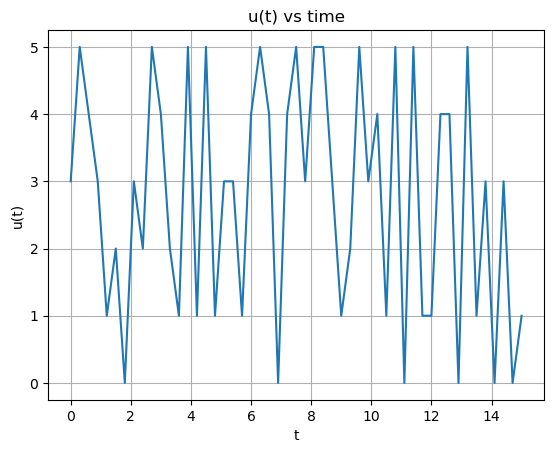

In [33]:
x = np.linspace(0, T, N+1)
plt.plot(x, u_t)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

## Last Trajectory


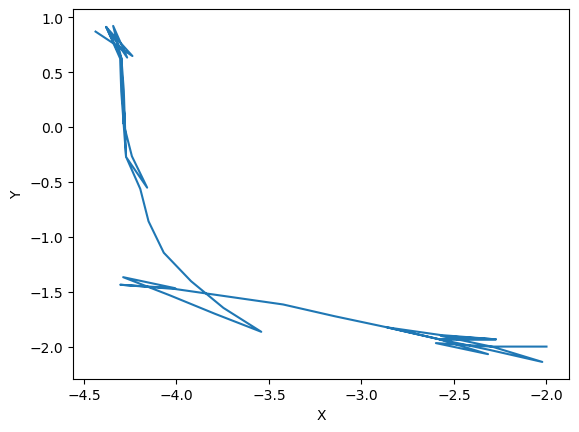

In [34]:
obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

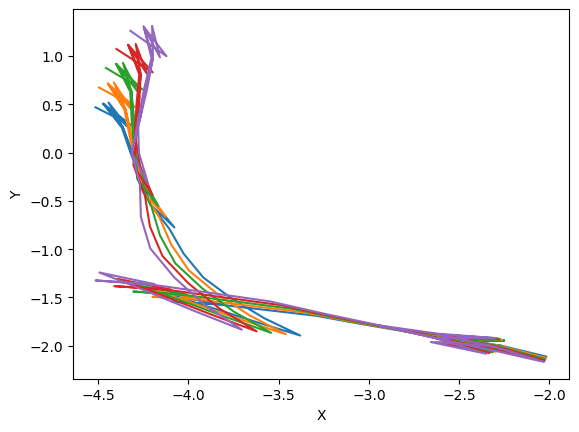

37.636535405332275


In [35]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

print(reward_raw(np.array(pos)))

## Best Trajectory

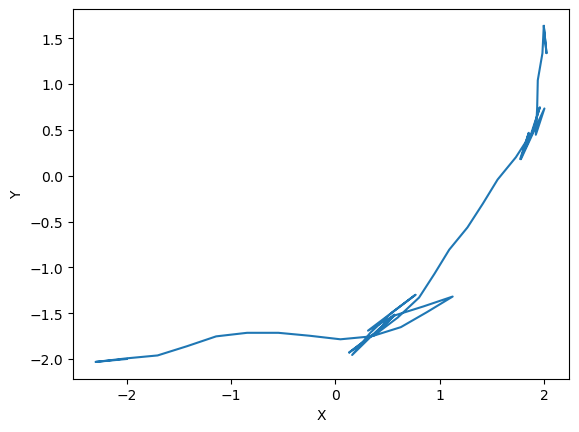

In [36]:
obs=np.array(best_obs)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

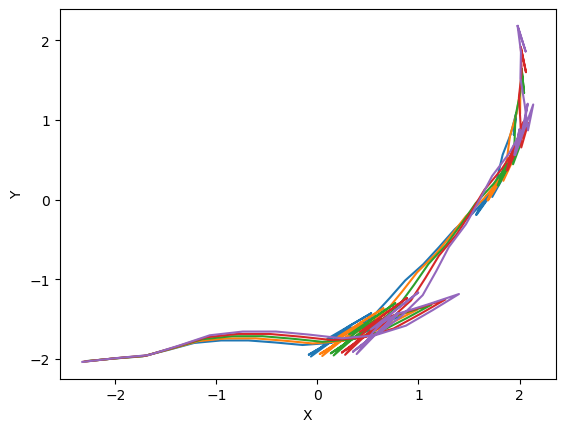

5.631201827612763


In [37]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

print(reward_raw(np.array(pos)))

## Pure Exploitation Trajectory

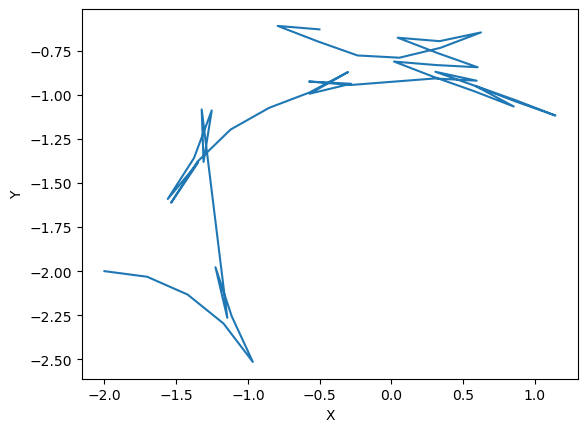

In [38]:
position=np.array([[-2,-2,0] for _ in range(num_system)])
observation=observe(position)
u_t=[]
observation_t=[observation]
position_t=[[] for i in range(num_system)]

for time in range(N+1):           
    
    u_k = decide_u_exploitation(gpr_list[time],flags[time],position)
    position_new = next_step(position,action_set[u_k])
    observation_new = observe(position_new)
    r = reward(observation_new)
    '''
    if explo:
        history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
        history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
    '''
    observation=observation_new
    position=position_new
    u_t.append(u_k)
    observation_t.append(observation)
    for i in range(num_system):
        position_t[i].append(position[i])
    '''
    if time%((N+1)//3+1)==0:
        for i in range(6):
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[i], history_r[i].reshape(-1,1))
    '''
    
obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

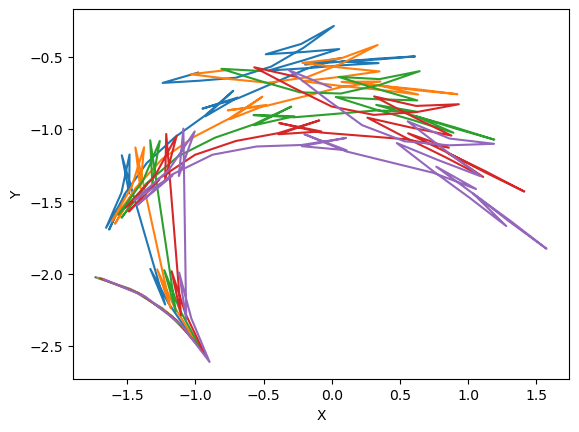

21.93089344699611


In [39]:
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(position))

In [40]:
print(observation_t[-1])

[-5.01960162e-01 -6.30206794e-01 -3.06305284e+00  1.18796044e-01
  1.95125835e-03]
